# CS224N Assignment 1: Exploring Word Vectors (25 Points)
### <font color='blue'> Due 4:30pm, Tue Jan 14 </font>

Welcome to CS224n! 

Before you start, make sure you read the README.txt in the same directory as this notebook. You will find many provided codes in the notebook. We highly encourage you to read and understand the provided codes as part of the learning :-)

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /home/michael/nltk_data...


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [2]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [10]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    wordset = {word for doc in corpus for word in doc}
    corpus_words = sorted(list(wordset))
    num_corpus_words = len(corpus_words)

    # ------------------

    return corpus_words, num_corpus_words

In [11]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [24]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.
    corpus_words, num_corpus_words = distinct_words(corpus)
    word2Ind = {word:i for i,word in enumerate(corpus_words)}
    M = np.zeros((num_corpus_words, num_corpus_words))
    for doc in corpus:
        for i, cword in enumerate(doc):
            k = word2Ind[cword]
            minval = max(0, i-window_size)
            maxval = min(len(doc), i+window_size)
            for j in range(minval, maxval):
                if j != i:
                    oword = doc[j]
                    l = word2Ind[oword]
                    M[k][l] += 1
                    M[l][k] += 1
    

    # ------------------

    return M, word2Ind

In [25]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2Ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [31]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    
    
        # ------------------

    print("Done.")
    return M_reduced

In [32]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [42]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        x, y = M_reduced[word2Ind[word]]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    plt.show()


    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


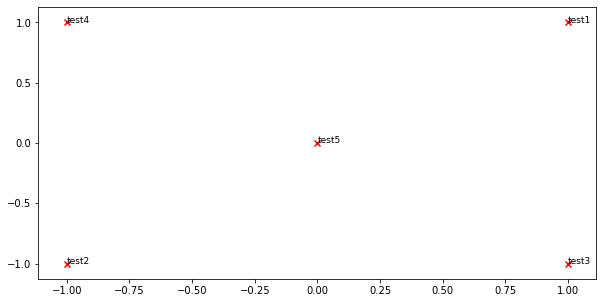

--------------------------------------------------------------------------------


In [43]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


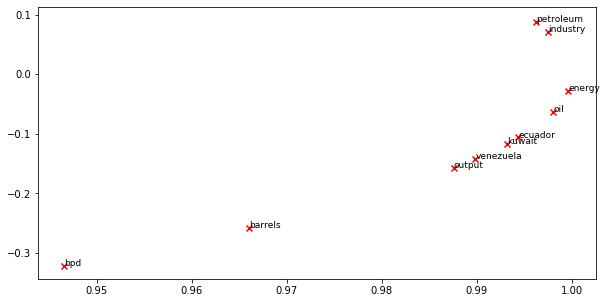

In [44]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']

plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take about 15 minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [45]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [46]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.7% 67.4/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.9% 110.8/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.1% 154.0/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 78.1% 196.8/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.2% 240.0/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loaded vocab size 400000


#### Note: If you are receiving reset by peer error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [47]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [48]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please follow the Piazza instructions, as how to run remotely on Stanford Farmshare machines.**

### Question 2.1: GloVe Plot Analysis [written] (4 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible reason for causing the difference?

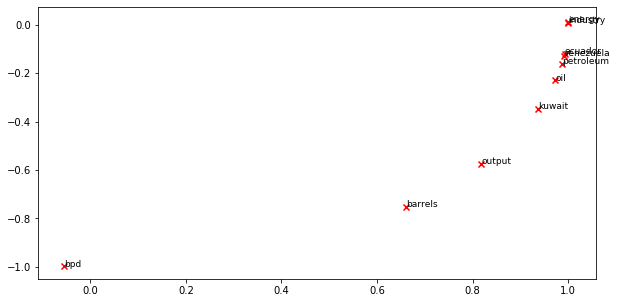

In [49]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized, word2Ind, words)

#### <font color="red">Write your answer here.</font>

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (2 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with at least 2 different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [ ]:
    # ------------------
    # Write your implementation here.
    words = list(wv_from_bin.vocab.keys())
    done = False
    threshold = 0.3
    for word in words:
        top10 = wv_from_bin.most_similar(word)
        meanings = []
        print(f'word: {word}')
        for i, word1 in enumerate(top10):
            word1 = word1[0]
            for word2 in top10[i+1:]:
                word2 = word2[0]
                #print(f'word1: {word1}, word2: {word2}')
                d = wv_from_bin.distance(word1, word2)
                if d < threshold: # word1 and word2 are synonyms
                    print(f'{word1} and {word2} are synonyms')
                    wordset = set((word1, word2))
                    syn = False
                    for k, group in enumerate(meanings): # Done like this to overwrite the set in meanings
                        #syn = False
                        for word3 in group:
                            if wv_from_bin.distance(word1, word3) < threshold: # word1 is a synonym with a word from group
                                meanings[k] = group.union(wordset)
                                syn = True
                        if syn:
                            break
                    if not syn:
                        meanings.append(wordset)
                if len(meanings) > 1:
                    print(f'Condition Found for word {word}!')
                    for n in range(len(meanings)):
                        print(f'Meaning {n+1}: {meanings[n]}')
                    done = True
                if done:
                    break
            if done:
                break
                    

    # ------------------

word: the
which and part are synonyms
which and this are synonyms
which and same are synonyms
which and . are synonyms
which and one are synonyms
which and that are synonyms
which and its are synonyms
of and part are synonyms
of and same are synonyms
of and one are synonyms
part and this are synonyms
part and . are synonyms
part and that are synonyms
this and same are synonyms
this and . are synonyms
this and one are synonyms
this and that are synonyms
this and first are synonyms
same and . are synonyms
same and one are synonyms
same and that are synonyms
same and first are synonyms
. and one are synonyms
. and that are synonyms
one and that are synonyms
one and first are synonyms
word: ,
. and but are synonyms
. and and are synonyms
. and also are synonyms
. and as are synonyms
. and while are synonyms
. and both are synonyms
. and though are synonyms
. and now are synonyms
. and in are synonyms
but and and are synonyms
but and also are synonyms
but and as are synonyms
but and while a

word: said
told and saying are synonyms
told and asked are synonyms
word: with
and and both are synonyms
and and while are synonyms
and and well are synonyms
and and . are synonyms
and and also are synonyms
and and , are synonyms
and and but are synonyms
word: he
him and but are synonyms
him and his are synonyms
him and when are synonyms
him and then are synonyms
him and having are synonyms
him and never are synonyms
him and again are synonyms
him and himself are synonyms
word: as
also and well are synonyms
also and but are synonyms
also and . are synonyms
also and both are synonyms
also and only are synonyms
also and such are synonyms
also and while are synonyms
word: it
this and but are synonyms
this and that are synonyms
this and so are synonyms
this and what are synonyms
this and which are synonyms
this and just are synonyms
this and . are synonyms
this and now are synonyms
this and way are synonyms
word: by
being and been are synonyms
being and be are synonyms
being and was are sy

word: n't
know and do are synonyms
know and you are synonyms
know and not are synonyms
know and did are synonyms
know and sure are synonyms
know and going are synonyms
know and want are synonyms
know and think are synonyms
know and ? are synonyms
word: her
she and mother are synonyms
she and herself are synonyms
she and woman are synonyms
word: percent
word: than
more and less are synonyms
more and much are synonyms
more and least are synonyms
more and even are synonyms
more and only are synonyms
more and far are synonyms
more and some are synonyms
more and almost are synonyms
word: over
up and last are synonyms
up and while are synonyms
up and . are synonyms
word: into
through and way are synonyms
word: last
month and week are synonyms
month and ago are synonyms
month and year are synonyms
month and earlier are synonyms
month and after are synonyms
month and months are synonyms
month and since are synonyms
month and weeks are synonyms
word: some
many and few are synonyms
many and have

word: under
which and same are synonyms
which and out are synonyms
which and . are synonyms
which and only are synonyms
which and all are synonyms
which and the are synonyms
word: such
other and these are synonyms
other and include are synonyms
other and like are synonyms
other and many are synonyms
other and well are synonyms
other and including are synonyms
other and certain are synonyms
other and those are synonyms
word: second
third and fourth are synonyms
third and first are synonyms
third and fifth are synonyms
third and sixth are synonyms
third and seventh are synonyms
third and eighth are synonyms
third and last are synonyms
third and final are synonyms
word: then
when and before are synonyms
when and again are synonyms
when and later are synonyms
when and once are synonyms
when and finally are synonyms
when and back are synonyms
when and he are synonyms
when and him are synonyms
when and out are synonyms
word: company
companies and business are synonyms
companies and firms are

word: thursday
tuesday and monday are synonyms
tuesday and wednesday are synonyms
tuesday and friday are synonyms
tuesday and saturday are synonyms
tuesday and sunday are synonyms
tuesday and week are synonyms
tuesday and earlier are synonyms
tuesday and afternoon are synonyms
tuesday and morning are synonyms
word: friday
thursday and tuesday are synonyms
thursday and monday are synonyms
thursday and wednesday are synonyms
thursday and saturday are synonyms
thursday and sunday are synonyms
thursday and week are synonyms
thursday and afternoon are synonyms
thursday and earlier are synonyms
thursday and morning are synonyms
word: game
word: here
today and this are synonyms
word: ?
you and n't are synonyms
you and know are synonyms
you and maybe are synonyms
you and think are synonyms
you and thing are synonyms
you and why are synonyms
you and do are synonyms
you and 'll are synonyms
you and going are synonyms
word: should
must and not are synonyms
must and would are synonyms
must and if 

word: countries
word: see
come and you are synonyms
come and what are synonyms
come and look are synonyms
come and n't are synonyms
come and know are synonyms
come and ? are synonyms
come and do are synonyms
come and go are synonyms
come and we are synonyms
word: best
good and well are synonyms
good and better are synonyms
good and way are synonyms
word: report
reports and reported are synonyms
word: killed
killing and dead are synonyms
word: held
hold and holding are synonyms
hold and holds are synonyms
word: business
businesses and companies are synonyms
businesses and firms are synonyms
word: west
east and south are synonyms
east and north are synonyms
east and southeast are synonyms
word: does
if and n't are synonyms
if and do are synonyms
if and not are synonyms
if and wo are synonyms
if and what are synonyms
if and anything are synonyms
if and nothing are synonyms
if and you are synonyms
if and know are synonyms
word: own
their and his are synonyms
their and our are synonyms
thei

word: past
ago and have are synonyms
ago and years are synonyms
ago and last are synonyms
word: de
word: half
nearly and almost are synonyms
nearly and five are synonyms
nearly and six are synonyms
nearly and last are synonyms
word: june
april and july are synonyms
april and october are synonyms
april and february are synonyms
april and november are synonyms
april and december are synonyms
april and september are synonyms
april and january are synonyms
april and march are synonyms
april and august are synonyms
word: saying
word: know
n't and why are synonyms
n't and sure are synonyms
n't and think are synonyms
n't and really are synonyms
n't and what are synonyms
n't and tell are synonyms
n't and you are synonyms
n't and we are synonyms
n't and ? are synonyms
word: federal
government and administration are synonyms
word: french
france and paris are synonyms
word: peace
accord and accords are synonyms
word: earlier
last and thursday are synonyms
last and tuesday are synonyms
last and we

word: free
allowed and allowing are synonyms
allowed and give are synonyms
word: hit
word: rights
word: 11
13 and 14 are synonyms
13 and 12 are synonyms
13 and 16 are synonyms
13 and 17 are synonyms
13 and 19 are synonyms
13 and 15 are synonyms
13 and 10 are synonyms
13 and 22 are synonyms
13 and 21 are synonyms
word: information
word: away
back and off are synonyms
back and out are synonyms
back and just are synonyms
back and then are synonyms
back and into are synonyms
back and way are synonyms
back and up are synonyms
word: 12
14 and 16 are synonyms
14 and 15 are synonyms
14 and 13 are synonyms
14 and 10 are synonyms
14 and 17 are synonyms
14 and 11 are synonyms
14 and 20 are synonyms
14 and 19 are synonyms
14 and 21 are synonyms
word: 5
6 and 4 are synonyms
6 and 7 are synonyms
6 and 3 are synonyms
6 and 8 are synonyms
6 and 9 are synonyms
6 and 2 are synonyms
6 and 10 are synonyms
6 and 1 are synonyms
6 and 12 are synonyms
word: others
other and those are synonyms
other and many a

word: include
including and included are synonyms
including and includes are synonyms
including and such are synonyms
including and addition are synonyms
including and other are synonyms
including and various are synonyms
including and several are synonyms
word: further
could and would are synonyms
could and possible are synonyms
could and however are synonyms
could and move are synonyms
word: nuclear
word: street
word: taken
taking and take are synonyms
taking and took are synonyms
word: media
word: different
these and various are synonyms
these and types are synonyms
these and certain are synonyms
these and similar are synonyms
these and other are synonyms
these and both are synonyms
these and those are synonyms
these and example are synonyms
word: issue
issues and matters are synonyms
word: received
receiving and receive are synonyms
word: secretary
word: return
returning and returned are synonyms
word: college
school and students are synonyms
word: working
work and worked are synon

word: almost
nearly and than are synonyms
nearly and half are synonyms
word: single
one and first are synonyms
one and second are synonyms
one and another are synonyms
one and only are synonyms
one and same are synonyms
word: share
shares and stock are synonyms
shares and rose are synonyms
word: leading
word: trying
tried and try are synonyms
tried and attempting are synonyms
word: find
word: album
albums and compilation are synonyms
albums and songs are synonyms
word: senior
word: minutes
word: together
with and well are synonyms
with and both are synonyms
with and and are synonyms
with and same are synonyms
word: congress
congressional and senate are synonyms
congressional and lawmakers are synonyms
congressional and republicans are synonyms
word: index
indexes and indices are synonyms
word: australia
word: results
result and following are synonyms
word: hard
word: hours
hour and minutes are synonyms
word: land
word: action
word: higher
word: field
word: cut
cutting and cuts are syno

third and ninth are synonyms
third and first are synonyms
word: always
so and sure are synonyms
so and know are synonyms
so and really are synonyms
so and everyone are synonyms
so and good are synonyms
so and never are synonyms
so and fact are synonyms
so and very are synonyms
so and n't are synonyms
word: king
word: 50
40 and 60 are synonyms
40 and 80 are synonyms
40 and 100 are synonyms
40 and 35 are synonyms
40 and 75 are synonyms
40 and 70 are synonyms
40 and 30 are synonyms
40 and 90 are synonyms
40 and 150 are synonyms
word: tax
taxes and income are synonyms
word: taiwan
mainland and taiwanese are synonyms
word: britain
word: 16
14 and 17 are synonyms
14 and 13 are synonyms
14 and 12 are synonyms
14 and 19 are synonyms
14 and 15 are synonyms
14 and 21 are synonyms
14 and 22 are synonyms
14 and 23 are synonyms
14 and 26 are synonyms
word: playing
played and play are synonyms
played and plays are synonyms
played and player are synonyms
word: title
word: middle
east and west are syn

word: michael
word: civil
war and conflict are synonyms
word: woman
word: training
word: appeared
appearing and appear are synonyms
word: 9
7 and 8 are synonyms
7 and 6 are synonyms
7 and 5 are synonyms
7 and 4 are synonyms
7 and 3 are synonyms
7 and 12 are synonyms
7 and 13 are synonyms
7 and 16 are synonyms
7 and 17 are synonyms
word: involved
involving and involve are synonyms
word: indian
india and delhi are synonyms
india and pakistan are synonyms
word: similar
example and same are synonyms
example and such are synonyms
example and different are synonyms
example and instance are synonyms
example and these are synonyms
example and unlike are synonyms
word: situation
concerned and obviously are synonyms
word: 24
22 and 28 are synonyms
22 and 25 are synonyms
22 and 26 are synonyms
22 and 18 are synonyms
22 and 23 are synonyms
22 and 21 are synonyms
22 and 19 are synonyms
22 and 29 are synonyms
22 and 17 are synonyms
word: los
angeles and l.a. are synonyms
word: running
word: fighting

word: getting
get and got are synonyms
get and gotten are synonyms
get and 're are synonyms
get and lot are synonyms
get and gets are synonyms
get and 've are synonyms
get and going are synonyms
get and just are synonyms
get and really are synonyms
word: biggest
word: performance
word: sports
word: 1998
1997 and 1996 are synonyms
1997 and 1999 are synonyms
1997 and 1995 are synonyms
1997 and 2001 are synonyms
1997 and 2002 are synonyms
1997 and 1994 are synonyms
1997 and 1993 are synonyms
1997 and 2003 are synonyms
1997 and 1992 are synonyms
word: let
want and you are synonyms
want and go are synonyms
want and n't are synonyms
want and do are synonyms
want and 'll are synonyms
want and if are synonyms
want and tell are synonyms
want and should are synonyms
word: allowed
allowing and allow are synonyms
word: schools
school and students are synonyms
school and elementary are synonyms
word: means
meaning and hence are synonyms
word: turn
turning and turned are synonyms
word: leave
stay an

word: tried
trying and attempting are synonyms
trying and try are synonyms
trying and wanted are synonyms
trying and attempt are synonyms
trying and to are synonyms
word: bad
good and things are synonyms
good and really are synonyms
good and because are synonyms
good and thing are synonyms
good and nothing are synonyms
good and pretty are synonyms
word: described
describing and describes are synonyms
describing and describe are synonyms
word: 1994
1993 and 1995 are synonyms
1993 and 1992 are synonyms
1993 and 1996 are synonyms
1993 and 1997 are synonyms
1993 and 1998 are synonyms
1993 and 1999 are synonyms
1993 and 1990 are synonyms
1993 and 1991 are synonyms
1993 and 2002 are synonyms
word: toward
word: written
wrote and writing are synonyms
wrote and author are synonyms
wrote and published are synonyms
word: throughout
word: established
establish and establishing are synonyms
word: mission
word: associated
word: buy
sell and purchase are synonyms
sell and buying are synonyms
sell and

leave and go are synonyms
leave and wait are synonyms
leave and rest are synonyms
leave and take are synonyms
word: safety
protection and protect are synonyms
word: worth
million and billion are synonyms
million and dollars are synonyms
million and $ are synonyms
million and dlrs are synonyms
word: charge
charges and charged are synonyms
charges and guilty are synonyms
charges and accused are synonyms
word: korean
korea and seoul are synonyms
korea and koreans are synonyms
korea and dprk are synonyms
korea and pyongyang are synonyms
word: begin
begun and start are synonyms
begun and beginning are synonyms
begun and began are synonyms
word: arab
word: 27
28 and 23 are synonyms
28 and 29 are synonyms
28 and 26 are synonyms
28 and 22 are synonyms
28 and 21 are synonyms
28 and 19 are synonyms
28 and 17 are synonyms
28 and 31 are synonyms
28 and 16 are synonyms
word: friends
word: anything
nothing and something are synonyms
nothing and else are synonyms
nothing and n't are synonyms
nothing 

word: plant
word: build
word: designed
word: certain
particular and specific are synonyms
particular and such are synonyms
word: voters
vote and polls are synonyms
vote and votes are synonyms
vote and voting are synonyms
vote and ballot are synonyms
vote and election are synonyms
word: modern
word: fans
crowd and spectators are synonyms
crowd and crowds are synonyms
crowd and cheering are synonyms
word: commercial
business and businesses are synonyms
business and companies are synonyms
business and industry are synonyms
word: bid
word: provided
provide and providing are synonyms
provide and provides are synonyms
provide and assistance are synonyms
provide and additional are synonyms
word: constitution
constitutional and amendment are synonyms
word: dropped
dropping and drop are synonyms
word: brother
son and father are synonyms
son and nephew are synonyms
son and cousin are synonyms
son and uncle are synonyms
son and grandson are synonyms
son and sons are synonyms
son and elder are syn

word: arms
weapons and weapon are synonyms
weapons and weaponry are synonyms
weapons and nuclear are synonyms
word: charles
henry and william are synonyms
henry and edward are synonyms
word: conflict
word: limited
word: material
word: trip
word: property
word: paper
newspaper and newspapers are synonyms
word: threat
word: seeking
seek and sought are synonyms
seek and seeks are synonyms
seek and help are synonyms
seek and to are synonyms
word: concern
concerns and worries are synonyms
concerns and fears are synonyms
concerns and concerned are synonyms
word: confirmed
confirm and confirming are synonyms
word: 1991
1990 and 1992 are synonyms
1990 and 1993 are synonyms
1990 and 1989 are synonyms
1990 and 1994 are synonyms
1990 and 1987 are synonyms
1990 and 1985 are synonyms
1990 and 1988 are synonyms
1990 and 1999 are synonyms
1990 and 1986 are synonyms
word: plane
airplane and jet are synonyms
airplane and aircraft are synonyms
word: route
word: completed
completion and completing are sy

word: approved
approve and approval are synonyms
approve and proposal are synonyms
approve and approving are synonyms
word: greater
increasing and increased are synonyms
increasing and increase are synonyms
word: port
word: ethnic
albanians and albanian are synonyms
albanians and kosovo are synonyms
albanians and serbs are synonyms
word: status
word: primary
word: amount
word: ”
“ and ‘ are synonyms
“ and ’ are synonyms
“ and — are synonyms
“ and … are synonyms
“ and " are synonyms
word: ways
way and how are synonyms
way and things are synonyms
way and rather are synonyms
way and find are synonyms
way and trying are synonyms
way and means are synonyms
way and need are synonyms
word: ran
running and run are synonyms
word: debate
word: model
word: decades
decade and years are synonyms
decade and since are synonyms
decade and ago are synonyms
decade and 1990s are synonyms
decade and 1980s are synonyms
decade and 1970s are synonyms
word: places
word: individual
word: festival
festivals and

word: catholic
church and churches are synonyms
word: opportunity
word: resources
word: writer
novelist and author are synonyms
novelist and poet are synonyms
novelist and playwright are synonyms
word: awards
award and awarded are synonyms
award and prize are synonyms
word: expect
word: anyone
anybody and anything are synonyms
anybody and else are synonyms
anybody and someone are synonyms
anybody and nobody are synonyms
anybody and know are synonyms
anybody and somebody are synonyms
anybody and everyone are synonyms
anybody and n't are synonyms
anybody and nothing are synonyms
word: send
sent and sending are synonyms
word: active
activity and activities are synonyms
word: claim
claims and claiming are synonyms
claims and claimed are synonyms
word: suffered
suffering and suffer are synonyms
suffering and severe are synonyms
word: alleged
allegedly and accused are synonyms
word: alliance
word: host
hosts and hosting are synonyms
word: declared
declare and declaring are synonyms
word: inj

word: 35
36 and 37 are synonyms
36 and 33 are synonyms
36 and 40 are synonyms
36 and 34 are synonyms
36 and 38 are synonyms
36 and 32 are synonyms
36 and 45 are synonyms
36 and 42 are synonyms
36 and 55 are synonyms
word: add
word: reduce
reducing and reduction are synonyms
reducing and reduced are synonyms
reducing and increasing are synonyms
word: directed
film and films are synonyms
film and movie are synonyms
word: replaced
replacing and replace are synonyms
replacing and replacement are synonyms
word: native
word: assistant
word: arts
word: seconds
minutes and minute are synonyms
word: crowd
word: complex
structure and structures are synonyms
word: quite
very and pretty are synonyms
very and extremely are synonyms
very and indeed are synonyms
very and fairly are synonyms
very and really are synonyms
very and so are synonyms
very and seems are synonyms
very and certainly are synonyms
very and obviously are synonyms
word: poland
hungary and romania are synonyms
word: entered
enterin

word: spokeswoman
word: committed
committing and commit are synonyms
committing and commits are synonyms
word: rally
rallies and protests are synonyms
rallies and demonstrations are synonyms
word: supported
support and supporting are synonyms
support and backing are synonyms
word: ambassador
diplomat and diplomats are synonyms
word: spoke
speaking and speak are synonyms
speaking and spoken are synonyms
word: ensure
ensuring and ensures are synonyms
word: towards
word: note
word: kids
children and parents are synonyms
word: headed
word: documents
word: follow
come and take are synonyms
come and must are synonyms
come and should are synonyms
come and go are synonyms
come and to are synonyms
come and not are synonyms
come and turn are synonyms
word: bosnia
herzegovina and hercegovina are synonyms
herzegovina and croatia are synonyms
word: rice
word: super
word: 45
44 and 35 are synonyms
44 and 55 are synonyms
44 and 48 are synonyms
44 and 36 are synonyms
44 and 65 are synonyms
44 and 33 a

word: capacity
word: fed
greenspan and bernanke are synonyms
word: box
word: 65
70 and 45 are synonyms
70 and 62 are synonyms
70 and 66 are synonyms
70 and 75 are synonyms
70 and 55 are synonyms
70 and 64 are synonyms
70 and 68 are synonyms
70 and 63 are synonyms
70 and 67 are synonyms
word: stores
store and grocery are synonyms
store and shop are synonyms
word: deaths
fatalities and accidents are synonyms
word: davis
word: sport
word: prize
nobel and laureate are synonyms
word: boost
boosting and boosted are synonyms
word: producer
word: comments
remarks and remark are synonyms
word: goods
word: ford
chrysler and gm are synonyms
chrysler and automaker are synonyms
word: episode
word: decline
declines and declining are synonyms
word: immediate
possible and any are synonyms
word: ending
ended and end are synonyms
ended and last are synonyms
word: girls
boys and boy are synonyms
word: bonds
word: climate
word: orders
word: destroyed
damaged and wrecked are synonyms
word: awarded
award an

word: federation
association and associations are synonyms
word: dispute
disputes and resolve are synonyms
disputes and disagreements are synonyms
word: personnel
word: combat
fighting and fight are synonyms
word: except
word: combined
word: missile
missiles and ballistic are synonyms
word: j.
l. and r. are synonyms
l. and a. are synonyms
l. and h. are synonyms
word: golf
word: doctor
physician and surgeon are synonyms
word: package
word: admitted
word: affected
affect and affecting are synonyms
affect and affects are synonyms
affect and adversely are synonyms
affect and impact are synonyms
word: extended
extend and extending are synonyms
word: offices
word: hurt
hurting and hurts are synonyms
word: announcement
announcing and announce are synonyms
announcing and announced are synonyms
word: eye
word: injuries
injury and knee are synonyms
word: minor
major and significant are synonyms
word: background
word: nor
neither and not are synonyms
neither and cannot are synonyms
neither and re

word: innings
word: congressional
senate and congress are synonyms
senate and republicans are synonyms
senate and lawmakers are synonyms
senate and republican are synonyms
senate and democrats are synonyms
word: willing
unwilling and reluctant are synonyms
word: dozens
hundreds and dozen are synonyms
hundreds and thousands are synonyms
hundreds and many are synonyms
hundreds and hundred are synonyms
word: edge
word: windows
word: firms
companies and businesses are synonyms
companies and corporations are synonyms
companies and business are synonyms
companies and industry are synonyms
companies and company are synonyms
word: senator
sen. and democrat are synonyms
sen. and senate are synonyms
sen. and republican are synonyms
sen. and sens. are synonyms
word: miss
pageant and pageants are synonyms
word: completely
totally and entirely are synonyms
totally and utterly are synonyms
totally and basically are synonyms
word: pope
benedict and xvi are synonyms
word: farmers
word: upper
word: plo

word: holiday
christmas and easter are synonyms
word: difference
mean and means are synonyms
word: master
bachelor and graduate are synonyms
bachelor and degree are synonyms
word: focused
focusing and focus are synonyms
focusing and focuses are synonyms
focusing and concentrating are synonyms
word: existing
expand and expanding are synonyms
expand and expanded are synonyms
word: criticized
word: improved
improve and improving are synonyms
improve and better are synonyms
word: ships
ship and vessels are synonyms
ship and vessel are synonyms
word: flying
flew and flown are synonyms
word: abu
word: minority
word: nov.
oct. and dec. are synonyms
oct. and feb. are synonyms
oct. and jan. are synonyms
oct. and aug. are synonyms
oct. and sept. are synonyms
oct. and june are synonyms
oct. and april are synonyms
oct. and march are synonyms
word: decisions
word: lies
situated and located are synonyms
word: expansion
expanding and expanded are synonyms
expanding and expand are synonyms
word: fight

word: towns
word: taylor
word: wind
winds and gusts are synonyms
winds and storms are synonyms
winds and storm are synonyms
word: color
colour and colors are synonyms
colour and colours are synonyms
word: alternative
word: knowledge
word: pictures
photographs and images are synonyms
photographs and photos are synonyms
photographs and photograph are synonyms
word: screen
word: edition
word: toll
word: retirement
retire and retiring are synonyms
word: 1985
1987 and 1982 are synonyms
1987 and 1981 are synonyms
1987 and 1986 are synonyms
1987 and 1984 are synonyms
1987 and 1978 are synonyms
1987 and 1977 are synonyms
1987 and 1988 are synonyms
1987 and 1983 are synonyms
1987 and 1980 are synonyms
word: theatre
word: clients
word: pilot
word: berlin
germany and german are synonyms
word: enforcement
word: commitment
pledge and promise are synonyms
pledge and pledges are synonyms
word: purchase
buy and sale are synonyms
buy and sell are synonyms
buy and acquire are synonyms
buy and bought are

word: perfect
good and excellent are synonyms
good and best are synonyms
good and something are synonyms
good and better are synonyms
word: sudan
sudanese and darfur are synonyms
sudanese and khartoum are synonyms
word: establish
establishing and establishment are synonyms
word: rome
italy and italian are synonyms
word: asking
ask and asked are synonyms
ask and tell are synonyms
ask and why are synonyms
ask and asks are synonyms
word: allegedly
accused and alleged are synonyms
accused and charged are synonyms
accused and charges are synonyms
word: core
component and components are synonyms
word: elements
word: 36
38 and 42 are synonyms
38 and 37 are synonyms
38 and 33 are synonyms
38 and 34 are synonyms
38 and 43 are synonyms
38 and 39 are synonyms
38 and 48 are synonyms
38 and 41 are synonyms
38 and 32 are synonyms
word: lewis
word: falls
word: express
expressing and expressed are synonyms
expressing and expresses are synonyms
expressing and regret are synonyms
word: conduct
conductin

word: prosecutor
prosecutors and prosecution are synonyms
word: fraud
word: southwest
northwest and northeast are synonyms
northwest and southeast are synonyms
northwest and northwestern are synonyms
word: maker
manufacturer and supplier are synonyms
manufacturer and manufacturers are synonyms
word: differences
disagreements and disagreement are synonyms
disagreements and disputes are synonyms
word: cited
word: virus
h5n1 and flu are synonyms
h5n1 and influenza are synonyms
h5n1 and avian are synonyms
h5n1 and h1n1 are synonyms
word: learning
learn and learned are synonyms
learn and teach are synonyms
word: powell
word: entry
enter and entering are synonyms
enter and entered are synonyms
word: centers
centres and centre are synonyms
word: truth
true and fact are synonyms
true and indeed are synonyms
word: receiving
received and receive are synonyms
word: indeed
fact and certainly are synonyms
fact and seems are synonyms
fact and perhaps are synonyms
fact and though are synonyms
fact an

word: display
displays and displayed are synonyms
displays and displaying are synonyms
word: achieve
achieving and achieved are synonyms
word: types
kinds and these are synonyms
kinds and variety are synonyms
kinds and various are synonyms
word: represent
represented and representing are synonyms
represented and represents are synonyms
word: fleet
word: waters
ocean and sea are synonyms
word: manchester
liverpool and leeds are synonyms
liverpool and chelsea are synonyms
liverpool and newcastle are synonyms
word: buried
interred and cemetery are synonyms
word: document
word: 6-3
6-4 and 6-2 are synonyms
6-4 and 7-5 are synonyms
6-4 and 6-1 are synonyms
6-4 and 7-6 are synonyms
6-4 and 6-0 are synonyms
6-4 and 3-6 are synonyms
6-4 and 4-6 are synonyms
6-4 and 2-6 are synonyms
6-4 and 5-7 are synonyms
word: partnership
word: illinois
missouri and ohio are synonyms
missouri and wisconsin are synonyms
missouri and arkansas are synonyms
word: guns
word: estimates
estimate and estimated are s

word: widespread
sparked and triggered are synonyms
sparked and outrage are synonyms
sparked and prompted are synonyms
word: 37
38 and 42 are synonyms
38 and 43 are synonyms
38 and 36 are synonyms
38 and 33 are synonyms
38 and 39 are synonyms
38 and 34 are synonyms
38 and 41 are synonyms
38 and 46 are synonyms
38 and 48 are synonyms
word: township
word: unlikely
likely and might are synonyms
likely and could are synonyms
likely and would are synonyms
likely and certainly are synonyms
likely and possible are synonyms
likely and expect are synonyms
word: stronger
weaker and weak are synonyms
weaker and weakening are synonyms
word: sitting
word: apartment
bedroom and upstairs are synonyms
word: respectively
10 and 16 are synonyms
10 and 12 are synonyms
10 and 13 are synonyms
10 and 14 are synonyms
10 and 15 are synonyms
10 and 17 are synonyms
10 and ten are synonyms
10 and 23 are synonyms
10 and 5 are synonyms
word: 48
43 and 36 are synonyms
43 and 38 are synonyms
43 and 42 are synonyms
4

word: representing
represented and represent are synonyms
represented and represents are synonyms
word: en
que and una are synonyms
word: investments
investment and investing are synonyms
investment and fund are synonyms
word: aviation
aircraft and jet are synonyms
word: jump
word: casualties
civilians and wounded are synonyms
civilians and soldiers are synonyms
word: profile
word: sees
thinks and says are synonyms
thinks and believes are synonyms
word: exhibition
word: trained
word: bigger
larger and smaller are synonyms
word: payments
payment and pay are synonyms
word: subsequently
later and eventually are synonyms
later and initially are synonyms
later and afterwards are synonyms
later and then are synonyms
later and returned are synonyms
later and was are synonyms
word: peak
word: clashes
confrontations and skirmishes are synonyms
word: earthquake
quake and temblor are synonyms
quake and aftershock are synonyms
word: ill
word: photo
photos and photograph are synonyms
photos and pho

word: joining
joined and join are synonyms
word: arrival
arrived and arriving are synonyms
arrived and arrive are synonyms
word: connected
connecting and connect are synonyms
connecting and connects are synonyms
connecting and linking are synonyms
word: dean
word: striker
midfielder and defender are synonyms
word: anderson
word: signal
word: practices
word: application
word: shift
word: restrictions
word: testimony
witness and witnesses are synonyms
word: jeff
word: touch
word: males
word: christopher
word: shareholders
word: promoted
word: pushing
pushed and push are synonyms
word: myself
yourself and ourselves are synonyms
yourself and me are synonyms
yourself and somebody are synonyms
yourself and you are synonyms
word: covers
covering and covered are synonyms
word: organisation
organization and organizations are synonyms
word: athens
word: sam
word: alan
word: fan
fans and crowd are synonyms
word: b.
a. and d. are synonyms
a. and h. are synonyms
a. and l. are synonyms
word: kashmir

word: 1969
1970 and 1965 are synonyms
1970 and 1966 are synonyms
1970 and 1971 are synonyms
1970 and 1968 are synonyms
1970 and 1963 are synonyms
1970 and 1973 are synonyms
1970 and 1961 are synonyms
1970 and 1977 are synonyms
1970 and 1962 are synonyms
word: cuban
word: insurgents
militants and taliban are synonyms
militants and rebels are synonyms
militants and guerrillas are synonyms
militants and extremists are synonyms
word: combination
word: h.
l. and a. are synonyms
l. and r. are synonyms
l. and j. are synonyms
word: angry
enraged and outraged are synonyms
enraged and angered are synonyms
enraged and incensed are synonyms
word: barrel
crude and barrels are synonyms
crude and oil are synonyms
word: appropriate
specific and certain are synonyms
word: 39
38 and 37 are synonyms
38 and 43 are synonyms
38 and 42 are synonyms
38 and 34 are synonyms
38 and 41 are synonyms
38 and 36 are synonyms
38 and 46 are synonyms
38 and 33 are synonyms
38 and 48 are synonyms
word: seed
seeded and un

word: remote
mountainous and rugged are synonyms
word: aggressive
word: apply
applying and applied are synonyms
word: trail
word: q
] and [ are synonyms
] and } are synonyms
word: usual
word: solo
album and albums are synonyms
album and band are synonyms
album and self-titled are synonyms
word: normally
usually and typically are synonyms
usually and generally are synonyms
usually and longer are synonyms
usually and rarely are synonyms
usually and often are synonyms
usually and sometimes are synonyms
usually and rather are synonyms
word: gop
republican and republicans are synonyms
republican and democrats are synonyms
republican and dole are synonyms
republican and mccain are synonyms
republican and democratic are synonyms
republican and senate are synonyms
republican and sen. are synonyms
word: unchanged
stocks and shares are synonyms
word: false
misleading and inaccurate are synonyms
word: y
que and por are synonyms
que and una are synonyms
word: tropical
word: walking
walk and walks 

word: distributed
distribute and distributing are synonyms
word: publishing
word: survivors
victims and relatives are synonyms
word: aides
word: barcelona
word: gunmen
assailants and attackers are synonyms
word: advisory
committee and commission are synonyms
committee and committees are synonyms
word: claiming
claimed and claim are synonyms
claimed and claims are synonyms
word: revenues
revenue and profits are synonyms
revenue and profit are synonyms
revenue and earnings are synonyms
word: imf
word: athletic
word: ally
word: commonly
referred and known are synonyms
referred and refers are synonyms
referred and refer are synonyms
word: mortgage
mortgages and subprime are synonyms
mortgages and lenders are synonyms
mortgages and loans are synonyms
mortgages and borrowers are synonyms
word: succeeded
word: savings
income and tax are synonyms
income and taxes are synonyms
word: helps
help and helping are synonyms
help and helped are synonyms
help and improve are synonyms
help and needs are

word: opposite
word: existence
existed and exist are synonyms
existed and exists are synonyms
word: 1966
1965 and 1963 are synonyms
1965 and 1969 are synonyms
1965 and 1958 are synonyms
1965 and 1961 are synonyms
1965 and 1971 are synonyms
1965 and 1964 are synonyms
1965 and 1962 are synonyms
1965 and 1957 are synonyms
1965 and 1970 are synonyms
word: magic
word: funeral
word: chechnya
chechen and grozny are synonyms
word: steady
rate and rise are synonyms
word: couples
word: sciences
science and physics are synonyms
word: landed
word: lifted
lift and lifting are synonyms
word: missouri
illinois and ohio are synonyms
illinois and wisconsin are synonyms
illinois and iowa are synonyms
illinois and michigan are synonyms
illinois and indiana are synonyms
word: connecticut
word: meat
beef and pork are synonyms
word: recognize
word: encouraged
encourage and encouraging are synonyms
word: opens
word: firing
word: midfielder
word: charter
word: ranks
word: n
word: annually
yearly and annual ar

word: monitor
monitors and monitoring are synonyms
word: calif.
word: starring
starred and co-starring are synonyms
starred and actor are synonyms
starred and co-starred are synonyms
word: definitely
obviously and really are synonyms
obviously and certainly are synonyms
obviously and think are synonyms
obviously and maybe are synonyms
obviously and 'm are synonyms
obviously and sure are synonyms
obviously and going are synonyms
obviously and thing are synonyms
word: smoke
word: delhi
word: engineer
word: seeded
word: citizen
word: foreigners
word: competed
championships and championship are synonyms
word: homeland
word: somalia
word: anger
frustration and dissatisfaction are synonyms
word: kings
word: renewed
word: shops
shop and store are synonyms
word: shoulder
knee and elbow are synonyms
knee and wrist are synonyms
knee and ankle are synonyms
knee and thigh are synonyms
knee and groin are synonyms
knee and injury are synonyms
word: toyota
word: correct
corrected and correcting are s

word: belgian
word: roots
word: acquisition
word: turnover
totaled and totalled are synonyms
word: sounds
word: prospects
word: orchestra
philharmonic and symphony are synonyms
philharmonic and orchestras are synonyms
word: bloc
25-nation and 27-nation are synonyms
25-nation and 15-nation are synonyms
25-nation and 27-member are synonyms
word: promises
promise and promised are synonyms
promise and pledge are synonyms
promise and promising are synonyms
promise and commitment are synonyms
word: plenty
lot and lots are synonyms
lot and enough are synonyms
lot and little are synonyms
lot and good are synonyms
lot and stuff are synonyms
lot and much are synonyms
word: client
word: gene
genes and mutations are synonyms
word: suspension
word: struggled
word: 1944
1943 and 1942 are synonyms
1943 and 1941 are synonyms
1943 and 1940 are synonyms
1943 and 1945 are synonyms
1943 and 1939 are synonyms
1943 and 1946 are synonyms
1943 and 1938 are synonyms
1943 and 1937 are synonyms
1943 and 1919 are

word: runner
word: thinks
knows and believes are synonyms
knows and think are synonyms
knows and nobody are synonyms
knows and does are synonyms
knows and says are synonyms
knows and likes are synonyms
knows and everyone are synonyms
knows and everybody are synonyms
knows and really are synonyms
word: peacekeeping
peacekeepers and troops are synonyms
word: missions
word: barry
word: situated
located and adjacent are synonyms
word: 56
54 and 57 are synonyms
54 and 53 are synonyms
54 and 58 are synonyms
54 and 52 are synonyms
54 and 62 are synonyms
54 and 59 are synonyms
54 and 43 are synonyms
54 and 46 are synonyms
54 and 61 are synonyms
word: eve
christmas and easter are synonyms
christmas and holiday are synonyms
word: ma
ying and jeou are synonyms
ying and chen are synonyms
word: n.y.
york and manhattan are synonyms
word: metres
meters and meter are synonyms
meters and feet are synonyms
word: geneva
word: renamed
word: manage
word: mines
word: chase
word: geography
word: clothing
wor

word: introduction
introduced and introducing are synonyms
introduced and introduce are synonyms
word: excellent
good and best are synonyms
word: brigade
battalion and infantry are synonyms
battalion and regiment are synonyms
battalion and cavalry are synonyms
battalion and battalions are synonyms
battalion and regiments are synonyms
word: bangkok
thailand and thai are synonyms
word: pending
word: depending
vary and varies are synonyms
vary and varying are synonyms
vary and differ are synonyms
word: ee
word: aims
aim and aiming are synonyms
aim and aimed are synonyms
word: anybody
anyone and somebody are synonyms
anyone and else are synonyms
anyone and nobody are synonyms
anyone and anything are synonyms
anyone and everybody are synonyms
anyone and anymore are synonyms
anyone and know are synonyms
anyone and maybe are synonyms
anyone and think are synonyms
word: restored
rebuilt and renovated are synonyms
rebuilt and repaired are synonyms
rebuilt and demolished are synonyms
word: activ

word: facts
word: attract
attracting and attracts are synonyms
attracting and attracted are synonyms
word: coaching
coach and coaches are synonyms
coach and coached are synonyms
word: architect
word: 67
68 and 69 are synonyms
68 and 71 are synonyms
68 and 66 are synonyms
68 and 63 are synonyms
68 and 74 are synonyms
68 and 73 are synonyms
68 and 62 are synonyms
68 and 72 are synonyms
68 and 61 are synonyms
word: 57
58 and 54 are synonyms
58 and 56 are synonyms
58 and 53 are synonyms
58 and 59 are synonyms
58 and 52 are synonyms
58 and 62 are synonyms
58 and 46 are synonyms
58 and 43 are synonyms
58 and 61 are synonyms
word: employers
word: exposed
exposing and expose are synonyms
exposing and exposes are synonyms
word: objects
word: complaint
filed and alleging are synonyms
filed and lawsuit are synonyms
filed and filing are synonyms
word: 62
63 and 59 are synonyms
63 and 54 are synonyms
63 and 61 are synonyms
63 and 58 are synonyms
63 and 56 are synonyms
63 and 57 are synonyms
63 and 

word: torture
word: 4th
3rd and 5th are synonyms
3rd and 2nd are synonyms
3rd and 6th are synonyms
3rd and 1st are synonyms
3rd and 7th are synonyms
3rd and 8th are synonyms
3rd and 9th are synonyms
3rd and 11th are synonyms
3rd and 10th are synonyms
word: celebration
celebrations and celebrating are synonyms
celebrations and celebrate are synonyms
celebrations and festivities are synonyms
celebrations and ceremonies are synonyms
word: photographs
photos and photograph are synonyms
photos and photo are synonyms
word: warren
word: lie
word: da
silva and inacio are synonyms
silva and lula are synonyms
silva and luiz are synonyms
word: 30,000
20,000 and 40,000 are synonyms
20,000 and 15,000 are synonyms
20,000 and 50,000 are synonyms
20,000 and 25,000 are synonyms
20,000 and 80,000 are synonyms
20,000 and 60,000 are synonyms
20,000 and 70,000 are synonyms
20,000 and 12,000 are synonyms
20,000 and 35,000 are synonyms
word: swept
word: parking
word: chrysler
automaker and daimlerchrysler ar

word: depth
word: element
word: asset
word: worries
fears and concerns are synonyms
fears and concern are synonyms
word: lying
word: superior
word: trips
word: 16th
17th and 15th are synonyms
17th and 18th are synonyms
17th and 14th are synonyms
17th and 13th are synonyms
17th and 12th are synonyms
17th and 11th are synonyms
17th and 10th are synonyms
17th and 19th are synonyms
17th and 8th are synonyms
word: definition
word: trafficking
smuggling and illegal are synonyms
word: suffer
suffering and suffered are synonyms
suffering and severe are synonyms
word: branches
word: harm
word: conflicts
word: influenced
word: mounted
word: 1954
1955 and 1957 are synonyms
1955 and 1958 are synonyms
1955 and 1956 are synonyms
1955 and 1952 are synonyms
1955 and 1951 are synonyms
1955 and 1953 are synonyms
1955 and 1966 are synonyms
1955 and 1961 are synonyms
1955 and 1965 are synonyms
word: spots
word: procedure
word: legend
legendary and famous are synonyms
word: carefully
meticulously and pains

word: concerning
regarding and relating are synonyms
word: sight
word: penalties
word: handful
dozen and few are synonyms
dozen and dozens are synonyms
dozen and several are synonyms
dozen and hundreds are synonyms
word: torn
word: update
updates and recasts are synonyms
updates and eds are synonyms
updates and adds are synonyms
updates and quotes are synonyms
word: ceasefire
cease and truce are synonyms
word: yasser
arafat and plo are synonyms
arafat and palestinian are synonyms
arafat and abbas are synonyms
arafat and peres are synonyms
arafat and netanyahu are synonyms
word: 13th
14th and 15th are synonyms
14th and 12th are synonyms
14th and 16th are synonyms
14th and 11th are synonyms
14th and 10th are synonyms
14th and 17th are synonyms
14th and 18th are synonyms
14th and 22nd are synonyms
14th and 8th are synonyms
word: eliminate
eliminating and reducing are synonyms
word: rises
word: routine
word: mall
shopping and malls are synonyms
word: restructuring
word: enterprise
business

word: prevented
preventing and prevent are synonyms
word: guess
maybe and think are synonyms
maybe and know are synonyms
maybe and 'd are synonyms
maybe and really are synonyms
maybe and figured are synonyms
maybe and else are synonyms
maybe and everybody are synonyms
maybe and thing are synonyms
maybe and anybody are synonyms
word: hindu
word: switch
switching and switched are synonyms
word: manufacturer
maker and makers are synonyms
word: stuck
word: l
word: yang
liu and wang are synonyms
liu and yu are synonyms
liu and wei are synonyms
liu and zhang are synonyms
liu and li are synonyms
word: der
word: spy
espionage and spying are synonyms
word: pierre
word: mood
word: prisoner
prisoners and detainees are synonyms
prisoners and captives are synonyms
prisoners and inmates are synonyms
word: franklin
word: 21st
20th and 15th are synonyms
word: operational
operations and operating are synonyms
word: experiences
word: necessarily
anything and certainly are synonyms
anything and mean are 

word: strange
word: universe
word: diamond
word: arrangements
word: pc
pcs and desktop are synonyms
pcs and computers are synonyms
word: hiding
word: retailers
stores and retail are synonyms
stores and supermarkets are synonyms
word: donations
donation and donated are synonyms
word: delays
delayed and delay are synonyms
delayed and delaying are synonyms
word: gaining
gained and gain are synonyms
word: gingrich
word: voiced
voicing and expressing are synonyms
voicing and misgivings are synonyms
word: collect
collected and collecting are synonyms
word: ibm
packard and hewlett are synonyms
packard and compaq are synonyms
word: pressed
word: followers
adherents and believers are synonyms
word: sheikh
word: basically
word: martinez
hernandez and rodriguez are synonyms
hernandez and gonzalez are synonyms
word: wonderful
terrific and fantastic are synonyms
word: kremlin
yeltsin and putin are synonyms
yeltsin and boris are synonyms
word: omar
ahmed and sheikh are synonyms
word: qatar
oman and 

word: drafted
word: warrant
word: nancy
word: nationals
word: recommendations
recommendation and recommended are synonyms
recommendation and recommending are synonyms
word: dancing
dance and dancers are synonyms
dance and dances are synonyms
word: radar
word: accidents
fatalities and deaths are synonyms
word: retained
word: gender
word: doubled
tripled and quadrupled are synonyms
word: conducting
conducted and conduct are synonyms
word: springs
word: algeria
tunisia and morocco are synonyms
word: ridge
word: extremists
extremist and militant are synonyms
extremist and islamist are synonyms
word: dies
died and death are synonyms
word: indication
indications and indicating are synonyms
word: 1936
1932 and 1935 are synonyms
1932 and 1937 are synonyms
1932 and 1938 are synonyms
1932 and 1934 are synonyms
1932 and 1928 are synonyms
1932 and 1924 are synonyms
1932 and 1931 are synonyms
1932 and 1933 are synonyms
1932 and 1927 are synonyms
word: parallel
north-south and east-west are synonyms

word: displayed
displaying and display are synonyms
displaying and displays are synonyms
word: assume
assuming and assumed are synonyms
assuming and assumes are synonyms
word: pregnant
mothers and babies are synonyms
mothers and children are synonyms
word: lessons
word: terrible
horrible and awful are synonyms
horrible and dreadful are synonyms
horrible and horrendous are synonyms
horrible and horrific are synonyms
horrible and appalling are synonyms
word: boards
word: opener
word: sean
word: sprint
word: 1.6
1.8 and 1.3 are synonyms
1.8 and 1.9 are synonyms
1.8 and 1.4 are synonyms
1.8 and 2.2 are synonyms
1.8 and 1.2 are synonyms
1.8 and 2.8 are synonyms
1.8 and 2.4 are synonyms
1.8 and 1.7 are synonyms
1.8 and 2.7 are synonyms
word: component
word: examination
examinations and exam are synonyms
examinations and exams are synonyms
word: embargo
sanctions and imposed are synonyms
word: novels
fiction and novel are synonyms
word: sub
nopickup and pickup9thgraf are synonyms
nopickup and

word: diana
word: afterwards
word: drought
droughts and floods are synonyms
word: dayton
word: abuses
word: blind
word: boxes
word: iaea
elbaradei and blix are synonyms
word: tears
crying and cried are synonyms
crying and sobbing are synonyms
crying and weeping are synonyms
word: sells
word: rely
relying and relied are synonyms
relying and relies are synonyms
word: calendar
word: immigrant
immigrants and undocumented are synonyms
immigrants and migrants are synonyms
word: nt
word: nicolas
word: 1-1
2-2 and 3-3 are synonyms
2-2 and 0-0 are synonyms
2-2 and 1-0 are synonyms
2-2 and 2-0 are synonyms
2-2 and 2-1 are synonyms
2-2 and 3-1 are synonyms
2-2 and 4-4 are synonyms
2-2 and 3-2 are synonyms
2-2 and 4-2 are synonyms
word: hanging
word: doping
steroid and steroids are synonyms
word: wen
jiabao and hu are synonyms
jiabao and jintao are synonyms
word: 1920
1921 and 1924 are synonyms
1921 and 1922 are synonyms
1921 and 1919 are synonyms
1921 and 1923 are synonyms
1921 and 1932 are synon

word: extending
extend and extended are synonyms
word: physics
chemistry and biology are synonyms
chemistry and biochemistry are synonyms
word: lined
word: refusal
refusing and refused are synonyms
refusing and refuses are synonyms
refusing and refuse are synonyms
word: debts
debt and loans are synonyms
word: explosions
blasts and blast are synonyms
blasts and bombings are synonyms
word: mcdonald
word: 30-year
10-year and 12-year are synonyms
word: starter
pitcher and hander are synonyms
pitcher and pitchers are synonyms
pitcher and hitter are synonyms
pitcher and pitching are synonyms
word: cheese
word: gambling
casinos and casino are synonyms
word: suits
suit and lawsuit are synonyms
word: recovering
word: lawmaker
word: offshore
word: historically
traditionally and generally are synonyms
word: tougher
word: hire
word: diverse
word: protestant
protestants and catholics are synonyms
word: marking
word: explains
word: administrator
word: buddhist
word: audiences
audience and viewers ar

word: saints
word: inspections
inspectors and inspection are synonyms
word: 1919
1921 and 1920 are synonyms
1921 and 1922 are synonyms
1921 and 1914 are synonyms
1921 and 1917 are synonyms
1921 and 1916 are synonyms
1921 and 1913 are synonyms
1921 and 1923 are synonyms
1921 and 1918 are synonyms
1921 and 1925 are synonyms
word: retreat
word: jennifer
word: hearts
word: answered
answer and questions are synonyms
answer and answers are synonyms
answer and question are synonyms
word: nonetheless
nevertheless and indeed are synonyms
nevertheless and noting are synonyms
nevertheless and though are synonyms
nevertheless and yet are synonyms
nevertheless and likewise are synonyms
nevertheless and fact are synonyms
word: chad
sudan and darfur are synonyms
sudan and sudanese are synonyms
word: iv
iii and ii are synonyms
word: openly
word: dprk
pyongyang and korea are synonyms
pyongyang and seoul are synonyms
word: nn
telegram.com and www.star are synonyms
word: joy
word: initiated
word: brutal


word: purchases
purchase and buy are synonyms
purchase and sale are synonyms
word: gifts
word: nebraska
oklahoma and kansas are synonyms
word: slump
downturn and slowdown are synonyms
downturn and recession are synonyms
word: submarine
submarines and warships are synonyms
word: consistently
nonetheless and nevertheless are synonyms
nonetheless and noting are synonyms
nonetheless and though are synonyms
word: flown
flew and flying are synonyms
word: animated
word: patterns
word: perceived
regard and particular are synonyms
word: aging
word: threaten
word: budgets
budget and spending are synonyms
word: flee
fleeing and fled are synonyms
word: holder
word: discount
word: medieval
word: 160
130 and 170 are synonyms
130 and 120 are synonyms
130 and 140 are synonyms
130 and 240 are synonyms
130 and 125 are synonyms
130 and 180 are synonyms
130 and 175 are synonyms
130 and 150 are synonyms
130 and 230 are synonyms
word: physician
word: scholar
word: monitors
monitor and monitoring are synonym

word: emerge
word: cheaper
cheap and inexpensive are synonyms
word: overwhelming
majority and vote are synonyms
word: insist
insisting and insisted are synonyms
word: sponsors
word: cloud
word: extradition
extradite and extradited are synonyms
word: researcher
word: supporter
word: 1928
1924 and 1932 are synonyms
1924 and 1927 are synonyms
1924 and 1926 are synonyms
1924 and 1925 are synonyms
1924 and 1934 are synonyms
1924 and 1931 are synonyms
1924 and 1935 are synonyms
1924 and 1929 are synonyms
1924 and 1936 are synonyms
word: chocolate
word: thaksin
word: nonprofit
non-profit and not-for-profit are synonyms
non-profit and non-governmental are synonyms
word: ferguson
wenger and arsene are synonyms
word: sacramento
word: dominican
puerto and rico are synonyms
puerto and rican are synonyms
word: posed
pose and poses are synonyms
word: conversion
word: spectacular
stunning and breathtaking are synonyms
word: kazakhstan
word: spell
word: quarterfinals
semifinals and semifinal are synon

word: 81
84 and 79 are synonyms
84 and 83 are synonyms
84 and 82 are synonyms
84 and 89 are synonyms
84 and 74 are synonyms
84 and 76 are synonyms
84 and 78 are synonyms
84 and 91 are synonyms
84 and 87 are synonyms
word: favorable
favourable and unfavorable are synonyms
favourable and unfavourable are synonyms
word: indianapolis
word: phenomenon
word: barriers
word: examined
examining and examine are synonyms
word: bones
word: supervision
word: tyson
holyfield and evander are synonyms
word: opinions
word: aspect
aspects and context are synonyms
word: instructions
word: cope
word: frequency
word: neil
word: automatically
allows and lets are synonyms
word: 25,000
15,000 and 50,000 are synonyms
15,000 and 20,000 are synonyms
15,000 and 30,000 are synonyms
15,000 and 40,000 are synonyms
15,000 and 10,000 are synonyms
15,000 and 35,000 are synonyms
15,000 and 45,000 are synonyms
15,000 and 100,000 are synonyms
15,000 and 75,000 are synonyms
word: expelled
word: quest
dream and dreams are s

word: pays
pay and paid are synonyms
pay and paying are synonyms
word: basin
word: warsaw
word: 6th
8th and 5th are synonyms
8th and 7th are synonyms
8th and 9th are synonyms
8th and 4th are synonyms
8th and 3rd are synonyms
8th and 2nd are synonyms
8th and 11th are synonyms
8th and 12th are synonyms
8th and 1st are synonyms
word: 900
600 and 700 are synonyms
600 and 750 are synonyms
600 and 850 are synonyms
600 and 650 are synonyms
600 and 800 are synonyms
600 and 1,100 are synonyms
600 and 450 are synonyms
600 and 250 are synonyms
600 and 1,200 are synonyms
word: paramilitary
word: indicating
indicate and indicates are synonyms
indicate and indicated are synonyms
indicate and suggest are synonyms
word: theft
robbery and burglary are synonyms
word: hitler
word: compiled
word: cave
word: lithuania
latvia and estonia are synonyms
word: toys
word: focuses
focusing and focused are synonyms
focusing and focus are synonyms
word: bennett
word: letting
let and keep are synonyms
let and simply

word: heavyweight
welterweight and middleweight are synonyms
welterweight and wba are synonyms
welterweight and featherweight are synonyms
welterweight and wbc are synonyms
welterweight and ibf are synonyms
welterweight and cruiserweight are synonyms
word: wishes
wish and wished are synonyms
wish and wanting are synonyms
wish and ask are synonyms
word: ld
writethru and ¥ are synonyms
writethru and frontpage-1stld are synonyms
word: rouge
word: devil
word: bold
daring and audacious are synonyms
word: toy
word: bahrain
qatar and oman are synonyms
qatar and emirates are synonyms
qatar and uae are synonyms
qatar and kuwait are synonyms
word: hop
rap and hip-hop are synonyms
rap and rappers are synonyms
word: headline
word: emphasized
stressed and stressing are synonyms
stressed and noting are synonyms
word: greenhouse
emissions and gases are synonyms
emissions and dioxide are synonyms
emissions and carbon are synonyms
emissions and co2 are synonyms
emissions and emission are synonyms
word:

word: accommodate
word: packages
word: policeman
policemen and wounded are synonyms
policemen and police are synonyms
word: jobless
unemployment and joblessness are synonyms
word: meal
word: heaven
word: continuous
word: jumping
jump and jumps are synonyms
word: destroying
destroyed and damaged are synonyms
word: nominations
nominees and nominated are synonyms
nominees and nomination are synonyms
word: subscribers
word: approaching
word: 1915
1916 and 1914 are synonyms
1916 and 1917 are synonyms
1916 and 1913 are synonyms
1916 and 1919 are synonyms
1916 and 1922 are synonyms
1916 and 1921 are synonyms
1916 and 1912 are synonyms
1916 and 1920 are synonyms
1916 and 1923 are synonyms
word: nyt
word: maps
word: edinburgh
word: blown
blew and blowing are synonyms
word: trader
brokerage and securities are synonyms
word: historians
word: beats
beat and beating are synonyms
word: ni
word: koizumi
word: surveys
survey and surveyed are synonyms
word: dynamic
word: psychology
sociology and anthro

word: manual
5-speed and 6-speed are synonyms
5-speed and six-speed are synonyms
5-speed and five-speed are synonyms
5-speed and four-speed are synonyms
word: abdel
word: coca
cola and pepsi are synonyms
cola and coke are synonyms
word: commons
parliament and parliamentary are synonyms
word: donor
donors and donations are synonyms
word: nowhere
gone and nothing are synonyms
gone and anyway are synonyms
word: seize
seizing and seized are synonyms
word: museums
word: specialized
specialised and specialising are synonyms
word: outlets
word: publishers
publishing and publisher are synonyms
publishing and publications are synonyms
word: delivering
deliver and delivered are synonyms
word: semifinal
quarterfinal and semifinals are synonyms
quarterfinal and quarterfinals are synonyms
quarterfinal and finals are synonyms
word: rabbi
word: leather
shoes and boots are synonyms
shoes and shoe are synonyms
word: reds
phillies and dodgers are synonyms
phillies and marlins are synonyms
phillies and m

word: sailing
word: choosing
choose and choice are synonyms
choose and chosen are synonyms
choose and chose are synonyms
choose and select are synonyms
word: 2,500
4,000 and 6,000 are synonyms
4,000 and 2,000 are synonyms
4,000 and 3,000 are synonyms
4,000 and 3,500 are synonyms
4,000 and 1,200 are synonyms
4,000 and 7,000 are synonyms
4,000 and 4,500 are synonyms
4,000 and 5,000 are synonyms
4,000 and 1,500 are synonyms
word: commented
word: logo
word: ignore
ignored and ignoring are synonyms
word: bailey
word: wisdom
belief and faith are synonyms
word: buenos
word: residing
word: ruler
word: flooded
inundated and swamped are synonyms
word: assembled
word: o'brien
word: inn
hotel and hotels are synonyms
word: tissue
word: opposes
oppose and opposed are synonyms
word: theaters
cinemas and theatres are synonyms
word: chess
word: palmer
word: symbolic
word: 6-0
6-1 and 6-2 are synonyms
6-1 and 6-3 are synonyms
6-1 and 7-5 are synonyms
6-1 and 6-4 are synonyms
6-1 and 7-6 are synonyms
6-1

word: insisting
insisted and insists are synonyms
insisted and insist are synonyms
insisted and saying are synonyms
word: shaw
word: compact
word: dalai
word: stripped
word: chef
word: 94
92 and 91 are synonyms
92 and 93 are synonyms
92 and 89 are synonyms
92 and 97 are synonyms
92 and 87 are synonyms
92 and 84 are synonyms
92 and 83 are synonyms
92 and 88 are synonyms
92 and 81 are synonyms
word: spotlight
word: zaire
congo and rwanda are synonyms
congo and kinshasa are synonyms
congo and burundi are synonyms
congo and drc are synonyms
word: ladies
word: grams
milligrams and calories are synonyms
word: departed
departing and arriving are synonyms
departing and depart are synonyms
word: 91
92 and 94 are synonyms
92 and 89 are synonyms
92 and 84 are synonyms
92 and 81 are synonyms
92 and 87 are synonyms
92 and 83 are synonyms
92 and 82 are synonyms
92 and 93 are synonyms
92 and 79 are synonyms
word: facilitate
word: soap
word: mercedes
benz and daimler are synonyms
word: agassi
sampras 

word: dragged
word: debates
debate and discussion are synonyms
word: uzbekistan
tajikistan and kyrgyzstan are synonyms
tajikistan and kazakhstan are synonyms
tajikistan and turkmenistan are synonyms
word: nova
scotia and brunswick are synonyms
scotia and newfoundland are synonyms
word: ghost
word: enters
begins and turns are synonyms
word: naming
names and name are synonyms
word: intend
want and ought are synonyms
want and willing are synonyms
want and should are synonyms
want and would are synonyms
want and wish are synonyms
word: complain
complained and complaining are synonyms
word: kah
word: rebuilt
word: brokers
word: custom
designs and design are synonyms
word: bids
bidding and bidders are synonyms
word: canyon
word: regain
regained and regaining are synonyms
word: enclave
word: embrace
embracing and embraced are synonyms
word: archives
archive and archival are synonyms
word: incredible
amazing and unbelievable are synonyms
amazing and astonishing are synonyms
amazing and fantast

word: divorced
remarried and widowed are synonyms
word: proportion
word: fifteen
fourteen and twenty are synonyms
fourteen and eleven are synonyms
fourteen and thirteen are synonyms
fourteen and seventeen are synonyms
fourteen and thirty are synonyms
fourteen and twelve are synonyms
fourteen and sixteen are synonyms
fourteen and forty are synonyms
fourteen and eighteen are synonyms
word: grenade
grenades and assailants are synonyms
grenades and launchers are synonyms
grenades and mortars are synonyms
word: cautioned
warned and warn are synonyms
word: 5.5
4.5 and 6.5 are synonyms
4.5 and 8.5 are synonyms
4.5 and 4.8 are synonyms
4.5 and 7.5 are synonyms
4.5 and 4.3 are synonyms
4.5 and 5.3 are synonyms
4.5 and 5.6 are synonyms
4.5 and 4.6 are synonyms
4.5 and 4.4 are synonyms
word: serie
fiorentina and juventus are synonyms
fiorentina and sampdoria are synonyms
fiorentina and empoli are synonyms
fiorentina and cagliari are synonyms
word: amendments
amendment and legislation are synonyms

word: hood
word: rejection
rejecting and reject are synonyms
rejecting and rejected are synonyms
rejecting and rejects are synonyms
word: baltic
estonia and latvia are synonyms
estonia and lithuania are synonyms
word: 400,000
600,000 and 300,000 are synonyms
600,000 and 200,000 are synonyms
600,000 and 700,000 are synonyms
600,000 and 150,000 are synonyms
600,000 and 350,000 are synonyms
600,000 and 500,000 are synonyms
600,000 and 800,000 are synonyms
600,000 and 250,000 are synonyms
600,000 and 100,000 are synonyms
word: tass
itar and interfax are synonyms
itar and novosti are synonyms
word: obligation
obligations and commitments are synonyms
word: midwest
word: issuing
word: flowing
flows and flow are synonyms
word: gabriel
word: scared
frightened and terrified are synonyms
frightened and fearful are synonyms
word: clerk
word: enrolled
enroll and enrolling are synonyms
enroll and graduates are synonyms
word: generous
word: shy
word: drum
drums and percussion are synonyms
drums and g

word: laurent
kabila and mobutu are synonyms
word: reservoir
dam and dams are synonyms
word: belfast
word: crawford
word: fantastic
amazing and incredible are synonyms
amazing and wonderful are synonyms
amazing and unbelievable are synonyms
amazing and astonishing are synonyms
word: coordinate
word: reductions
reduction and increases are synonyms
reduction and reducing are synonyms
reduction and reduce are synonyms
reduction and increase are synonyms
word: buyer
word: treatments
therapies and therapy are synonyms
word: alike
word: matching
word: flexible
word: thereby
thus and therefore are synonyms
word: minneapolis
chicago and philadelphia are synonyms
word: joel
word: icon
word: itar
tass and interfax are synonyms
tass and novosti are synonyms
word: dignity
word: naked
nude and topless are synonyms
word: stays
stay and staying are synonyms
stay and stayed are synonyms
word: norfolk
word: trinidad
tobago and barbados are synonyms
word: brady
word: n.j.
word: khmer
word: reads
read an

word: stormed
word: ugandan
uganda and drc are synonyms
word: scout
scouts and scouting are synonyms
word: productive
word: swap
word: faithful
believers and christians are synonyms
word: boulevard
word: armenia
word: reopened
reopen and reopening are synonyms
word: avoiding
avoid and avoided are synonyms
avoid and prevent are synonyms
word: fischer
word: 2.8
2.6 and 2.9 are synonyms
2.6 and 2.3 are synonyms
2.6 and 2.7 are synonyms
2.6 and 1.9 are synonyms
2.6 and 2.2 are synonyms
2.6 and 2.4 are synonyms
2.6 and 3.7 are synonyms
2.6 and 1.8 are synonyms
2.6 and 3.4 are synonyms
word: wei
liu and zhang are synonyms
liu and wu are synonyms
liu and li are synonyms
liu and yang are synonyms
liu and yu are synonyms
liu and wang are synonyms
word: aggregate
3-1 and 2-1 are synonyms
3-1 and 3-2 are synonyms
3-1 and 4-2 are synonyms
3-1 and 1-0 are synonyms
3-1 and 4-1 are synonyms
3-1 and 3-0 are synonyms
3-1 and 2-0 are synonyms
word: revived
revive and reviving are synonyms
revive and mor

word: ronaldo
word: sin
word: technically
word: economically
word: ram
word: miracle
word: supervisor
word: spends
spend and spent are synonyms
spend and spending are synonyms
word: kohl
word: deploy
deploying and deployed are synonyms
deploying and deployment are synonyms
word: geographic
word: exporting
importing and imported are synonyms
word: menu
word: brisbane
melbourne and perth are synonyms
melbourne and adelaide are synonyms
melbourne and sydney are synonyms
word: linebacker
lineman and linemen are synonyms
word: slavery
slaves and slave are synonyms
word: pants
trousers and jeans are synonyms
trousers and jacket are synonyms
trousers and baggy are synonyms
trousers and khaki are synonyms
trousers and skirts are synonyms
trousers and slacks are synonyms
word: manufacture
manufactured and manufacturer are synonyms
word: tally
word: delegate
word: snapped
word: semiconductor
word: haul
word: loop
word: havana
cuban and cuba are synonyms
cuban and cubans are synonyms
word: lackin

word: facebook
twitter and myspace are synonyms
twitter and youtube are synonyms
word: typhoon
word: upbeat
downbeat and gloomy are synonyms
word: uncovered
word: thanksgiving
holiday and christmas are synonyms
holiday and holidays are synonyms
word: icc
word: examining
examine and examined are synonyms
examine and determine are synonyms
word: satellites
word: dissidents
word: specify
specifying and specified are synonyms
word: inland
coastal and coastline are synonyms
coastal and coast are synonyms
word: overhead
circled and circling are synonyms
word: tortured
word: shane
warne and mcgrath are synonyms
word: alien
word: stretched
stretching and stretches are synonyms
word: closes
word: kyoto
word: launches
launch and launched are synonyms
launch and launching are synonyms
word: ensemble
ensembles and orchestras are synonyms
word: peruvian
word: morales
word: batteries
word: ritual
rituals and rites are synonyms
word: {
} and hellip are synonyms
} and ndash are synonyms
} and ] are sy

word: wagner
mozart and beethoven are synonyms
word: incentive
word: firearms
firearm and handgun are synonyms
word: trans
word: runoff
word: plaintiffs
word: liver
word: confronted
confronting and confront are synonyms
word: corridor
word: davenport
capriati and seles are synonyms
capriati and hingis are synonyms
capriati and mauresmo are synonyms
capriati and clijsters are synonyms
capriati and serena are synonyms
capriati and sharapova are synonyms
capriati and agassi are synonyms
capriati and henin are synonyms
word: cluster
word: layoffs
cutbacks and cuts are synonyms
word: sustain
word: o'connor
word: zagreb
word: tracy
word: boarding
school and schools are synonyms
school and students are synonyms
word: meyer
word: fixing
word: carved
carvings and sculptures are synonyms
word: podium
word: battled
word: chasing
word: cliff
word: supermarket
grocery and supermarkets are synonyms
grocery and store are synonyms
grocery and stores are synonyms
word: juvenile
word: overwhelmingly
vot

word: renew
word: portsmouth
southampton and sunderland are synonyms
southampton and norwich are synonyms
word: plotting
word: hemisphere
word: mongolia
kazakhstan and uzbekistan are synonyms
word: laboratories
labs and lab are synonyms
word: piracy
word: chaired
committee and committees are synonyms
word: est
edt and p.m. are synonyms
word: understands
knows and thinks are synonyms
knows and understand are synonyms
knows and believes are synonyms
knows and everybody are synonyms
word: balkan
balkans and bosnia are synonyms
word: reply
word: medicines
medications and drugs are synonyms
medications and medication are synonyms
medications and prescription are synonyms
word: exiled
word: embassies
consulates and consulate are synonyms
word: iranians
syrians and egyptians are synonyms
syrians and jordanians are synonyms
word: rachel
word: betting
word: guild
word: exploring
word: disastrous
word: dumped
dump and dumps are synonyms
word: bias
word: rainfall
precipitation and snowfall are sy

word: stricken
ravaged and devastated are synonyms
word: performer
performers and performances are synonyms
word: contests
word: reopen
reopened and reopening are synonyms
reopened and re-opened are synonyms
word: newest
word: cholesterol
ldl and triglycerides are synonyms
word: reigning
champion and defending are synonyms
champion and champ are synonyms
champion and medalist are synonyms
word: monarchy
word: non-families
30.4 and 31.1 are synonyms
30.4 and 32.0 are synonyms
30.4 and 31.9 are synonyms
30.4 and 31.7 are synonyms
30.4 and 31.3 are synonyms
30.4 and 32.1 are synonyms
30.4 and 32.3 are synonyms
30.4 and 27.3 are synonyms
30.4 and 28.6 are synonyms
word: applies
apply and applied are synonyms
apply and applying are synonyms
word: starters
word: famed
famous and renowned are synonyms
famous and legendary are synonyms
famous and well-known are synonyms
word: waving
waved and flags are synonyms
word: 3.6
3.4 and 3.7 are synonyms
3.4 and 3.3 are synonyms
3.4 and 3.9 are synonym

word: diagnosis
word: 115
110 and 112 are synonyms
110 and 105 are synonyms
110 and 113 are synonyms
110 and 119 are synonyms
110 and 117 are synonyms
110 and 140 are synonyms
110 and 130 are synonyms
110 and 116 are synonyms
110 and 135 are synonyms
word: hurdles
word: fossil
fossils and dinosaur are synonyms
fossils and fossilized are synonyms
fossils and specimens are synonyms
word: screenplay
word: teaspoon
teaspoons and tablespoon are synonyms
teaspoons and tablespoons are synonyms
word: biblical
scripture and bible are synonyms
scripture and scriptural are synonyms
scripture and scriptures are synonyms
word: wished
wish and wishes are synonyms
wish and wanted are synonyms
wish and wanting are synonyms
word: zhou
zhang and zhao are synonyms
zhang and li are synonyms
zhang and liu are synonyms
zhang and wei are synonyms
word: edgar
word: sticks
word: unexpectedly
word: logistics
word: khatami
rafsanjani and khamenei are synonyms
rafsanjani and hashemi are synonyms
word: generic
wor

word: sgt.
word: merge
merging and merged are synonyms
word: consequently
therefore and furthermore are synonyms
therefore and hence are synonyms
therefore and thus are synonyms
therefore and likewise are synonyms
therefore and moreover are synonyms
therefore and however are synonyms
word: regained
regaining and regain are synonyms
word: beam
word: raf
squadron and squadrons are synonyms
word: dodge
chevrolet and pontiac are synonyms
word: bang
word: imagination
word: stabilize
word: 19-year
18-year and 21-year are synonyms
18-year and 22-year are synonyms
18-year and 17-year are synonyms
18-year and 23-year are synonyms
18-year and 16-year are synonyms
18-year and 27-year are synonyms
18-year and 24-year are synonyms
18-year and 20-year are synonyms
18-year and 26-year are synonyms
word: temples
word: lighter
word: 750
900 and 650 are synonyms
900 and 600 are synonyms
900 and 700 are synonyms
900 and 450 are synonyms
900 and 250 are synonyms
900 and 850 are synonyms
900 and 550 are sy

word: evacuate
evacuation and evacuations are synonyms
word: monte
word: kidnappers
abductors and captors are synonyms
word: vendors
word: disambiguation
a.k.a. and aka are synonyms
word: plateau
word: monk
monks and buddhist are synonyms
monks and nuns are synonyms
word: busch
anheuser and inbev are synonyms
word: kyrgyzstan
tajikistan and uzbekistan are synonyms
tajikistan and kazakhstan are synonyms
tajikistan and turkmenistan are synonyms
word: compensate
word: motivation
motive and motives are synonyms
word: ashley
word: mathematical
mathematics and physics are synonyms
word: ideological
ideology and ideologies are synonyms
word: restrict
restricting and restrictions are synonyms
restricting and restricts are synonyms
restricting and limiting are synonyms
word: outfit
word: volkswagen
word: recruits
recruit and recruiting are synonyms
recruit and recruited are synonyms
word: solving
solve and solved are synonyms
solve and problem are synonyms
solve and resolve are synonyms
word: p

word: pablo
word: credentials
word: skull
bones and bone are synonyms
word: observations
word: colts
broncos and chargers are synonyms
broncos and ravens are synonyms
broncos and patriots are synonyms
broncos and steelers are synonyms
broncos and redskins are synonyms
broncos and seahawks are synonyms
word: pvs
word: debated
word: bathroom
word: extinct
species and genus are synonyms
word: snake
word: 1865
1864 and 1862 are synonyms
1864 and 1863 are synonyms
1864 and 1861 are synonyms
1864 and 1866 are synonyms
1864 and 1869 are synonyms
1864 and 1859 are synonyms
1864 and 1858 are synonyms
1864 and 1854 are synonyms
1864 and 1867 are synonyms
word: knights
word: bizarre
strange and weird are synonyms
strange and odd are synonyms
word: dana
word: neighbours
neighbors and neighbor are synonyms
word: slogans
chanting and chanted are synonyms
chanting and shouting are synonyms
word: seekers
word: 1892
1891 and 1888 are synonyms
1891 and 1886 are synonyms
1891 and 1894 are synonyms
1891 a

word: farewell
word: blunt
word: jacobs
word: aunt
grandmother and niece are synonyms
grandmother and mother are synonyms
grandmother and granddaughter are synonyms
grandmother and daughter are synonyms
grandmother and wife are synonyms
grandmother and grandparents are synonyms
word: detonated
exploded and bomb are synonyms
word: hoffman
word: malawi
zambia and mozambique are synonyms
zambia and botswana are synonyms
zambia and namibia are synonyms
zambia and uganda are synonyms
zambia and tanzania are synonyms
zambia and zimbabwe are synonyms
word: catalog
catalogue and catalogues are synonyms
word: archdiocese
diocese and dioceses are synonyms
diocese and bishop are synonyms
word: fugitive
word: pelosi
word: condemnation
condemnations and denunciation are synonyms
condemnations and denunciations are synonyms
word: crunch
word: experiencing
word: thorough
word: md.
word: tracked
word: supportive
word: sherman
word: fog
word: ernest
word: combining
word: exceptions
exception and except

word: listened
listen and listening are synonyms
listen and hear are synonyms
word: traced
word: escalating
word: happiness
word: honey
word: precision
word: quantities
word: gateway
word: afl
word: shipment
word: predictions
predicting and forecasts are synonyms
predicting and predict are synonyms
predicting and forecast are synonyms
predicting and predicted are synonyms
word: volcanic
eruptions and eruption are synonyms
word: essex
word: equities
word: mergers
word: specially
outfitted and equipped are synonyms
word: cartoons
cartoon and animated are synonyms
word: nielsen
word: newt
word: cruel
inhuman and inhumane are synonyms
inhuman and degrading are synonyms
inhuman and barbaric are synonyms
word: lingering
word: lows
word: endless
unending and never-ending are synonyms
word: collegiate
word: implicated
investigated and investigating are synonyms
word: promptly
swiftly and quickly are synonyms
word: prosperous
word: hampered
hindered and hampering are synonyms
hindered and imped

word: mixing
mix and mixture are synonyms
mix and mixes are synonyms
mix and blend are synonyms
word: embarked
embarking and embark are synonyms
word: readily
easily and quickly are synonyms
word: bourse
word: websites
word: rao
narasimha and p.v. are synonyms
word: tackles
interceptions and fumbles are synonyms
interceptions and fumble are synonyms
interceptions and touchdowns are synonyms
interceptions and interception are synonyms
interceptions and touchdown are synonyms
word: encounters
word: slashed
word: 23-year
22-year and 21-year are synonyms
22-year and 27-year are synonyms
22-year and 28-year are synonyms
22-year and 24-year are synonyms
22-year and 33-year are synonyms
22-year and 31-year are synonyms
22-year and 26-year are synonyms
22-year and 25-year are synonyms
22-year and 29-year are synonyms
word: communique
word: hawk
word: necessity
importance and stressing are synonyms
word: petty
word: stretching
stretches and stretch are synonyms
word: taxpayer
word: resistant
wo

word: frustrating
word: elders
word: synagogue
word: marshal
word: grounded
word: blessed
word: accompany
accompanying and accompanied are synonyms
word: sunset
word: springfield
illinois and ohio are synonyms
illinois and missouri are synonyms
word: glance
word: jake
word: thermal
word: lagos
word: alonso
schumacher and raikkonen are synonyms
schumacher and barrichello are synonyms
schumacher and ferrari are synonyms
word: gallons
liters and litres are synonyms
word: westminster
word: kuh
zehs and zheed are synonyms
zehs and nuhv are synonyms
word: dresses
gowns and gown are synonyms
word: henri
word: claire
word: artwork
artworks and paintings are synonyms
word: affirmative
word: polar
word: hijacked
word: uribe
word: obasanjo
word: enduring
word: woo
word: 1886
1888 and 1884 are synonyms
1888 and 1892 are synonyms
1888 and 1891 are synonyms
1888 and 1887 are synonyms
1888 and 1883 are synonyms
1888 and 1882 are synonyms
1888 and 1885 are synonyms
1888 and 1889 are synonyms
1888 and 

word: appreciated
word: fundamentalist
fundamentalists and extremists are synonyms
word: bunker
word: exploit
exploiting and exploited are synonyms
word: looming
looms and loomed are synonyms
looms and loom are synonyms
word: tabloid
word: dmitry
medvedev and putin are synonyms
word: answering
answered and answer are synonyms
word: influx
word: apollo
spacecraft and soyuz are synonyms
word: composers
word: smoothly
word: treason
sedition and subversion are synonyms
word: specter
word: paths
word: campuses
word: britons
australians and zealanders are synonyms
word: reyes
word: dictionary
word: shepherd
word: hashimoto
word: prop
word: liquor
beer and drink are synonyms
beer and drinks are synonyms
word: apologize
apologise and apologised are synonyms
word: moh
tehz and nuhv are synonyms
tehz and chood are synonyms
tehz and zheed are synonyms
tehz and waysh are synonyms
word: 1884
1882 and 1888 are synonyms
1882 and 1883 are synonyms
1882 and 1886 are synonyms
1882 and 1891 are synonyms


word: canterbury
christchurch and auckland are synonyms
christchurch and dunedin are synonyms
word: loser
word: captive
word: 1,300
1,200 and 1,100 are synonyms
1,200 and 1,800 are synonyms
1,200 and 1,400 are synonyms
1,200 and 1,600 are synonyms
1,200 and 1,700 are synonyms
1,200 and 2,600 are synonyms
1,200 and 3,500 are synonyms
1,200 and 1,900 are synonyms
1,200 and 2,500 are synonyms
word: auburn
lsu and clemson are synonyms
word: donate
donating and donated are synonyms
word: ordained
word: mel
word: rovers
blackburn and sunderland are synonyms
word: disagreed
word: wesley
word: trump
word: motorola
word: prints
print and printed are synonyms
word: minors
word: emma
word: underwater
word: makeshift
tents and tent are synonyms
word: .5
.6 and .3 are synonyms
.6 and .2 are synonyms
.6 and .7 are synonyms
.6 and .8 are synonyms
.6 and .9 are synonyms
.6 and .4 are synonyms
.6 and .1 are synonyms
word: outlet
word: accommodation
accommodations and lodging are synonyms
word: pardon
p

word: clubhouse
word: sara
word: broadband
wireless and mobile are synonyms
word: spurred
fueled and fuelled are synonyms
word: pavilion
word: indexes
word: underneath
word: backlash
provoked and outcry are synonyms
provoked and outrage are synonyms
provoked and provoking are synonyms
provoked and uproar are synonyms
provoked and sparked are synonyms
word: gymnastics
word: golan
pullout and withdrawal are synonyms
pullout and redeployment are synonyms
word: 4.4
4.3 and 4.1 are synonyms
4.3 and 3.9 are synonyms
4.3 and 4.8 are synonyms
4.3 and 4.2 are synonyms
4.3 and 3.7 are synonyms
4.3 and 4.6 are synonyms
4.3 and 3.3 are synonyms
4.3 and 3.4 are synonyms
4.3 and 4.7 are synonyms
word: classrooms
word: lengths
word: centimeters
centimetres and millimetres are synonyms
word: crowned
reigning and champion are synonyms
word: peng
li and wang are synonyms
li and wu are synonyms
word: byzantine
word: corp
corp. and corporation are synonyms
word: ridden
saddled and burdened are synonyms
wo

word: outbreaks
outbreak and flu are synonyms
outbreak and cholera are synonyms
outbreak and epidemic are synonyms
outbreak and sars are synonyms
word: ftse
dax and cac are synonyms
word: cheering
crowd and cheered are synonyms
crowd and crowds are synonyms
word: neo
fascist and fascists are synonyms
word: vista
word: curator
museum and art are synonyms
word: flyers
leafs and blackhawks are synonyms
leafs and sabres are synonyms
leafs and canucks are synonyms
leafs and canadiens are synonyms
word: lowe
word: distress
word: shrimp
prawns and shrimps are synonyms
word: astronaut
astronauts and cosmonauts are synonyms
astronauts and nasa are synonyms
astronauts and shuttle are synonyms
astronauts and endeavour are synonyms
word: rat
rats and mice are synonyms
word: 1871
1872 and 1867 are synonyms
1872 and 1869 are synonyms
1872 and 1866 are synonyms
1872 and 1873 are synonyms
1872 and 1874 are synonyms
1872 and 1875 are synonyms
1872 and 1878 are synonyms
1872 and 1877 are synonyms
1872 a

word: shortstop
baseman and outfielder are synonyms
baseman and infielder are synonyms
baseman and catcher are synonyms
baseman and fielder are synonyms
baseman and hitter are synonyms
word: pitt
angelina and jolie are synonyms
word: sings
singing and sang are synonyms
singing and sing are synonyms
word: amr
moussa and mussa are synonyms
word: acknowledging
word: toilet
toilets and bathrooms are synonyms
word: simmons
word: knocking
word: scoreless
1-1 and 3-3 are synonyms
1-1 and 2-2 are synonyms
1-1 and 3-2 are synonyms
1-1 and 1-0 are synonyms
word: benson
kleinwort and dresdner are synonyms
word: proceeding
word: contamination
word: moldova
latvia and estonia are synonyms
word: papal
pope and vatican are synonyms
pope and pontiff are synonyms
pope and benedict are synonyms
word: expose
exposing and exposes are synonyms
exposing and exposed are synonyms
word: boyd
word: glove
word: missionaries
word: designing
design and designs are synonyms
word: unauthorized
word: goodbye
word: 14

word: tunes
songs and lyrics are synonyms
word: reasonably
fairly and quite are synonyms
fairly and remarkably are synonyms
fairly and very are synonyms
word: underscored
underscoring and underscores are synonyms
underscoring and underlined are synonyms
underscoring and underlining are synonyms
word: motives
word: donovan
word: volatility
word: extract
extracted and extracting are synonyms
word: invisible
word: expenditure
expenditures and outlays are synonyms
word: environments
word: qualifiers
qualifying and finals are synonyms
qualifying and qualification are synonyms
word: anytime
sooner and happen are synonyms
sooner and hopefully are synonyms
word: homemade
bombs and explosives are synonyms
word: jumps
word: whistle
blower and blowers are synonyms
word: sparks
ignited and igniting are synonyms
word: shrink
word: 1875
1873 and 1874 are synonyms
1873 and 1872 are synonyms
1873 and 1879 are synonyms
1873 and 1878 are synonyms
1873 and 1877 are synonyms
1873 and 1882 are synonyms
187

word: laureate
nobel and laureates are synonyms
nobel and prize are synonyms
word: sequences
word: fountain
word: granite
word: staples
word: kirkuk
mosul and basra are synonyms
mosul and baghdad are synonyms
mosul and fallujah are synonyms
mosul and diyala are synonyms
mosul and tikrit are synonyms
mosul and ramadi are synonyms
mosul and samarra are synonyms
word: toulouse
montpellier and lille are synonyms
montpellier and rennes are synonyms
montpellier and nantes are synonyms
montpellier and sochaux are synonyms
word: lula
inacio and luiz are synonyms
inacio and silva are synonyms
inacio and inácio are synonyms
word: convey
word: vinyl
cd and cassette are synonyms
word: breakup
word: buildup
word: skate
skating and skaters are synonyms
skating and skater are synonyms
word: learns
discovers and realizes are synonyms
discovers and tells are synonyms
discovers and reveals are synonyms
discovers and realises are synonyms
discovers and finds are synonyms
word: genetically
word: roadmap
w

word: salomon
merrill and sachs are synonyms
merrill and goldman are synonyms
merrill and lynch are synonyms
merrill and lehman are synonyms
merrill and citigroup are synonyms
word: visibility
word: hewlett
packard and compaq are synonyms
packard and ibm are synonyms
word: armoured
armored and tanks are synonyms
armored and humvees are synonyms
word: 1873
1875 and 1872 are synonyms
1875 and 1874 are synonyms
1875 and 1878 are synonyms
1875 and 1869 are synonyms
1875 and 1879 are synonyms
1875 and 1877 are synonyms
1875 and 1876 are synonyms
1875 and 1867 are synonyms
1875 and 1889 are synonyms
word: cottage
cottages and bungalows are synonyms
word: folded
word: captivity
word: alley
word: 650
750 and 900 are synonyms
750 and 550 are synonyms
750 and 450 are synonyms
750 and 700 are synonyms
750 and 850 are synonyms
750 and 600 are synonyms
750 and 350 are synonyms
750 and 950 are synonyms
750 and 1,100 are synonyms
word: speeding
driving and car are synonyms
driving and driver are syno

word: moist
subtropical and lowland are synonyms
subtropical and montane are synonyms
word: disagreements
word: kerala
karnataka and nadu are synonyms
karnataka and andhra are synonyms
karnataka and pradesh are synonyms
word: steer
word: liner
word: judaism
christianity and catholicism are synonyms
christianity and buddhism are synonyms
christianity and religions are synonyms
word: matthews
word: expressions
word: prohibit
prohibiting and prohibits are synonyms
prohibiting and forbid are synonyms
prohibiting and prohibited are synonyms
prohibiting and forbids are synonyms
prohibiting and banning are synonyms
prohibiting and bans are synonyms
prohibiting and restricting are synonyms
word: admissions
enrollment and enrollments are synonyms
word: thieves
word: diploma
postgraduate and post-graduate are synonyms
postgraduate and phd are synonyms
word: truman
eisenhower and roosevelt are synonyms
word: thesis
dissertation and doctoral are synonyms
dissertation and phd are synonyms
dissertat

word: geoff
word: sphere
word: enlargement
eu and european are synonyms
word: disabilities
word: botswana
namibia and malawi are synonyms
namibia and zambia are synonyms
namibia and mozambique are synonyms
word: theorem
word: cookies
word: perkins
kleiner and caufield are synonyms
kleiner and byers are synonyms
word: coastline
coasts and coastlines are synonyms
word: cylinder
word: grapes
word: lukashenko
belarussian and belarusian are synonyms
word: sampling
sample and samples are synonyms
word: lancaster
word: eva
word: authorization
authorizing and authorize are synonyms
authorizing and authorizes are synonyms
word: pumps
pump and pumping are synonyms
word: homered
rbi and homers are synonyms
rbi and rbis are synonyms
word: mack
word: measurement
word: beast
beasts and creatures are synonyms
word: speedy
word: formats
word: automated
computerized and computerised are synonyms
word: rats
word: winding
paths and path are synonyms
word: shadows
word: intervened
word: shooter
word: obla

word: abkhazia
ossetia and tbilisi are synonyms
word: unconscious
word: pakistanis
word: saeed
word: cane
word: apparel
footwear and garments are synonyms
word: eternal
word: deprived
depriving and deprive are synonyms
word: 23rd
22nd and 26th are synonyms
22nd and 24th are synonyms
22nd and 29th are synonyms
22nd and 28th are synonyms
22nd and 27th are synonyms
22nd and 31st are synonyms
22nd and 32nd are synonyms
22nd and 33rd are synonyms
22nd and 34th are synonyms
word: analyzed
word: fiercely
word: parishes
word: carlton
word: limestone
sandstone and granite are synonyms
word: complement
word: friedrich
wilhelm and georg are synonyms
wilhelm and heinrich are synonyms
word: directive
word: undergone
undergoing and underwent are synonyms
undergoing and undergo are synonyms
undergoing and undergoes are synonyms
undergoing and surgery are synonyms
word: bucs
buccaneers and seahawks are synonyms
buccaneers and steelers are synonyms
buccaneers and bengals are synonyms
word: shine
shines

word: dissolution
dissolved and dissolve are synonyms
word: worcester
gloucester and northampton are synonyms
word: angrily
word: purse
word: hypothesis
word: sideline
word: underlined
underlining and underscored are synonyms
underlining and underlines are synonyms
underlining and underscoring are synonyms
word: nationalism
word: pretax
profit and earnings are synonyms
profit and profits are synonyms
profit and net are synonyms
word: stadiums
word: bowlers
bowler and bowled are synonyms
bowler and bowling are synonyms
bowler and paceman are synonyms
word: depicts
depicting and depicted are synonyms
depicting and depict are synonyms
word: accidental
unintentional and inadvertent are synonyms
unintentional and intentional are synonyms
word: arbitrary
word: lounge
word: intensify
intensified and intensifying are synonyms
word: hurdle
word: emmanuel
word: brighton
word: descriptions
word: conquered
word: loading
unloading and unloaded are synonyms
word: barclays
amro and abn are synonyms
w

word: winnipeg
manitoba and saskatchewan are synonyms
manitoba and alberta are synonyms
word: pal
word: brewing
word: seizing
seized and seize are synonyms
seized and confiscated are synonyms
word: observing
word: quarantine
word: marvin
word: ribbon
word: prevailed
prevail and prevails are synonyms
word: professionally
word: delight
word: eclipse
word: jiabao
wen and hu are synonyms
word: subtropical
lowland and montane are synonyms
word: ---
word: hearst
word: emission
emissions and co2 are synonyms
emissions and carbon are synonyms
emissions and greenhouse are synonyms
emissions and dioxide are synonyms
emissions and gases are synonyms
word: emigrated
word: sketch
word: sands
word: holed
word: waziristan
bajaur and orakzai are synonyms
bajaur and bajur are synonyms
bajaur and mohmand are synonyms
word: omaha
word: hints
word: sensors
word: ms
word: irresponsible
word: baton
word: mint
word: ours
word: twentieth
nineteenth and eighteenth are synonyms
nineteenth and 20th are synonyms


word: trilogy
prequel and sequel are synonyms
word: herb
word: 14,000
9,000 and 18,000 are synonyms
9,000 and 13,000 are synonyms
9,000 and 16,000 are synonyms
9,000 and 12,000 are synonyms
9,000 and 11,000 are synonyms
9,000 and 19,000 are synonyms
9,000 and 17,000 are synonyms
9,000 and 23,000 are synonyms
9,000 and 15,000 are synonyms
word: widened
narrowed and narrowing are synonyms
word: charismatic
word: severed
word: confusing
word: abuja
word: supervisors
word: continually
word: hd
word: goldberg
word: fascinating
interesting and intriguing are synonyms
interesting and exciting are synonyms
word: baggage
word: stairs
staircase and stairway are synonyms
staircase and staircases are synonyms
word: affiliation
word: fatally
stabbed and stabbing are synonyms
word: foe
foes and adversaries are synonyms
word: signaling
word: brains
word: sway
word: pharmacy
pharmacies and pharmacists are synonyms
word: cleaner
word: katie
word: brake
brakes and braking are synonyms
word: resides
word

word: shaun
pollock and ntini are synonyms
word: cheating
word: 118
119 and 117 are synonyms
119 and 116 are synonyms
119 and 115 are synonyms
119 and 113 are synonyms
119 and 112 are synonyms
119 and 126 are synonyms
119 and 111 are synonyms
119 and 109 are synonyms
119 and 123 are synonyms
word: fearful
frightened and terrified are synonyms
frightened and scared are synonyms
word: sundays
saturdays and mondays are synonyms
saturdays and fridays are synonyms
saturdays and wednesdays are synonyms
saturdays and weekdays are synonyms
saturdays and thursdays are synonyms
saturdays and weekends are synonyms
saturdays and tuesdays are synonyms
saturdays and evenings are synonyms
saturdays and mornings are synonyms
word: warlords
word: nod
word: mobility
word: dismantling
word: randolph
word: 1,800
1,100 and 1,300 are synonyms
1,100 and 1,200 are synonyms
1,100 and 1,600 are synonyms
1,100 and 1,400 are synonyms
1,100 and 1,700 are synonyms
1,100 and 2,200 are synonyms
1,100 and 2,600 are sy

word: runaway
curb and curbing are synonyms
word: 40th
30th and 35th are synonyms
30th and 25th are synonyms
30th and 39th are synonyms
30th and 41st are synonyms
30th and 50th are synonyms
30th and 60th are synonyms
30th and 45th are synonyms
30th and 38th are synonyms
30th and 49th are synonyms
word: pratt
word: griffith
word: simultaneous
word: encouragement
word: tucson
word: disciplines
word: 117
114 and 119 are synonyms
114 and 121 are synonyms
114 and 116 are synonyms
114 and 123 are synonyms
114 and 111 are synonyms
114 and 102 are synonyms
114 and 127 are synonyms
114 and 112 are synonyms
114 and 113 are synonyms
word: merits
word: weighs
weighing and weighed are synonyms
weighing and weigh are synonyms
word: bertrand
word: wenger
word: miner
word: praying
prayed and pray are synonyms
word: rutgers
word: yoo
word: nuggets
knicks and suns are synonyms
knicks and mavericks are synonyms
knicks and lakers are synonyms
knicks and sonics are synonyms
knicks and pistons are synonyms


word: hyun
word: sahara
word: capsule
word: antibiotics
antibiotic and cipro are synonyms
word: survives
word: maya
word: pioneers
pioneer and pioneering are synonyms
word: xbox
playstation and gamecube are synonyms
playstation and ps3 are synonyms
playstation and ps2 are synonyms
playstation and consoles are synonyms
playstation and nintendo are synonyms
playstation and console are synonyms
playstation and wii are synonyms
playstation and dreamcast are synonyms
word: nicholson
word: stunt
word: tiananmen
word: aggravated
felony and felonies are synonyms
felony and misdemeanor are synonyms
felony and counts are synonyms
word: 6.7
6.3 and 7.3 are synonyms
6.3 and 6.9 are synonyms
6.3 and 6.6 are synonyms
6.3 and 6.8 are synonyms
6.3 and 7.2 are synonyms
6.3 and 6.4 are synonyms
6.3 and 7.6 are synonyms
6.3 and 7.8 are synonyms
6.3 and 7.9 are synonyms
word: mozart
beethoven and brahms are synonyms
beethoven and concerto are synonyms
word: kathmandu
word: beneficiaries
medicare and medic

word: acceleration
word: feeds
feed and feeding are synonyms
word: burkina
word: cleaned
word: oz
word: discontent
dissatisfaction and resentment are synonyms
dissatisfaction and disenchantment are synonyms
dissatisfaction and unhappiness are synonyms
dissatisfaction and disillusionment are synonyms
dissatisfaction and frustration are synonyms
word: czechoslovakia
word: concentrating
focusing and focused are synonyms
focusing and focus are synonyms
word: insult
word: ponting
waugh and warne are synonyms
word: scots
word: eriksson
sven and goran are synonyms
word: ladder
word: disco
word: keane
word: stirred
word: cyber
word: confronting
confront and confronted are synonyms
word: thatcher
word: passages
verses and verse are synonyms
word: scheduling
schedules and schedule are synonyms
word: kaiser
word: moderately
word: pak
word: watershed
word: violates
violate and violated are synonyms
violate and violation are synonyms
violate and violating are synonyms
word: yonhap
kyodo and jiji ar

word: drills
exercises and maneuvers are synonyms
exercises and exercise are synonyms
word: fertility
fertilization and ivf are synonyms
fertilization and vitro are synonyms
word: apples
pears and peaches are synonyms
word: tablespoon
tablespoons and teaspoon are synonyms
tablespoons and teaspoons are synonyms
word: entourage
word: hurling
tipperary and cork are synonyms
tipperary and laois are synonyms
tipperary and kilkenny are synonyms
tipperary and limerick are synonyms
tipperary and offaly are synonyms
tipperary and wexford are synonyms
word: urgently
assistance and aid are synonyms
word: withstand
word: flowering
shrubs and shrub are synonyms
shrubs and perennials are synonyms
word: policymakers
word: desirable
word: liang
huang and yu are synonyms
word: yevgeny
kafelnikov and safin are synonyms
word: 28th
29th and 27th are synonyms
29th and 26th are synonyms
29th and 31st are synonyms
29th and 22nd are synonyms
29th and 23rd are synonyms
29th and 24th are synonyms
29th and 32nd 

word: ludwig
wilhelm and friedrich are synonyms
wilhelm and heinrich are synonyms
wilhelm and georg are synonyms
word: ger
word: administrations
word: glorious
splendid and magnificent are synonyms
word: relocation
relocate and relocating are synonyms
word: 1852
1853 and 1856 are synonyms
1853 and 1854 are synonyms
1853 and 1858 are synonyms
1853 and 1849 are synonyms
1853 and 1844 are synonyms
1853 and 1847 are synonyms
1853 and 1859 are synonyms
1853 and 1843 are synonyms
1853 and 1851 are synonyms
word: cardiac
arrhythmia and arrhythmias are synonyms
word: ul
haq and inzamam are synonyms
word: tidal
waves and wave are synonyms
word: balloting
voting and ballot are synonyms
voting and ballots are synonyms
voting and vote are synonyms
voting and votes are synonyms
word: buoyed
boosted and bolstered are synonyms
boosted and gains are synonyms
word: antoine
word: tooth
word: sketches
word: rotterdam
word: traveler
word: fences
word: clarity
word: bolstered
boosted and buoyed are synonym

word: setbacks
word: corey
word: emi
word: vulnerability
vulnerabilities and weaknesses are synonyms
word: tb
tuberculosis and malaria are synonyms
word: ussr
word: grafs
recasts and updates are synonyms
recasts and recaps are synonyms
recasts and clarifies are synonyms
recasts and corrects are synonyms
recasts and eds are synonyms
word: highlighting
highlighted and highlight are synonyms
highlighted and highlights are synonyms
highlighted and underscored are synonyms
word: tutsis
hutus and hutu are synonyms
hutus and tutsi are synonyms
hutus and rwandans are synonyms
word: advocating
advocated and opposed are synonyms
word: pedestrian
walkways and walkway are synonyms
word: icons
word: facade
façade and facades are synonyms
façade and façades are synonyms
word: rematch
word: helmut
kohl and schroeder are synonyms
word: soybeans
soybean and corn are synonyms
soybean and wheat are synonyms
word: guinness
word: federally
funded and financed are synonyms
word: doubtful
word: nolan
word: e

word: manpower
word: concentrations
word: santana
word: scream
screams and screaming are synonyms
word: punishing
word: picnic
picnics and barbecues are synonyms
word: ripe
peaches and cherries are synonyms
peaches and plums are synonyms
peaches and strawberries are synonyms
word: warship
warships and ships are synonyms
word: tones
word: ballad
word: parkinson
alzheimer and diabetes are synonyms
alzheimer and dementia are synonyms
word: restructure
word: varsity
word: haq
inzamam and afridi are synonyms
inzamam and misbah are synonyms
word: romero
word: recounted
recounting and recounts are synonyms
recounting and recount are synonyms
word: tenet
word: 9:30
11:30 and 10:30 are synonyms
11:30 and 4:30 are synonyms
11:30 and 8:30 are synonyms
11:30 and 2:30 are synonyms
11:30 and 7:30 are synonyms
11:30 and 6:30 are synonyms
11:30 and 12:30 are synonyms
11:30 and 1:30 are synonyms
11:30 and p.m. are synonyms
word: bolivian
venezuelan and colombian are synonyms
word: liz
word: yusuf
word:

word: antenna
word: reversing
word: laundry
detergent and detergents are synonyms
word: reluctantly
grudgingly and begrudgingly are synonyms
word: sm
fri and mon are synonyms
word: lily
word: utmost
word: coliseum
word: joaquin
word: tendulkar
sachin and dravid are synonyms
sachin and ganguly are synonyms
sachin and sehwag are synonyms
sachin and laxman are synonyms
sachin and sourav are synonyms
sachin and rahul are synonyms
sachin and yuvraj are synonyms
word: 0-1
0-2 and 0-3 are synonyms
0-2 and 0-4 are synonyms
0-2 and 1-3 are synonyms
0-2 and 0-0 are synonyms
0-2 and 2-4 are synonyms
0-2 and 2-2 are synonyms
0-2 and 1-5 are synonyms
0-2 and 2-5 are synonyms
0-2 and 1-1 are synonyms
word: relates
describes and refers are synonyms
describes and explains are synonyms
word: natalie
word: seymour
word: burnett
word: caller
word: slug
retransmitting and retransmits are synonyms
word: coconut
pineapple and mango are synonyms
word: franchises
word: wishing
wanting and wish are synonyms
wo

word: haired
blond and blonde are synonyms
word: exposing
expose and exposes are synonyms
word: brooke
word: tasmania
word: giuseppe
word: inflationary
word: mdc
tsvangirai and mugabe are synonyms
word: landscapes
word: steroid
steroids and anabolic are synonyms
word: 1,700
2,200 and 1,800 are synonyms
2,200 and 1,100 are synonyms
2,200 and 1,200 are synonyms
2,200 and 3,500 are synonyms
2,200 and 1,300 are synonyms
2,200 and 2,600 are synonyms
2,200 and 1,600 are synonyms
2,200 and 1,900 are synonyms
2,200 and 2,800 are synonyms
word: dignitaries
word: banquet
luncheon and dinner are synonyms
word: biotech
word: stabilization
word: formations
word: whereby
word: stellar
word: synopsis
word: rigging
word: nino
word: sharma
word: stricter
stringent and strict are synonyms
stringent and requirements are synonyms
word: velvet
satin and lace are synonyms
satin and embroidered are synonyms
satin and dresses are synonyms
word: initiate
word: improvised
ieds and ied are synonyms
word: 3-point

word: jaime
word: guam
saipan and tinian are synonyms
word: racer
word: tempo
rhythm and rhythms are synonyms
word: ghraib
detainees and detainee are synonyms
detainees and guantanamo are synonyms
word: doe
word: humanities
sciences and science are synonyms
word: golfers
word: biased
word: extracted
word: wolfowitz
word: opel
word: nautical
kilometres and miles are synonyms
kilometres and kilometers are synonyms
kilometres and km are synonyms
kilometres and kms are synonyms
word: stray
word: bumper
stickers and sticker are synonyms
stickers and posters are synonyms
word: hijacking
hijack and hijacked are synonyms
word: proudly
proclaiming and proclaims are synonyms
proclaiming and proclaim are synonyms
word: sadc
comesa and eac are synonyms
word: alias
word: 90,000
80,000 and 55,000 are synonyms
80,000 and 110,000 are synonyms
80,000 and 70,000 are synonyms
80,000 and 40,000 are synonyms
80,000 and 45,000 are synonyms
80,000 and 150,000 are synonyms
80,000 and 75,000 are synonyms
80,00

word: putts
birdie and putt are synonyms
birdie and putted are synonyms
birdie and birdies are synonyms
birdie and bogey are synonyms
birdie and par-5 are synonyms
birdie and par-4 are synonyms
word: decay
word: bidders
bids and bidding are synonyms
bids and bid are synonyms
word: vacated
word: u.s.-based
word: soy
word: barbecue
word: henman
rusedski and kafelnikov are synonyms
rusedski and ivanisevic are synonyms
rusedski and philippoussis are synonyms
rusedski and rafter are synonyms
word: admiration
word: amenities
accommodations and accommodation are synonyms
word: foreclosure
foreclosures and defaults are synonyms
word: chennai
bangalore and hyderabad are synonyms
word: severity
word: subspecies
species and genus are synonyms
word: hourly
wages and wage are synonyms
wages and salaries are synonyms
word: tankers
word: wow
yeah and hey are synonyms
word: oceans
word: sorrow
sadness and grief are synonyms
sadness and anguish are synonyms
sadness and despair are synonyms
word: westwo

word: establishments
restaurants and shops are synonyms
restaurants and eateries are synonyms
restaurants and cafes are synonyms
restaurants and hotels are synonyms
word: relocate
word: duet
word: schwab
word: saunders
word: einstein
word: 136
138 and 137 are synonyms
138 and 134 are synonyms
138 and 142 are synonyms
138 and 139 are synonyms
138 and 132 are synonyms
138 and 141 are synonyms
138 and 143 are synonyms
138 and 135 are synonyms
138 and 163 are synonyms
word: cadillac
word: outset
word: repertoire
word: boasted
boasting and boast are synonyms
boasting and boasts are synonyms
word: honesty
word: assam
manipur and tripura are synonyms
manipur and meghalaya are synonyms
manipur and mizoram are synonyms
manipur and nagaland are synonyms
word: cleansing
massacres and atrocities are synonyms
word: bremer
word: forging
word: humane
word: piper
word: uneven
word: lamar
word: ancestral
ancestors and ancestor are synonyms
ancestors and descendants are synonyms
word: 0.25
0.75 and 0.50

word: citrus
fruit and fruits are synonyms
word: worsen
exacerbate and aggravate are synonyms
exacerbate and exacerbating are synonyms
word: illegitimate
half-brother and eldest are synonyms
word: claudio
word: buckingham
word: genera
genus and species are synonyms
word: traumatic
ptsd and post-traumatic are synonyms
word: comcast
word: peppers
word: botanical
word: karbala
najaf and kufa are synonyms
najaf and basra are synonyms
najaf and fallujah are synonyms
word: europa
word: coroner
word: violently
word: ethnicity
word: humphrey
bogart and bacall are synonyms
word: draped
adorned and festooned are synonyms
word: 6.9
6.3 and 6.7 are synonyms
6.3 and 7.3 are synonyms
6.3 and 6.8 are synonyms
6.3 and 7.9 are synonyms
6.3 and 7.8 are synonyms
6.3 and 8.7 are synonyms
6.3 and 7.2 are synonyms
6.3 and 6.6 are synonyms
6.3 and 7.6 are synonyms
word: slovenian
word: 275
290 and 280 are synonyms
290 and 285 are synonyms
290 and 210 are synonyms
290 and 170 are synonyms
290 and 260 are syno

word: filings
filing and filed are synonyms
word: deposition
word: poisoned
word: vetoed
word: oppression
repression and persecution are synonyms
word: 5-year
7-year and 2-year are synonyms
7-year and 4-year are synonyms
7-year and 3-year are synonyms
7-year and 8-year are synonyms
7-year and 9-year are synonyms
7-year and 6-year are synonyms
7-year and 12-year are synonyms
7-year and 11-year are synonyms
word: 50-year
60-year and 40-year are synonyms
60-year and 35-year are synonyms
60-year and 25-year are synonyms
60-year and 55-year are synonyms
60-year and 45-year are synonyms
60-year and 42-year are synonyms
60-year and 48-year are synonyms
60-year and 46-year are synonyms
60-year and 70-year are synonyms
word: dover
word: gazette
herald and tribune are synonyms
word: clutch
brake and brakes are synonyms
word: boiling
word: cavaliers
word: 04
05 and 03 are synonyms
05 and 02 are synonyms
05 and 07 are synonyms
05 and 06 are synonyms
05 and 01 are synonyms
05 and 09 are synonyms
wo

word: cruelty
word: 3-d
word: ferrer
verdasco and feliciano are synonyms
verdasco and robredo are synonyms
word: numbering
word: vanderbilt
word: sanskrit
word: expeditions
word: tucked
word: vehemently
adamantly and strenuously are synonyms
adamantly and flatly are synonyms
adamantly and steadfastly are synonyms
word: 131
137 and 143 are synonyms
137 and 132 are synonyms
137 and 138 are synonyms
137 and 136 are synonyms
137 and 142 are synonyms
137 and 134 are synonyms
137 and 117 are synonyms
137 and 123 are synonyms
137 and 126 are synonyms
word: rowland
word: downfall
word: selig
word: vineyards
winery and wineries are synonyms
word: spontaneous
word: usher
word: osborne
word: copied
word: encompasses
encompassing and encompassed are synonyms
encompassing and encompass are synonyms
word: 1835
1836 and 1834 are synonyms
1836 and 1837 are synonyms
1836 and 1833 are synonyms
1836 and 1831 are synonyms
1836 and 1842 are synonyms
1836 and 1829 are synonyms
1836 and 1838 are synonyms
183

word: percussion
drums and guitar are synonyms
drums and keyboards are synonyms
word: elton
word: mushrooms
shiitake and porcini are synonyms
shiitake and cremini are synonyms
word: wealthiest
word: crab
lobster and shrimp are synonyms
lobster and lobsters are synonyms
word: vigilant
word: conferred
bestowed and bestow are synonyms
bestowed and bestowing are synonyms
word: inject
injected and injecting are synonyms
word: offended
word: hallmark
word: bottled
drinks and drink are synonyms
drinks and beer are synonyms
drinks and beverages are synonyms
word: hails
praises and lauds are synonyms
word: d'amato
word: adjourned
adjourn and adjournment are synonyms
adjourn and adjourning are synonyms
word: segregation
word: tajik
word: marrying
marry and married are synonyms
word: botched
word: seventy
eighty and sixty are synonyms
eighty and forty are synonyms
eighty and ninety are synonyms
eighty and fifty are synonyms
eighty and thirty are synonyms
eighty and twenty are synonyms
eighty and 

word: padilla
word: branding
word: bites
word: resembling
resembles and resembled are synonyms
resembles and resemble are synonyms
word: telecommunication
telecommunications and telecom are synonyms
telecommunications and telecoms are synonyms
telecommunications and communications are synonyms
word: 36-year
35-year and 37-year are synonyms
35-year and 34-year are synonyms
35-year and 33-year are synonyms
35-year and 39-year are synonyms
35-year and 27-year are synonyms
35-year and 31-year are synonyms
35-year and 32-year are synonyms
35-year and 28-year are synonyms
35-year and 29-year are synonyms
word: hoya
mayweather and pacquiao are synonyms
word: balloons
word: hunan
hubei and jiangxi are synonyms
hubei and guizhou are synonyms
hubei and anhui are synonyms
hubei and henan are synonyms
hubei and sichuan are synonyms
hubei and guangdong are synonyms
hubei and shaanxi are synonyms
hubei and zhejiang are synonyms
word: comedies
sitcoms and dramas are synonyms
sitcoms and sitcom are sy

word: vocabulary
idioms and idiom are synonyms
word: post-war
word: biologist
word: emile
word: parallels
similarities and similarity are synonyms
word: circa
ca. and 1750 are synonyms
word: avenues
avenue and ave. are synonyms
word: birdied
bogeyed and eagled are synonyms
bogeyed and parred are synonyms
bogeyed and par-5 are synonyms
bogeyed and birdies are synonyms
bogeyed and bogey are synonyms
bogeyed and birdie are synonyms
bogeyed and par-4 are synonyms
bogeyed and bogeys are synonyms
word: discourse
word: cosmetic
word: qing
word: antiquities
artifacts and treasures are synonyms
artifacts and artefacts are synonyms
word: peggy
word: benign
malignant and tumor are synonyms
malignant and tumors are synonyms
malignant and cancerous are synonyms
malignant and tumour are synonyms
word: randomly
word: memorabilia
word: therapist
word: toh
word: goats
cows and sheep are synonyms
cows and pigs are synonyms
cows and cattle are synonyms
word: 8.7
6.9 and 9.3 are synonyms
6.9 and 8.3 are s

word: gown
gowns and dresses are synonyms
word: exploding
explode and exploded are synonyms
word: successors
successor and succeed are synonyms
word: mcbride
word: kung
word: molecule
molecules and atoms are synonyms
molecules and proteins are synonyms
word: wandering
wandered and aimlessly are synonyms
wandered and wander are synonyms
word: regina
saskatoon and saskatchewan are synonyms
word: daewoo
hyundai and kia are synonyms
word: djibouti
eritrea and ethiopia are synonyms
word: muted
word: mendoza
word: 1700
1400 and 1800 are synonyms
1400 and 1300 are synonyms
1400 and 1600 are synonyms
1400 and 1500 are synonyms
1400 and 1200 are synonyms
1400 and 2300 are synonyms
1400 and gmt are synonyms
1400 and 1130 are synonyms
word: bio
word: portrays
portrayed and portraying are synonyms
portrayed and portray are synonyms
portrayed and depicted are synonyms
word: laurel
word: defamation
libel and slander are synonyms
word: griffey
word: lucent
word: sebastien
word: 37-year
36-year and 35

word: shevardnadze
word: likened
criticized and denounced are synonyms
word: ferreira
word: ital
itals and unitals are synonyms
word: myriad
word: prof.
word: raptors
cavaliers and 76ers are synonyms
cavaliers and knicks are synonyms
cavaliers and grizzlies are synonyms
cavaliers and pacers are synonyms
cavaliers and suns are synonyms
cavaliers and pistons are synonyms
cavaliers and timberwolves are synonyms
word: carbohydrates
word: fundamentalists
fundamentalist and islamic are synonyms
fundamentalist and extremist are synonyms
word: brittany
finistère and morbihan are synonyms
finistère and ille-et-vilaine are synonyms
finistère and côtes-d'armor are synonyms
word: bihar
uttar and pradesh are synonyms
uttar and andhra are synonyms
uttar and madhya are synonyms
word: gardening
word: medallist
medalist and bronze are synonyms
medalist and medalists are synonyms
medalist and champion are synonyms
word: lamp
word: uruguayan
argentine and argentinian are synonyms
argentine and chilean ar

word: oxide
word: sundance
word: superiors
subordinates and underlings are synonyms
word: turbines
word: behaviors
word: antiques
word: reformers
word: wbc
wba and ibf are synonyms
wba and welterweight are synonyms
wba and middleweight are synonyms
wba and featherweight are synonyms
wba and wbo are synonyms
wba and flyweight are synonyms
wba and bantamweight are synonyms
wba and cruiserweight are synonyms
word: nytimes.com
leemay and mtoner are synonyms
leemay and jdiazsfchronicle.com are synonyms
leemay and brankin are synonyms
leemay and cstrickland are synonyms
word: damn
darn and darned are synonyms
word: underworld
mafia and mobsters are synonyms
word: asserts
argues and contends are synonyms
argues and argued are synonyms
word: fend
fending and fended are synonyms
word: cereal
word: invitations
word: 1-6
2-6 and 3-6 are synonyms
2-6 and 5-7 are synonyms
2-6 and 4-6 are synonyms
2-6 and 0-6 are synonyms
2-6 and 7-5 are synonyms
2-6 and 6-7 are synonyms
2-6 and 7-6 are synonyms
2-6

word: lagoon
word: admire
word: alicia
word: distrust
mistrust and animosity are synonyms
mistrust and hostility are synonyms
mistrust and resentment are synonyms
mistrust and antagonism are synonyms
word: snack
snacks and drinks are synonyms
word: deleted
word: peugeot
word: specials
one-hour and half-hour are synonyms
one-hour and hour-long are synonyms
word: bellsouth
verizon and cingular are synonyms
verizon and mci are synonyms
word: lao
word: 22,000
23,000 and 16,000 are synonyms
23,000 and 24,000 are synonyms
23,000 and 27,000 are synonyms
23,000 and 17,000 are synonyms
23,000 and 26,000 are synonyms
23,000 and 13,000 are synonyms
23,000 and 18,000 are synonyms
23,000 and 45,000 are synonyms
23,000 and 19,000 are synonyms
word: generale
word: pp
pp. and isbn are synonyms
word: sloan
word: berman
word: contending
contended and contend are synonyms
word: ntv
word: prohibiting
prohibit and prohibits are synonyms
prohibit and banning are synonyms
prohibit and prohibited are synonyms

word: retrospective
word: 130,000
120,000 and 160,000 are synonyms
120,000 and 140,000 are synonyms
120,000 and 80,000 are synonyms
120,000 and 90,000 are synonyms
120,000 and 270,000 are synonyms
120,000 and 70,000 are synonyms
120,000 and 135,000 are synonyms
120,000 and 110,000 are synonyms
120,000 and 170,000 are synonyms
word: cathay
word: redeployment
pullout and pullback are synonyms
pullout and withdrawal are synonyms
pullout and disengagement are synonyms
word: ignacio
word: incursions
word: promoters
word: exeter
norwich and peterborough are synonyms
word: endit
word: misunderstanding
word: complied
comply and complying are synonyms
comply and abide are synonyms
comply and compliance are synonyms
word: meredith
word: lag
lagged and lags are synonyms
word: elaborating
word: waning
word: executing
word: cessation
word: stanton
word: penal
word: reprisals
reprisal and retaliation are synonyms
word: eur
word: inscriptions
inscription and inscribed are synonyms
word: sacrificed
wo

word: breasts
buttocks and thighs are synonyms
buttocks and genitals are synonyms
word: 15-nation
25-nation and 27-nation are synonyms
25-nation and 27-member are synonyms
word: communicating
word: gt
word: casablanca
marrakesh and marrakech are synonyms
word: macarthur
eisenhower and roosevelt are synonyms
eisenhower and truman are synonyms
word: barge
word: overlap
word: rue
faubourg and saint-honoré are synonyms
faubourg and st.-honore are synonyms
word: prasad
word: repeats
word: cemeteries
word: vic
word: afloat
floundering and foundering are synonyms
floundering and faltering are synonyms
word: eighty
sixty and seventy are synonyms
sixty and forty are synonyms
sixty and ninety are synonyms
sixty and thirty are synonyms
sixty and fifty are synonyms
sixty and nineteen are synonyms
sixty and twenty are synonyms
sixty and fifteen are synonyms
sixty and eighteen are synonyms
word: liam
word: 76ers
sixers and celtics are synonyms
word: pairing
word: d'ivoire
word: barbed
fences and fen

word: col
d'aspin and peyresourde are synonyms
word: firmer
word: infield
word: subfamily
genus and genera are synonyms
word: mushroom
mushrooms and shiitake are synonyms
mushrooms and porcini are synonyms
word: brenda
word: hers
word: hovering
hovered and hover are synonyms
hovered and hovers are synonyms
word: stylish
word: gram
grams and milligrams are synonyms
word: lbw
word: dictated
word: tempted
word: intercept
word: warden
word: revamped
word: corporal
word: ostensibly
word: correa
chavez and morales are synonyms
chavez and venezuelan are synonyms
word: wachovia
word: sparkling
word: shimbun
word: perfection
word: hereditary
word: thoroughbred
word: prevalence
incidence and mortality are synonyms
word: salisbury
word: walled
courtyard and courtyards are synonyms
word: springsteen
word: similarity
similarities and resemblance are synonyms
word: wp
word: capello
mcclaren and eriksson are synonyms
word: harvested
word: psychologists
psychiatrists and neurologists are synonyms
word

word: roasted
word: methane
gases and dioxide are synonyms
gases and co2 are synonyms
gases and carbon are synonyms
word: hasina
wajed and awami are synonyms
word: erin
word: rabbis
word: 191
166 and 192 are synonyms
166 and 178 are synonyms
166 and 189 are synonyms
166 and 152 are synonyms
166 and 183 are synonyms
166 and 181 are synonyms
166 and 157 are synonyms
166 and 168 are synonyms
166 and 186 are synonyms
word: ct
scans and scan are synonyms
scans and mri are synonyms
scans and imaging are synonyms
word: tilt
word: cerebral
word: brutally
word: forceful
word: countess
word: vicar
word: midfielders
midfielder and playmaker are synonyms
midfielder and defender are synonyms
word: cannabis
marijuana and cocaine are synonyms
word: sham
word: rodrigo
word: nasrallah
word: picturesque
bucolic and idyllic are synonyms
word: kuznetsova
dementieva and sharapova are synonyms
dementieva and zvonareva are synonyms
dementieva and svetlana are synonyms
dementieva and mauresmo are synonyms
dem

word: retention
word: exemptions
word: 1821
1822 and 1823 are synonyms
1822 and 1825 are synonyms
1822 and 1826 are synonyms
1822 and 1819 are synonyms
1822 and 1824 are synonyms
1822 and 1820 are synonyms
1822 and 1827 are synonyms
1822 and 1817 are synonyms
1822 and 1818 are synonyms
word: kirchner
word: blackwater
contractors and contractor are synonyms
contractors and subcontractors are synonyms
word: spat
squabble and wrangle are synonyms
word: superiority
word: pornographic
pornography and porn are synonyms
word: mediated
word: qinghai
gansu and sichuan are synonyms
gansu and guizhou are synonyms
gansu and yunnan are synonyms
gansu and shaanxi are synonyms
gansu and ningxia are synonyms
word: mutations
word: barre
word: dues
word: venerable
word: ardent
word: deficiency
vitamin and b12 are synonyms
vitamin and folate are synonyms
word: duffy
word: stave
avert and forestall are synonyms
avert and averting are synonyms
word: davydenko
word: 162
163 and 161 are synonyms
163 and 157 

word: thugs
word: multibillion
word: bullock
word: registers
word: descending
word: turk
word: captained
word: blizzard
snowstorm and blizzards are synonyms
snowstorm and snowstorms are synonyms
word: cheshire
word: collapses
collapse and collapsing are synonyms
collapse and collapsed are synonyms
word: insulation
word: annoying
word: plotted
plotting and assassinate are synonyms
plotting and plot are synonyms
word: bubbles
word: punishable
offence and offences are synonyms
word: bazaar
word: denktash
clerides and glafcos are synonyms
word: aikman
word: sheltered
word: eindhoven
psv and feyenoord are synonyms
psv and ajax are synonyms
word: mca
word: healy
mcgrath and warne are synonyms
word: 05
06 and 03 are synonyms
06 and 07 are synonyms
06 and 04 are synonyms
06 and 09 are synonyms
06 and 02 are synonyms
06 and 01 are synonyms
06 and 08 are synonyms
word: bless
god and allah are synonyms
word: garros
word: arrogance
stupidity and selfishness are synonyms
word: 816-822-1444
816-822-

word: dived
slid and slipped are synonyms
slid and tumbled are synonyms
slid and plunged are synonyms
slid and jumped are synonyms
slid and skidded are synonyms
word: heavyweights
word: kilometre
kilometer and mile are synonyms
kilometer and kilometers are synonyms
word: embark
embarking and embarked are synonyms
word: bern
word: receptors
word: harpercollins
word: leroy
word: inactive
word: 375
325 and 350 are synonyms
325 and 475 are synonyms
325 and 340 are synonyms
325 and 430 are synonyms
325 and 450 are synonyms
325 and 315 are synonyms
325 and 310 are synonyms
325 and 240 are synonyms
325 and 280 are synonyms
word: psychic
word: fiesta
word: lockout
nhl and nba are synonyms
word: stocked
word: cardoso
word: anhui
hubei and jiangxi are synonyms
hubei and hunan are synonyms
hubei and zhejiang are synonyms
hubei and jiangsu are synonyms
hubei and henan are synonyms
hubei and guizhou are synonyms
hubei and hebei are synonyms
word: susilo
yudhoyono and bambang are synonyms
yudhoyono 

word: locke
word: roach
word: abdomen
word: --------
------- and --------- are synonyms
word: harvesting
word: swansea
word: rebellious
word: baba
word: retailing
retail and retailers are synonyms
retail and stores are synonyms
word: andean
word: tory
word: vigilance
word: dislike
distaste and disdain are synonyms
distaste and antipathy are synonyms
word: overrun
overran and overrunning are synonyms
word: equalizer
equaliser and equalized are synonyms
equaliser and equalised are synonyms
word: campaigner
word: skopje
word: utilization
word: migratory
word: 166
161 and 167 are synonyms
161 and 153 are synonyms
161 and 173 are synonyms
161 and 163 are synonyms
161 and 172 are synonyms
161 and 169 are synonyms
161 and 157 are synonyms
161 and 186 are synonyms
161 and 151 are synonyms
word: bae
word: diyala
anbar and ramadi are synonyms
word: impacted
adversely and impacting are synonyms
adversely and negatively are synonyms
adversely and affect are synonyms
word: cheryl
word: majid
word: 

word: piero
word: cyril
word: arias
word: pilgrim
pilgrims and pilgrimage are synonyms
word: chemist
physicist and mathematician are synonyms
physicist and scientist are synonyms
word: naomi
word: hoax
word: peanuts
word: deco
word: ida
word: fungi
word: outward
word: alienated
disillusioned and disenchanted are synonyms
disillusioned and embittered are synonyms
word: ind.
word: sco
word: hooper
chanderpaul and gayle are synonyms
chanderpaul and shivnarine are synonyms
chanderpaul and sarwan are synonyms
word: poisonous
word: algorithms
word: mirza
word: attendees
word: cramped
word: arbor
word: aura
word: warmed
word: mori
word: champs
word: soto
word: squandered
squandering and wasted are synonyms
squandering and squander are synonyms
word: mp3
word: normalization
word: cinnamon
cardamom and cumin are synonyms
cardamom and coriander are synonyms
word: nextel
word: sincerity
word: walesa
lech and wałęsa are synonyms
lech and kaczynski are synonyms
word: organise
organize and organized

word: landlord
tenant and tenants are synonyms
word: knowingly
unknowingly and unwittingly are synonyms
word: civilized
word: extant
word: conte
word: 2,300
2,600 and 2,800 are synonyms
2,600 and 1,800 are synonyms
2,600 and 2,700 are synonyms
2,600 and 1,400 are synonyms
2,600 and 3,200 are synonyms
2,600 and 1,100 are synonyms
2,600 and 2,200 are synonyms
2,600 and 2,400 are synonyms
2,600 and 3,700 are synonyms
word: uncover
word: expiration
word: journalistic
word: nodes
word: gilles
word: pumpkin
word: chant
chants and chanting are synonyms
word: pegged
word: guthrie
word: 8-year
9-year and 7-year are synonyms
9-year and 5-year are synonyms
9-year and 6-year are synonyms
9-year and 14-year are synonyms
9-year and 11-year are synonyms
9-year and 12-year are synonyms
9-year and 13-year are synonyms
9-year and 16-year are synonyms
9-year and 4-year are synonyms
word: adrift
word: commute
commutes and commuting are synonyms
word: robes
robe and tunic are synonyms
word: tae
word: raikk

word: decisively
swiftly and speedily are synonyms
swiftly and promptly are synonyms
word: storing
stored and storage are synonyms
word: owl
word: blackhawks
canucks and canadiens are synonyms
canucks and leafs are synonyms
canucks and oilers are synonyms
canucks and thrashers are synonyms
word: reunite
word: wrought
word: shadowy
extremist and militant are synonyms
extremist and islamist are synonyms
extremist and extremists are synonyms
word: snowfall
snowfalls and snowstorms are synonyms
word: statistically
word: thorny
word: zoran
word: nicaraguan
word: lcd
tft and lcds are synonyms
word: vowel
vowels and consonant are synonyms
vowels and consonants are synonyms
vowels and phonemes are synonyms
vowels and syllables are synonyms
vowels and unstressed are synonyms
word: variously
incorrectly and erroneously are synonyms
word: 1826
1827 and 1825 are synonyms
1827 and 1823 are synonyms
1827 and 1828 are synonyms
1827 and 1829 are synonyms
1827 and 1824 are synonyms
1827 and 1822 are sy

word: handbook
word: austrians
germans and italians are synonyms
word: ousting
ousted and ouster are synonyms
ousted and toppled are synonyms
word: stationary
bicycles and bikes are synonyms
word: neatly
word: respecting
word: boiler
word: trendy
fashionable and chic are synonyms
word: sahn
kuhs and wehl are synonyms
kuhs and kihl are synonyms
word: madden
word: fanned
word: diminishing
diminished and lessened are synonyms
word: cullen
word: raytheon
lockheed and northrop are synonyms
lockheed and grumman are synonyms
word: sharpe
word: nord
word: qwest
worldcom and mci are synonyms
word: nestor
word: ritter
word: palms
word: diaspora
word: safina
dinara and zvonareva are synonyms
word: stigma
word: spanned
spanning and spans are synonyms
spanning and span are synonyms
word: relaxation
relaxing and relax are synonyms
word: trivia
word: huber
word: 450,000
600,000 and 400,000 are synonyms
600,000 and 350,000 are synonyms
600,000 and 700,000 are synonyms
600,000 and 900,000 are synonyms


word: nora
word: manhunt
word: bode
rahlves and daron are synonyms
word: watford
barnsley and burnley are synonyms
barnsley and ipswich are synonyms
barnsley and brentford are synonyms
barnsley and walsall are synonyms
barnsley and wolverhampton are synonyms
word: researched
word: gloucestershire
leicestershire and northamptonshire are synonyms
leicestershire and warwickshire are synonyms
leicestershire and nottinghamshire are synonyms
word: toddler
word: galloway
word: forex
word: blocs
word: fest
festival and festivals are synonyms
word: getty
word: senegalese
word: crawl
word: spinoff
word: crouch
defoe and jermain are synonyms
word: spiked
soared and surged are synonyms
soared and skyrocketed are synonyms
soared and risen are synonyms
soared and plummeted are synonyms
soared and tumbled are synonyms
word: juliet
word: totalled
totaled and totaling are synonyms
word: reassigned
word: beset
word: otis
word: accomplices
word: gotta
gonna and wanna are synonyms
gonna and 'cause are syn

word: handwritten
word: hamza
word: m.a.
b.a. and ph.d are synonyms
b.a. and b.s. are synonyms
b.a. and ph.d. are synonyms
b.a. and doctorate are synonyms
b.a. and b.a are synonyms
word: 39-year
31-year and 37-year are synonyms
31-year and 33-year are synonyms
31-year and 36-year are synonyms
31-year and 35-year are synonyms
31-year and 42-year are synonyms
31-year and 34-year are synonyms
31-year and 43-year are synonyms
31-year and 32-year are synonyms
31-year and 44-year are synonyms
word: 9.9
9.8 and 9.7 are synonyms
9.8 and 9.1 are synonyms
9.8 and 9.4 are synonyms
9.8 and 11.4 are synonyms
9.8 and 10.9 are synonyms
9.8 and 8.3 are synonyms
9.8 and 8.4 are synonyms
9.8 and 9.3 are synonyms
9.8 and 10.2 are synonyms
word: articulate
word: nhk
kyodo and jiji are synonyms
word: appointees
word: kallis
word: boxers
word: steward
word: hayat
word: yun
yong and kang are synonyms
word: siegel
word: 10.2
9.8 and 10.9 are synonyms
9.8 and 9.7 are synonyms
9.8 and 11.4 are synonyms
9.8 and 

word: shakes
rattles and jolts are synonyms
word: enzymes
word: dodger
dodgers and mets are synonyms
dodgers and padres are synonyms
dodgers and diamondbacks are synonyms
dodgers and yankees are synonyms
dodgers and braves are synonyms
word: baird
word: salah
word: geographically
culturally and linguistically are synonyms
word: rotary
word: ak
word: sleeves
word: temperate
word: 737
757 and 747 are synonyms
757 and 767 are synonyms
757 and 727 are synonyms
757 and 707 are synonyms
word: outburst
word: dolly
word: curbs
restrictions and restrict are synonyms
restrictions and restricting are synonyms
restrictions and bans are synonyms
word: 225-issue
word: hmos
word: lt
tr and > are synonyms
word: trenton
word: peck
word: conversely
furthermore and whereas are synonyms
furthermore and consequently are synonyms
furthermore and hence are synonyms
furthermore and moreover are synonyms
word: af
gen and fea are synonyms
word: defective
word: 176
177 and 161 are synonyms
177 and 163 are synony

word: snipers
word: persecuted
word: reproduce
word: brethren
word: mcguire
word: mounts
word: tacoma
word: nascent
word: litter
garbage and trash are synonyms
word: emulate
word: surfers
word: ire
provoked and outrage are synonyms
provoked and outcry are synonyms
word: trickle
trickling and trickled are synonyms
word: groves
word: lace
satin and dresses are synonyms
satin and embroidered are synonyms
satin and chiffon are synonyms
word: irrational
word: learnt
learned and learn are synonyms
learned and taught are synonyms
word: psychologically
emotionally and physically are synonyms
word: indifferent
word: sails
word: quad
word: lange
word: cnbc
msnbc and cnn are synonyms
word: bbn
word: defences
word: bundled
bundles and bundle are synonyms
word: believer
fervent and ardent are synonyms
word: handcuffed
word: sihanouk
norodom and sihamoni are synonyms
norodom and ranariddh are synonyms
word: therapies
treatments and therapy are synonyms
treatments and chemotherapy are synonyms
word: 

word: mobs
rioters and torched are synonyms
word: repaid
repay and owed are synonyms
repay and debts are synonyms
word: 1798
1797 and 1799 are synonyms
1797 and 1796 are synonyms
1797 and 1802 are synonyms
1797 and 1803 are synonyms
1797 and 1801 are synonyms
1797 and 1795 are synonyms
1797 and 1794 are synonyms
1797 and 1792 are synonyms
1797 and 1808 are synonyms
word: u.s.a.
word: intermittent
word: lore
folklore and mythology are synonyms
word: gina
word: 1805
1806 and 1804 are synonyms
1806 and 1809 are synonyms
1806 and 1808 are synonyms
1806 and 1813 are synonyms
1806 and 1811 are synonyms
1806 and 1807 are synonyms
1806 and 1799 are synonyms
1806 and 1802 are synonyms
1806 and 1797 are synonyms
word: 1808
1809 and 1811 are synonyms
1809 and 1807 are synonyms
1809 and 1813 are synonyms
1809 and 1810 are synonyms
1809 and 1806 are synonyms
1809 and 1799 are synonyms
1809 and 1804 are synonyms
1809 and 1797 are synonyms
1809 and 1816 are synonyms
word: disparity
disparities and in

word: forts
fortifications and fortification are synonyms
fortifications and defences are synonyms
word: yeh
word: o'malley
archbishop and cardinal are synonyms
word: fore
word: implicit
word: herat
kandahar and kabul are synonyms
word: alerts
alert and warning are synonyms
word: sumo
word: heap
heaps and piles are synonyms
word: lawful
word: valladolid
zaragoza and osasuna are synonyms
zaragoza and malaga are synonyms
zaragoza and albacete are synonyms
zaragoza and betis are synonyms
zaragoza and espanyol are synonyms
zaragoza and almeria are synonyms
zaragoza and getafe are synonyms
zaragoza and villarreal are synonyms
word: wept
sobbed and cried are synonyms
sobbed and sobbing are synonyms
sobbed and hugged are synonyms
word: proclaiming
word: fluids
word: diner
word: yogurt
mayonnaise and sauce are synonyms
word: minn.
word: witter
word: bloggers
blogs and blog are synonyms
blogs and websites are synonyms
word: sticker
word: samir
word: booklet
word: scheffer
word: symington
word: 

word: 1790
1792 and 1791 are synonyms
1792 and 1785 are synonyms
1792 and 1786 are synonyms
1792 and 1784 are synonyms
1792 and 1787 are synonyms
1792 and 1793 are synonyms
1792 and 1788 are synonyms
1792 and 1789 are synonyms
1792 and 1796 are synonyms
word: afar
word: assassins
word: hacker
word: incorporation
word: complains
complain and complained are synonyms
complain and complaining are synonyms
word: rapes
murders and killings are synonyms
word: scarf
word: sibling
siblings and cousins are synonyms
word: unsolved
word: anterior
posterior and medial are synonyms
word: warhead
word: plummer
word: retiree
word: bethesda
word: workouts
word: semis
quarterfinals and semifinals are synonyms
quarterfinals and semifinal are synonyms
quarterfinals and finals are synonyms
quarterfinals and quarterfinal are synonyms
word: afforded
word: mottaki
word: electromagnetic
word: rebuke
word: rightly
word: mistrust
distrust and animosity are synonyms
distrust and hostility are synonyms
distrust an

word: confess
word: loyola
word: waitress
bartender and waiter are synonyms
word: pasha
word: upsetting
word: martins
word: stain
word: rawalpindi
lahore and peshawar are synonyms
lahore and multan are synonyms
lahore and karachi are synonyms
word: reflective
word: stripping
word: wuhan
chongqing and chengdu are synonyms
chongqing and hubei are synonyms
chongqing and guangzhou are synonyms
chongqing and tianjin are synonyms
word: saarc
asean and apec are synonyms
word: nests
word: cromwell
1649 and 1653 are synonyms
1649 and 1658 are synonyms
1649 and 1651 are synonyms
1649 and 1654 are synonyms
1649 and 1655 are synonyms
1649 and 1652 are synonyms
1649 and 1657 are synonyms
1649 and 1659 are synonyms
word: bahr
word: drains
word: 7-4
7-3 and 8-6 are synonyms
7-3 and 7-2 are synonyms
7-3 and 7-1 are synonyms
7-3 and 9-7 are synonyms
7-3 and 5-2 are synonyms
7-3 and 5-3 are synonyms
7-3 and 6-5 are synonyms
7-3 and 8-7 are synonyms
7-3 and 8-4 are synonyms
word: nw
word: adel
word: malt

word: <
> and tr are synonyms
word: fleets
fleet and ships are synonyms
word: guts
word: forrester
word: workings
intricacies and complexities are synonyms
word: issuance
word: schizophrenia
word: ryutaro
hashimoto and obuchi are synonyms
hashimoto and koizumi are synonyms
word: bur
word: agony
anguish and grief are synonyms
anguish and despair are synonyms
anguish and sorrow are synonyms
word: towels
word: sickened
word: huts
word: pirated
word: lowly
2-0 and 1-0 are synonyms
2-0 and 3-1 are synonyms
2-0 and 4-0 are synonyms
2-0 and 2-1 are synonyms
2-0 and 3-0 are synonyms
word: armament
anti-aircraft and anti-tank are synonyms
word: loopholes
word: flourishing
word: bolstering
bolster and bolstered are synonyms
word: doubleday
word: redundant
obsolete and outdated are synonyms
word: ghazi
yawer and ajil are synonyms
word: surrendering
surrendered and surrender are synonyms
word: roadway
two-lane and four-lane are synonyms
word: pessimism
word: moms
word: petitioned
word: christensen

word: famer
word: linguistics
anthropology and sociology are synonyms
anthropology and psychology are synonyms
anthropology and archaeology are synonyms
anthropology and ethnology are synonyms
word: 7:00
8:00 and 6:00 are synonyms
8:00 and 9:00 are synonyms
8:00 and 4:00 are synonyms
8:00 and 1:00 are synonyms
8:00 and 2:00 are synonyms
8:00 and 3:00 are synonyms
8:00 and 10:00 are synonyms
8:00 and 6:30 are synonyms
8:00 and 5:00 are synonyms
word: rsa
word: heidi
word: overthrew
word: 188
186 and 183 are synonyms
186 and 161 are synonyms
186 and 192 are synonyms
186 and 177 are synonyms
186 and 176 are synonyms
186 and 189 are synonyms
186 and 173 are synonyms
186 and 169 are synonyms
186 and 163 are synonyms
word: nazarbayev
word: yellowstone
word: tributes
tribute and homage are synonyms
word: galileo
word: retro
'70s and '80s are synonyms
word: 787
dreamliner and 7e7 are synonyms
word: yoon
jae and kwang are synonyms
jae and jeong are synonyms
word: craven
word: piers
word: lombar

word: kuo
word: alternately
sometimes and occasionally are synonyms
sometimes and often are synonyms
sometimes and frequently are synonyms
word: tt
word: prolong
word: fitzpatrick
word: racetrack
word: rentals
rental and rent are synonyms
word: skipping
word: seedings
word: nears
neared and nearing are synonyms
word: newscast
word: fractures
word: shattering
word: sirius
word: henson
word: hendrix
word: stinging
word: replays
word: 0600
0200 and 0800 are synonyms
0200 and 0500 are synonyms
0200 and 0700 are synonyms
0200 and 0400 are synonyms
0200 and 0300 are synonyms
0200 and gmt are synonyms
0200 and 0100 are synonyms
0200 and 2:00 are synonyms
word: unease
uneasiness and disquiet are synonyms
uneasiness and nervousness are synonyms
uneasiness and unhappiness are synonyms
uneasiness and wariness are synonyms
uneasiness and ambivalence are synonyms
word: substitutes
word: 50-50
50/50 and 50:50 are synonyms
word: manifest
word: silently
stared and staring are synonyms
word: graceful
w

word: melodic
lyrical and lyricism are synonyms
word: maori
word: 1802
1799 and 1801 are synonyms
1799 and 1804 are synonyms
1799 and 1803 are synonyms
1799 and 1796 are synonyms
1799 and 1797 are synonyms
1799 and 1806 are synonyms
1799 and 1807 are synonyms
1799 and 1808 are synonyms
1799 and 1805 are synonyms
word: accorded
word: lizard
word: ulrich
wilhelm and georg are synonyms
wilhelm and heinrich are synonyms
word: knopf
26.95 and 25.95 are synonyms
word: disillusioned
disenchanted and alienated are synonyms
word: preserves
preserve and preserving are synonyms
word: crete
heraklion and chania are synonyms
word: displeasure
dissatisfaction and unhappiness are synonyms
word: shredded
word: aground
word: 2.50
3.50 and 1.50 are synonyms
3.50 and 4.50 are synonyms
3.50 and 3.00 are synonyms
3.50 and 2.75 are synonyms
3.50 and 2.25 are synonyms
word: reimbursement
word: dared
word: drogba
word: currie
word: nabisco
word: café
cafe and restaurant are synonyms
word: clutching
word: viln

word: bahn
mihz and waysh are synonyms
word: wholesalers
word: sf
word: inflows
inflow and outflows are synonyms
inflow and outflow are synonyms
word: vitality
dynamism and vigor are synonyms
dynamism and vibrancy are synonyms
word: dysfunctional
word: illusions
word: panetta
word: fraught
word: waiter
bartender and waitress are synonyms
word: emptied
word: edits
recasts and grafs are synonyms
recasts and updates are synonyms
recasts and quotes are synonyms
recasts and corrects are synonyms
word: redistricting
word: whipping
word: placards
banners and slogans are synonyms
banners and waving are synonyms
banners and posters are synonyms
banners and proclaiming are synonyms
word: zeal
fervor and fervour are synonyms
word: ar
word: fictitious
word: knowledgeable
word: b.j.
habibie and suharto are synonyms
word: manson
word: woodlands
word: rooting
word: subsided
word: coli
word: beatty
word: righteous
word: shia
shi'a and shi'ite are synonyms
shi'a and twelver are synonyms
word: furnished

word: unfold
unfolding and unfolds are synonyms
unfolding and unfolded are synonyms
word: embodied
embodies and embody are synonyms
word: font
word: exempted
exempting and exempts are synonyms
word: limitation
word: lds
word: cowen
word: herds
word: attire
dress and wearing are synonyms
dress and wear are synonyms
dress and dressed are synonyms
dress and wore are synonyms
word: diners
word: parlor
parlors and parlours are synonyms
word: grips
word: cornelius
word: superficial
word: 1.05
1.15 and 1.07 are synonyms
1.15 and 1.06 are synonyms
1.15 and 1.03 are synonyms
1.15 and 1.02 are synonyms
1.15 and 1.14 are synonyms
1.15 and 1.08 are synonyms
1.15 and 1.17 are synonyms
1.15 and 1.16 are synonyms
1.15 and 1.28 are synonyms
word: repurchase
word: high-speed
word: draper
word: 1796
1797 and 1799 are synonyms
1797 and 1795 are synonyms
1797 and 1802 are synonyms
1797 and 1792 are synonyms
1797 and 1798 are synonyms
1797 and 1794 are synonyms
1797 and 1793 are synonyms
1797 and 1790 are 

word: infancy
adulthood and adolescence are synonyms
word: nativity
word: deprivation
word: sac
word: akram
wasim and waqar are synonyms
wasim and shoaib are synonyms
word: unaccounted
word: entitlement
word: nagoya
word: deans
word: carrot
carrots and celery are synonyms
carrots and zucchini are synonyms
word: yiddish
word: ras
word: cricketers
word: avail
word: bash
celebration and celebrate are synonyms
celebration and festivities are synonyms
celebration and celebrating are synonyms
word: groomed
word: 301
303 and 302 are synonyms
303 and 314 are synonyms
303 and 232 are synonyms
303 and 243 are synonyms
303 and 309 are synonyms
303 and 234 are synonyms
303 and 258 are synonyms
303 and 287 are synonyms
303 and 313 are synonyms
word: wharton
word: senatorial
gubernatorial and mayoral are synonyms
word: props
costumes and costume are synonyms
word: jolted
word: rosy
pessimistic and gloomy are synonyms
pessimistic and optimistic are synonyms
word: trimming
cutting and reducing are syn

word: indebted
word: pendleton
word: modernist
word: dino
word: adidas
word: subordinates
word: lampard
word: kinkel
word: cadres
word: chew
chewing and gum are synonyms
word: 2,600
1,600 and 2,800 are synonyms
1,600 and 1,800 are synonyms
1,600 and 2,700 are synonyms
1,600 and 2,300 are synonyms
1,600 and 3,200 are synonyms
1,600 and 3,700 are synonyms
1,600 and 2,400 are synonyms
1,600 and 1,400 are synonyms
1,600 and 1,100 are synonyms
word: smoky
word: violators
word: akron
word: commandments
word: assorted
word: reptiles
amphibians and mammals are synonyms
word: blessings
word: vitamins
vitamin and supplements are synonyms
vitamin and b12 are synonyms
vitamin and folic are synonyms
vitamin and folate are synonyms
word: zion
word: snapshot
word: verbs
verb and nouns are synonyms
verb and noun are synonyms
word: everglades
wetlands and wetland are synonyms
word: sneakers
word: 32,000
45,000 and 33,000 are synonyms
45,000 and 48,000 are synonyms
45,000 and 23,000 are synonyms
45,000 

word: phoned
word: wye
accords and accord are synonyms
word: cai
xu and xin are synonyms
word: blackwell
word: flawless
word: 1850s
1860s and 1840s are synonyms
1860s and 1870s are synonyms
1860s and 1830s are synonyms
1860s and 1880s are synonyms
1860s and 1890s are synonyms
1860s and 1820s are synonyms
1860s and 1800s are synonyms
1860s and mid-19th are synonyms
1860s and 1900s are synonyms
word: stared
word: gorazde
zepa and srebrenica are synonyms
word: 54th
55th and 53rd are synonyms
55th and 52nd are synonyms
55th and 56th are synonyms
55th and 51st are synonyms
55th and 59th are synonyms
55th and 58th are synonyms
55th and 57th are synonyms
55th and 48th are synonyms
55th and 49th are synonyms
word: upbringing
word: exemplary
word: dialogues
word: dal
word: avengers
word: moynihan
word: superstars
word: !!
word: translating
word: noises
word: blogger
bloggers and blogs are synonyms
word: bankruptcies
defaults and foreclosures are synonyms
defaults and delinquencies are synonyms


word: poole
word: ridges
word: excelled
word: 218
226 and 216 are synonyms
226 and 217 are synonyms
226 and 232 are synonyms
226 and 227 are synonyms
226 and 236 are synonyms
226 and 244 are synonyms
226 and 219 are synonyms
226 and 215 are synonyms
226 and 233 are synonyms
word: turret
word: anil
kumble and harbhajan are synonyms
kumble and agarkar are synonyms
kumble and ganguly are synonyms
kumble and pathan are synonyms
word: launcher
launchers and grenades are synonyms
launchers and mortars are synonyms
word: melinda
word: thrashers
canucks and leafs are synonyms
canucks and canadiens are synonyms
canucks and blackhawks are synonyms
canucks and oilers are synonyms
word: bora
word: poaching
word: hossein
mousavi and karroubi are synonyms
word: paramedics
word: dur
word: carded
3-under and 2-under are synonyms
3-under and 5-under are synonyms
3-under and 4-under are synonyms
3-under and 1-under are synonyms
3-under and 6-under are synonyms
3-under and 1-over are synonyms
3-under and

word: cynicism
disillusionment and apathy are synonyms
word: discredited
word: organist
word: blossom
blossoms and blooms are synonyms
word: clancy
word: mussolini
fascist and fascists are synonyms
word: witches
word: goosen
retief and els are synonyms
word: berezovsky
word: embarrass
word: wi
wifi and wi-fi are synonyms
word: south-western
north-western and north-eastern are synonyms
north-western and south-eastern are synonyms
north-western and north-central are synonyms
word: chanel
dior and givenchy are synonyms
dior and galliano are synonyms
word: waive
word: statistic
word: contradictions
inconsistencies and discrepancies are synonyms
word: motivate
word: escorting
convoy and convoys are synonyms
word: saloon
word: bradshaw
word: rushes
rushing and yards are synonyms
rushing and rushed are synonyms
word: observance
word: nonviolent
word: mont
word: 2,700
2,600 and 1,800 are synonyms
2,600 and 2,800 are synonyms
2,600 and 2,300 are synonyms
2,600 and 3,400 are synonyms
2,600 and 1

word: adversity
overcoming and overcome are synonyms
word: mango
word: perch
word: wherein
word: regal
word: baritone
tenor and saxophone are synonyms
word: hospice
word: duly
word: abul
gheit and aboul are synonyms
word: chittagong
word: tuck
word: appreciates
appreciated and appreciate are synonyms
word: kraków
poznań and wrocław are synonyms
poznań and łódź are synonyms
poznań and gdańsk are synonyms
word: furyk
mickelson and cink are synonyms
mickelson and dimarco are synonyms
mickelson and stricker are synonyms
mickelson and o'meara are synonyms
mickelson and goosen are synonyms
mickelson and els are synonyms
mickelson and toms are synonyms
word: bender
word: operatic
tenor and baritone are synonyms
word: tempting
enticing and alluring are synonyms
word: stressful
word: shrub
word: cyclical
word: exploratory
exploration and explorations are synonyms
word: wiltshire
gloucestershire and somerset are synonyms
gloucestershire and herefordshire are synonyms
word: protege
word: decried


word: tack
word: cheeks
word: overt
word: mays
word: baptized
word: aero
word: coors
word: fl
word: inquest
word: kerman
ardabil and kermanshah are synonyms
word: invoke
invoking and invoked are synonyms
invoking and invokes are synonyms
word: claw
word: altitudes
word: chertoff
word: entrepreneurship
innovation and creativity are synonyms
word: entertainers
performers and singers are synonyms
performers and musicians are synonyms
performers and dancers are synonyms
word: referral
word: experimented
word: persistence
perseverance and tenacity are synonyms
word: slab
word: dedicate
dedicating and devoting are synonyms
word: anfield
word: mum
dad and mom are synonyms
word: supper
word: sodomy
word: sanaa
yemeni and yemen are synonyms
word: rupee
word: karel
word: 59th
58th and 63rd are synonyms
58th and 61st are synonyms
58th and 64th are synonyms
58th and 54th are synonyms
58th and 68th are synonyms
58th and 53rd are synonyms
58th and 57th are synonyms
58th and 56th are synonyms
58th an

word: hailing
hailed and lauded are synonyms
hailed and praised are synonyms
word: homeowner
word: triumphed
word: hamlets
villages and towns are synonyms
word: deserts
arid and semiarid are synonyms
word: heroism
bravery and courage are synonyms
word: hack
word: hinduism
buddhism and jainism are synonyms
buddhism and christianity are synonyms
buddhism and taoism are synonyms
buddhism and confucianism are synonyms
word: mediating
mediator and mediators are synonyms
word: elm
word: recoup
recouping and recouped are synonyms
word: coupon
word: exhaustive
word: novi
word: beware
word: handler
word: kidman
word: mutilated
dismembered and decapitated are synonyms
word: thani
hamad and jassem are synonyms
hamad and khalifa are synonyms
hamad and emir are synonyms
hamad and sheikh are synonyms
word: groundwater
aquifers and aquifer are synonyms
word: refunds
word: condom
word: kidneys
word: chaplin
word: menacing
word: palladium
word: bridgestone
word: spins
word: ravine
word: ntt
docomo and 

word: siew
lien and soong are synonyms
word: ibes
word: jayawardene
mahela and sangakkara are synonyms
mahela and atapattu are synonyms
mahela and dilshan are synonyms
mahela and jayasuriya are synonyms
mahela and tillakaratne are synonyms
mahela and tharanga are synonyms
mahela and jayawardena are synonyms
word: resounding
word: parenthood
word: nationale
word: defections
word: mongol
word: discord
dissension and disunity are synonyms
word: foresee
anticipate and anticipating are synonyms
word: humility
word: solvent
word: reax
recasts and quotes are synonyms
recasts and adds are synonyms
recasts and updates are synonyms
recasts and clarifies are synonyms
recasts and grafs are synonyms
word: taurus
camry and sedan are synonyms
camry and sedans are synonyms
word: psa
peugeot and citroen are synonyms
word: fiba
word: firings
word: swayed
word: combative
word: allianz
word: grossing
word: cheyenne
word: panorama
word: yamaichi
daiwa and nikko are synonyms
daiwa and nomura are synonyms
wo

word: shri
word: unexplained
inexplicable and unexplainable are synonyms
word: stalking
word: cebu
word: cervical
cancers and colorectal are synonyms
cancers and ovarian are synonyms
word: tabloids
word: reeve
word: plugged
word: karaoke
parlors and parlor are synonyms
parlors and parlours are synonyms
word: parcels
word: otago
word: pointer
word: amer
word: hiddink
word: subscriptions
word: skee
word: spartan
word: javelin
discus and thrower are synonyms
word: pierced
word: drenched
soaked and soaking are synonyms
word: lest
word: peretz
ehud and olmert are synonyms
ehud and barak are synonyms
ehud and livni are synonyms
word: stocking
word: defused
detonated and exploded are synonyms
detonated and bomb are synonyms
detonated and explosives are synonyms
word: darts
word: rappers
word: corvette
zr1 and z06 are synonyms
word: bureaus
word: obsessive
word: ethel
word: 12.2
10.9 and 11.8 are synonyms
10.9 and 12.3 are synonyms
10.9 and 11.4 are synonyms
10.9 and 9.8 are synonyms
10.9 and 

word: nagging
word: polymer
word: 6-8
8-10 and 7-8 are synonyms
8-10 and 3-5 are synonyms
8-10 and 7-9 are synonyms
word: percentages
word: frontiers
word: envelopes
word: putter
word: derry
word: oversized
word: accuser
word: ensembles
orchestras and orchestra are synonyms
word: baluchistan
balochistan and sindh are synonyms
word: query
word: unifying
uniting and unite are synonyms
word: physiological
word: aslan
maskhadov and dudayev are synonyms
word: jahn
hacaoglu and selcan are synonyms
word: martini
word: stylized
word: o'meara
calcavecchia and furyk are synonyms
word: bourgeois
word: jain
word: tomlinson
word: etiquette
word: jealousy
word: saks
neiman and bergdorf are synonyms
neiman and nordstrom are synonyms
word: axes
word: reset
word: revitalize
reinvigorate and rejuvenate are synonyms
reinvigorate and invigorate are synonyms
reinvigorate and revitalise are synonyms
reinvigorate and revive are synonyms
reinvigorate and kickstart are synonyms
word: misgivings
word: goddard
w

word: gamblers
word: bulger
word: basal
word: protagonists
protagonist and character are synonyms
word: masterminded
masterminding and orchestrating are synonyms
word: pardons
pardon and clemency are synonyms
word: scorched
blackened and charred are synonyms
word: yilmaz
ciller and erbakan are synonyms
ciller and tansu are synonyms
word: pero
ahora and que are synonyms
ahora and porque are synonyms
word: startled
astonished and horrified are synonyms
astonished and puzzled are synonyms
astonished and amused are synonyms
astonished and amazed are synonyms
word: vending
word: anz
word: parameter
word: puget
word: regatta
word: orbits
orbit and orbiting are synonyms
word: functioned
word: barca
word: amalgamated
word: stacey
word: broadening
broaden and broadened are synonyms
word: thrashed
thrashing and 4-0 are synonyms
thrashing and 5-0 are synonyms
word: 226
218 and 244 are synonyms
218 and 227 are synonyms
218 and 243 are synonyms
218 and 232 are synonyms
218 and 236 are synonyms
218 

word: carp
word: nos.
birdies and birdied are synonyms
birdies and bogeys are synonyms
birdies and bogeyed are synonyms
birdies and birdie are synonyms
word: patio
word: gracious
polite and courteous are synonyms
polite and unfailingly are synonyms
word: monstrous
word: 0.14
0.19 and 0.11 are synonyms
0.19 and 0.16 are synonyms
0.19 and 0.17 are synonyms
0.19 and 0.13 are synonyms
0.19 and 0.12 are synonyms
0.19 and 0.24 are synonyms
0.19 and 0.29 are synonyms
0.19 and 0.23 are synonyms
0.19 and 0.21 are synonyms
word: tantamount
word: mello
word: c-130
word: millionaires
word: vibe
word: accompanies
word: timeout
word: darkened
hallway and hallways are synonyms
word: disqualification
word: duct
word: enjoyment
word: imperialism
word: atari
word: unprepared
word: sochi
word: asahara
word: dinamo
word: behr
word: dresdner
word: eternity
word: aspirin
ibuprofen and acetaminophen are synonyms
ibuprofen and nsaids are synonyms
ibuprofen and naproxen are synonyms
word: callahan
word: emitte

word: robredo
verdasco and davydenko are synonyms
verdasco and youzhny are synonyms
word: forgo
word: watanabe
word: darby
word: dbs
ocbc and uob are synonyms
word: rattling
word: chattanooga
word: calder
word: expelling
word: madhya
pradesh and uttar are synonyms
pradesh and andhra are synonyms
pradesh and rajasthan are synonyms
pradesh and haryana are synonyms
pradesh and bihar are synonyms
word: katsav
moshe and yaalon are synonyms
word: dub
remix and remixed are synonyms
remix and remixes are synonyms
word: becky
word: impairment
word: ridicule
scorn and derision are synonyms
word: citroen
word: pollen
word: glider
word: locates
1c and 2c are synonyms
word: dobson
word: wares
word: reinstatement
word: franck
word: lopes
word: darius
word: creamy
word: lawns
word: proficiency
word: debit
atm and atms are synonyms
word: outage
outages and blackouts are synonyms
word: atherton
hussey and ponting are synonyms
word: landowner
word: abbreviation
word: unregulated
regulated and regulate a

word: awash
word: palma
majorca and balearic are synonyms
word: connors
word: kiwis
word: huff
word: 0.18
0.13 and 0.17 are synonyms
0.13 and 0.16 are synonyms
0.13 and 0.22 are synonyms
0.13 and 0.19 are synonyms
0.13 and 0.32 are synonyms
0.13 and 0.36 are synonyms
0.13 and 0.24 are synonyms
0.13 and 0.11 are synonyms
0.13 and 0.14 are synonyms
word: ein
word: undo
word: kinetic
word: hydropower
hydroelectric and hydroelectricity are synonyms
hydroelectric and hydro are synonyms
hydroelectric and hydro-electric are synonyms
word: voyages
voyage and journey are synonyms
word: depositors
word: gifford
word: drown
word: manageable
word: uttered
word: leighton
word: barbaric
word: postings
blogs and websites are synonyms
blogs and blog are synonyms
word: sugiyama
hantuchova and dementieva are synonyms
hantuchova and schnyder are synonyms
hantuchova and zvonareva are synonyms
hantuchova and kuznetsova are synonyms
word: ackerman
word: caucasian
word: postponing
postpone and postponed are 

word: disintegration
word: greyhound
word: ong
word: irritation
word: 2:00
1:00 and 4:00 are synonyms
1:00 and 9:00 are synonyms
1:00 and 3:00 are synonyms
1:00 and 8:00 are synonyms
1:00 and 11:00 are synonyms
1:00 and 7:00 are synonyms
1:00 and 6:00 are synonyms
1:00 and 10:00 are synonyms
1:00 and 5:00 are synonyms
word: spla
word: circling
word: kournikova
hingis and seles are synonyms
hingis and sharapova are synonyms
hingis and capriati are synonyms
hingis and novotna are synonyms
hingis and mauresmo are synonyms
hingis and clijsters are synonyms
word: trawler
word: huntsville
word: presenters
presenter and co-host are synonyms
word: undesirable
word: matthias
word: understandably
anxious and fearful are synonyms
anxious and frustrated are synonyms
word: uhs
word: engages
word: 1.00
0.50 and 2.00 are synonyms
0.50 and 0.70 are synonyms
0.50 and 1.50 are synonyms
0.50 and 0.60 are synonyms
0.50 and 0.90 are synonyms
0.50 and 0.80 are synonyms
0.50 and 1.20 are synonyms
word: jocke

word: pretrial
word: zayed
nahyan and nahayan are synonyms
word: tad
word: mma
kickboxing and muay are synonyms
word: revolutions
word: newell
banfield and lanus are synonyms
banfield and gimnasia are synonyms
banfield and estudiantes are synonyms
word: tacit
acknowledgement and acknowledgment are synonyms
word: kunming
nanning and guiyang are synonyms
word: fastow
word: persuasion
word: 53-year
52-year and 55-year are synonyms
52-year and 42-year are synonyms
52-year and 44-year are synonyms
52-year and 56-year are synonyms
52-year and 59-year are synonyms
52-year and 43-year are synonyms
52-year and 58-year are synonyms
52-year and 48-year are synonyms
52-year and 63-year are synonyms
word: nurturing
word: thoroughfare
word: salty
spicy and tangy are synonyms
word: samba
word: hurried
word: fervent
word: 0.16
0.12 and 0.24 are synonyms
0.12 and 0.14 are synonyms
0.12 and 0.18 are synonyms
0.12 and 0.23 are synonyms
0.12 and 0.13 are synonyms
0.12 and 0.38 are synonyms
0.12 and 0.19 a

word: khadr
word: denton
word: hussey
word: inked
initialed and initialled are synonyms
word: mister
word: rudder
word: nervousness
uneasiness and unease are synonyms
uneasiness and wariness are synonyms
word: 1.06
1.03 and 1.02 are synonyms
1.03 and 1.19 are synonyms
1.03 and 1.14 are synonyms
1.03 and 1.17 are synonyms
1.03 and 1.16 are synonyms
1.03 and 1.21 are synonyms
1.03 and 1.07 are synonyms
1.03 and 1.22 are synonyms
1.03 and 1.13 are synonyms
word: pantheon
deities and gods are synonyms
deities and deity are synonyms
deities and goddesses are synonyms
word: swarmed
word: arsene
word: erica
word: mpg
word: malvo
word: cartilage
meniscus and ligament are synonyms
meniscus and cruciate are synonyms
word: rotor
word: chandrika
kumaratunga and wickremesinghe are synonyms
word: bard
word: scioscia
word: adrenaline
word: sheraton
word: mohsen
word: dashing
word: donetsk
word: huston
word: angelina
word: beamed
word: hash
word: gardeners
word: ichiro
word: confidant
word: chiles
chi

word: corrective
word: bashing
word: provence
word: throats
word: supersonic
word: bowe
word: finns
swedes and norwegians are synonyms
swedes and czechs are synonyms
word: ramps
word: materialized
materialised and eventuated are synonyms
word: empires
word: multiplied
word: ecuadorian
ecuadorean and ecuadoran are synonyms
word: errant
word: hearty
tasty and delicious are synonyms
word: coercion
word: long-distance
word: vascular
word: leaflet
word: belo
word: lament
lamenting and bemoaning are synonyms
word: baffert
word: mccarty
word: uighur
word: interfered
word: iberian
word: schubert
schumann and brahms are synonyms
word: rhys
word: mansour
word: emphatic
word: rediscovered
word: namibian
zimbabwean and zambian are synonyms
word: interfaces
interface and graphical are synonyms
interface and functionality are synonyms
word: torturing
word: keyes
word: yue
word: understated
elegance and simplicity are synonyms
word: 2-5
3-5 and 2-4 are synonyms
3-5 and 1-4 are synonyms
3-5 and 1-5 ar

word: judah
word: dispatching
word: clair
word: patchwork
hodgepodge and mishmash are synonyms
word: convening
convene and convened are synonyms
convene and convenes are synonyms
convene and reconvene are synonyms
word: sublime
word: slabs
word: andrade
word: fbc
word: overlooks
word: manuals
word: grimes
word: bader
ginsburg and breyer are synonyms
ginsburg and souter are synonyms
word: dool
word: definitively
word: landmines
word: cider
word: fractious
squabbling and feuding are synonyms
squabbling and infighting are synonyms
squabbling and bickering are synonyms
squabbling and squabble are synonyms
word: left-wing
right-wing and far-right are synonyms
word: antilles
curaçao and aruba are synonyms
curaçao and bonaire are synonyms
word: co-authored
authored and coauthored are synonyms
word: sh
sr and intersects are synonyms
word: nervously
anxiously and eagerly are synonyms
word: strives
striving and strive are synonyms
word: hatfield
word: claimants
word: dpj
word: pfg
word: thefts
r

word: 14.3
12.3 and 10.9 are synonyms
12.3 and 13.8 are synonyms
12.3 and 11.8 are synonyms
12.3 and 12.9 are synonyms
12.3 and 14.7 are synonyms
12.3 and 15.6 are synonyms
12.3 and 11.7 are synonyms
12.3 and 14.9 are synonyms
12.3 and 13.3 are synonyms
word: disappearances
word: 252
297 and 198 are synonyms
297 and 236 are synonyms
297 and 296 are synonyms
297 and 176 are synonyms
297 and 251 are synonyms
297 and 167 are synonyms
297 and 294 are synonyms
297 and 232 are synonyms
297 and 258 are synonyms
word: mitigation
word: shropshire
herefordshire and gloucestershire are synonyms
word: idols
word: motivations
motives and ulterior are synonyms
motives and motive are synonyms
word: libretto
word: sorties
word: outplayed
word: enlightened
word: morphology
phonology and phonetics are synonyms
word: ely
word: siad
word: thyroid
gland and pituitary are synonyms
word: palau
word: 0.40
0.60 and 0.30 are synonyms
0.60 and 0.70 are synonyms
0.60 and 0.20 are synonyms
0.60 and 0.80 are synony

word: plunges
tumbles and plummets are synonyms
word: joo
word: unlock
word: broadest
word: 38,000
32,000 and 55,000 are synonyms
32,000 and 44,000 are synonyms
32,000 and 34,000 are synonyms
32,000 and 43,000 are synonyms
32,000 and 23,000 are synonyms
32,000 and 21,000 are synonyms
32,000 and 33,000 are synonyms
32,000 and 45,000 are synonyms
32,000 and 42,000 are synonyms
word: slit
word: screws
word: unethical
word: tak
word: edmond
word: nylon
word: heavens
word: transmitters
word: unbroken
word: recourse
word: hiked
hike and hikes are synonyms
word: anti-aircraft
word: moderator
lehrer and newshour are synonyms
word: butts
word: eton
word: internship
word: folly
stupidity and foolishness are synonyms
stupidity and arrogance are synonyms
word: busted
word: vida
word: disappointments
word: condensed
word: toxin
botulinum and clostridium are synonyms
word: retreats
word: handmade
word: 27.5
25.4 and 24.5 are synonyms
25.4 and 20.7 are synonyms
25.4 and 27.3 are synonyms
25.4 and 23.

word: tarantino
word: tabled
word: flashbacks
word: skyrocketing
soaring and surging are synonyms
soaring and rising are synonyms
word: calmed
subsided and abated are synonyms
word: nobleman
word: cantonese
word: sleeps
slept and sleeping are synonyms
word: dialog
dialogue and dialogues are synonyms
word: salads
soups and desserts are synonyms
soups and sauces are synonyms
word: g-20
g20 and g-8 are synonyms
g20 and g8 are synonyms
g20 and g7 are synonyms
g20 and g-7 are synonyms
word: indexed
word: snub
word: cones
word: basins
word: seine
word: requisite
required and necessary are synonyms
word: intercollegiate
word: horrendous
horrific and horrible are synonyms
horrific and appalling are synonyms
horrific and terrible are synonyms
horrific and horrifying are synonyms
word: elaborated
word: 246
251 and 238 are synonyms
251 and 297 are synonyms
251 and 236 are synonyms
251 and 296 are synonyms
251 and 271 are synonyms
251 and 267 are synonyms
251 and 244 are synonyms
251 and 258 are s

word: cfa
word: cylindrical
word: garang
spla and splm are synonyms
word: fused
word: tsunamis
tsunami and earthquake are synonyms
word: americana
word: blvd.
word: edo
tokugawa and shogunate are synonyms
word: satin
dresses and chiffon are synonyms
dresses and strapless are synonyms
dresses and gown are synonyms
dresses and blouse are synonyms
word: figo
zidane and ronaldo are synonyms
zidane and zinedine are synonyms
word: cu
word: sayed
word: earmarks
word: fiance
fiancee and boyfriend are synonyms
fiancee and girlfriend are synonyms
word: insensitive
disrespectful and demeaning are synonyms
word: rainsy
funcinpec and ranariddh are synonyms
funcinpec and cpp are synonyms
word: winnie
word: sweating
word: sms
word: mortimer
word: cashman
torre and girardi are synonyms
word: 27-nation
25-nation and 27-member are synonyms
25-nation and 15-nation are synonyms
word: abyss
word: cosmonauts
astronauts and astronaut are synonyms
word: extracurricular
extra-curricular and co-curricular are s

word: wig
word: muir
word: denim
jeans and trousers are synonyms
jeans and pants are synonyms
jeans and baggy are synonyms
jeans and khakis are synonyms
word: khz
word: revisited
word: saatchi
word: undone
word: vindicated
word: thereof
word: jaber
word: senseless
barbaric and despicable are synonyms
barbaric and cowardly are synonyms
barbaric and heinous are synonyms
word: sana
word: overturning
word: henrique
word: 65-year
64-year and 66-year are synonyms
64-year and 67-year are synonyms
64-year and 68-year are synonyms
64-year and 70-year are synonyms
64-year and 63-year are synonyms
64-year and 55-year are synonyms
64-year and 54-year are synonyms
64-year and 58-year are synonyms
64-year and 62-year are synonyms
word: bancorp
word: asparagus
word: searchers
word: sd
word: fogh
word: polarization
word: buffs
aficionados and connoisseurs are synonyms
word: hustle
word: reared
word: inflamed
inflame and inflaming are synonyms
word: albrecht
word: selects
word: celebratory
word: aventi

word: terre
word: tripping
hooking and roughing are synonyms
word: refinance
mortgages and borrowers are synonyms
mortgages and loans are synonyms
mortgages and mortgage are synonyms
mortgages and lenders are synonyms
word: renegotiate
word: fathered
word: tinker
word: noticing
word: convincingly
word: mukherjee
pranab and sinha are synonyms
pranab and yashwant are synonyms
word: ogilvy
word: hermitage
word: tzipi
livni and ehud are synonyms
livni and kadima are synonyms
livni and olmert are synonyms
word: chancel
nave and transept are synonyms
nave and transepts are synonyms
nave and apse are synonyms
word: milling
word: nrl
word: noctuidae
geometridae and crambidae are synonyms
geometridae and gelechiidae are synonyms
word: yasukuni
word: fung
word: qiao
peng and li are synonyms
word: 0.24
0.36 and 0.23 are synonyms
0.36 and 0.16 are synonyms
0.36 and 0.32 are synonyms
0.36 and 0.29 are synonyms
0.36 and 0.46 are synonyms
0.36 and 0.28 are synonyms
0.36 and 0.31 are synonyms
0.36 and

word: traitors
word: ruf
sankoh and foday are synonyms
word: 1.20
1.40 and 1.30 are synonyms
1.40 and 1.60 are synonyms
1.40 and 1.10 are synonyms
1.40 and 1.70 are synonyms
1.40 and 1.15 are synonyms
1.40 and 1.22 are synonyms
1.40 and 1.80 are synonyms
1.40 and 1.19 are synonyms
1.40 and 1.45 are synonyms
word: plainclothes
uniformed and officers are synonyms
word: scholes
giggs and nistelrooy are synonyms
word: lizards
word: compliant
word: arellano
word: creeks
swamps and marshes are synonyms
word: mayan
word: sitter
word: swipe
swipes and potshots are synonyms
word: 30-share
word: elastic
word: bujumbura
kigali and kinshasa are synonyms
word: vantage
word: 0.21
0.19 and 0.32 are synonyms
0.19 and 0.23 are synonyms
0.19 and 0.38 are synonyms
0.19 and 0.29 are synonyms
0.19 and 0.41 are synonyms
0.19 and 0.24 are synonyms
0.19 and 0.42 are synonyms
0.19 and 0.37 are synonyms
0.19 and 0.36 are synonyms
word: drumming
word: underlining
underscoring and underlined are synonyms
undersco

word: depriving
word: plainly
word: 261
253 and 232 are synonyms
253 and 217 are synonyms
253 and 244 are synonyms
253 and 263 are synonyms
253 and 266 are synonyms
253 and 259 are synonyms
253 and 292 are synonyms
253 and 358 are synonyms
253 and 273 are synonyms
word: 9-11
8-11 and 11-13 are synonyms
8-11 and 7-11 are synonyms
word: inventing
word: adoptions
word: alluded
word: sobering
word: hagen
boasson and edvald are synonyms
word: ivica
word: braga
leiria and boavista are synonyms
leiria and belenenses are synonyms
leiria and maritimo are synonyms
word: habeas
word: quotations
word: bleachers
grandstands and grandstand are synonyms
word: sneaked
word: 1.16
1.07 and 1.21 are synonyms
1.07 and 1.17 are synonyms
1.07 and 1.18 are synonyms
1.07 and 1.13 are synonyms
1.07 and 1.46 are synonyms
1.07 and 1.43 are synonyms
1.07 and 1.31 are synonyms
1.07 and 1.02 are synonyms
1.07 and 1.28 are synonyms
word: handsets
word: alameda
word: blink
word: 14.2
12.3 and 14.6 are synonyms
12.3 a

word: 3.50
2.50 and 4.50 are synonyms
2.50 and 1.50 are synonyms
2.50 and 2.75 are synonyms
2.50 and 3.25 are synonyms
2.50 and 5.00 are synonyms
2.50 and 2.25 are synonyms
word: throng
throngs and onlookers are synonyms
throngs and crowds are synonyms
throngs and thronged are synonyms
word: tahiti
word: pau
word: on-air
word: ekeus
blix and elbaradei are synonyms
word: untold
word: instruct
word: leyte
word: verdasco
robredo and davydenko are synonyms
word: unocal
chevron and amoco are synonyms
chevron and conocophillips are synonyms
chevron and chevrontexaco are synonyms
chevron and mobil are synonyms
chevron and exxonmobil are synonyms
word: zinedine
zidane and figo are synonyms
zidane and ronaldo are synonyms
word: zepa
gorazde and bihac are synonyms
word: anemia
word: landon
word: _______
word: dev
word: francophone
anglophone and english-speaking are synonyms
word: skyrocketed
soared and plummeted are synonyms
soared and risen are synonyms
soared and surged are synonyms
word: ten

word: transient
word: recital
word: hou
word: normalize
normalise and normalising are synonyms
word: munro
word: rook
word: streaks
word: dungeon
word: 81st
83rd and 84th are synonyms
83rd and 79th are synonyms
83rd and 77th are synonyms
83rd and 85th are synonyms
83rd and 76th are synonyms
83rd and 78th are synonyms
83rd and 88th are synonyms
83rd and 74th are synonyms
83rd and 68th are synonyms
word: psycho
word: draconian
word: río
word: overheard
word: acidic
word: lynx
word: concentrates
focuses and focusing are synonyms
word: 1530
1630 and 1550 are synonyms
1630 and 1545 are synonyms
1630 and 1540 are synonyms
1630 and 1615 are synonyms
word: pv
photovoltaic and photovoltaics are synonyms
word: rosters
word: 58-year
55-year and 63-year are synonyms
55-year and 59-year are synonyms
55-year and 56-year are synonyms
55-year and 57-year are synonyms
55-year and 62-year are synonyms
55-year and 53-year are synonyms
55-year and 68-year are synonyms
55-year and 66-year are synonyms
55-y

word: battleships
destroyers and cruisers are synonyms
destroyers and frigates are synonyms
destroyers and warships are synonyms
word: exonerated
word: wolfensohn
word: mohan
word: subtly
word: unbeatable
word: topeka
word: hashish
heroin and cocaine are synonyms
heroin and opium are synonyms
heroin and narcotics are synonyms
word: presumption
word: cfl
alouettes and stampeders are synonyms
alouettes and tiger-cats are synonyms
word: crows
word: 237
236 and 232 are synonyms
236 and 244 are synonyms
236 and 258 are synonyms
236 and 238 are synonyms
236 and 173 are synonyms
236 and 163 are synonyms
236 and 297 are synonyms
236 and 251 are synonyms
236 and 292 are synonyms
word: likable
likeable and personable are synonyms
word: casper
word: nudge
word: schoolhouse
one-room and two-room are synonyms
word: babel
word: adjective
noun and adjectives are synonyms
noun and verb are synonyms
noun and nouns are synonyms
word: ovarian
colorectal and cancers are synonyms
colorectal and metastatic 

word: hatcher
derian and matvichuk are synonyms
word: mikael
word: steamboat
word: 13.9
12.9 and 10.9 are synonyms
12.9 and 13.8 are synonyms
12.9 and 11.8 are synonyms
12.9 and 12.3 are synonyms
12.9 and 15.6 are synonyms
12.9 and 13.3 are synonyms
12.9 and 14.3 are synonyms
12.9 and 11.4 are synonyms
12.9 and 11.7 are synonyms
word: itf
wta and atp are synonyms
word: mcmanus
word: skillful
word: essentials
word: vols
gators and longhorns are synonyms
gators and lsu are synonyms
gators and buckeyes are synonyms
word: admirer
ardent and fervent are synonyms
word: bulldozer
word: symbolized
symbolizes and symbolize are synonyms
symbolizes and symbolizing are synonyms
symbolizes and symbolises are synonyms
word: xx
xxx and sted are synonyms
word: decapitated
word: 1786
1785 and 1784 are synonyms
1785 and 1787 are synonyms
1785 and 1791 are synonyms
1785 and 1782 are synonyms
1785 and 1792 are synonyms
1785 and 1790 are synonyms
1785 and 1788 are synonyms
1785 and 1783 are synonyms
1785 a

word: robinho
kaka and ronaldo are synonyms
kaka and ronaldinho are synonyms
kaka and rivaldo are synonyms
word: blossoms
word: wainwright
word: revere
word: brochures
word: patsy
word: nagin
word: ralston
word: blanchard
word: exemplified
word: stalks
word: orton
word: falk
word: blu
blu-ray and dvd are synonyms
word: schmitt
word: millwall
brentford and burnley are synonyms
brentford and gillingham are synonyms
brentford and tranmere are synonyms
brentford and watford are synonyms
brentford and walsall are synonyms
brentford and southend are synonyms
brentford and barnsley are synonyms
word: carnahan
word: juncker
word: iucn
word: tundra
word: shang
word: conditioners
refrigerators and appliances are synonyms
refrigerators and televisions are synonyms
refrigerators and fridges are synonyms
word: eureka
word: francona
word: erakat
saeb and erekat are synonyms
word: thurston
word: modernism
word: stoning
word: golfing
word: abstentions
abstained and abstaining are synonyms
word: saber


word: fades
fade and fading are synonyms
word: basso
word: ava
word: unwittingly
word: stoxx
word: morphine
word: luster
word: odierno
word: subgroup
word: ambushes
word: ssr
word: cohn
word: var
word: cherish
word: 277
283 and 282 are synonyms
283 and 276 are synonyms
283 and 278 are synonyms
283 and 268 are synonyms
283 and 272 are synonyms
283 and 271 are synonyms
283 and 287 are synonyms
283 and 273 are synonyms
283 and 284 are synonyms
word: sparring
jousting and joust are synonyms
word: sponge
word: truss
word: ayad
allawi and iyad are synonyms
allawi and maliki are synonyms
word: indira
gandhi and rajiv are synonyms
gandhi and mahatma are synonyms
word: beavers
word: sandwiched
word: calorie
word: drags
word: trafalgar
word: rewriting
word: multinationals
corporations and firms are synonyms
corporations and companies are synonyms
word: softbank
kddi and ntt are synonyms
kddi and docomo are synonyms
word: sakic
word: restores
word: choirs
choir and choral are synonyms
word: forgi

word: toad
toads and frogs are synonyms
word: barricaded
word: hush
puppies and puppy are synonyms
word: canons
word: disallowed
offside and offsides are synonyms
word: heighten
heightening and heightens are synonyms
heightening and heightened are synonyms
word: interspersed
word: tarzan
word: oly
word: maru
word: geometridae
noctuidae and gelechiidae are synonyms
noctuidae and crambidae are synonyms
noctuidae and yponomeutidae are synonyms
word: deceived
word: sus
que and pero are synonyms
que and cuando are synonyms
que and por are synonyms
que and porque are synonyms
word: modelled
word: inflatable
word: impressionist
monet and renoir are synonyms
monet and degas are synonyms
word: oldies
word: olympique
marseille and lyon are synonyms
marseille and toulouse are synonyms
marseille and psg are synonyms
marseille and lille are synonyms
word: thanh
quang and binh are synonyms
word: hagel
word: orrin
word: gannon
word: underdogs
word: baring
word: lasorda
dodgers and dodger are synonyms

word: palme
word: masonic
word: pitfalls
perils and dangers are synonyms
word: 1.38
1.42 and 1.48 are synonyms
1.42 and 1.39 are synonyms
1.42 and 1.46 are synonyms
1.42 and 1.54 are synonyms
1.42 and 1.59 are synonyms
1.42 and 1.43 are synonyms
1.42 and 1.26 are synonyms
1.42 and 1.16 are synonyms
1.42 and 1.49 are synonyms
word: hsien
word: boomed
word: dimitri
word: simplistic
cliched and trite are synonyms
cliched and melodramatic are synonyms
word: zahn
nuhv and tohk are synonyms
nuhv and ihb are synonyms
nuhv and zehs are synonyms
nuhv and tehz are synonyms
word: reverence
affection and admiration are synonyms
word: hideki
word: coetzer
majoli and novotna are synonyms
word: delicacy
word: leblanc
word: horry
o'neal and hardaway are synonyms
o'neal and bryant are synonyms
word: remanded
word: north-central
south-central and west-central are synonyms
south-central and east-central are synonyms
word: vibrations
word: pea
word: 17.2
22.6 and 17.1 are synonyms
22.6 and 16.8 are synony

word: strata
sedimentary and sediments are synonyms
word: barrie
word: 10-0
13-0 and 12-0 are synonyms
13-0 and 7-0 are synonyms
13-0 and 8-0 are synonyms
13-0 and 14-0 are synonyms
13-0 and 11-0 are synonyms
13-0 and 9-0 are synonyms
13-0 and 12-2 are synonyms
13-0 and 17-0 are synonyms
13-0 and 17-3 are synonyms
word: basf
word: dsl
adsl and isdn are synonyms
word: 20.5
21.5 and 20.8 are synonyms
21.5 and 18.8 are synonyms
21.5 and 18.3 are synonyms
21.5 and 22.4 are synonyms
21.5 and 15.6 are synonyms
21.5 and 19.8 are synonyms
21.5 and 19.7 are synonyms
21.5 and 19.6 are synonyms
21.5 and 21.8 are synonyms
word: 60-day
word: phan
word: faithfully
conscientiously and earnestly are synonyms
word: forfeited
word: unparalleled
unrivaled and unmatched are synonyms
unrivaled and unrivalled are synonyms
word: audubon
wildlife and conservation are synonyms
word: chia
word: sylvain
word: footnotes
word: ebb
word: 286
266 and 283 are synonyms
266 and 258 are synonyms
266 and 238 are synonyms

word: clements
word: defector
word: brookline
word: corcoran
word: derogatory
word: aida
word: v-8
v-6 and horsepower are synonyms
v-6 and turbocharged are synonyms
word: bukavu
goma and kisangani are synonyms
word: bunia
word: ’ve
’d and ’ll are synonyms
word: dun
word: fini
word: modano
nieuwendyk and langenbrunner are synonyms
word: giancarlo
fisichella and trulli are synonyms
word: guardsmen
word: grandstand
grandstands and bleachers are synonyms
word: yukio
hatoyama and dpj are synonyms
word: shaukat
word: complication
word: centering
deflected and flicked are synonyms
deflected and crossbar are synonyms
word: jimi
word: plundered
pillaged and looted are synonyms
word: fontana
monte and carlo are synonyms
word: play-offs
play-off and semi-finals are synonyms
play-off and runners-up are synonyms
play-off and semi-final are synonyms
word: one-third
two-thirds and three-quarters are synonyms
two-thirds and three-fourths are synonyms
word: contiguous
word: manure
word: acquires
word: 

word: palais
word: pacing
word: refurbishment
renovation and renovations are synonyms
word: candlelight
vigils and vigil are synonyms
word: figueroa
word: contradicts
contradicted and contradict are synonyms
contradicted and contradicting are synonyms
contradicted and assertion are synonyms
word: kashmiris
kashmir and kashmiri are synonyms
word: sahhaf
word: portals
word: taoyuan
hsinchu and taichung are synonyms
hsinchu and chiayi are synonyms
hsinchu and miaoli are synonyms
hsinchu and tainan are synonyms
word: prd
word: kwon
word: poly
word: wallis
word: azad
word: pretended
pretending and pretend are synonyms
word: kilo
word: synthesized
word: ursula
word: lucius
word: zito
word: stosur
schiavone and pennetta are synonyms
word: unraveling
word: sturgeon
word: dislocated
word: gianfranco
word: windmill
word: confucius
word: 1-yard
2-yard and 3-yard are synonyms
2-yard and 4-yard are synonyms
2-yard and 5-yard are synonyms
2-yard and 7-yard are synonyms
2-yard and 10-yard are synonym

word: expanse
word: prudence
word: dyed
blond and hair are synonyms
blond and blonde are synonyms
word: kemal
ataturk and atatürk are synonyms
word: clearest
word: homa
word: fassel
parcells and belichick are synonyms
word: mott
word: suzhou
wuxi and changzhou are synonyms
word: compiler
word: affectionately
derisively and disparagingly are synonyms
derisively and mockingly are synonyms
word: ambivalent
word: earner
word: allocations
word: moons
planets and orbits are synonyms
word: boredom
loneliness and despair are synonyms
word: russa
word: jima
word: intruder
word: chah
word: 1.95
2.05 and 1.97 are synonyms
2.05 and 1.88 are synonyms
2.05 and 1.92 are synonyms
2.05 and 1.83 are synonyms
2.05 and 1.96 are synonyms
2.05 and 1.87 are synonyms
2.05 and 1.85 are synonyms
2.05 and 1.91 are synonyms
2.05 and 1.98 are synonyms
word: carrefour
word: bakr
word: pooh
word: ipl
word: subic
word: nyu
yale and harvard are synonyms
yale and graduate are synonyms
yale and university are synonyms
y

word: fearsome
word: mfa
m.f.a. and b.f.a. are synonyms
word: narathiwat
pattani and yala are synonyms
word: blacksmith
word: locales
word: carcasses
word: cashing
word: .22
.32 and .38 are synonyms
.32 and .45 are synonyms
.32 and .25 are synonyms
.32 and .44 are synonyms
word: esoteric
word: inhibitor
inhibitors and protease are synonyms
inhibitors and cox-2 are synonyms
word: cavalier
word: 0.42
0.38 and 0.37 are synonyms
0.38 and 0.32 are synonyms
0.38 and 0.36 are synonyms
0.38 and 0.46 are synonyms
0.38 and 0.48 are synonyms
0.38 and 0.58 are synonyms
0.38 and 0.29 are synonyms
0.38 and 0.41 are synonyms
0.38 and 0.44 are synonyms
word: branching
word: augment
word: queer
transgender and lesbian are synonyms
transgender and lgbt are synonyms
transgender and bisexual are synonyms
transgender and transgendered are synonyms
word: togolese
word: bronco
o.j. and simpson are synonyms
word: rebellions
revolts and uprisings are synonyms
word: crumble
word: pedestal
word: spire
octagonal 

word: posturing
word: steamship
word: neill
word: tait
word: excused
word: humvee
humvees and armored are synonyms
humvees and jeeps are synonyms
word: trot
varitek and hatteberg are synonyms
varitek and garciaparra are synonyms
varitek and nomar are synonyms
word: wilma
hurricane and katrina are synonyms
hurricane and storm are synonyms
word: policyholders
word: baqouba
baqubah and baquba are synonyms
word: replication
word: dekalb
gwinnett and gwih are synonyms
word: pointe
word: serum
word: travers
belmont and preakness are synonyms
word: gmac
word: lofton
word: darn
word: defiantly
word: rags
word: tih
hahk and thuh are synonyms
hahk and nayd are synonyms
hahk and jahf are synonyms
hahk and stahn are synonyms
hahk and sloh are synonyms
hahk and tsih are synonyms
hahk and khaledy are synonyms
word: dearth
word: incriminating
word: chissano
word: 404-526-5887
word: paternity
word: shareholding
word: tci
word: rung
word: conveys
conveying and convey are synonyms
word: soares
word: ptt

word: membranes
word: malian
word: ingenious
inventive and imaginative are synonyms
word: conceivable
word: widower
word: funniest
dumbest and smartest are synonyms
word: 9-2
9-4 and 9-1 are synonyms
9-4 and 9-0 are synonyms
9-4 and 8-2 are synonyms
9-4 and 9-3 are synonyms
9-4 and 9-6 are synonyms
9-4 and 10-1 are synonyms
9-4 and 8-3 are synonyms
9-4 and 8-4 are synonyms
9-4 and 8-1 are synonyms
word: ghent
word: saniora
fuad and siniora are synonyms
fuad and fouad are synonyms
word: maegashira
tochinonada and tosanoumi are synonyms
tochinonada and wakanosato are synonyms
tochinonada and tamanoshima are synonyms
tochinonada and kotonowaka are synonyms
tochinonada and miyabiyama are synonyms
word: adele
word: dredging
word: mccaw
word: havre
nantes and lorient are synonyms
nantes and rennes are synonyms
nantes and montpellier are synonyms
nantes and auxerre are synonyms
nantes and sochaux are synonyms
nantes and lille are synonyms
word: meteorite
word: rabies
vaccinations and vaccinat

word: peregrine
word: twinned
word: sudbury
word: ration
word: knitting
word: sexton
word: ganges
word: diffuse
word: chappell
word: rawlings
word: truncated
word: analytic
word: silvan
word: nagorno
karabakh and nagorny are synonyms
word: typewriter
word: intermediaries
word: tomba
word: sharpened
sharpening and sharpen are synonyms
word: betray
word: b-52
word: hangover
word: repo
word: cascades
word: heresy
word: fatigues
camouflage and uniforms are synonyms
word: passeriformes
laniidae and oriolidae are synonyms
laniidae and columbiformes are synonyms
laniidae and hydrobatidae are synonyms
laniidae and alcedinidae are synonyms
laniidae and gruiformes are synonyms
laniidae and piciformes are synonyms
laniidae and estrildidae are synonyms
laniidae and charadriiformes are synonyms
laniidae and certhiidae are synonyms
word: dowager
word: sava
word: gianluca
word: calabria
word: vyacheslav
word: tpc
word: tendinitis
word: iroquois
word: pathfinder
word: 302
318 and 304 are synonyms
318 

word: guineas
word: attentive
considerate and courteous are synonyms
word: pisa
word: siro
stadio and olimpico are synonyms
word: cremation
burial and burials are synonyms
word: jena
word: perverse
word: recollections
reminiscences and anecdotes are synonyms
word: shopkeeper
word: cesare
word: foodstuff
word: mutombo
word: 2009-2010
2007-2008 and 2010-2011 are synonyms
2007-2008 and 2008-2009 are synonyms
2007-2008 and 2005-2006 are synonyms
2007-2008 and 2004-2005 are synonyms
2007-2008 and 2006-2007 are synonyms
2007-2008 and 2003-2004 are synonyms
2007-2008 and 1999-2000 are synonyms
2007-2008 and 2001-2002 are synonyms
word: left-handed
right-handed and right-arm are synonyms
word: chats
word: recognises
recognizes and recognizing are synonyms
recognizes and recognize are synonyms
word: handily
bested and besting are synonyms
word: foundered
word: olazabal
faldo and ballesteros are synonyms
faldo and woosnam are synonyms
faldo and montgomerie are synonyms
faldo and parnevik are syn

word: liquidate
word: 3,800
2,800 and 3,200 are synonyms
2,800 and 3,700 are synonyms
2,800 and 3,400 are synonyms
2,800 and 2,600 are synonyms
2,800 and 4,200 are synonyms
2,800 and 3,600 are synonyms
2,800 and 5,200 are synonyms
2,800 and 3,300 are synonyms
2,800 and 5,600 are synonyms
word: goodies
word: dew
word: dependable
word: mcnally
word: lyme
word: discounting
word: peacekeeper
peacekeepers and peacekeeping are synonyms
word: dina
word: polygamy
mormon and mormons are synonyms
word: chafee
word: fbl
word: jacinto
word: redgrave
word: düsseldorf
word: semen
word: extinguish
word: congratulatory
word: salih
word: colgate
word: schreiber
word: bleach
word: liquidated
word: harmonica
saxophone and solos are synonyms
saxophone and trombone are synonyms
word: non-governmental
nongovernmental and ngos are synonyms
nongovernmental and organizations are synonyms
nongovernmental and nongovernment are synonyms
nongovernmental and governmental are synonyms
word: narasimha
word: meta
word

word: maddox
word: thankfully
luckily and fortunately are synonyms
word: enlisting
word: crates
word: deutch
word: 10-member
word: approx
word: desegregation
word: practising
practicing and practiced are synonyms
practicing and practice are synonyms
word: hilda
word: smacked
word: arap
word: omnibus
word: decimal
hexadecimal and octal are synonyms
word: misdeeds
wrongdoings and transgressions are synonyms
word: rafts
word: curfews
word: este
word: mellow
word: stockport
rochdale and oldham are synonyms
word: secondhand
word: ae
word: railing
word: axelrod
word: reciting
recited and recite are synonyms
recited and recites are synonyms
word: slant
word: francais
word: schuessel
word: rotunda
word: fortification
fortifications and forts are synonyms
fortifications and defences are synonyms
word: amoco
mobil and chevron are synonyms
mobil and texaco are synonyms
mobil and conocophillips are synonyms
mobil and exxon are synonyms
word: takeshi
word: murcia
valladolid and huelva are synonyms


word: pdvsa
petroleos and pemex are synonyms
word: uruzgan
zabul and helmand are synonyms
zabul and paktika are synonyms
word: groningen
utrecht and nijmegen are synonyms
word: nrc
word: uday
word: convection
word: np
word: quail
word: brahms
beethoven and concerto are synonyms
beethoven and mahler are synonyms
beethoven and symphonies are synonyms
beethoven and mozart are synonyms
word: underlines
underscores and underscoring are synonyms
underscores and underscored are synonyms
underscores and illustrates are synonyms
word: snowe
word: rebuked
chastised and scolded are synonyms
chastised and chided are synonyms
chastised and castigated are synonyms
chastised and admonished are synonyms
chastised and lambasted are synonyms
chastised and assailed are synonyms
chastised and excoriated are synonyms
word: ci
word: slugging
on-base and obp are synonyms
word: costner
word: vnd
word: anemic
sluggish and lackluster are synonyms
sluggish and weak are synonyms
word: fresco
frescoes and frescos 

word: unsealed
indictment and indictments are synonyms
word: departmental
word: lanier
word: falsifying
word: fdr
roosevelt and eisenhower are synonyms
word: splendor
word: tuscan
word: scatter
word: 328
336 and 346 are synonyms
336 and 304 are synonyms
336 and 381 are synonyms
336 and 307 are synonyms
336 and 356 are synonyms
336 and 297 are synonyms
336 and 294 are synonyms
336 and 322 are synonyms
336 and 369 are synonyms
word: chipper
word: crowning
accomplishment and achievement are synonyms
word: alf
word: guiana
word: gdańsk
word: apr
oct and aug are synonyms
oct and sep are synonyms
oct and nov are synonyms
oct and feb are synonyms
oct and dec are synonyms
word: emigrants
migrants and immigrants are synonyms
word: mqm
qaumi and mohajir are synonyms
qaumi and qami are synonyms
word: palatine
word: alex.
hambrecht and quist are synonyms
word: bustamante
word: hla
word: flamenco
word: caved
collapsed and collapsing are synonyms
word: parasitic
parasites and parasite are synonyms
w

word: capitulation
word: bribed
bribe and bribes are synonyms
word: ejection
word: ningxia
gansu and shaanxi are synonyms
gansu and qinghai are synonyms
gansu and guizhou are synonyms
gansu and shanxi are synonyms
word: egeland
word: fahim
word: hakkinen
coulthard and raikkonen are synonyms
coulthard and schumacher are synonyms
coulthard and barrichello are synonyms
word: 2.45
2.55 and 2.58 are synonyms
2.55 and 2.85 are synonyms
2.55 and 2.65 are synonyms
2.55 and 2.39 are synonyms
2.55 and 2.35 are synonyms
2.55 and 2.43 are synonyms
2.55 and 2.48 are synonyms
2.55 and 3.05 are synonyms
2.55 and 2.22 are synonyms
word: cassettes
cds and dvds are synonyms
cds and discs are synonyms
word: amarillo
word: bottomed
word: swallowing
word: incomprehensible
unfathomable and inexplicable are synonyms
word: shacks
word: rainwater
cisterns and cistern are synonyms
word: gaga
word: rages
raged and raging are synonyms
word: merle
word: kettle
word: koruna
slovakrep and czechrep are synonyms
word:

word: 1.60
1.70 and 1.40 are synonyms
1.70 and 1.80 are synonyms
1.70 and 1.20 are synonyms
1.70 and 1.90 are synonyms
1.70 and 1.30 are synonyms
1.70 and 1.55 are synonyms
1.70 and 1.52 are synonyms
1.70 and 1.37 are synonyms
1.70 and 1.10 are synonyms
word: khaki
slacks and trousers are synonyms
slacks and khakis are synonyms
word: kristian
word: hyman
word: gunboats
word: processions
word: abreu
word: lecturing
word: minnie
word: childress
harvick and biffle are synonyms
harvick and kenseth are synonyms
word: directional
antenna and antennas are synonyms
word: uncovering
word: sarwan
ramnaresh and chanderpaul are synonyms
ramnaresh and shivnarine are synonyms
word: rockville
word: olympus
word: dopamine
serotonin and norepinephrine are synonyms
serotonin and neurotransmitter are synonyms
serotonin and neurotransmitters are synonyms
serotonin and reuptake are synonyms
word: vicky
word: black-and-white
16mm and 35mm are synonyms
word: henrietta
word: susanna
word: mull
mulling and mul

word: imagining
imagined and dreamed are synonyms
word: '98
'97 and '96 are synonyms
'97 and '95 are synonyms
word: woodwork
word: lapsed
word: clamped
word: stockings
word: renters
word: mccourt
word: ipcc
word: agnelli
word: 11-day
12-day and 13-day are synonyms
12-day and 10-day are synonyms
12-day and weeklong are synonyms
12-day and 16-day are synonyms
word: hollis
word: untenable
unworkable and impractical are synonyms
word: fisk
word: microprocessors
microprocessor and pentium are synonyms
word: donegal
sligo and leitrim are synonyms
sligo and roscommon are synonyms
word: shove
word: drugstore
walgreens and cvs are synonyms
word: braved
word: objectivity
word: piping
pipes and pipe are synonyms
word: veal
word: jd
word: nectar
word: amiga
word: davy
word: toc
__ and noeditsection are synonyms
__ and notoc are synonyms
word: mathematically
word: coulter
word: lambs
word: salas
word: sandoval
word: horsemen
word: decathlon
word: elliptical
oblong and ovoid are synonyms
oblong and 

word: downwards
downward and upwards are synonyms
downward and upward are synonyms
word: dueling
word: coen
word: gulfstream
word: howling
word: railed
decried and lambasted are synonyms
decried and assailed are synonyms
decried and denounced are synonyms
word: bookmakers
word: monfils
gasquet and tsonga are synonyms
gasquet and davydenko are synonyms
gasquet and youzhny are synonyms
word: mortally
wounded and wounds are synonyms
wounded and wounding are synonyms
wounded and soldier are synonyms
word: tivo
word: derivation
word: biscayne
word: lenovo
word: bungalow
bungalows and cottages are synonyms
word: reviled
despised and detested are synonyms
despised and loathed are synonyms
despised and distrusted are synonyms
word: straus
farrar and giroux are synonyms
word: illuminate
word: miraculously
word: grower
word: watchdogs
word: ard
word: 1.67
1.63 and 1.73 are synonyms
1.63 and 1.66 are synonyms
1.63 and 1.68 are synonyms
1.63 and 1.57 are synonyms
1.63 and 1.62 are synonyms
1.63 an

zvonareva and sharapova are synonyms
zvonareva and dementieva are synonyms
zvonareva and petrova are synonyms
zvonareva and jankovic are synonyms
word: padre
word: 318
317 and 236 are synonyms
317 and 327 are synonyms
317 and 304 are synonyms
317 and 292 are synonyms
317 and 341 are synonyms
317 and 336 are synonyms
317 and 244 are synonyms
317 and 326 are synonyms
317 and 314 are synonyms
word: museo
word: villanueva
word: fuzhou
xiamen and quanzhou are synonyms
xiamen and fujian are synonyms
xiamen and ningbo are synonyms
word: vejjajiva
word: mountainside
hillside and hillsides are synonyms
word: lockyer
word: att
word: barrios
violeta and chamorro are synonyms
word: dictionaries
word: aptly
word: sulu
jolo and basilan are synonyms
word: atwood
word: crested
word: 9.95
4.95 and 7.95 are synonyms
4.95 and 4.99 are synonyms
4.95 and 5.95 are synonyms
4.95 and 6.95 are synonyms
word: 1.48
1.32 and 1.46 are synonyms
1.32 and 1.54 are synonyms
1.32 and 1.43 are synonyms
1.32 and 1.59 are

word: fagan
word: vetoes
word: imaginable
word: dovish
word: whereupon
word: guan
yu and cheng are synonyms
yu and wei are synonyms
word: philly
word: preposterous
ludicrous and ridiculous are synonyms
ludicrous and laughable are synonyms
ludicrous and absurd are synonyms
ludicrous and implausible are synonyms
ludicrous and outrageous are synonyms
word: painkillers
word: oldsmobile
word: lon
fruj and djecr are synonyms
fruj and hnkj are synonyms
word: esteemed
word: bounces
word: distillate
word: sniping
word: lse
boerse and euronext are synonyms
word: salinger
word: numb
word: stubbs
word: corresponded
correspond and corresponds are synonyms
word: pragmatism
word: scoured
scouring and combing are synonyms
scouring and scour are synonyms
word: extramarital
word: lyn
word: kip
word: harbinger
word: exponential
word: seams
word: attest
word: 18.3
18.8 and 18.7 are synonyms
18.8 and 19.1 are synonyms
18.8 and 18.9 are synonyms
18.8 and 17.7 are synonyms
18.8 and 15.6 are synonyms
18.8 and

word: suresh
word: rochus
word: eradicating
eradicate and eradication are synonyms
word: abdulaziz
saud and faisal are synonyms
word: speculations
rumours and speculation are synonyms
rumours and rumors are synonyms
rumours and rumour are synonyms
rumours and rumor are synonyms
word: auc
paramilitaries and paramilitary are synonyms
word: brendon
mccullum and oram are synonyms
mccullum and vettori are synonyms
mccullum and styris are synonyms
word: césar
word: deformed
word: resolves
resolved and resolving are synonyms
resolved and resolve are synonyms
word: confided
word: grimm
fairy and tale are synonyms
word: duplicated
word: mn
word: kirkpatrick
word: pre-war
post-war and post-world are synonyms
word: rooster
word: stairway
staircase and staircases are synonyms
staircase and stairs are synonyms
word: chuckle
laugh and laughs are synonyms
word: mink
word: unwavering
word: markham
word: mcgowan
word: hiv/aids
aids and hiv are synonyms
word: mcallister
word: yorke
word: journeyman
word

word: shawnee
word: shaggy
word: wrexham
stockport and barnsley are synonyms
stockport and doncaster are synonyms
stockport and rotherham are synonyms
stockport and rochdale are synonyms
stockport and brentford are synonyms
word: kbr
word: sahd
sajr and bayr are synonyms
sajr and ihb are synonyms
sajr and kihd are synonyms
sajr and khaledy are synonyms
sajr and tychostup are synonyms
sajr and huhm are synonyms
sajr and faht are synonyms
sajr and ubiquitel are synonyms
sajr and marwyn are synonyms
word: biochemical
word: discharges
word: aldrich
word: regev
word: skakel
word: koenig
word: radiant
word: aquitaine
word: breezes
word: bafta
emmy and emmys are synonyms
word: inversion
extranjera and directa are synonyms
word: exhilarating
word: infractions
word: covent
word: yahng
pyuhng and holien are synonyms
pyuhng and gadison are synonyms
pyuhng and nehustan are synonyms
pyuhng and suhk are synonyms
word: jenrette
word: jingle
word: acknowledgement
word: angelides
word: officiated
word:

word: barbarian
word: artefacts
artifacts and artifact are synonyms
artifacts and treasures are synonyms
word: sandbags
word: disillusionment
disenchantment and disillusion are synonyms
disenchantment and unhappiness are synonyms
disenchantment and disaffection are synonyms
disenchantment and dissatisfaction are synonyms
disenchantment and discontent are synonyms
word: interns
internships and internship are synonyms
word: emilia
word: josiah
word: gamal
word: hargreaves
word: tubular
word: reuniting
reunite and reunited are synonyms
word: holm
word: helpers
word: rabbinical
rabbinic and talmudic are synonyms
word: harbored
word: 28.5
25.5 and 27.4 are synonyms
25.5 and 26.7 are synonyms
25.5 and 22.4 are synonyms
25.5 and 27.7 are synonyms
25.5 and 29.5 are synonyms
25.5 and 26.1 are synonyms
25.5 and 25.8 are synonyms
25.5 and 29.7 are synonyms
25.5 and 27.6 are synonyms
word: echelon
word: hoses
word: twente
word: 0.53
0.56 and 0.52 are synonyms
0.56 and 0.37 are synonyms
0.56 and 0.

word: guidant
word: mckee
word: quagmire
word: hartmann
word: fukushima
word: sukarno
megawati and sukarnoputri are synonyms
megawati and soekarnoputri are synonyms
word: negotiable
word: excruciating
agonizing and agonising are synonyms
word: remy
word: willoughby
word: unfazed
unconcerned and unperturbed are synonyms
word: perrin
word: sabena
word: swank
word: retorted
word: hove
word: evert
navratilova and martina are synonyms
word: untapped
word: 2007-2008
2005-2006 and 2008-2009 are synonyms
2005-2006 and 2006-2007 are synonyms
2005-2006 and 2009-2010 are synonyms
2005-2006 and 2003-2004 are synonyms
2005-2006 and 2004-2005 are synonyms
2005-2006 and 2001-2002 are synonyms
2005-2006 and 1999-2000 are synonyms
2005-2006 and 2000-2001 are synonyms
2005-2006 and 2010-2011 are synonyms
word: grandmothers
aunts and grandparents are synonyms
aunts and uncles are synonyms
word: hoechst
word: bentsen
word: 324
244 and 341 are synonyms
244 and 336 are synonyms
244 and 263 are synonyms
244 

word: pml
nawaz and sharif are synonyms
word: blueprints
word: cate
word: figurative
word: kirilenko
petrova and zvonareva are synonyms
petrova and dementieva are synonyms
petrova and chakvetadze are synonyms
petrova and sharapova are synonyms
petrova and kuznetsova are synonyms
word: idiosyncratic
quirky and offbeat are synonyms
quirky and whimsical are synonyms
word: hideo
word: kinase
kinases and tyrosine are synonyms
word: bowel
word: triangles
rectangles and rectangle are synonyms
word: encroachment
word: onerous
word: stu
word: announcers
announcer and play-by-play are synonyms
word: 22.7
21.3 and 23.3 are synonyms
21.3 and 21.8 are synonyms
21.3 and 24.4 are synonyms
21.3 and 20.4 are synonyms
21.3 and 23.9 are synonyms
21.3 and 27.7 are synonyms
21.3 and 19.4 are synonyms
21.3 and 23.6 are synonyms
21.3 and 24.7 are synonyms
word: 1740
1742 and 1738 are synonyms
1742 and 1748 are synonyms
1742 and 1744 are synonyms
1742 and 1741 are synonyms
1742 and 1720 are synonyms
1742 and 

word: boyz
word: henchmen
word: 1761
1764 and 1768 are synonyms
1764 and 1760 are synonyms
1764 and 1762 are synonyms
1764 and 1766 are synonyms
1764 and 1754 are synonyms
1764 and 1757 are synonyms
1764 and 1756 are synonyms
1764 and 1765 are synonyms
1764 and 1767 are synonyms
word: 326
327 and 332 are synonyms
327 and 341 are synonyms
327 and 344 are synonyms
327 and 294 are synonyms
327 and 336 are synonyms
327 and 348 are synonyms
327 and 346 are synonyms
327 and 292 are synonyms
327 and 306 are synonyms
word: escrow
word: (727)
893-8252 and 893-8811 are synonyms
893-8252 and 893-8873 are synonyms
893-8252 and cristoderosptimes.com are synonyms
893-8252 and 893-8242 are synonyms
893-8252 and 226-3347 are synonyms
word: prequel
sequel and sequels are synonyms
word: independiente
estudiantes and banfield are synonyms
estudiantes and gimnasia are synonyms
estudiantes and lanus are synonyms
estudiantes and argentinos are synonyms
word: gushing
word: calmer
word: patriarchs
word: tomja

word: externally
word: potency
efficacy and effectiveness are synonyms
word: condon
word: three-dimensional
two-dimensional and 3-dimensional are synonyms
two-dimensional and 2-dimensional are synonyms
two-dimensional and one-dimensional are synonyms
word: lux
word: stoves
word: arnhem
word: stiller
word: masterful
word: curing
word: convoluted
word: demi
word: 1.78
1.73 and 1.77 are synonyms
1.73 and 1.68 are synonyms
1.73 and 1.79 are synonyms
1.73 and 1.76 are synonyms
1.73 and 1.67 are synonyms
1.73 and 1.74 are synonyms
1.73 and 1.87 are synonyms
1.73 and 1.84 are synonyms
1.73 and 1.63 are synonyms
word: defraud
defrauding and defrauded are synonyms
defrauding and swindling are synonyms
defrauding and bilking are synonyms
word: carbide
word: fonts
word: alerting
informing and notifying are synonyms
informing and instructing are synonyms
word: hdtv
word: reactionary
word: burris
word: guardiola
word: a-4p
word: magnified
word: overarching
word: mahela
jayawardene and sangakkara ar

1764 and 1760 are synonyms
1764 and 1752 are synonyms
1764 and 1754 are synonyms
word: sedimentary
word: churn
churning and churned are synonyms
word: crichton
word: hickman
word: reeled
word: encephalitis
word: furlong
word: emmett
word: starkly
strikingly and startlingly are synonyms
word: blacked
word: vocalists
singers and instrumentalists are synonyms
singers and musicians are synonyms
singers and performers are synonyms
word: unintentionally
inadvertently and unwittingly are synonyms
inadvertently and accidentally are synonyms
word: recreated
word: bled
word: granny
word: trumpeted
word: edelman
word: mohr
word: brenner
word: impounded
word: pico
word: collars
word: macfarlane
word: infiltrating
infiltrate and infiltrated are synonyms
word: mullin
word: unattended
word: prenatal
word: sown
word: forestall
avert and stave are synonyms
avert and averting are synonyms
word: ll
word: screenplays
word: edgbaston
word: gamut
word: monique
word: 150th
100th and 200th are synonyms
100th 

word: mechanically
word: temperance
word: 399
299 and 499 are synonyms
299 and 599 are synonyms
299 and 199 are synonyms
299 and 249 are synonyms
299 and 699 are synonyms
word: hoard
word: skorean
s.korean and s.korea are synonyms
word: woefully
word: innocuous
word: vile
despicable and barbaric are synonyms
despicable and heinous are synonyms
despicable and contemptible are synonyms
despicable and cowardly are synonyms
despicable and reprehensible are synonyms
word: paratrooper
word: 20.8
20.2 and 21.8 are synonyms
20.2 and 23.3 are synonyms
20.2 and 21.4 are synonyms
20.2 and 22.4 are synonyms
20.2 and 19.6 are synonyms
20.2 and 20.4 are synonyms
20.2 and 18.9 are synonyms
20.2 and 18.8 are synonyms
20.2 and 19.1 are synonyms
word: godwin
word: working-class
middle-class and upper-class are synonyms
middle-class and lower-class are synonyms
middle-class and well-to-do are synonyms
middle-class and upper-middle-class are synonyms
word: lovable
likable and likeable are synonyms
word: m

word: dwarfed
word: barnet
brentford and walsall are synonyms
brentford and stockport are synonyms
brentford and rotherham are synonyms
brentford and gillingham are synonyms
word: rosenborg
word: alcoholics
12-step and twelve-step are synonyms
word: lieutenant-colonel
major-general and brigadier-general are synonyms
major-general and lieutenant-general are synonyms
word: marti
word: skateboarding
word: one-off
gig and gigs are synonyms
word: fil
luge and bobsleigh are synonyms
word: ecclestone
word: forma
word: zahra
word: 349
299 and 296 are synonyms
299 and 258 are synonyms
299 and 166 are synonyms
word: douri
word: consequent
resultant and resulting are synonyms
word: mishandled
word: 22.8
22.9 and 23.1 are synonyms
22.9 and 23.3 are synonyms
22.9 and 21.8 are synonyms
22.9 and 18.9 are synonyms
22.9 and 20.8 are synonyms
22.9 and 22.4 are synonyms
22.9 and 21.2 are synonyms
22.9 and 22.3 are synonyms
22.9 and 20.1 are synonyms
word: acoustics
word: 20.7
22.2 and 22.3 are synonyms
2

word: mobilised
mobilized and mobilize are synonyms
word: 2003-04
2001-02 and 2004-05 are synonyms
2001-02 and 2002-03 are synonyms
2001-02 and 2005-06 are synonyms
2001-02 and 2006-07 are synonyms
2001-02 and 1999-2000 are synonyms
2001-02 and 2000-01 are synonyms
2001-02 and 2007-08 are synonyms
2001-02 and 2003-2004 are synonyms
2001-02 and 1996-97 are synonyms
word: fittings
word: hafiz
word: sassou
nguesso and lissouba are synonyms
word: camelot
word: beatrix
word: sportsmen
word: tokugawa
shogunate and bakufu are synonyms
shogunate and kamakura are synonyms
word: interceptors
word: 0.66
0.56 and 0.57 are synonyms
0.56 and 0.59 are synonyms
0.56 and 0.69 are synonyms
0.56 and 0.71 are synonyms
0.56 and 0.58 are synonyms
0.56 and 0.51 are synonyms
0.56 and 0.87 are synonyms
0.56 and 0.46 are synonyms
0.56 and 0.68 are synonyms
word: 0.67
0.73 and 0.57 are synonyms
0.73 and 0.69 are synonyms
0.73 and 0.68 are synonyms
0.73 and 0.51 are synonyms
0.73 and 0.59 are synonyms
0.73 and 0.

word: zlatan
word: diseased
tissue and tissues are synonyms
word: zealous
fervent and ardent are synonyms
word: supercomputer
word: tanning
lotions and lotion are synonyms
word: disrespectful
word: scratches
bruises and scrapes are synonyms
bruises and abrasions are synonyms
bruises and lacerations are synonyms
word: hackney
word: wrocław
poznań and gdańsk are synonyms
poznań and kraków are synonyms
poznań and łódź are synonyms
word: mouthed
tirade and rant are synonyms
word: northwards
southwards and westwards are synonyms
southwards and southward are synonyms
southwards and northward are synonyms
southwards and eastwards are synonyms
southwards and westward are synonyms
southwards and eastward are synonyms
word: vandalized
word: ply
plied and plying are synonyms
word: ^
} and { are synonyms
} and ndash are synonyms
} and hellip are synonyms
word: malmö
göteborg and ifk are synonyms
word: 2006-2007
2005-2006 and 2007-2008 are synonyms
2005-2006 and 2003-2004 are synonyms
2005-2006 and

word: painewebber
ubs and suisse are synonyms
word: rosneft
oao and gazprom are synonyms
word: sited
situated and located are synonyms
word: dawkins
word: karlovic
ljubicic and ancic are synonyms
ljubicic and cilic are synonyms
ljubicic and roddick are synonyms
ljubicic and ivanisevic are synonyms
word: maarten
word: askar
akayev and bakiyev are synonyms
word: artd
word: deuce
word: tuvalu
kiribati and niue are synonyms
kiribati and nauru are synonyms
word: grigory
word: vukovar
word: flutie
testaverde and bledsoe are synonyms
word: bibles
word: stowe
word: ls
word: smokey
word: wiesbaden
word: nikos
word: grosso
word: raila
odinga and kibaki are synonyms
odinga and mwai are synonyms
word: sweaty
word: underfunded
word: cementing
solidifying and solidify are synonyms
word: ceding
cede and relinquish are synonyms
word: acton
word: stripper
word: ihl
word: comte
word: enamel
word: helix
word: alloys
alloy and aluminium are synonyms
word: distancing
word: thwarting
word: nguesso
sassou an

word: bien
word: icj
word: dir
word: hca
word: zeroual
word: 332
326 and 336 are synonyms
326 and 334 are synonyms
326 and 341 are synonyms
326 and 327 are synonyms
326 and 294 are synonyms
326 and 382 are synonyms
326 and 306 are synonyms
326 and 352 are synonyms
326 and 296 are synonyms
word: whim
word: walnuts
pecans and almonds are synonyms
pecans and hazelnuts are synonyms
pecans and toasted are synonyms
pecans and cashews are synonyms
word: implicating
word: moderating
word: bloomingdale
word: absurdity
word: nebula
word: gunboat
word: caro
word: conceivably
word: outlawing
banning and prohibiting are synonyms
banning and prohibit are synonyms
banning and bans are synonyms
banning and prohibits are synonyms
word: outclassed
word: tietmeyer
word: topolanek
word: rhapsody
word: reinvigorate
revitalize and rejuvenate are synonyms
revitalize and invigorate are synonyms
revitalize and revive are synonyms
revitalize and revitalise are synonyms
word: 1642
1643 and 1641 are synonyms
1643

word: byers
kleiner and caufield are synonyms
word: prelate
clergyman and theologian are synonyms
word: grier
word: crate
crates and cartons are synonyms
word: u.n.-sponsored
word: szczecin
gdańsk and poznań are synonyms
gdańsk and wrocław are synonyms
word: hardball
brinksmanship and brinkmanship are synonyms
word: dodi
word: stahn
thoh and grih are synonyms
thoh and fawl are synonyms
thoh and jeek are synonyms
thoh and hahk are synonyms
thoh and veets are synonyms
thoh and veed are synonyms
thoh and poosh are synonyms
thoh and yoor are synonyms
thoh and daht are synonyms
word: a320
a319 and a321 are synonyms
word: breathless
feverish and frenzied are synonyms
word: athenian
word: movable
word: unskilled
laborers and labourers are synonyms
laborers and migrant are synonyms
word: wha
word: teed
word: chiron
word: isis
word: mercedes-benz
s-class and e-class are synonyms
word: presidium
word: welded
word: shula
word: hilliard
word: haqqani
word: starboard
word: académie
word: bibi
word:

word: roms
word: qassim
word: vanquished
word: ural
word: laszlo
word: gillett
word: scoreline
word: clearinghouse
word: württemberg
bavaria and saxony are synonyms
word: abolitionist
word: alternated
word: lakhdar
word: genocidal
word: 1.98
2.01 and 1.88 are synonyms
2.01 and 1.73 are synonyms
2.01 and 1.91 are synonyms
2.01 and 1.96 are synonyms
2.01 and 2.04 are synonyms
2.01 and 1.95 are synonyms
2.01 and 1.92 are synonyms
2.01 and 1.77 are synonyms
2.01 and 2.03 are synonyms
word: 12:00
10:00 and 1:00 are synonyms
10:00 and 11:00 are synonyms
10:00 and 9:00 are synonyms
10:00 and 2:00 are synonyms
10:00 and 8:00 are synonyms
10:00 and 7:00 are synonyms
10:00 and 4:00 are synonyms
10:00 and 12:30 are synonyms
10:00 and 11:30 are synonyms
word: köppen
word: one-time
word: dizziness
nausea and vomiting are synonyms
nausea and headaches are synonyms
word: selby
word: guerillas
guerrillas and guerrilla are synonyms
guerrillas and rebels are synonyms
guerrillas and farc are synonyms
gue

word: hens
chickens and turkeys are synonyms
chickens and pigs are synonyms
word: autographed
baseballs and footballs are synonyms
word: teas
word: hat-trick
word: traditionalists
word: goldwyn
word: conspirator
word: forfeiture
word: deane
word: nesbitt
word: instructs
word: unfulfilled
word: neurologist
word: pore
word: jaffe
word: vashem
word: araujo
word: gutsy
word: telenovela
word: sling
word: contours
outline and outlines are synonyms
word: humphries
word: jocelyn
word: farber
word: batticaloa
word: kih
word: silky
word: gleefully
word: eap
ggl and jbm are synonyms
ggl and str are synonyms
ggl and wf are synonyms
word: lackey
word: halim
word: mending
word: menon
word: tuneup
word: anos
hace and despues are synonyms
hace and menos are synonyms
hace and desde are synonyms
word: zabul
uruzgan and helmand are synonyms
uruzgan and oruzgan are synonyms
word: subscribed
word: synergies
word: connectors
word: 352
353 and 341 are synonyms
353 and 292 are synonyms
353 and 244 are synonym

word: 23.8
23.3 and 23.1 are synonyms
23.3 and 23.9 are synonyms
23.3 and 27.7 are synonyms
23.3 and 24.7 are synonyms
23.3 and 26.7 are synonyms
23.3 and 27.6 are synonyms
23.3 and 22.4 are synonyms
23.3 and 22.9 are synonyms
23.3 and 24.8 are synonyms
word: 1661
1660 and 1663 are synonyms
1660 and 1679 are synonyms
1660 and 1659 are synonyms
1660 and 1669 are synonyms
1660 and 1664 are synonyms
1660 and 1671 are synonyms
1660 and 1681 are synonyms
1660 and 1667 are synonyms
1660 and 1674 are synonyms
word: annuities
word: formula_12
formula_11 and formula_13 are synonyms
formula_11 and formula_10 are synonyms
formula_11 and formula_14 are synonyms
formula_11 and formula_9 are synonyms
formula_11 and formula_8 are synonyms
formula_11 and formula_15 are synonyms
formula_11 and formula_7 are synonyms
formula_11 and formula_6 are synonyms
formula_11 and formula_3 are synonyms
word: engravings
etchings and woodcuts are synonyms
etchings and lithographs are synonyms
etchings and watercolor

word: imagines
word: replying
word: anglicans
word: trilateral
word: shimmering
word: zi
word: kieran
word: pinter
playwright and dramatist are synonyms
word: farmington
word: flicks
word: torquay
brentford and southend are synonyms
brentford and rotherham are synonyms
brentford and watford are synonyms
brentford and stockport are synonyms
brentford and gillingham are synonyms
word: repealing
word: 1.87
1.68 and 1.74 are synonyms
1.68 and 1.69 are synonyms
1.68 and 1.77 are synonyms
1.68 and 1.71 are synonyms
1.68 and 1.81 are synonyms
1.68 and 1.79 are synonyms
1.68 and 1.73 are synonyms
1.68 and 1.62 are synonyms
1.68 and 1.76 are synonyms
word: invalidated
nullified and voided are synonyms
word: agatha
word: amazement
astonishment and disbelief are synonyms
astonishment and bewilderment are synonyms
astonishment and dismay are synonyms
astonishment and disgust are synonyms
astonishment and puzzlement are synonyms
astonishment and exasperation are synonyms
astonishment and bafflement

word: shortlist
shortlisted and short-listed are synonyms
word: poulter
montgomerie and woosnam are synonyms
montgomerie and faldo are synonyms
montgomerie and mickelson are synonyms
word: rackets
word: merced
word: sobre
informacion and tienen are synonyms
word: avenged
word: follies
word: fling
word: stink
bugs and bug are synonyms
word: misrepresented
word: hynes
bershad and milberg are synonyms
word: sarandon
word: n.d.
word: 870
760 and 730 are synonyms
760 and 740 are synonyms
760 and 970 are synonyms
760 and 540 are synonyms
760 and 630 are synonyms
760 and 860 are synonyms
760 and 920 are synonyms
760 and 690 are synonyms
760 and 910 are synonyms
word: hounds
word: rhineland-palatinate
word: vikram
word: marveled
word: olin
word: bane
word: rosh
hashana and hashanah are synonyms
word: radiator
word: roadster
word: 20.2
21.2 and 19.1 are synonyms
21.2 and 19.6 are synonyms
21.2 and 21.8 are synonyms
21.2 and 20.8 are synonyms
21.2 and 18.8 are synonyms
21.2 and 20.1 are synonyms

word: berbatov
word: 0.69
0.67 and 0.59 are synonyms
0.67 and 0.71 are synonyms
0.67 and 0.66 are synonyms
0.67 and 0.73 are synonyms
0.67 and 0.87 are synonyms
0.67 and 0.68 are synonyms
0.67 and 0.57 are synonyms
0.67 and 0.51 are synonyms
0.67 and 0.81 are synonyms
word: dunga
word: buthelezi
word: atapattu
marvan and jayasuriya are synonyms
marvan and mahela are synonyms
word: revolts
uprisings and rebellions are synonyms
word: staid
word: 0.76
0.59 and 0.72 are synonyms
0.59 and 0.73 are synonyms
0.59 and 0.46 are synonyms
0.59 and 0.42 are synonyms
0.59 and 0.63 are synonyms
0.59 and 0.89 are synonyms
0.59 and 0.66 are synonyms
0.59 and 0.67 are synonyms
0.59 and 0.86 are synonyms
word: sputtering
word: kari
word: 1.92
1.97 and 1.89 are synonyms
1.97 and 1.96 are synonyms
1.97 and 1.73 are synonyms
1.97 and 1.81 are synonyms
1.97 and 1.91 are synonyms
1.97 and 1.83 are synonyms
1.97 and 1.94 are synonyms
1.97 and 1.77 are synonyms
1.97 and 1.93 are synonyms
word: rerouted
word: 4

word: handpicked
word: faure
gnassingbe and eyadema are synonyms
word: renditions
word: kohler
horst and koehler are synonyms
word: marsha
word: dubbing
voiceover and voice-over are synonyms
word: sloop
schooner and privateer are synonyms
word: londoners
word: fazio
word: smothered
smothering and suffocating are synonyms
word: tael
word: blackjack
word: nazir
imran and farhat are synonyms
word: lemonade
word: ratner
word: romanticism
classicism and neoclassicism are synonyms
word: potash
fertilizer and fertiliser are synonyms
word: ricin
toxin and botulinum are synonyms
word: wicker
upholstered and sofas are synonyms
word: typo
word: numerals
word: segundo
word: wilkerson
dianne and feinstein are synonyms
word: bf
109s and 110s are synonyms
word: straighten
word: kylie
minogue and dannii are synonyms
word: krauss
word: giscard
word: prachanda
dahal and pushpa are synonyms
word: quandary
dilemma and conundrum are synonyms
dilemma and dilemmas are synonyms
word: minimise
minimize and min

word: spadea
word: bouncer
word: parlors
word: electronica
word: reis
hızır and kurtoğlu are synonyms
word: 1990-91
word: transitioned
word: oily
word: avraham
word: 447
word: casings
word: spitz
word: purchaser
word: nen
word: poplar
word: doctrinal
word: waddell
word: thad
adm. and admiral are synonyms
word: bayt
hanoun and beit are synonyms
word: steelworkers
word: cheddar
cheese and cheeses are synonyms
word: loy
word: sulaiman
word: ningbo
wenzhou and hangzhou are synonyms
wenzhou and zhejiang are synonyms
wenzhou and taizhou are synonyms
wenzhou and fuzhou are synonyms
wenzhou and hefei are synonyms
wenzhou and yantai are synonyms
word: narita
word: guesthouse
word: headingley
word: buren
word: (817)
word: heerenveen
twente and alkmaar are synonyms
word: aj
word: wiretap
wiretaps and wiretapping are synonyms
wiretaps and eavesdropping are synonyms
word: spacing
word: brodie
word: reiter
word: anja
paerson and kostelic are synonyms
word: sewell
word: piccadilly
word: zionists
word

word: demotion
word: affirms
reaffirms and reiterates are synonyms
reaffirms and reaffirm are synonyms
reaffirms and reaffirmed are synonyms
word: weavers
word: empties
word: 20.1
20.2 and 19.1 are synonyms
20.2 and 21.8 are synonyms
20.2 and 20.4 are synonyms
20.2 and 22.3 are synonyms
20.2 and 19.6 are synonyms
20.2 and 21.2 are synonyms
20.2 and 20.8 are synonyms
20.2 and 22.4 are synonyms
20.2 and 22.1 are synonyms
word: 0.77
0.89 and 0.87 are synonyms
0.89 and 0.73 are synonyms
0.89 and 0.71 are synonyms
0.89 and 0.69 are synonyms
0.89 and 0.63 are synonyms
0.89 and 0.86 are synonyms
0.89 and 0.81 are synonyms
0.89 and 0.51 are synonyms
0.89 and 0.64 are synonyms
word: chileans
argentines and uruguayans are synonyms
argentines and brazilians are synonyms
word: coherence
word: britannica
word: corrosive
poisonous and toxic are synonyms
word: lovett
word: lockdown
word: mid-20th
mid-19th and mid-twentieth are synonyms
mid-19th and mid-nineteenth are synonyms
mid-19th and mid-18th ar

word: askew
word: fdd
word: vinokourov
word: 9-5
9-3 and 9-4 are synonyms
9-3 and 9-6 are synonyms
9-3 and 9-2 are synonyms
9-3 and 9-1 are synonyms
9-3 and 8-5 are synonyms
9-3 and 9-7 are synonyms
9-3 and 9-0 are synonyms
9-3 and 10-9 are synonyms
9-3 and 10-3 are synonyms
word: xenophobic
racist and homophobic are synonyms
word: impeding
hindering and hampering are synonyms
hindering and impede are synonyms
hindering and hinder are synonyms
hindering and hindered are synonyms
word: sympathize
word: eilat
word: cedras
word: inhibits
inhibiting and inhibit are synonyms
inhibiting and inhibition are synonyms
word: iom
word: qui
word: mcclain
word: crouching
word: low-cost
inexpensive and affordable are synonyms
word: iec
word: unpopularity
disenchantment and disaffection are synonyms
disenchantment and unhappiness are synonyms
disenchantment and disillusionment are synonyms
disenchantment and dissatisfaction are synonyms
disenchantment and discontent are synonyms
disenchantment and une

word: dismembered
decapitated and mutilated are synonyms
word: unplugged
mtv and vh1 are synonyms
word: vertebrates
invertebrates and insects are synonyms
word: airship
word: devolution
decentralization and decentralisation are synonyms
word: chiayi
tainan and pingtung are synonyms
tainan and taichung are synonyms
tainan and hsinchu are synonyms
tainan and taitung are synonyms
word: righteousness
word: ncr
word: remission
word: sigmund
word: 20.9
21.4 and 22.4 are synonyms
21.4 and 21.8 are synonyms
21.4 and 20.8 are synonyms
21.4 and 22.3 are synonyms
21.4 and 22.9 are synonyms
21.4 and 21.2 are synonyms
21.4 and 19.4 are synonyms
21.4 and 19.3 are synonyms
21.4 and 20.2 are synonyms
word: glastonbury
word: subside
recede and receded are synonyms
word: counselling
word: 1.82
1.73 and 1.71 are synonyms
1.73 and 1.77 are synonyms
1.73 and 1.76 are synonyms
1.73 and 1.68 are synonyms
1.73 and 1.52 are synonyms
1.73 and 1.87 are synonyms
1.73 and 1.64 are synonyms
1.73 and 1.61 are synony

word: scooters
word: palffy
stumpel and smolinski are synonyms
stumpel and robitaille are synonyms
word: yourselves
yourself and ourselves are synonyms
yourself and myself are synonyms
yourself and you are synonyms
word: valenti
word: stargate
word: schenectady
word: spp
word: motionless
word: townhouse
condominium and condo are synonyms
word: curate
vicar and rector are synonyms
word: obstetrics
gynecology and gynaecology are synonyms
gynecology and pediatrics are synonyms
gynecology and neurology are synonyms
word: fortier
mcveigh and nichols are synonyms
word: pirro
word: début
word: aoc
contrôlée and appellation are synonyms
contrôlée and d'origine are synonyms
contrôlée and controlee are synonyms
word: kalla
word: trillions
billions and millions are synonyms
word: r.e.m.
word: toto
word: misspelled
word: u-2
word: dreamer
word: todo
que and cuando are synonyms
que and pero are synonyms
que and esta are synonyms
que and porque are synonyms
que and por are synonyms
word: rato
word: 

word: infidels
word: pms
word: burrow
word: preamble
paragraph and paragraphs are synonyms
word: quadrant
word: acacia
word: renouncing
renounce and renounced are synonyms
word: tailoring
word: blanchett
word: surrealist
word: aliases
word: pruning
word: bertram
word: gentile
word: sobbed
wept and sobbing are synonyms
wept and cried are synonyms
wept and hugged are synonyms
wept and weeping are synonyms
word: soderbergh
word: 372
371 and 374 are synonyms
371 and 378 are synonyms
371 and 344 are synonyms
371 and 448 are synonyms
371 and 292 are synonyms
371 and 373 are synonyms
371 and 369 are synonyms
371 and 382 are synonyms
371 and 439 are synonyms
word: kovacs
word: kosovar
albanians and albanian are synonyms
albanians and kosovo are synonyms
albanians and serbs are synonyms
word: 2.20
2.40 and 2.10 are synonyms
2.40 and 2.80 are synonyms
2.40 and 2.30 are synonyms
2.40 and 2.60 are synonyms
2.40 and 2.70 are synonyms
2.40 and 3.40 are synonyms
2.40 and 2.90 are synonyms
2.40 and 3.

word: 406
327 and 332 are synonyms
327 and 409 are synonyms
327 and 347 are synonyms
327 and 309 are synonyms
327 and 333 are synonyms
327 and 432 are synonyms
327 and 304 are synonyms
327 and 378 are synonyms
word: mooted
word: joni
word: 20-yard
30-yard and 25-yard are synonyms
30-yard and 35-yard are synonyms
30-yard and 22-yard are synonyms
30-yard and 10-yard are synonyms
30-yard and 12-yard are synonyms
30-yard and 45-yard are synonyms
30-yard and 41-yard are synonyms
30-yard and 28-yard are synonyms
30-yard and 31-yard are synonyms
word: biologically
word: loma
word: pamplona
word: sunnyvale
word: josip
broz and tito are synonyms
word: machinations
intrigues and intrigue are synonyms
word: massieu
word: craigslist
word: hokies
seminoles and gators are synonyms
seminoles and longhorns are synonyms
word: seaplane
word: montclair
word: smelting
smelter and smelters are synonyms
word: padding
word: 3.15
2.85 and 3.05 are synonyms
2.85 and 3.07 are synonyms
2.85 and 3.35 are synonyms

word: gallipoli
word: hitzfeld
word: retook
recaptured and retaken are synonyms
word: casimir
word: sevastopol
crimea and crimean are synonyms
word: dans
word: soc
word: beet
word: 347
348 and 344 are synonyms
348 and 346 are synonyms
348 and 341 are synonyms
348 and 358 are synonyms
348 and 314 are synonyms
348 and 339 are synonyms
348 and 297 are synonyms
348 and 446 are synonyms
348 and 352 are synonyms
word: 2.14
2.16 and 2.19 are synonyms
2.16 and 2.43 are synonyms
2.16 and 2.18 are synonyms
2.16 and 2.38 are synonyms
2.16 and 2.23 are synonyms
2.16 and 2.11 are synonyms
2.16 and 2.22 are synonyms
2.16 and 2.33 are synonyms
2.16 and 2.73 are synonyms
word: epsilon
theta and kappa are synonyms
theta and sigma are synonyms
theta and upsilon are synonyms
theta and fraternity are synonyms
theta and phi are synonyms
word: fended
fending and fend are synonyms
word: comanche
word: pancreas
liver and kidneys are synonyms
liver and kidney are synonyms
word: wardak
word: alcan
word: cossack

word: marinade
sauce and broth are synonyms
sauce and vinegar are synonyms
word: mains
word: housemates
word: slacks
khakis and khaki are synonyms
khakis and jeans are synonyms
word: medecins
word: complicates
complicating and complicate are synonyms
word: alchemy
word: deir
balah and ballah are synonyms
balah and bureij are synonyms
word: vang
word: rayo
vallecano and valladolid are synonyms
vallecano and celta are synonyms
vallecano and espanyol are synonyms
word: fuck
word: delve
delved and delving are synonyms
delved and delves are synonyms
word: accrued
word: fisted
autocratic and authoritarian are synonyms
autocratic and dictatorial are synonyms
word: dispersion
word: conforms
word: fives
hugs and handshakes are synonyms
word: fluoride
chloride and potassium are synonyms
chloride and hydroxide are synonyms
chloride and bromide are synonyms
word: pilgrimages
pilgrimage and pilgrims are synonyms
pilgrimage and hajj are synonyms
word: isthmus
word: rotc
word: werewolf
werewolves and

word: 1752
1754 and 1753 are synonyms
1754 and 1749 are synonyms
1754 and 1748 are synonyms
1754 and 1757 are synonyms
1754 and 1744 are synonyms
1754 and 1766 are synonyms
1754 and 1764 are synonyms
1754 and 1736 are synonyms
1754 and 1743 are synonyms
word: linus
word: mort
word: bock
word: spillover
word: abject
word: fifties
sixties and seventies are synonyms
sixties and thirties are synonyms
sixties and eighties are synonyms
sixties and nineties are synonyms
word: 20/20
word: hisham
word: auctioneer
word: brosnan
word: rjm
tjh and djp are synonyms
word: dwindle
word: 2.08
2.06 and 2.03 are synonyms
2.06 and 2.07 are synonyms
2.06 and 2.04 are synonyms
2.06 and 2.23 are synonyms
2.06 and 2.02 are synonyms
2.06 and 2.01 are synonyms
2.06 and 2.05 are synonyms
2.06 and 2.17 are synonyms
2.06 and 1.97 are synonyms
word: impassable
word: thatched
huts and hut are synonyms
huts and shacks are synonyms
word: jalil
word: jak
word: leong
word: kinks
word: beatle
mccartney and lennon are sy

word: booing
jeering and heckling are synonyms
word: chatsworth
word: sedentary
word: uneventful
unremarkable and undistinguished are synonyms
word: wyman
word: kwh
kilowatt and kilowatts are synonyms
word: mediocrity
word: traian
basescu and băsescu are synonyms
word: 707
727 and 757 are synonyms
727 and 767 are synonyms
727 and 747 are synonyms
727 and 737 are synonyms
word: muddled
word: zogby
word: halladay
word: shahar
word: indignant
irate and angry are synonyms
word: euler
equations and equation are synonyms
word: momentary
word: shakira
word: 27.7
27.8 and 26.8 are synonyms
27.8 and 27.6 are synonyms
27.8 and 24.7 are synonyms
27.8 and 27.4 are synonyms
27.8 and 26.1 are synonyms
27.8 and 28.4 are synonyms
27.8 and 29.3 are synonyms
27.8 and 29.6 are synonyms
27.8 and 26.7 are synonyms
word: dov
word: jinx
word: kurmanbek
bakiyev and akayev are synonyms
word: choe
word: yorktown
word: .30
.50 and .20 are synonyms
.50 and .40 are synonyms
.50 and .80 are synonyms
.50 and .70 are

word: proprietors
word: seconded
word: fortuna
word: e3
word: parable
word: l'equipe
word: rd.
ave. and avenue are synonyms
word: lanzhou
xining and yinchuan are synonyms
xining and guiyang are synonyms
word: pantani
word: kazemi
word: brahmins
word: miley
word: koroma
word: alisa
word: refresh
word: garrisons
forts and fortifications are synonyms
word: gunther
word: 9-10
10-11 and 11-12 are synonyms
10-11 and 8-9 are synonyms
10-11 and 13-14 are synonyms
10-11 and 7-8 are synonyms
10-11 and 12-13 are synonyms
10-11 and 16-17 are synonyms
10-11 and 14-15 are synonyms
word: respondent
word: susceptibility
word: pecans
walnuts and hazelnuts are synonyms
walnuts and almonds are synonyms
walnuts and toasted are synonyms
walnuts and raisins are synonyms
word: tzu
word: 1741
1742 and 1743 are synonyms
1742 and 1744 are synonyms
1742 and 1738 are synonyms
1742 and 1740 are synonyms
1742 and 1734 are synonyms
1742 and 1733 are synonyms
1742 and 1748 are synonyms
1742 and 1732 are synonyms
1742

word: idiots
word: féin
sinn and fein are synonyms
word: parris
word: sprawled
word: baca
word: pollutant
pollutants and dioxide are synonyms
word: suitability
word: 23.9
27.6 and 23.3 are synonyms
27.6 and 25.3 are synonyms
27.6 and 24.8 are synonyms
27.6 and 26.1 are synonyms
27.6 and 23.8 are synonyms
27.6 and 27.7 are synonyms
27.6 and 26.6 are synonyms
27.6 and 28.4 are synonyms
27.6 and 24.7 are synonyms
word: deux
word: bandleader
pianist and musician are synonyms
word: tranche
word: backside
word: faraj
shamkhi and khee are synonyms
word: velde
word: felton
word: angioplasty
coronary and arteries are synonyms
coronary and artery are synonyms
word: snider
word: nineties
eighties and seventies are synonyms
eighties and sixties are synonyms
eighties and thirties are synonyms
eighties and twenties are synonyms
word: abou
word: 2.03
2.02 and 2.06 are synonyms
2.02 and 2.01 are synonyms
2.02 and 1.97 are synonyms
2.02 and 2.08 are synonyms
2.02 and 1.91 are synonyms
2.02 and 2.04 are

word: intensification
intensified and intensifying are synonyms
intensified and intensify are synonyms
word: throughput
word: peralta
word: reshuffled
reshuffle and reshuffling are synonyms
reshuffle and shakeup are synonyms
word: cleaver
word: adelphia
word: intentioned
word: brunch
word: christos
protopapas and protopappas are synonyms
word: collin
finnerty and seligmann are synonyms
word: banca
word: idriss
deby and itno are synonyms
deby and chadian are synonyms
word: u.s.-made
word: jonsson
word: unattractive
word: dilemmas
word: voigt
word: darmstadt
word: cucumbers
word: baines
word: hospitable
word: 0.96
0.86 and 0.88 are synonyms
0.86 and 0.92 are synonyms
0.86 and 0.89 are synonyms
0.86 and 0.87 are synonyms
0.86 and 0.84 are synonyms
0.86 and 0.82 are synonyms
0.86 and 0.97 are synonyms
0.86 and 0.78 are synonyms
0.86 and 0.81 are synonyms
word: hormonal
hormones and estrogen are synonyms
hormones and hormone are synonyms
word: rejoice
word: gregarious
affable and personable

word: 25.1
22.3 and 27.4 are synonyms
22.3 and 26.1 are synonyms
22.3 and 23.7 are synonyms
22.3 and 23.1 are synonyms
22.3 and 23.9 are synonyms
22.3 and 25.9 are synonyms
22.3 and 21.9 are synonyms
22.3 and 21.2 are synonyms
22.3 and 22.9 are synonyms
word: cranked
word: woodpecker
word: kraus
word: crucifix
word: open-air
amphitheater and amphitheatre are synonyms
word: spock
word: skinheads
word: jarno
trulli and fisichella are synonyms
trulli and kovalainen are synonyms
word: marylebone
word: evaluates
word: 4.00
2.00 and 5.00 are synonyms
2.00 and 6.00 are synonyms
2.00 and 3.00 are synonyms
2.00 and 8.00 are synonyms
2.00 and 1.00 are synonyms
word: dns
word: barbershop
word: molasses
word: vengeful
word: sheeting
tarpaulins and tarps are synonyms
word: bainbridge
word: anesthetic
anaesthetic and anaesthesia are synonyms
word: post-graduate
postgraduate and diploma are synonyms
postgraduate and doctoral are synonyms
postgraduate and undergraduate are synonyms
postgraduate and ph

word: inevitability
word: surya
thapa and bahadur are synonyms
word: siphoned
word: lofted
flicked and volleyed are synonyms
flicked and deflected are synonyms
word: primordial
word: polaris
word: crepe
chiffon and pleated are synonyms
chiffon and satin are synonyms
chiffon and organza are synonyms
word: everyman
word: kharkiv
word: mcknight
word: right-arm
left-arm and fast-medium are synonyms
left-arm and medium-fast are synonyms
word: tejan
word: southwards
northwards and westwards are synonyms
northwards and southward are synonyms
northwards and northward are synonyms
northwards and eastwards are synonyms
northwards and westward are synonyms
word: ruskin
word: howl
word: uga
word: seagate
word: spongebob
word: sternly
word: judi
word: j.b.
word: ebrd
word: grapevine
word: worrell
word: reverts
word: benzene
word: executioner
word: shaman
word: torching
torched and ablaze are synonyms
torched and ransacked are synonyms
torched and rioters are synonyms
word: chavis
word: warplane
war

word: nara
word: colonia
word: frauds
scams and scam are synonyms
word: maury
word: superjumbo
a380 and airbus are synonyms
word: 2.23
2.22 and 2.39 are synonyms
2.22 and 2.18 are synonyms
2.22 and 2.37 are synonyms
2.22 and 2.17 are synonyms
2.22 and 2.28 are synonyms
2.22 and 2.34 are synonyms
2.22 and 2.21 are synonyms
2.22 and 2.19 are synonyms
2.22 and 2.33 are synonyms
word: tanganyika
word: giorgos
word: qc
cbe and frs are synonyms
cbe and obe are synonyms
cbe and mbe are synonyms
cbe and kbe are synonyms
cbe and kcmg are synonyms
cbe and kcb are synonyms
word: clausura
word: choruses
word: sanguine
pessimistic and optimistic are synonyms
word: eyman
stoda and stepanich are synonyms
word: enditem
nnnn and pab are synonyms
word: illogical
absurd and ludicrous are synonyms
word: tl
word: dodds
word: anathema
reviled and despised are synonyms
word: assisi
basilica and cathedral are synonyms
word: pulaski
word: matos
word: ibrox
word: janssen
word: fosters
word: multiples
word: wahl

word: courant
word: kelleher
word: small-scale
word: stadler
word: motocross
word: pasquale
word: thrace
epirus and thessaly are synonyms
word: bronchitis
word: g4
word: lyrically
musically and stylistically are synonyms
word: janez
word: besieging
word: kikuyu
word: kolbe
word: callaghan
word: lugano
word: squandering
squandered and wasted are synonyms
word: sahm
tehz and ihb are synonyms
tehz and chood are synonyms
tehz and bayr are synonyms
tehz and kihd are synonyms
tehz and kihl are synonyms
tehz and zehl are synonyms
tehz and lehd are synonyms
word: unconcerned
unfazed and unperturbed are synonyms
unfazed and unruffled are synonyms
unfazed and unimpressed are synonyms
word: evened
5-5 and 3-3 are synonyms
5-5 and 4-4 are synonyms
5-5 and 5-3 are synonyms
5-5 and 2-2 are synonyms
5-5 and 7-7 are synonyms
word: asimov
word: haarlem
word: chorale
word: shackleton
word: showbiz
word: conor
word: flotation
word: formula_15
formula_14 and formula_16 are synonyms
formula_14 and formula_

word: maleeva
word: aol.com
word: libor
word: mortem
postmortem and post-mortem are synonyms
word: roda
kerkrade and jc are synonyms
word: agua
word: chuang
word: montes
word: tiempo
pais and mundo are synonyms
word: hopman
word: improvisational
word: workstations
word: barbosa
word: vt
word: exasperation
impatience and unhappiness are synonyms
impatience and frustration are synonyms
word: wringing
word: 5.15
4.25 and 7.25 are synonyms
4.25 and 6.75 are synonyms
4.25 and 4.75 are synonyms
word: anti-war
word: misconceptions
word: choctaw
word: adp
payrolls and nonfarm are synonyms
payrolls and payroll are synonyms
word: missy
word: autry
word: woreda
word: stork
word: fairest
word: lhp
word: benefactors
word: basten
word: getter
word: fabiano
word: markup
word: egalitarian
word: outlived
word: nic
word: sligo
leitrim and roscommon are synonyms
leitrim and cavan are synonyms
word: rabobank
word: 12-0
13-0 and 10-0 are synonyms
13-0 and 11-0 are synonyms
13-0 and 14-0 are synonyms
13-0 a

word: escarpment
word: lockers
word: rodong
word: massu
word: seedy
word: 79-year
82-year and 80-year are synonyms
82-year and 81-year are synonyms
82-year and 77-year are synonyms
82-year and 76-year are synonyms
82-year and 74-year are synonyms
82-year and 69-year are synonyms
82-year and 83-year are synonyms
82-year and 68-year are synonyms
82-year and 73-year are synonyms
word: qadeer
word: amphetamine
amphetamines and stimulants are synonyms
word: prosecutorial
word: nameless
word: archduke
word: tia
tamera and mowry are synonyms
word: collarbone
clavicle and sternum are synonyms
clavicle and tibia are synonyms
word: jh
sbg and dgs are synonyms
word: fuses
word: brine
word: carinthia
word: waddle
word: 504
505 and 506 are synonyms
505 and 503 are synonyms
505 and 508 are synonyms
505 and 507 are synonyms
505 and 424 are synonyms
505 and 494 are synonyms
505 and 467 are synonyms
505 and 510 are synonyms
505 and 461 are synonyms
word: winemaking
word: junkie
word: newhouse.com
rober

word: 790
730 and 830 are synonyms
730 and 740 are synonyms
730 and 690 are synonyms
730 and 980 are synonyms
730 and 910 are synonyms
730 and 970 are synonyms
730 and 630 are synonyms
730 and 760 are synonyms
730 and 920 are synonyms
word: doctorates
doctorate and ph.d are synonyms
doctorate and doctoral are synonyms
doctorate and phd are synonyms
word: panelist
word: discourages
word: itineraries
word: toil
toiled and toiling are synonyms
toiled and labored are synonyms
word: stomp
word: inco
word: lessening
word: depose
topple and oust are synonyms
topple and unseat are synonyms
topple and overthrow are synonyms
word: dragoons
word: pickled
cucumbers and cucumber are synonyms
word: bioethics
pediatrics and psychiatry are synonyms
word: insuring
word: curtin
word: coeur
word: boonen
word: methadone
word: seamus
word: saginaw
word: zazi
word: .300
.290 and .270 are synonyms
.290 and .240 are synonyms
.290 and .301 are synonyms
.290 and .230 are synonyms
word: whoopi
word: harrelson
wo

word: multiculturalism
word: farnsworth
word: wiggle
word: spleen
intestine and intestines are synonyms
word: heroines
word: velodrome
word: rejuvenate
revitalize and reinvigorate are synonyms
revitalize and invigorate are synonyms
revitalize and revitalise are synonyms
revitalize and revive are synonyms
word: mackintosh
word: calpers
word: suspecting
word: sql
postgresql and mysql are synonyms
word: sunscreen
word: hearth
fireplace and fireplaces are synonyms
word: galliano
dior and givenchy are synonyms
dior and chanel are synonyms
word: tipper
word: backroom
word: doan
word: htc
smartphone and smartphones are synonyms
smartphone and android are synonyms
word: evanston
word: gratuitous
word: exhorted
implored and beseeched are synonyms
word: interrupts
word: 5,300
5,400 and 5,200 are synonyms
5,400 and 5,600 are synonyms
5,400 and 2,700 are synonyms
5,400 and 5,800 are synonyms
5,400 and 3,400 are synonyms
5,400 and 5,100 are synonyms
5,400 and 3,800 are synonyms
5,400 and 4,700 are 

word: hulking
burly and beefy are synonyms
word: azinger
word: lough
word: deadpan
droll and sardonic are synonyms
droll and wry are synonyms
word: clog
clogging and clogged are synonyms
word: mehmood
word: (202)
word: overflowed
word: fabricating
word: kermit
word: aeg
word: mugs
word: deceptively
word: junkies
word: messinger
giuliani and rudolph are synonyms
word: hornish
word: avionics
word: harrier
word: barth
word: mea
word: sauer
word: eateries
restaurants and cafes are synonyms
restaurants and shops are synonyms
word: prioritize
word: footbridge
walkway and walkways are synonyms
word: minardi
word: tenfold
10-fold and sixfold are synonyms
10-fold and fourfold are synonyms
10-fold and fivefold are synonyms
10-fold and 20-fold are synonyms
word: sighs
word: murmansk
arkhangelsk and vologda are synonyms
word: liv
word: 2.31
2.39 and 2.36 are synonyms
2.39 and 2.28 are synonyms
2.39 and 2.22 are synonyms
2.39 and 2.34 are synonyms
2.39 and 2.37 are synonyms
2.39 and 2.33 are synony

word: neue
zeitung and allgemeine are synonyms
word: othello
iago and desdemona are synonyms
word: khabarovsk
word: neapolitan
word: 2.86
2.78 and 3.02 are synonyms
2.78 and 2.87 are synonyms
2.78 and 2.94 are synonyms
2.78 and 2.96 are synonyms
2.78 and 2.33 are synonyms
2.78 and 2.39 are synonyms
2.78 and 2.76 are synonyms
2.78 and 2.84 are synonyms
2.78 and 2.92 are synonyms
word: schleswig-holstein
word: indemnity
word: zacks
word: unlv
word: reflexes
agility and stamina are synonyms
agility and dexterity are synonyms
word: devastate
word: maxime
word: buss
word: shenzhou
spacecraft and soyuz are synonyms
spacecraft and spaceship are synonyms
word: cowardice
treachery and betrayal are synonyms
word: orchestrate
instigate and foment are synonyms
word: peripherals
word: boynton
word: gusto
word: burqa
burqas and veils are synonyms
burqas and burkas are synonyms
word: mica
word: quartermaster
word: 28.1
26.1 and 27.8 are synonyms
26.1 and 27.4 are synonyms
26.1 and 28.4 are synonyms
2

word: bally
word: cornelia
word: shinji
nakata and hidetoshi are synonyms
word: mesut
yilmaz and ciller are synonyms
word: energetically
vigorously and aggressively are synonyms
word: manhood
word: paddington
word: recuperate
recuperation and convalescence are synonyms
word: 508
504 and 424 are synonyms
504 and 507 are synonyms
504 and 506 are synonyms
504 and 462 are synonyms
504 and 449 are synonyms
504 and 474 are synonyms
word: streaking
word: gerd
word: oversize
word: reachable
word: 432
446 and 358 are synonyms
446 and 473 are synonyms
446 and 424 are synonyms
446 and 336 are synonyms
446 and 339 are synonyms
446 and 449 are synonyms
446 and 353 are synonyms
446 and 445 are synonyms
446 and 423 are synonyms
word: ricard
word: dray
hohr and tawn are synonyms
hohr and rohp are synonyms
word: katich
hussey and ponting are synonyms
hussey and haddin are synonyms
hussey and symonds are synonyms
word: reconfigured
remodeled and refurbished are synonyms
word: galleria
cambridgeside and 

word: parisien
word: 10-meter
word: offerman
garciaparra and nomar are synonyms
garciaparra and varitek are synonyms
word: speechless
dumbfounded and flabbergasted are synonyms
dumbfounded and dumbstruck are synonyms
dumbfounded and mystified are synonyms
dumbfounded and mortified are synonyms
dumbfounded and astounded are synonyms
word: sexiest
word: aquifer
aquifers and groundwater are synonyms
word: awacs
word: nga
word: libreville
word: downturns
word: hkn
word: charlestown
word: excommunication
word: lagoons
estuaries and brackish are synonyms
word: avenger
word: initiates
word: kitsch
kitschy and tacky are synonyms
kitschy and cheesy are synonyms
word: walmart
word: ringside
word: headset
headsets and headphones are synonyms
word: soreness
word: hubris
arrogance and stupidity are synonyms
word: 423
422 and 424 are synonyms
422 and 467 are synonyms
422 and 474 are synonyms
422 and 432 are synonyms
422 and 461 are synonyms
422 and 421 are synonyms
422 and 366 are synonyms
422 and 4

word: jordi
word: suburbia
word: 2.52
2.39 and 2.68 are synonyms
2.39 and 2.53 are synonyms
2.39 and 2.63 are synonyms
2.39 and 2.78 are synonyms
2.39 and 2.62 are synonyms
2.39 and 2.43 are synonyms
2.39 and 2.84 are synonyms
2.39 and 2.61 are synonyms
2.39 and 2.49 are synonyms
word: rampart
word: guelph
word: macaroni
word: hurl
hurled and firebombs are synonyms
word: fisa
wiretap and wiretapping are synonyms
wiretap and wiretaps are synonyms
word: seizinger
word: 2-under
1-under and 3-under are synonyms
1-under and 4-under are synonyms
1-under and 5-under are synonyms
1-under and 6-under are synonyms
1-under and 1-over are synonyms
1-under and 7-under are synonyms
1-under and 10-under are synonyms
1-under and 9-under are synonyms
1-under and 2-over are synonyms
word: thickened
thickens and thicken are synonyms
word: natalya
word: colosseum
word: sba
word: chacon
word: amorphous
word: flutes
clarinets and oboes are synonyms
word: salutes
word: beresford
word: pcbs
polychlorinated an

word: salahuddin
word: bemoaned
word: jamieson
word: skye
word: rebut
refute and substantiate are synonyms
refute and disprove are synonyms
word: hippies
hippie and counterculture are synonyms
word: calculators
word: myer
word: dinesh
word: innovators
word: yuki
word: withers
word: terengganu
kelantan and pahang are synonyms
kelantan and kedah are synonyms
word: chromatic
word: astonishingly
amazingly and remarkably are synonyms
word: nashua
word: kr
word: podesta
word: westerly
southerly and northerly are synonyms
southerly and easterly are synonyms
southerly and southwesterly are synonyms
southerly and northeasterly are synonyms
southerly and southeasterly are synonyms
word: despondent
word: clovis
word: christiane
word: shatner
word: obiang
word: uncomfortably
word: gopac
word: opm
word: amalgam
word: showy
word: lieutenant-general
major-general and brigadier-general are synonyms
major-general and lieutenant-colonel are synonyms
word: enoch
word: 300th
200th and 500th are synonyms
2

word: timmy
word: cluj
word: riyals
word: 10-7
10-3 and 13-7 are synonyms
10-3 and 14-10 are synonyms
10-3 and 7-3 are synonyms
10-3 and 10-6 are synonyms
10-3 and 8-7 are synonyms
10-3 and 13-10 are synonyms
10-3 and 8-6 are synonyms
10-3 and 14-7 are synonyms
10-3 and 9-8 are synonyms
word: taos
word: 7000
6000 and 8000 are synonyms
6000 and 4000 are synonyms
6000 and 4500 are synonyms
6000 and 2500 are synonyms
6000 and 3500 are synonyms
6000 and 7500 are synonyms
6000 and 5000 are synonyms
6000 and 6500 are synonyms
6000 and 5500 are synonyms
word: vermeer
rembrandt and titian are synonyms
word: sucre
word: 1723
1722 and 1721 are synonyms
1722 and 1725 are synonyms
1722 and 1716 are synonyms
1722 and 1724 are synonyms
1722 and 1726 are synonyms
1722 and 1728 are synonyms
1722 and 1732 are synonyms
1722 and 1718 are synonyms
1722 and 1734 are synonyms
word: 585
445 and 385 are synonyms
445 and 576 are synonyms
445 and 558 are synonyms
445 and 595 are synonyms
445 and 655 are synonym

word: gilardino
inzaghi and vieri are synonyms
word: icao
word: 5,400
5,300 and 5,200 are synonyms
5,300 and 4,400 are synonyms
5,300 and 4,800 are synonyms
5,300 and 6,600 are synonyms
5,300 and 2,800 are synonyms
5,300 and 3,400 are synonyms
5,300 and 5,600 are synonyms
5,300 and 2,700 are synonyms
5,300 and 6,300 are synonyms
word: bosman
word: haves
word: paley
word: cesc
word: wilkens
word: saberi
word: msa
word: sycamore
word: i/o
word: guayaquil
word: bundling
word: 2.77
2.78 and 2.89 are synonyms
2.78 and 2.72 are synonyms
2.78 and 2.71 are synonyms
2.78 and 2.93 are synonyms
2.78 and 2.84 are synonyms
2.78 and 2.69 are synonyms
2.78 and 2.63 are synonyms
2.78 and 2.57 are synonyms
2.78 and 2.48 are synonyms
word: tamarine
word: rabbinic
word: mahindra
word: anibal
word: sprinkler
word: zoologist
ornithologist and botanist are synonyms
ornithologist and naturalist are synonyms
word: blossoming
word: dissension
word: cortina
word: archeology
archaeology and ethnology are synonym

word: sundin
word: rko
word: acetate
word: gory
gruesome and horrifying are synonyms
gruesome and grisly are synonyms
gruesome and horrific are synonyms
word: varna
word: 29.7
27.7 and 26.1 are synonyms
27.7 and 29.3 are synonyms
27.7 and 30.4 are synonyms
27.7 and 30.3 are synonyms
27.7 and 27.4 are synonyms
27.7 and 29.6 are synonyms
27.7 and 28.3 are synonyms
27.7 and 28.4 are synonyms
27.7 and 25.3 are synonyms
word: taitung
hualien and yilan are synonyms
hualien and chiayi are synonyms
hualien and nantou are synonyms
word: potable
word: dag
word: 2.01
2.04 and 2.02 are synonyms
2.04 and 2.03 are synonyms
2.04 and 2.06 are synonyms
2.04 and 2.05 are synonyms
2.04 and 1.97 are synonyms
2.04 and 1.91 are synonyms
2.04 and 2.07 are synonyms
2.04 and 2.11 are synonyms
2.04 and 2.08 are synonyms
word: maples
word: anorexia
nervosa and bulimia are synonyms
word: 10-4
10-3 and 10-5 are synonyms
10-3 and 12-3 are synonyms
10-3 and 12-5 are synonyms
10-3 and 10-6 are synonyms
10-3 and 8-2 a

word: epithets
slurs and obscenities are synonyms
slurs and slur are synonyms
word: hendrickson
word: dislodged
word: virginie
word: busing
word: abundantly
word: carmine
word: zal
word: shelve
word: x2
word: sod
word: jarrah
word: 1611
1612 and 1613 are synonyms
1612 and 1617 are synonyms
1612 and 1608 are synonyms
1612 and 1614 are synonyms
1612 and 1610 are synonyms
1612 and 1606 are synonyms
1612 and 1609 are synonyms
1612 and 1616 are synonyms
1612 and 1619 are synonyms
word: wuh
kloo and struh are synonyms
kloo and juhr are synonyms
kloo and teest are synonyms
kloo and shnah are synonyms
kloo and thoon are synonyms
kloo and fawl are synonyms
kloo and mittleider are synonyms
kloo and tychostup are synonyms
word: stankovic
dejan and savicevic are synonyms
word: euro18
euro19 and euro17 are synonyms
euro19 and euro20 are synonyms
euro19 and euro21 are synonyms
euro19 and euro16 are synonyms
euro19 and euro13 are synonyms
euro19 and euro15 are synonyms
euro19 and euro25 are synonyms


word: guanajuato
word: fanaticism
fundamentalism and extremism are synonyms
fundamentalism and radicalism are synonyms
word: 2.68
2.78 and 2.67 are synonyms
2.78 and 2.63 are synonyms
2.78 and 2.69 are synonyms
2.78 and 2.71 are synonyms
2.78 and 2.84 are synonyms
2.78 and 2.52 are synonyms
2.78 and 2.62 are synonyms
2.78 and 2.39 are synonyms
2.78 and 2.88 are synonyms
word: tana
word: dsp
word: hpv
papillomavirus and papilloma are synonyms
word: rials
word: fiore
word: patricio
word: wrangler
word: ccf
word: alexy
word: great-grandfather
great-great-grandfather and great-uncle are synonyms
great-great-grandfather and great-grandmother are synonyms
word: negotiates
negotiate and negotiated are synonyms
negotiate and negotiating are synonyms
word: rsf
frontieres and sans are synonyms
frontieres and medecins are synonyms
frontieres and msf are synonyms
word: sharemarket
word: cantu
word: strugglers
word: open-source
word: cemex
word: modal
word: cordillera
word: icf
c-2 and c-1 are syno

word: oy
word: faceless
word: marv
word: purporting
word: nuestra
señora and senora are synonyms
word: sarcastically
jokingly and mockingly are synonyms
jokingly and facetiously are synonyms
word: ironman
word: laramie
word: nujoma
pohamba and hifikepunye are synonyms
word: leipheimer
word: enclosures
word: sputnik
word: antiretroviral
retroviral and arvs are synonyms
retroviral and arv are synonyms
word: soren
word: kingman
ariz. and tempe are synonyms
word: fleetcenter
word: palawan
word: ridding
word: relive
word: spontaneity
word: 64-bit
32-bit and x86 are synonyms
32-bit and 16-bit are synonyms
word: quartered
word: advert
adverts and advertisements are synonyms
word: 36.5
35.6 and 35.7 are synonyms
35.6 and 34.4 are synonyms
35.6 and 34.5 are synonyms
35.6 and 34.2 are synonyms
35.6 and 37.2 are synonyms
35.6 and 32.8 are synonyms
35.6 and 37.7 are synonyms
35.6 and 34.7 are synonyms
35.6 and 35.3 are synonyms
word: brat
word: kree
fauviau and plouhar are synonyms
fauviau and noh

word: caplan
word: horseman
word: assassinating
assassinate and plotting are synonyms
word: humanistic
word: regalia
garb and attire are synonyms
word: 1560
1563 and 1580 are synonyms
1563 and 1562 are synonyms
1563 and 1570 are synonyms
1563 and 1567 are synonyms
1563 and 1575 are synonyms
1563 and 1557 are synonyms
1563 and 1590 are synonyms
1563 and 1550 are synonyms
1563 and 1566 are synonyms
word: piggy
word: nag
word: heatley
word: apologetic
word: a330
word: fáil
word: 30.2
30.4 and 32.7 are synonyms
30.4 and 27.6 are synonyms
30.4 and 27.7 are synonyms
30.4 and 30.3 are synonyms
30.4 and 28.4 are synonyms
30.4 and 30.7 are synonyms
30.4 and 27.3 are synonyms
30.4 and 29.7 are synonyms
30.4 and 31.1 are synonyms
word: 1636
1638 and 1637 are synonyms
1638 and 1635 are synonyms
1638 and 1633 are synonyms
1638 and 1639 are synonyms
1638 and 1634 are synonyms
1638 and 1631 are synonyms
1638 and 1674 are synonyms
1638 and 1632 are synonyms
1638 and 1593 are synonyms
word: 1450
1350 a

word: calloway
word: bfa
word: lifeblood
word: unseasonably
chilly and warm are synonyms
chilly and frigid are synonyms
word: renunciation
renouncing and renounce are synonyms
word: alp
word: nozzle
word: estelle
word: unconscionable
inexcusable and disgraceful are synonyms
word: wallenberg
word: misidentified
word: 1250
1350 and 1450 are synonyms
1350 and 1120 are synonyms
1350 and 1240 are synonyms
1350 and 1550 are synonyms
1350 and 1320 are synonyms
1350 and 1220 are synonyms
word: gnome
xfce and lxde are synonyms
word: fittingly
word: 1711
1709 and 1714 are synonyms
1709 and 1716 are synonyms
1709 and 1712 are synonyms
1709 and 1705 are synonyms
1709 and 1702 are synonyms
1709 and 1710 are synonyms
1709 and 1703 are synonyms
1709 and 1698 are synonyms
1709 and 1720 are synonyms
word: heraldry
word: nukes
nuke and nkorea are synonyms
word: wilted
word: 16-bit
32-bit and 64-bit are synonyms
32-bit and x86 are synonyms
word: putsch
word: 9.99
10.99 and 12.99 are synonyms
10.99 and 11

word: civics
lesson and lessons are synonyms
word: errands
word: restate
restated and restating are synonyms
word: keelung
kaohsiung and taichung are synonyms
kaohsiung and tainan are synonyms
word: 507
506 and 505 are synonyms
506 and 424 are synonyms
506 and 477 are synonyms
506 and 504 are synonyms
506 and 508 are synonyms
506 and 449 are synonyms
506 and 503 are synonyms
506 and 472 are synonyms
506 and 474 are synonyms
word: circumspect
word: roxanne
word: fetish
word: masquerade
word: oberoi
word: kristof
word: triplets
word: jinnah
word: retitled
word: thirties
twenties and seventies are synonyms
twenties and forties are synonyms
twenties and eighties are synonyms
twenties and 20s are synonyms
twenties and 40s are synonyms
twenties and 30s are synonyms
word: 2.83
2.88 and 2.72 are synonyms
2.88 and 2.39 are synonyms
2.88 and 2.67 are synonyms
2.88 and 2.38 are synonyms
2.88 and 2.74 are synonyms
2.88 and 2.87 are synonyms
2.88 and 2.84 are synonyms
2.88 and 2.42 are synonyms
2.8

bangko and sentral are synonyms
word: juanita
word: tableau
word: redefining
word: dalmatia
word: français
francais and stade are synonyms
word: liddell
word: upstaged
word: pores
word: softness
word: profess
professing and professes are synonyms
word: bandai
word: salvi
word: bayonet
word: gallen
word: pompidou
word: shorty
word: timeslot
word: fatherhood
word: hashem
word: gent
word: gerberding
word: bianco
word: jassim
word: courtyards
word: mashhad
word: depleting
word: ilie
word: ringel
word: ramakrishna
vivekananda and swami are synonyms
word: klse
word: nethaway
word: doggett
scully and mulder are synonyms
word: irkutsk
novosibirsk and omsk are synonyms
word: stiglitz
word: beebe
word: non-stop
word: lexical
word: purgatory
hell and heaven are synonyms
word: shmuel
word: macgill
warne and mcgrath are synonyms
warne and ponting are synonyms
word: pachachi
word: custodial
noncustodial and non-custodial are synonyms
word: irc
word: catchphrase
word: 2.66
2.53 and 2.88 are synonyms


word: upriver
word: artie
word: 488
514 and 489 are synonyms
514 and 496 are synonyms
514 and 492 are synonyms
514 and 494 are synonyms
514 and 482 are synonyms
514 and 491 are synonyms
word: diageo
pernod and ricard are synonyms
word: adrien
word: honorably
word: 3.10
2.90 and 2.70 are synonyms
2.90 and 3.20 are synonyms
2.90 and 2.80 are synonyms
2.90 and 3.03 are synonyms
2.90 and 3.05 are synonyms
2.90 and 2.40 are synonyms
2.90 and 2.60 are synonyms
2.90 and 2.89 are synonyms
2.90 and 2.69 are synonyms
word: crabtree
word: fracas
scuffle and altercation are synonyms
scuffle and scuffles are synonyms
word: millon
word: decayed
decaying and rotting are synonyms
word: templates
word: magdalen
word: deri
word: eatery
eateries and restaurants are synonyms
word: habana
fourie and preez are synonyms
fourie and jaque are synonyms
word: netzarim
darom and kfar are synonyms
word: 1500m
800m and 5000m are synonyms
800m and 400m are synonyms
800m and 200m are synonyms
800m and 100m are synony

word: monteiro
word: udall
word: reassurances
word: hamish
astle and styris are synonyms
word: auditioning
word: whittington
word: baru
johor and bahru are synonyms
word: a.v.
word: magath
hitzfeld and ottmar are synonyms
word: lapel
word: colegio
word: kroll
word: kosovska
word: unhindered
word: rad
word: genovese
gambino and bonanno are synonyms
word: unaffiliated
word: eternally
word: giza
word: niemann
gunda and stirnemann are synonyms
word: purposeful
word: grasshoppers
word: paneled
word: appalachians
word: etching
word: evangelism
word: cardigan
sweater and sweaters are synonyms
sweater and turtleneck are synonyms
sweater and pullover are synonyms
word: brightened
word: 3.06
2.88 and 2.94 are synonyms
2.88 and 3.07 are synonyms
2.88 and 3.13 are synonyms
2.88 and 2.84 are synonyms
2.88 and 3.02 are synonyms
2.88 and 3.04 are synonyms
2.88 and 2.91 are synonyms
2.88 and 3.03 are synonyms
2.88 and 2.73 are synonyms
word: .44
.38 and .32 are synonyms
.38 and .45 are synonyms
word: 

word: seventh-day
word: incoherent
word: bbo
word: niklas
word: isolationist
word: ncp
uml and cpn are synonyms
word: schema
word: 340,000
420,000 and 310,000 are synonyms
420,000 and 370,000 are synonyms
420,000 and 280,000 are synonyms
420,000 and 450,000 are synonyms
420,000 and 440,000 are synonyms
420,000 and 330,000 are synonyms
420,000 and 360,000 are synonyms
420,000 and 170,000 are synonyms
420,000 and 270,000 are synonyms
word: handkerchief
word: carpeting
word: rejuvenation
word: flyover
word: iwata
word: superficially
resemble and resembling are synonyms
resemble and resembles are synonyms
word: sully
word: itch
word: overhang
word: snowmobile
snowmobiling and snowshoeing are synonyms
word: cabinda
word: tanglewood
word: yashin
word: iphones
word: 1652
1657 and 1653 are synonyms
1657 and 1655 are synonyms
1657 and 1658 are synonyms
1657 and 1651 are synonyms
1657 and 1654 are synonyms
1657 and 1656 are synonyms
1657 and 1649 are synonyms
1657 and 1639 are synonyms
1657 and 

word: pdc
word: fairey
word: seismology
word: yurt
nozhai and kurchaloi are synonyms
word: rpr
word: fallow
word: belfry
word: caged
word: 'til
word: unsung
heroes and hero are synonyms
word: gurkha
word: myra
word: sarid
yossi and beilin are synonyms
word: aphrodite
word: semesters
word: overseers
word: iman
word: ringer
word: dunhill
word: hayman
keven and mealamu are synonyms
word: hamstrung
word: operationally
word: thresholds
word: deliverance
word: mangoes
pineapples and papayas are synonyms
pineapples and bananas are synonyms
pineapples and guavas are synonyms
word: clings
clung and clinging are synonyms
word: 1975-1990
word: misrepresentation
word: overrated
underrated and underappreciated are synonyms
word: tadeusz
word: radha
word: checkups
word: dreifort
word: appel
word: infertile
word: hedrick
word: vassar
word: flatten
word: rigby
word: carted
word: neri
word: reversals
word: bonaventure
word: wray
word: snapple
word: dayer
word: prejudiced
word: ibarra
word: younes
aynao

word: paradoxical
word: rhineland
word: formatted
word: sanguinetti
word: colton
word: reappears
word: sta
word: speck
word: frédéric
word: weathers
word: cupola
word: davidians
davidian and koresh are synonyms
word: yak
word: cog
word: leona
word: koon
word: kalou
drogba and essien are synonyms
drogba and lampard are synonyms
drogba and anelka are synonyms
word: leekpai
word: contemplative
word: signers
signatories and signatory are synonyms
word: coverdell
word: u.s.dollars
word: glories
word: tyrants
despots and dictators are synonyms
word: keizo
obuchi and hashimoto are synonyms
word: sheiks
word: mircea
word: vial
word: diffraction
word: kazuo
word: visor
word: 737s
747s and 757s are synonyms
747s and 777s are synonyms
747s and 767s are synonyms
word: afire
ablaze and alight are synonyms
ablaze and torched are synonyms
word: booklets
word: rafidah
word: nyah
word: albar
word: squatter
word: scoops
word: herbaceous
perennials and shrubs are synonyms
word: retaken
recaptured and ret

word: herbicides
insecticides and pesticides are synonyms
insecticides and fungicides are synonyms
insecticides and insecticide are synonyms
word: functionally
word: commandment
shalt and thou are synonyms
word: parading
word: herons
word: riverbank
word: eyeball
word: molloy
word: boarders
skiers and snowboarders are synonyms
word: bests
word: karni
word: manuela
word: mijailovic
word: longley
word: gershon
word: recommissioned
word: gauging
word: suction
word: concubine
word: blackrock
word: dura
word: torneo
apertura and clausura are synonyms
word: zambians
tanzanians and ugandans are synonyms
tanzanians and kenyans are synonyms
word: bhupathi
word: cowley
word: mrna
word: coon
word: cel
word: dumfries
dumfriesshire and kirkcudbrightshire are synonyms
word: operetta
word: borisov
word: socializing
word: travancore
word: walkover
quarterfinals and semifinal are synonyms
quarterfinals and quarterfinal are synonyms
word: ukr
word: ipa
word: draught
word: morph
word: u.n
u.n. and un are

word: c'mon
yeah and hey are synonyms
word: apolitical
word: disjointed
word: francine
word: aki
word: holidaymakers
word: retriever
word: tardis
daleks and cybermen are synonyms
word: elkins
word: scurry
word: rudeina
rudeineh and rdeneh are synonyms
word: languish
languishing and languished are synonyms
word: remarking
word: tilde
word: 498
398 and 449 are synonyms
398 and 378 are synonyms
word: 1726
1728 and 1731 are synonyms
1728 and 1725 are synonyms
1728 and 1729 are synonyms
1728 and 1724 are synonyms
1728 and 1734 are synonyms
1728 and 1722 are synonyms
1728 and 1732 are synonyms
1728 and 1727 are synonyms
1728 and 1723 are synonyms
word: rte
word: headlong
word: socorro
word: kanpur
lucknow and varanasi are synonyms
lucknow and uttar are synonyms
word: doorman
word: segolene
word: drugmakers
novartis and glaxosmithkline are synonyms
word: shoal
word: derision
ridicule and scorn are synonyms
word: barks
word: terje
word: bleu
word: juxtaposition
word: 1991-92
1992-93 and 1993-9

word: prokofiev
rachmaninoff and shostakovich are synonyms
rachmaninoff and tchaikovsky are synonyms
rachmaninoff and scriabin are synonyms
rachmaninoff and rachmaninov are synonyms
word: juli
word: dishonesty
word: 110th
111th and 109th are synonyms
111th and 112th are synonyms
111th and 108th are synonyms
111th and 107th are synonyms
111th and 106th are synonyms
111th and 113th are synonyms
111th and 105th are synonyms
111th and 103rd are synonyms
word: rowers
word: gateways
word: hurtful
word: nia
word: stylus
word: heartless
word: penicillin
tetracycline and erythromycin are synonyms
tetracycline and ampicillin are synonyms
word: yardstick
word: chicano
word: ueki
word: 1706
1696 and 1702 are synonyms
1696 and 1705 are synonyms
1696 and 1721 are synonyms
1696 and 1714 are synonyms
1696 and 1716 are synonyms
1696 and 1719 are synonyms
1696 and 1695 are synonyms
1696 and 1704 are synonyms
1696 and 1698 are synonyms
word: decorum
word: quark
word: interwar
word: yamato
word: lewiston


word: pere
lachaise and père are synonyms
word: münster
word: pino
word: prensa
word: refiling
word: koike
word: dichotomy
word: crediting
word: glances
word: creeps
word: puffs
word: ehf
rehaief and gricar are synonyms
word: mazowiecki
mińsk and maków are synonyms
mińsk and czerniewice are synonyms
word: jerky
word: 453
467 and 461 are synonyms
467 and 487 are synonyms
467 and 445 are synonyms
467 and 459 are synonyms
467 and 452 are synonyms
467 and 463 are synonyms
467 and 523 are synonyms
467 and 424 are synonyms
467 and 466 are synonyms
word: vizier
pasha and mehmed are synonyms
word: minesweeper
word: impotent
word: sizing
word: nesmith
word: mangalore
word: astounded
astonished and amazed are synonyms
astonished and flabbergasted are synonyms
astonished and appalled are synonyms
astonished and dumbfounded are synonyms
astonished and mystified are synonyms
astonished and dismayed are synonyms
astonished and aghast are synonyms
word: freemen
word: canonized
beatified and canonised

word: 31.7
30.6 and 28.4 are synonyms
30.6 and 32.1 are synonyms
30.6 and 31.9 are synonyms
30.6 and 27.6 are synonyms
30.6 and 27.7 are synonyms
30.6 and 30.9 are synonyms
30.6 and 31.6 are synonyms
30.6 and 30.8 are synonyms
30.6 and 30.3 are synonyms
word: impersonal
word: kjell
bondevik and magne are synonyms
word: cornerbacks
safeties and linebackers are synonyms
word: plovdiv
word: waldman
word: thrifty
payless and shoesource are synonyms
word: baalbek
word: umaru
adua and yar are synonyms
word: mementos
word: denizens
word: 9:45
10:45 and 11:45 are synonyms
10:45 and 7:45 are synonyms
10:45 and 3:30 are synonyms
10:45 and 4:45 are synonyms
10:45 and 9:15 are synonyms
10:45 and 8:45 are synonyms
10:45 and 12:45 are synonyms
10:45 and 10:40 are synonyms
10:45 and 3:45 are synonyms
word: nahyan
zayed and nahayan are synonyms
word: 645
385 and 644 are synonyms
385 and 525 are synonyms
385 and 345 are synonyms
385 and 390 are synonyms
385 and 725 are synonyms
385 and 630 are synonyms

word: rashed
word: ayp
word: science-fiction
word: sonnet
word: supercomputers
word: woolen
word: antioquia
word: 30-40
20-30 and 50-60 are synonyms
20-30 and 40-50 are synonyms
20-30 and 15-20 are synonyms
20-30 and 10-15 are synonyms
20-30 and 10-20 are synonyms
20-30 and 60-70 are synonyms
20-30 and 30-50 are synonyms
word: guerrouj
hicham and arazi are synonyms
word: calleri
nalbandian and canas are synonyms
nalbandian and coria are synonyms
nalbandian and gaudio are synonyms
word: garrick
word: vonnegut
slaughterhouse-five and timequake are synonyms
word: harrods
word: materazzi
cannavaro and fabio are synonyms
word: dallara
word: overflights
word: world-class
word: kocharian
word: nizar
word: miro
word: verbandsgemeinde
herrstein and emmelshausen are synonyms
word: paralleled
word: bludgeoned
word: oceanside
word: esperance
word: hajduk
word: skips
skipped and skipping are synonyms
word: 9000
7000 and 8000 are synonyms
7000 and 6000 are synonyms
7000 and 4000 are synonyms
7000 an

word: iyer
word: parlour
parlor and parlors are synonyms
word: wronged
word: mikey
word: prometheus
word: impersonating
word: impurities
word: 1676
1675 and 1677 are synonyms
1675 and 1674 are synonyms
1675 and 1678 are synonyms
1675 and 1672 are synonyms
1675 and 1671 are synonyms
1675 and 1673 are synonyms
1675 and 1669 are synonyms
1675 and 1681 are synonyms
1675 and 1684 are synonyms
word: gatehouse
word: monarchies
word: plodding
word: hibernation
word: hummingbird
word: 472
473 and 467 are synonyms
473 and 477 are synonyms
473 and 471 are synonyms
473 and 474 are synonyms
473 and 487 are synonyms
473 and 446 are synonyms
473 and 459 are synonyms
473 and 448 are synonyms
473 and 424 are synonyms
word: racquet
word: curia
word: 6,400
4,200 and 6,300 are synonyms
4,200 and 5,500 are synonyms
4,200 and 3,800 are synonyms
4,200 and 6,800 are synonyms
4,200 and 5,600 are synonyms
4,200 and 5,200 are synonyms
4,200 and 4,800 are synonyms
4,200 and 6,600 are synonyms
4,200 and 2,800 are 

word: 25.0
24.0 and 27.0 are synonyms
24.0 and 20.0 are synonyms
24.0 and 30.0 are synonyms
24.0 and 21.0 are synonyms
24.0 and 23.0 are synonyms
24.0 and 26.0 are synonyms
24.0 and 29.0 are synonyms
24.0 and 22.0 are synonyms
24.0 and 31.0 are synonyms
word: aleksei
word: voo
word: cornea
word: fishers
word: dispossessed
word: wiese
word: zandi
word: phish
word: reams
word: kendra
word: ottey
word: post-secondary
word: permeated
pervaded and pervades are synonyms
word: ateneo
word: gravest
word: stateside
word: deprecating
effacing and deprecation are synonyms
word: świętokrzyskie
kuyavian-pomeranian and east-central are synonyms
word: nadeem
word: thrifts
word: blaster
word: constables
word: carpeted
word: zuhri
barhoum and barhum are synonyms
word: 21-18
21-17 and 21-16 are synonyms
21-17 and 21-15 are synonyms
21-17 and 21-13 are synonyms
21-17 and 21-19 are synonyms
21-17 and 21-14 are synonyms
21-17 and 21-12 are synonyms
21-17 and 22-20 are synonyms
21-17 and 21-11 are synonyms


word: polonia
word: kikwete
word: minaret
word: zimmermann
word: loughborough
leicestershire and nottinghamshire are synonyms
word: ringling
barnum and p.t. are synonyms
word: contaminate
word: meld
word: majorca
word: khanna
word: sacha
word: ato
word: tightest
word: intelligentsia
word: sylvan
word: philosophically
word: annihilated
word: dimly
lighted and lit are synonyms
word: expropriated
word: yakuza
gangsters and gangster are synonyms
gangsters and mobsters are synonyms
word: tms
word: perilously
tantalizingly and tantalisingly are synonyms
word: sanz
word: crossovers
suvs and pickups are synonyms
suvs and minivans are synonyms
suvs and sedans are synonyms
suvs and suv are synonyms
word: 10km
15km and 5km are synonyms
15km and 30km are synonyms
15km and 50km are synonyms
15km and 15k are synonyms
15km and 15-kilometer are synonyms
word: benes
word: aldermen
councillors and councilors are synonyms
word: huck
word: jester
word: gung
word: truthfully
word: katanga
word: pounce
word

word: 1668
1669 and 1665 are synonyms
1669 and 1671 are synonyms
1669 and 1667 are synonyms
1669 and 1670 are synonyms
1669 and 1672 are synonyms
1669 and 1674 are synonyms
1669 and 1663 are synonyms
1669 and 1664 are synonyms
1669 and 1673 are synonyms
word: ak-47s
kalashnikovs and kalashnikov are synonyms
word: desi
word: lucero
word: baltasar
word: ulsan
word: thg
steroid and anabolic are synonyms
steroid and steroids are synonyms
word: amiss
word: waterbury
word: bethpage
word: cuddly
cute and adorable are synonyms
cute and goofy are synonyms
word: tomasson
word: asx200
word: driest
wettest and rainiest are synonyms
word: archetype
word: gleeson
word: sonthi
word: 11-under
9-under and 12-under are synonyms
9-under and 8-under are synonyms
9-under and 10-under are synonyms
9-under and 14-under are synonyms
9-under and 6-under are synonyms
9-under and 7-under are synonyms
9-under and 13-under are synonyms
9-under and 5-under are synonyms
9-under and 15-under are synonyms
word: self-e

word: grimly
word: zinfandel
sauvignon and syrah are synonyms
sauvignon and chardonnay are synonyms
sauvignon and merlot are synonyms
sauvignon and cabernet are synonyms
sauvignon and pinot are synonyms
sauvignon and viognier are synonyms
word: untraded
word: hopi
word: 635
663 and 544 are synonyms
663 and 865 are synonyms
663 and 817 are synonyms
663 and 378 are synonyms
663 and 615 are synonyms
663 and 515 are synonyms
word: józef
word: bia
word: zonal
word: militiaman
word: yvette
word: riesling
pinot and chardonnay are synonyms
pinot and sauvignon are synonyms
pinot and cabernet are synonyms
pinot and merlot are synonyms
word: ovid
word: fairytale
word: progenitor
word: diagnosing
word: neutrino
word: paulina
word: 506
505 and 474 are synonyms
505 and 424 are synonyms
505 and 513 are synonyms
505 and 507 are synonyms
505 and 515 are synonyms
505 and 463 are synonyms
505 and 504 are synonyms
505 and 449 are synonyms
505 and 432 are synonyms
word: marauding
word: cardona
word: shakti

word: béla
word: organically
word: condemnations
denunciations and denunciation are synonyms
word: straightaway
word: saddest
strangest and weirdest are synonyms
word: enrolment
enrollment and enrollments are synonyms
word: ramming
word: pylons
word: vershbow
word: vert
gules and argent are synonyms
gules and azure are synonyms
word: killen
word: gortari
word: yandarbiyev
word: hardcourts
word: normans
word: 1545
1540 and 1547 are synonyms
1540 and 1544 are synonyms
1540 and 1548 are synonyms
1540 and 1563 are synonyms
1540 and 1551 are synonyms
1540 and 1550 are synonyms
1540 and 1542 are synonyms
1540 and 1543 are synonyms
1540 and 1546 are synonyms
word: atone
word: ort
word: beowulf
word: selassie
word: castilian
word: fibrous
word: mtn
airtel and bharti are synonyms
word: replicating
word: pyeongchang
word: colón
hernández and martínez are synonyms
word: teemu
selanne and kariya are synonyms
word: 100.0
99.0 and 91.0 are synonyms
99.0 and 97.0 are synonyms
99.0 and 90.0 are synony

word: 33.4
36.8 and 37.3 are synonyms
36.8 and 32.8 are synonyms
36.8 and 28.5 are synonyms
36.8 and 31.6 are synonyms
36.8 and 36.4 are synonyms
36.8 and 33.3 are synonyms
36.8 and 30.4 are synonyms
36.8 and 29.4 are synonyms
36.8 and 27.9 are synonyms
word: alfalfa
word: edson
word: premio
word: sputtered
floundered and faltered are synonyms
word: colluding
word: vg
word: toth
word: grammer
word: unicameral
word: synth
synths and synthesizers are synonyms
word: 519
word: norad
word: odis
word: trudged
trudging and trudge are synonyms
word: omi
shigeru and ishiba are synonyms
word: appetizers
word: bingaman
word: sofas
couches and comfy are synonyms
word: ealing
word: pales
word: extratropical
dissipating and dissipated are synonyms
word: humala
word: shockwaves
word: marrero
word: bzw
wedd and zoete are synonyms
word: year-end
billboard and charts are synonyms
billboard and chart are synonyms
word: hangers
word: marne
aisne and somme are synonyms
word: muppets
word: amram
word: outbu

word: stylists
word: kaelin
word: phoenician
word: athenians
persians and byzantines are synonyms
word: flogging
word: pernicious
word: barnabas
word: harnessed
word: rtc
word: celebrex
bextra and vioxx are synonyms
word: hampers
hinders and impedes are synonyms
word: helplessness
hopelessness and powerlessness are synonyms
hopelessness and despair are synonyms
word: skidmore
word: sprinklers
word: aguero
word: apis
word: ushers
word: 687
678 and 661 are synonyms
word: forsythe
word: 20.0
19.0 and 25.0 are synonyms
19.0 and 21.0 are synonyms
19.0 and 22.0 are synonyms
19.0 and 18.0 are synonyms
19.0 and 17.0 are synonyms
19.0 and 23.0 are synonyms
19.0 and 24.0 are synonyms
19.0 and 16.0 are synonyms
19.0 and 26.0 are synonyms
word: buttoned
word: burch
word: outpace
outstrip and outstripped are synonyms
outstrip and outstripping are synonyms
outstrip and outstrips are synonyms
word: redbook
word: pillay
word: jalla
beit and hanoun are synonyms
beit and lahiya are synonyms
word: napalm

word: cftc
word: poznan
word: gérard
word: exterminate
word: judoka
word: ores
manganese and molybdenum are synonyms
manganese and chromium are synonyms
word: generalizations
word: formula_21
formula_20 and formula_22 are synonyms
formula_20 and formula_19 are synonyms
formula_20 and formula_23 are synonyms
formula_20 and formula_18 are synonyms
formula_20 and formula_24 are synonyms
formula_20 and formula_17 are synonyms
formula_20 and formula_16 are synonyms
formula_20 and formula_25 are synonyms
formula_20 and formula_15 are synonyms
word: eleni
word: altarpiece
word: moaning
word: kiowa
word: fords
chevrolets and pontiacs are synonyms
word: sharqi
word: 2w
1w and 3w are synonyms
1w and 1nb are synonyms
1w and 4w are synonyms
1w and 2nb are synonyms
1w and 3nb are synonyms
1w and 4nb are synonyms
word: indosat
word: milinkevich
word: treasurys
word: proportionally
word: capps
word: 1001
word: aircrew
word: stansted
gatwick and heathrow are synonyms
word: tapestries
word: bouygues
wo

word: cramp
cramps and cramping are synonyms
word: oldfield
word: mcghee
word: shangri
word: francoise
word: kladusa
word: theocracy
word: greening
word: conflagration
igniting and ignite are synonyms
word: milorad
word: ifs
buts and ands are synonyms
word: bhai
word: capitulated
word: ananda
word: 32.9
32.1 and 32.7 are synonyms
32.1 and 29.6 are synonyms
32.1 and 32.8 are synonyms
32.1 and 34.2 are synonyms
32.1 and 30.7 are synonyms
32.1 and 26.1 are synonyms
32.1 and 27.7 are synonyms
32.1 and 26.8 are synonyms
32.1 and 31.6 are synonyms
word: tg
word: joaquín
josé and ramón are synonyms
josé and maría are synonyms
josé and lópez are synonyms
word: vandenberg
word: karam
word: co-editor
co-author and co-authored are synonyms
co-author and coauthor are synonyms
word: outcrops
outcroppings and outcrop are synonyms
outcroppings and outcropping are synonyms
word: dethroned
word: thirty-five
twenty-five and twenty-three are synonyms
twenty-five and twenty-two are synonyms
twenty-five an

word: cleanest
word: rcaf
word: boldness
aggressiveness and tenacity are synonyms
word: supremes
word: femininity
word: oden
word: indeterminate
word: presbytery
word: castigated
lambasted and chastised are synonyms
lambasted and chided are synonyms
lambasted and assailed are synonyms
lambasted and excoriated are synonyms
lambasted and rebuked are synonyms
word: babacan
word: ecm
word: hiawatha
bray@globe.com and brayglobe.com are synonyms
word: oakwood
word: intranet
word: zerhouni
word: cepa
word: homology
word: palmetto
word: 531
579 and 561 are synonyms
579 and 552 are synonyms
579 and 544 are synonyms
579 and 637 are synonyms
579 and 528 are synonyms
579 and 654 are synonyms
579 and 578 are synonyms
579 and 383 are synonyms
word: manifolds
manifold and riemannian are synonyms
word: 478
471 and 473 are synonyms
471 and 477 are synonyms
471 and 469 are synonyms
471 and 484 are synonyms
471 and 472 are synonyms
471 and 467 are synonyms
471 and 481 are synonyms
471 and 397 are synonym

word: dakotas
thunderstorms and showers are synonyms
word: giveaways
word: 1,650
1,450 and 2,600 are synonyms
1,450 and 1,100 are synonyms
1,450 and 2,800 are synonyms
1,450 and 1,150 are synonyms
1,450 and 4,400 are synonyms
word: enzymology
word: frentzen
word: diaoyu
senkaku and senkakus are synonyms
word: ampatuan
word: immorality
word: blimp
word: opinionated
insightful and perceptive are synonyms
insightful and thoughtful are synonyms
word: aau
word: speedboat
word: tippett
word: recap
word: purdy
word: millstone
word: numeral
word: 400th
500th and 300th are synonyms
500th and 200th are synonyms
500th and 600th are synonyms
word: take-off
word: burberry
word: arles
word: unbreakable
unshakeable and unshakable are synonyms
word: nameplate
word: misstep
word: 3.40
3.20 and 3.60 are synonyms
3.20 and 2.60 are synonyms
3.20 and 2.80 are synonyms
3.20 and 2.20 are synonyms
3.20 and 2.40 are synonyms
3.20 and 3.10 are synonyms
3.20 and 2.70 are synonyms
3.20 and 2.90 are synonyms
3.20 

word: 554
556 and 552 are synonyms
556 and 549 are synonyms
556 and 439 are synonyms
556 and 588 are synonyms
556 and 523 are synonyms
556 and 484 are synonyms
556 and 382 are synonyms
556 and 642 are synonyms
word: qalqiliya
qalqilya and tulkarem are synonyms
qalqilya and tulkarm are synonyms
qalqilya and nablus are synonyms
qalqilya and jenin are synonyms
word: rhb
word: clinches
word: co-production
word: ayrton
word: peacemakers
word: stampa
word: seminarians
priests and clergy are synonyms
priests and parishioners are synonyms
word: huskers
cornhuskers and sooners are synonyms
cornhuskers and longhorns are synonyms
word: acehnese
word: kleiner
word: self-contained
stand-alone and standalone are synonyms
word: olomouc
prostějov and šumperk are synonyms
prostějov and přerov are synonyms
word: sissy
word: roomy
word: darrin
word: ugo
word: catskill
catskills and adirondacks are synonyms
word: mallard
word: florist
word: telefonos
word: steinbrueck
word: yep
word: enumerated
word: vipe

word: safeguarded
safeguarding and safeguard are synonyms
word: poo
word: alleviated
word: overproduction
oversupply and overcapacity are synonyms
oversupply and glut are synonyms
word: surly
word: 39.95
29.95 and 49.95 are synonyms
29.95 and 34.95 are synonyms
29.95 and 19.95 are synonyms
word: sindhi
punjabi and urdu are synonyms
punjabi and gujarati are synonyms
word: triumphal
word: vane
word: awa
word: abelian
word: gassed
word: skimmed
word: druh
poosh and dahsh are synonyms
poosh and nayd are synonyms
poosh and lohm are synonyms
poosh and bayl are synonyms
poosh and roht are synonyms
poosh and thoh are synonyms
poosh and teesh are synonyms
poosh and fuhl are synonyms
poosh and zump are synonyms
word: filaments
word: aortic
word: bucolic
word: nabucco
word: snug
word: collider
word: stiffened
word: pashto
dari and pashtu are synonyms
word: guidebooks
word: streetcars
trams and trolleybuses are synonyms
trams and tram are synonyms
word: 612
773 and 648 are synonyms
773 and 423 are

word: kittles
word: apparition
word: giselle
word: behead
word: leclerc
word: edi
word: heaney
word: -30
word: aiello
word: hirschfeld
word: educates
enrolls and enrols are synonyms
word: souring
word: 37.8
39.7 and 37.6 are synonyms
39.7 and 37.7 are synonyms
39.7 and 34.4 are synonyms
39.7 and 38.2 are synonyms
39.7 and 34.9 are synonyms
39.7 and 34.2 are synonyms
39.7 and 36.9 are synonyms
39.7 and 36.4 are synonyms
39.7 and 40.2 are synonyms
word: jvp
peramuna and janatha are synonyms
word: wail
plaintive and mournful are synonyms
word: directorship
word: machinist
word: strobl
eberharter and maier are synonyms
word: shoko
asahara and aum are synonyms
word: asd
word: jugs
word: waverly
word: slowness
word: coverup
word: mauer
word: lagat
medallist and medalist are synonyms
word: necdet
sezer and ahmet are synonyms
word: purvin
word: preyed
word: commutation
pardon and pardons are synonyms
pardon and clemency are synonyms
word: mooring
word: minibuses
word: 469
477 and 467 are synon

word: uncovers
uncovering and unearthing are synonyms
word: amnon
shahak and lipkin are synonyms
word: rachmaninoff
prokofiev and shostakovich are synonyms
word: hallelujah
word: ballplayer
word: alfie
word: hierro
word: andi
mallarangeng and malarangeng are synonyms
word: pettersen
word: characterizations
word: volk
word: intoxicating
word: arca
word: cea
atomique and l'énergie are synonyms
word: gripe
word: deez
khoh and rahg are synonyms
khoh and lahb are synonyms
khoh and hahb are synonyms
word: predicate
word: rosewood
word: justly
word: headliners
word: calmness
word: kickoffs
punts and punt are synonyms
word: rebounder
scorer and goalscorer are synonyms
scorer and scorers are synonyms
word: braswell
word: personification
word: ticino
word: theatrics
word: sda
word: rougher
word: eldridge
word: lifeguards
word: zurab
word: wowed
word: halfpipe
snowboard and snowboarding are synonyms
word: giguere
word: granic
word: 986
word: buckhead
word: cru
word: kellner
word: 33.7
33.8 and 34

word: mcm
word: 185,000
190,000 and 205,000 are synonyms
190,000 and 105,000 are synonyms
190,000 and 290,000 are synonyms
190,000 and 270,000 are synonyms
190,000 and 235,000 are synonyms
190,000 and 230,000 are synonyms
190,000 and 370,000 are synonyms
word: mcsorley
word: maruti
word: personable
affable and easygoing are synonyms
affable and amiable are synonyms
affable and genial are synonyms
word: analysing
analyzing and analyze are synonyms
analyzing and examining are synonyms
word: physiologist
word: aquariums
word: slasher
flicks and flick are synonyms
word: jojo
word: picketed
word: 15-16
14-15 and 16-17 are synonyms
14-15 and 11-12 are synonyms
14-15 and 19-20 are synonyms
14-15 and 24-25 are synonyms
14-15 and 12-13 are synonyms
14-15 and 18-19 are synonyms
14-15 and 22-23 are synonyms
14-15 and 10-11 are synonyms
14-15 and 13-14 are synonyms
word: kgs
word: box-office
grossing and grossed are synonyms
word: 551
552 and 556 are synonyms
552 and 553 are synonyms
552 and 487 a

word: bungling
ineptitude and incompetence are synonyms
word: safeties
cornerbacks and linebackers are synonyms
cornerbacks and cornerback are synonyms
word: presidencies
word: 375,000
370,000 and 285,000 are synonyms
370,000 and 225,000 are synonyms
370,000 and 175,000 are synonyms
370,000 and 850,000 are synonyms
370,000 and 105,000 are synonyms
370,000 and 125,000 are synonyms
370,000 and 310,000 are synonyms
370,000 and 420,000 are synonyms
word: iggy
word: mcg
word: pritzker
word: arriva
word: rafi
word: cobras
word: plessis
word: arunachal
mizoram and manipur are synonyms
mizoram and meghalaya are synonyms
mizoram and nagaland are synonyms
mizoram and tripura are synonyms
word: dongguan
foshan and shunde are synonyms
word: kabuki
word: proletarian
word: reproach
word: reasserted
reasserting and reassert are synonyms
word: chambered
revolvers and revolver are synonyms
word: townsfolk
word: savages
word: xxi
xix and xvii are synonyms
word: dearest
word: leyva
word: tanja
word: cleo

word: osi
umenyiora and strahan are synonyms
word: westendorp
word: wad
word: horsham
word: besson
word: blackmailed
tricked and conned are synonyms
tricked and duped are synonyms
word: invades
invade and invading are synonyms
word: labourer
word: gums
gum and chewing are synonyms
word: repetitions
word: finkel
word: latency
word: brim
word: speckled
mottled and grayish are synonyms
word: grudges
word: herzliya
word: yushu
word: alsthom
alcatel and lucent are synonyms
word: s.korean
skorean and skorea are synonyms
word: lunged
motioned and motioning are synonyms
word: buddhas
word: radon
word: authoring
word: totalitarianism
fascism and nazism are synonyms
word: conductive
word: keck
word: fangs
word: neves
word: zeid
word: abhorrent
repugnant and reprehensible are synonyms
word: shipp
word: sistan
word: infomercial
word: photoshop
word: hirohito
word: ankiel
word: breech
word: choate
word: tet
word: nipped
word: 33-1-47-42-80-44
word: pleated
skirts and skirt are synonyms
skirts and t

word: racetracks
word: moratti
word: oumar
word: wests
penrith and parramatta are synonyms
word: gamely
valiantly and bravely are synonyms
word: isakson
saxby and chambliss are synonyms
word: summarize
word: melons
word: 618
word: talmudic
rabbinic and rabbinical are synonyms
word: retaking
word: kazuhiro
word: 1996-2000
2001-2005 and 2011-2015 are synonyms
word: dayne
word: 888-603-1036
word: mathilde
word: unambiguously
word: authorise
authorize and authorizing are synonyms
authorize and authorizes are synonyms
word: rejoicing
word: 745
615 and 725 are synonyms
615 and 744 are synonyms
615 and 575 are synonyms
615 and 835 are synonyms
615 and 740 are synonyms
615 and 525 are synonyms
615 and 805 are synonyms
615 and 515 are synonyms
word: dont
’ll and n’t are synonyms
word: 21-13
21-14 and 21-15 are synonyms
21-14 and 21-17 are synonyms
21-14 and 21-18 are synonyms
21-14 and 21-11 are synonyms
21-14 and 21-16 are synonyms
21-14 and 21-12 are synonyms
21-14 and 21-19 are synonyms
21-1

word: scolding
chastising and chiding are synonyms
chastising and lambasting are synonyms
chastising and rebuking are synonyms
chastising and castigating are synonyms
word: tropic
word: unsportsmanlike
roughing and tripping are synonyms
roughing and hooking are synonyms
word: squander
squandering and squandered are synonyms
squandering and wasted are synonyms
word: fuente
word: darom
word: nimrod
word: masturbation
word: eastside
word: gosling
word: shantou
zhanjiang and haikou are synonyms
word: dewhurst
word: afp03
pi96 and bb04 are synonyms
pi96 and afp02 are synonyms
pi96 and pi95 are synonyms
pi96 and rw96 are synonyms
pi96 and afp04 are synonyms
pi96 and mo96 are synonyms
pi96 and cw96 are synonyms
pi96 and purva.patel@chron.com are synonyms
pi96 and br02 are synonyms
word: 800-950-3739
word: lancelot
word: stoppard
rosencrantz and guildenstern are synonyms
word: bligh
word: heaping
heaped and scorn are synonyms
word: sago
word: 655
663 and 654 are synonyms
663 and 665 are synony

word: nikolaus
word: irreducible
word: alwan
word: ramey
word: repatriating
repatriate and repatriated are synonyms
word: tuqiri
word: iit
word: mokhtar
word: beckwith
evers and medgar are synonyms
word: spoleto
word: dreamgirls
word: abetted
word: quixotic
word: eef
ihb and bayl are synonyms
ihb and gwil are synonyms
ihb and duhm are synonyms
ihb and zint are synonyms
ihb and yez are synonyms
ihb and dooz are synonyms
word: thorniest
word: gadsden
word: midas
word: taverns
word: fourie
word: overmatched
word: topsy
word: velarde
erstad and spiezio are synonyms
erstad and glaus are synonyms
word: kamara
word: swi
word: rands
shillings and kwacha are synonyms
word: clohessy
ghen and struh are synonyms
ghen and gohr are synonyms
word: bluebird
word: replenishment
word: crewmembers
crewmen and sailors are synonyms
word: fleck
word: oddities
oddball and quirky are synonyms
word: mulcahy
word: finnegan
word: extraditing
extradite and extradition are synonyms
extradite and extradited are syn

word: hath
word: jonesboro
word: knock-out
word: oped
word: yazdi
word: 10:45
11:45 and 7:45 are synonyms
11:45 and 11:15 are synonyms
11:45 and 10:40 are synonyms
11:45 and 12:45 are synonyms
11:45 and 1:30 are synonyms
11:45 and 3:45 are synonyms
11:45 and 12:15 are synonyms
11:45 and 10:20 are synonyms
11:45 and 10:50 are synonyms
word: lidstrom
word: euthanized
word: koivu
word: heave
word: cantv
word: nautilus
word: expansionist
imperialistic and imperialist are synonyms
word: maximise
maximize and maximizing are synonyms
maximize and minimize are synonyms
word: ulema
word: pinus
word: aorta
word: notting
word: 35.8
35.9 and 35.7 are synonyms
35.9 and 35.6 are synonyms
35.9 and 35.2 are synonyms
35.9 and 32.7 are synonyms
35.9 and 33.1 are synonyms
35.9 and 35.3 are synonyms
35.9 and 36.4 are synonyms
35.9 and 34.2 are synonyms
35.9 and 33.8 are synonyms
word: randi
word: tantrum
word: fleur
word: ogawa
word: spyker
word: gk
word: dexterity
agility and stamina are synonyms
word: b

word: full-fledged
word: thirty-two
twenty-three and twenty-two are synonyms
twenty-three and twenty-nine are synonyms
twenty-three and twenty-seven are synonyms
twenty-three and thirty-four are synonyms
twenty-three and twenty-six are synonyms
twenty-three and thirty-one are synonyms
twenty-three and twenty-eight are synonyms
twenty-three and twenty-one are synonyms
twenty-three and thirty-six are synonyms
word: centralised
centralized and decentralized are synonyms
word: rearrange
word: stockbridge
word: baiting
word: 37.6
39.7 and 36.6 are synonyms
39.7 and 34.4 are synonyms
39.7 and 38.4 are synonyms
39.7 and 34.2 are synonyms
39.7 and 36.4 are synonyms
39.7 and 35.6 are synonyms
39.7 and 37.7 are synonyms
39.7 and 35.9 are synonyms
39.7 and 37.4 are synonyms
word: fait
word: 24-25
15-16 and 14-15 are synonyms
15-16 and 19-20 are synonyms
15-16 and 16-17 are synonyms
15-16 and 28-29 are synonyms
15-16 and 18-19 are synonyms
15-16 and 20-21 are synonyms
15-16 and 22-23 are synonyms


word: susman
word: shahl
shihm and jehp are synonyms
shihm and thihr are synonyms
shihm and nohv are synonyms
shihm and ruhv are synonyms
shihm and nyahn are synonyms
shihm and jihg are synonyms
shihm and wehd are synonyms
shihm and shayr are synonyms
shihm and kahlk are synonyms
word: posits
posited and postulated are synonyms
word: umayyad
abbasid and caliphate are synonyms
abbasid and caliph are synonyms
abbasid and fatimid are synonyms
word: m6
word: merv
word: ese
word: porky
word: qari
word: shyi
word: trumbull
word: octavian
word: unisys
ibm and packard are synonyms
word: eckersley
word: voronezh
tambov and oryol are synonyms
word: milanese
word: 51.5
48.5 and 51.3 are synonyms
48.5 and 48.7 are synonyms
48.5 and 50.7 are synonyms
48.5 and 47.6 are synonyms
48.5 and 53.2 are synonyms
48.5 and 45.5 are synonyms
48.5 and 52.4 are synonyms
48.5 and 54.5 are synonyms
48.5 and 54.7 are synonyms
word: cpo
televisa and azteca are synonyms
word: antic
word: saleswoman
word: rostrum
word

word: d'antoni
word: formula_24
formula_23 and formula_25 are synonyms
formula_23 and formula_22 are synonyms
formula_23 and formula_26 are synonyms
formula_23 and formula_21 are synonyms
formula_23 and formula_20 are synonyms
formula_23 and formula_27 are synonyms
formula_23 and formula_19 are synonyms
formula_23 and formula_28 are synonyms
formula_23 and formula_9 are synonyms
word: polemic
word: persecuting
word: coppa
word: dror
word: 7/2
7/4 and 7/3 are synonyms
7/4 and 7/1 are synonyms
7/4 and 7/5 are synonyms
7/4 and 8/6 are synonyms
7/4 and 9/7 are synonyms
7/4 and 10/8 are synonyms
7/4 and 4/7 are synonyms
7/4 and 7-6 are synonyms
word: epps
word: kona
word: lifter
word: skidding
word: tariceanu
calin and popescu are synonyms
word: synaptic
word: pilkington
word: savoring
savored and savor are synonyms
word: ephedra
ephedrine and stimulant are synonyms
word: 103rd
104th and 105th are synonyms
104th and 102nd are synonyms
104th and 107th are synonyms
104th and 106th are synonym

word: officio
word: freemasonry
word: courtier
nobleman and aristocrat are synonyms
word: grooms
word: naseem
word: infantrymen
word: grimy
word: necked
word: diehl
word: zahid
word: nashiri
word: 212-556-1927
word: curie
word: igneous
word: carolingian
word: malady
word: navigators
word: calderón
word: disbandment
word: ramzan
kadyrov and akhmad are synonyms
word: colonize
word: place-names
word: trajan
word: thrissur
kozhikode and thiruvananthapuram are synonyms
kozhikode and palakkad are synonyms
kozhikode and kannur are synonyms
word: epoxy
resin and resins are synonyms
word: loris
capirossi and biaggi are synonyms
word: valedictorian
word: nanchang
hefei and jinan are synonyms
hefei and zhengzhou are synonyms
hefei and fuzhou are synonyms
hefei and changsha are synonyms
hefei and wenzhou are synonyms
hefei and hangzhou are synonyms
hefei and wuhan are synonyms
hefei and yantai are synonyms
word: salaheddin
word: demurred
word: domaine
word: delinquents
word: infidel
infidels and a

word: diogo
word: leiria
belenenses and maritimo are synonyms
belenenses and amadora are synonyms
word: moan
word: caldas
tolima and huila are synonyms
word: cheema
javed and iqbal are synonyms
word: woodley
word: bator
word: yana
word: 20-percent
30-percent and 10-percent are synonyms
30-percent and 40-percent are synonyms
30-percent and 25-percent are synonyms
30-percent and 15-percent are synonyms
30-percent and 50-percent are synonyms
word: persepolis
word: bohdan
word: subsumed
word: jusuf
word: o.k.
word: nowa
wieś and wielka are synonyms
wieś and mała are synonyms
word: wamba
word: bopara
pietersen and flintoff are synonyms
word: negroes
word: millimetres
millimeters and centimeters are synonyms
word: jervis
word: meister
word: faucet
word: winded
word: sledgehammer
word: bombastic
word: baloch
sindhi and balochi are synonyms
word: hôtel
word: racketeer
word: supra
word: ips
word: makhachkala
word: brainy
word: 20-17
24-21 and 24-17 are synonyms
24-21 and 27-24 are synonyms
24-2

word: kashgar
word: rend
word: nought
bowled and wicket are synonyms
word: pca
word: stubbornness
word: pussycat
word: custodians
word: anderton
word: tj
word: cardholders
debit and atm are synonyms
word: beane
word: t20
word: zamorano
word: theodosius
word: illuminates
word: dispensary
word: girders
word: selkirk
word: unilateralism
word: homme
bon and jovi are synonyms
word: enrollments
enrollment and enrolment are synonyms
word: moorings
word: prodigal
word: softens
softened and soften are synonyms
word: hurrah
word: huguenot
word: ketchum
word: calzaghe
wbo and middleweight are synonyms
wbo and cruiserweight are synonyms
word: welling
word: dissonance
word: bewitched
word: privatizations
word: mushy
word: leotard
word: bdr
word: natsios
word: syntactic
word: crevices
word: 628
636 and 602 are synonyms
636 and 642 are synonyms
636 and 627 are synonyms
636 and 552 are synonyms
636 and 851 are synonyms
636 and 629 are synonyms
636 and 643 are synonyms
636 and 562 are synonyms
636 and 

word: permeates
pervades and permeated are synonyms
pervades and pervade are synonyms
pervades and pervaded are synonyms
pervades and pervading are synonyms
word: pis
jaroslaw and kaczynski are synonyms
word: eavesdrop
eavesdropping and wiretaps are synonyms
eavesdropping and wiretapping are synonyms
eavesdropping and warrantless are synonyms
eavesdropping and nsa are synonyms
word: rippling
word: germaine
word: indignity
word: amano
word: hillenbrand
word: foursomes
fourballs and fourball are synonyms
word: titian
word: 38.8
40.2 and 39.7 are synonyms
40.2 and 39.4 are synonyms
40.2 and 40.3 are synonyms
40.2 and 39.5 are synonyms
40.2 and 37.7 are synonyms
40.2 and 38.3 are synonyms
40.2 and 42.8 are synonyms
40.2 and 38.9 are synonyms
40.2 and 36.6 are synonyms
word: 7,800
8,300 and 5,400 are synonyms
8,300 and 5,200 are synonyms
8,300 and 3,700 are synonyms
8,300 and 4,400 are synonyms
8,300 and 3,800 are synonyms
8,300 and 7,700 are synonyms
8,300 and 9,500 are synonyms
8,300 and 

word: cates
word: zubov
word: maim
word: upi
word: fraying
word: prosser
word: legume
word: girth
word: lonsdale
word: pomeroy
word: 16.0
13.0 and 17.0 are synonyms
13.0 and 15.0 are synonyms
13.0 and 18.0 are synonyms
13.0 and 19.0 are synonyms
13.0 and 14.0 are synonyms
13.0 and 12.0 are synonyms
13.0 and 11.0 are synonyms
13.0 and 20.0 are synonyms
13.0 and 17.1 are synonyms
word: 4.20
4.40 and 4.60 are synonyms
4.40 and 4.15 are synonyms
4.40 and 4.10 are synonyms
4.40 and 3.70 are synonyms
4.40 and 3.60 are synonyms
4.40 and 5.20 are synonyms
4.40 and 4.35 are synonyms
4.40 and 3.40 are synonyms
4.40 and 4.80 are synonyms
word: dimasi
word: warlike
word: reburied
reinterred and re-interred are synonyms
reinterred and re-buried are synonyms
word: garten
word: bebop
word: 17-18
16-17 and 14-15 are synonyms
16-17 and 19-20 are synonyms
16-17 and 15-16 are synonyms
16-17 and 11-12 are synonyms
16-17 and 13-14 are synonyms
16-17 and 20-21 are synonyms
16-17 and 24-25 are synonyms
16-17

word: lansbury
word: 562
561 and 564 are synonyms
561 and 716 are synonyms
561 and 576 are synonyms
561 and 523 are synonyms
561 and 544 are synonyms
561 and 643 are synonyms
561 and 559 are synonyms
561 and 552 are synonyms
561 and 654 are synonyms
word: bacchus
word: usurp
word: noël
word: expedia
travelocity and orbitz are synonyms
word: divestiture
recapitalization and recapitalisation are synonyms
word: rearrangement
word: scavengers
word: doon
word: ratifies
ratify and ratified are synonyms
ratify and ratifying are synonyms
ratify and ratification are synonyms
word: sugarloaf
word: bichette
word: psychoanalyst
psychiatrist and psychologist are synonyms
psychiatrist and neurologist are synonyms
word: perón
word: oudin
mattek and bethanie are synonyms
word: lage
word: biswas
word: hooligan
word: plumbers
electricians and carpenters are synonyms
electricians and welders are synonyms
word: nakayama
word: renegotiating
word: mcneeley
holyfield and tyson are synonyms
holyfield and evan

word: khoury
word: kira
word: formula_25
formula_24 and formula_26 are synonyms
formula_24 and formula_23 are synonyms
formula_24 and formula_27 are synonyms
formula_24 and formula_22 are synonyms
formula_24 and formula_28 are synonyms
formula_24 and formula_21 are synonyms
formula_24 and formula_20 are synonyms
formula_24 and formula_29 are synonyms
formula_24 and formula_9 are synonyms
word: deliberative
word: hokkaidō
honshū and kyūshū are synonyms
word: cryptographic
word: bagley
word: albertville
word: vicarage
word: suvarnabhumi
muang and mueang are synonyms
word: unitas
word: epidemiologists
word: 7.30
8.30 and 6.30 are synonyms
8.30 and 9.30 are synonyms
8.30 and 5.30 are synonyms
8.30 and 10.30 are synonyms
8.30 and 12.30 are synonyms
8.30 and 11.30 are synonyms
8.30 and 7.00 are synonyms
8.30 and 4.30 are synonyms
8.30 and 9.00 are synonyms
word: risley
word: applauds
lauds and praises are synonyms
word: aeneas
word: yuriy
word: sarkisian
serzh and sargsyan are synonyms
word:

word: underrepresented
word: larisa
word: infatuated
smitten and besotted are synonyms
word: officeholders
word: telegrams
word: staccato
word: repeater
word: first-year
second-year and third-year are synonyms
second-year and fourth-year are synonyms
word: magyar
hirlap and nemzet are synonyms
word: huckleberry
word: baran
word: hincapie
word: mingora
word: immobile
word: keiji
word: 41.6
41.7 and 40.3 are synonyms
41.7 and 39.7 are synonyms
41.7 and 42.9 are synonyms
41.7 and 38.8 are synonyms
41.7 and 41.1 are synonyms
41.7 and 36.6 are synonyms
41.7 and 43.4 are synonyms
41.7 and 43.5 are synonyms
41.7 and 43.6 are synonyms
word: stoughton
word: anu
word: 20-22
19-21 and 24-26 are synonyms
19-21 and 18-21 are synonyms
word: trashing
word: visayas
word: victorino
word: systematics
word: partitioning
word: 14-16
13-15 and 15-17 are synonyms
13-15 and 12-14 are synonyms
word: trolleybus
trolleybuses and trams are synonyms
word: danko
word: housework
word: sounders
word: shrunken
shrive

word: nemanja
word: shekel
word: toshihiko
word: disquiet
unease and uneasiness are synonyms
unease and unhappiness are synonyms
unease and consternation are synonyms
unease and disenchantment are synonyms
unease and ambivalence are synonyms
word: regionalliga
oberliga and südwest are synonyms
word: 10-week
12-week and 16-week are synonyms
word: deaconess
word: delightfully
deliciously and wonderfully are synonyms
deliciously and hilariously are synonyms
word: biko
word: sauls
word: pyng
word: bedie
word: hindustani
word: sleuth
word: spooner
word: reciprocated
word: jocks
word: kwai
word: masashi
word: salonica
thessaloniki and salonika are synonyms
word: sheared
word: 5.65
5.55 and 5.96 are synonyms
5.55 and 5.66 are synonyms
5.55 and 5.70 are synonyms
5.55 and 6.65 are synonyms
5.55 and 5.85 are synonyms
5.55 and 6.85 are synonyms
5.55 and 5.60 are synonyms
5.55 and 5.81 are synonyms
word: 14-member
13-member and 20-member are synonyms
13-member and 17-member are synonyms
13-member 

word: nagai
word: impeccably
word: neophyte
word: manchurian
word: arianespace
word: fenerbahçe
word: whirl
word: pocked
word: artois
word: taranto
word: causa
word: machu
word: nlrb
word: hootie
word: grandstanding
posturing and gamesmanship are synonyms
word: camorra
word: deon
word: pederson
word: jokinen
word: elegans
word: rustam
word: hummel
word: blackness
word: awol
haywire and berserk are synonyms
haywire and awry are synonyms
word: 38.1
39.7 and 38.3 are synonyms
39.7 and 36.6 are synonyms
39.7 and 34.4 are synonyms
39.7 and 38.2 are synonyms
39.7 and 34.2 are synonyms
39.7 and 36.5 are synonyms
39.7 and 40.2 are synonyms
39.7 and 37.6 are synonyms
39.7 and 38.6 are synonyms
word: wuxi
word: gorda
word: harnesses
word: kd
word: incalculable
word: shrift
word: zambrotta
word: outstripping
outstripped and outstrips are synonyms
outstripped and outstrip are synonyms
outstripped and outpacing are synonyms
outstripped and outpaced are synonyms
word: theatergoers
moviegoers and fil

word: ooh
word: twang
word: wellman
word: tawdry
word: magen
word: yahia
word: 14-3
17-3 and 10-3 are synonyms
17-3 and 17-10 are synonyms
17-3 and 17-7 are synonyms
17-3 and 14-7 are synonyms
17-3 and 10-0 are synonyms
17-3 and 13-7 are synonyms
17-3 and 13-3 are synonyms
17-3 and 13-6 are synonyms
17-3 and 20-3 are synonyms
word: nmr
word: marginalised
word: counter-attack
word: ticketed
word: bogle
word: cienfuegos
word: ogaden
word: hulled
tankers and tanker are synonyms
word: salve
word: eniwetok
ulithi and majuro are synonyms
word: .17
.18 and .33 are synonyms
.18 and .35 are synonyms
.18 and .15 are synonyms
.18 and .23 are synonyms
.18 and .57 are synonyms
.18 and .58 are synonyms
.18 and .53 are synonyms
.18 and .16 are synonyms
.18 and .49 are synonyms
word: corker
word: gerg
seizinger and katja are synonyms
word: klusener
boje and ntini are synonyms
word: nahuatl
word: chelyabinsk
novosibirsk and omsk are synonyms
word: anise
coriander and cardamom are synonyms
coriander and

word: seaton
word: coll
word: aire
word: narcissism
word: d'alene
coeur and creve are synonyms
word: lockup
word: grubb
word: dragoljub
word: grandkids
word: corollary
word: couscous
word: nitrous
oxide and nitric are synonyms
oxide and oxides are synonyms
word: four-cylinder
4-cylinder and six-cylinder are synonyms
4-cylinder and 6-cylinder are synonyms
4-cylinder and turbocharged are synonyms
word: repress
repressing and suppressing are synonyms
word: vivienne
word: student-run
word: lithography
word: pskov
vologda and kostroma are synonyms
vologda and arkhangelsk are synonyms
word: topps
word: ventilated
word: radwan
word: 2-10
1-10 and 1-11 are synonyms
word: hamanaka
word: siazon
word: hryvna
zloty and koruna are synonyms
word: truthfulness
word: monogamous
word: bounding
word: galleys
triremes and quinqueremes are synonyms
word: fete
word: nederland
word: french-language
word: 5.85
5.80 and 6.05 are synonyms
5.80 and 5.91 are synonyms
5.80 and 5.05 are synonyms
5.80 and 6.15 are 

word: cercle
word: swoopes
word: euro23
euro22 and euro25 are synonyms
euro22 and euro24 are synonyms
euro22 and euro21 are synonyms
euro22 and euro26 are synonyms
euro22 and euro19 are synonyms
euro22 and euro20 are synonyms
euro22 and euro16 are synonyms
euro22 and euro31 are synonyms
euro22 and euro29 are synonyms
word: peasantry
peasants and peasant are synonyms
word: intermarriage
assimilation and acculturation are synonyms
word: left-hand
word: glassy
crystalline and amorphous are synonyms
word: asynchronous
word: entanglement
word: trapeze
acrobats and jugglers are synonyms
word: cochabamba
word: potosi
word: huawei
word: 40.6
39.7 and 43.8 are synonyms
39.7 and 41.1 are synonyms
39.7 and 42.8 are synonyms
39.7 and 40.5 are synonyms
39.7 and 38.3 are synonyms
39.7 and 40.2 are synonyms
39.7 and 40.7 are synonyms
39.7 and 42.6 are synonyms
39.7 and 39.5 are synonyms
word: devaluations
devaluation and devalued are synonyms
word: 50-yard
35-yard and 45-yard are synonyms
35-yard and

word: 97.5
98.5 and 95.5 are synonyms
98.5 and 92.5 are synonyms
98.5 and 96.7 are synonyms
98.5 and 97.7 are synonyms
98.5 and 94.5 are synonyms
98.5 and 95.9 are synonyms
98.5 and 95.7 are synonyms
98.5 and 89.3 are synonyms
98.5 and 99.3 are synonyms
word: refreshments
word: inga
word: zhai
word: bellagio
word: whisperer
word: pavle
word: nuptials
word: gaynor
word: 667
663 and 665 are synonyms
663 and 749 are synonyms
663 and 664 are synonyms
663 and 657 are synonyms
663 and 791 are synonyms
663 and 652 are synonyms
663 and 654 are synonyms
663 and 617 are synonyms
663 and 662 are synonyms
word: improvising
improvisation and improvisational are synonyms
word: elms
word: 16-18
14-16 and 28-30 are synonyms
14-16 and 18-20 are synonyms
14-16 and 15-17 are synonyms
14-16 and 13-15 are synonyms
14-16 and 11-13 are synonyms
word: 87.5
85.2 and 95.5 are synonyms
85.2 and 86.5 are synonyms
85.2 and 87.6 are synonyms
85.2 and 81.8 are synonyms
85.2 and 84.5 are synonyms
85.2 and 86.7 are sy

word: sasa
word: plouffe
word: salk
word: antiterrorism
word: nobutaka
word: grinds
grind and grinding are synonyms
word: nissen
word: embarrassingly
shockingly and stunningly are synonyms
word: harmonization
word: irt
word: mio
word: vassilis
word: renfrew
word: colm
word: crag
word: cne
word: nary
word: levey
word: sluman
maggert and faxon are synonyms
maggert and furyk are synonyms
word: zooming
word: drm
word: dunaway
word: 1m
2m and 4m are synonyms
word: göring
reichsmarschall and reichswerke are synonyms
word: debrecen
word: 819
word: 49.4
50.6 and 48.3 are synonyms
50.6 and 49.2 are synonyms
50.6 and 49.3 are synonyms
50.6 and 51.7 are synonyms
50.6 and 45.9 are synonyms
50.6 and 46.1 are synonyms
50.6 and 49.8 are synonyms
50.6 and 46.3 are synonyms
50.6 and 48.5 are synonyms
word: m.p.
word: putty
word: condoning
word: sciri
word: winchell
word: saca
word: detours
word: birgit
word: paxon
word: crvenkovski
word: pyramidal
octagonal and cupola are synonyms
word: ove
truls and k

word: landes
word: kass
word: dagestani
word: innermost
inner and outer are synonyms
word: khalili
word: futurist
word: windsurfing
kitesurfing and kiteboarding are synonyms
word: assiduously
diligently and tirelessly are synonyms
word: reductase
word: conlon
word: matchbox
word: lumpy
word: wannstedt
word: weatherman
word: crackle
crackling and crackled are synonyms
word: conklin
word: hazzard
word: kiffin
gruden and bucs are synonyms
word: reconvenes
convenes and convene are synonyms
word: haldeman
word: grameen
word: 83,000
84,000 and 72,000 are synonyms
84,000 and 82,000 are synonyms
84,000 and 32,000 are synonyms
84,000 and 51,000 are synonyms
84,000 and 95,000 are synonyms
84,000 and 81,000 are synonyms
84,000 and 39,000 are synonyms
84,000 and 96,000 are synonyms
84,000 and 67,000 are synonyms
word: ramin
word: phoning
word: mischa
word: policewoman
word: robs
word: marysville
word: novaya
gazeta and nezavisimaya are synonyms
gazeta and wyborcza are synonyms
word: shayne
word: r

word: interpolation
polynomial and polynomials are synonyms
word: piqued
word: mccloskey
word: retransmission
word: hamel
word: pastels
word: wilmer
word: yai
word: bammer
word: cubism
surrealism and expressionism are synonyms
surrealism and impressionism are synonyms
word: regimens
word: 1557
1558 and 1554 are synonyms
1558 and 1551 are synonyms
1558 and 1556 are synonyms
1558 and 1555 are synonyms
1558 and 1563 are synonyms
1558 and 1552 are synonyms
1558 and 1560 are synonyms
1558 and 1562 are synonyms
1558 and 1553 are synonyms
word: 37.1
34.4 and 34.8 are synonyms
34.4 and 34.7 are synonyms
34.4 and 34.6 are synonyms
34.4 and 36.9 are synonyms
34.4 and 31.9 are synonyms
34.4 and 34.3 are synonyms
34.4 and 39.7 are synonyms
34.4 and 35.9 are synonyms
34.4 and 33.8 are synonyms
word: bicyclists
word: rzeszów
białystok and kielce are synonyms
białystok and łódź are synonyms
word: paek
word: mikulas
word: nymphs
word: auxiliaries
word: sitar
word: cádiz
word: litigants
word: pdl
word:

word: chickasaw
word: interminable
endless and unending are synonyms
word: styrofoam
word: retardant
word: obliging
obliges and obligates are synonyms
word: fattah
word: sepang
word: alouettes
stampeders and tiger-cats are synonyms
stampeders and eskimos are synonyms
word: csfb
suisse and ubs are synonyms
word: newsrooms
word: teleport
word: spotlighted
word: limon
word: cahn
word: courageously
bravely and heroically are synonyms
bravely and valiantly are synonyms
word: fieldhouse
word: whl
word: diurnal
word: divider
word: berserk
haywire and awry are synonyms
word: gwent
word: eliciting
word: haughty
condescending and contemptuous are synonyms
word: chawla
word: accomplishes
accomplishing and accomplish are synonyms
word: brough
word: 8,200
6,600 and 7,300 are synonyms
6,600 and 2,700 are synonyms
6,600 and 7,200 are synonyms
6,600 and 8,300 are synonyms
6,600 and 9,200 are synonyms
6,600 and 8,800 are synonyms
6,600 and 3,900 are synonyms
6,600 and 4,200 are synonyms
6,600 and 2,800

word: 9-month
6-month and 2-month are synonyms
word: ---------------------
---------------------- and ----------------------- are synonyms
word: nalchik
kabardino and balkaria are synonyms
kabardino and balkariya are synonyms
word: basuki
word: svk
word: magister
militum and tribunus are synonyms
word: hummingbirds
word: visteon
word: ‘’
’’ and ‘‘ are synonyms
word: worthing
word: mormonism
mormons and mormon are synonyms
word: fabre
word: naps
word: 3.51
3.11 and 3.48 are synonyms
3.11 and 3.41 are synonyms
3.11 and 3.54 are synonyms
3.11 and 3.47 are synonyms
3.11 and 3.38 are synonyms
3.11 and 3.44 are synonyms
3.11 and 3.59 are synonyms
3.11 and 3.56 are synonyms
word: 49.95
59.95 and 39.95 are synonyms
59.95 and 69.95 are synonyms
59.95 and 44.95 are synonyms
word: mido
word: immobilized
word: entrapment
word: bade
word: superleague
word: scipio
word: politic
word: phenotype
phenotypes and genotypes are synonyms
word: dc-9
word: webpage
word: telenovelas
word: bookman
word: luv
wo

word: educations
word: pinstripes
pinstriped and pinstripe are synonyms
word: southfield
word: repose
word: leven
word: disinterested
word: woking
word: hooves
word: flue
word: dido
word: dingle
word: misappropriated
embezzled and embezzling are synonyms
word: mousse
word: minis
word: foolhardy
word: surest
word: voluptuous
sensuous and sensual are synonyms
word: hawkers
word: ethnography
ethnology and archeology are synonyms
ethnology and archaeology are synonyms
ethnology and anthropology are synonyms
word: kodiak
word: phonemes
phoneme and consonant are synonyms
word: antonioni
word: mughals
marathas and maratha are synonyms
word: laymen
word: basses
cellos and violas are synonyms
cellos and violins are synonyms
word: legate
word: 46.2
53.8 and 41.2 are synonyms
53.8 and 46.3 are synonyms
53.8 and 45.4 are synonyms
53.8 and 43.3 are synonyms
53.8 and 44.7 are synonyms
53.8 and 43.5 are synonyms
53.8 and 44.2 are synonyms
53.8 and 40.8 are synonyms
53.8 and 43.8 are synonyms
word: ch

word: electrolyte
word: tannins
word: sculptured
word: headstrong
word: alertness
word: hendon
word: unpatriotic
word: dalit
dalits and untouchables are synonyms
word: dobbins
word: heil
word: funnels
word: crain
word: jonathon
word: swiped
word: 4.70
4.80 and 4.60 are synonyms
4.80 and 4.90 are synonyms
4.80 and 4.40 are synonyms
4.80 and 4.65 are synonyms
4.80 and 5.60 are synonyms
4.80 and 4.55 are synonyms
4.80 and 4.20 are synonyms
4.80 and 3.90 are synonyms
4.80 and 5.90 are synonyms
word: pelts
word: 21-member
word: todt
word: humanly
word: raab
word: skiff
word: rationalization
word: bernier
word: chui
word: ryerson
word: unadjusted
seasonally and adjusted are synonyms
word: dunblane
word: roslin
word: elden
divac and vlade are synonyms
word: shiokawa
word: iso/iec
jtc and 1/sc are synonyms
word: seeps
seep and seeping are synonyms
word: conjugation
verb and verbs are synonyms
verb and nouns are synonyms
verb and noun are synonyms
word: pecos
word: calatrava
word: iridescent
wo

word: disobeyed
obeyed and obeying are synonyms
word: kuiper
word: 1524
1525 and 1522 are synonyms
1525 and 1523 are synonyms
1525 and 1526 are synonyms
1525 and 1518 are synonyms
1525 and 1528 are synonyms
1525 and 1532 are synonyms
word: maggiore
word: loring
word: adrenal
pituitary and gland are synonyms
word: shipboard
word: orlov
word: twirling
word: laurier
word: geopolitics
word: titov
word: longstreet
word: 802
806 and 797 are synonyms
806 and 813 are synonyms
806 and 811 are synonyms
806 and 786 are synonyms
806 and 803 are synonyms
806 and 817 are synonyms
word: lyttelton
word: 108th
109th and 107th are synonyms
109th and 106th are synonyms
109th and 111th are synonyms
109th and 110th are synonyms
109th and 105th are synonyms
109th and 112th are synonyms
109th and 103rd are synonyms
word: rigas
word: delanoe
word: sueddeutsche
zeitung and suddeutsche are synonyms
zeitung and allgemeine are synonyms
zeitung and frankfurter are synonyms
zeitung and süddeutsche are synonyms
zeit

word: ruthlessness
word: delves
delved and delve are synonyms
delved and delving are synonyms
word: gravitas
word: berks
word: leesburg
word: reauthorization
word: katyn
word: angina
word: jillian
word: ridgewood
word: wimpy
word: lunacy
word: waffles
word: filers
word: superboy
word: serhiy
word: ritterbusch
word: 3.76
3.72 and 3.69 are synonyms
3.72 and 3.88 are synonyms
3.72 and 3.68 are synonyms
3.72 and 3.82 are synonyms
3.72 and 4.03 are synonyms
3.72 and 3.83 are synonyms
3.72 and 3.89 are synonyms
3.72 and 3.62 are synonyms
3.72 and 3.47 are synonyms
word: abatement
word: bbq
word: spurts
word: 46.7
53.3 and 43.8 are synonyms
53.3 and 55.6 are synonyms
53.3 and 52.8 are synonyms
53.3 and 43.9 are synonyms
53.3 and 45.3 are synonyms
53.3 and 47.6 are synonyms
53.3 and 46.8 are synonyms
53.3 and 46.4 are synonyms
53.3 and 45.5 are synonyms
word: plimpton
word: 51.8
48.2 and 49.8 are synonyms
48.2 and 51.2 are synonyms
48.2 and 48.8 are synonyms
48.2 and 51.3 are synonyms
48.2 and

word: kreme
krispy and doughnuts are synonyms
krispy and kremes are synonyms
word: narron
word: naoko
word: squirt
word: kompas
detikcom and detik.com are synonyms
word: 21-11
21-13 and 21-12 are synonyms
21-13 and 21-15 are synonyms
21-13 and 21-17 are synonyms
21-13 and 21-18 are synonyms
21-13 and 21-9 are synonyms
21-13 and 21-19 are synonyms
21-13 and 21-14 are synonyms
21-13 and 21-16 are synonyms
21-13 and 21-8 are synonyms
word: phonograph
word: hotelier
word: slag
heaps and heap are synonyms
word: metaphorically
word: lenape
word: shaka
word: gibberish
word: tarred
sullied and tarnished are synonyms
word: growling
word: darlings
word: albertson
vons and albertsons are synonyms
word: http://spaceflight.nasa.gov
http://www.noaa.gov and http://www.intellicast.com are synonyms
http://www.noaa.gov and http://www.faa.gov are synonyms
word: contentment
word: ms-dos
word: foils
foiled and foiling are synonyms
foiled and thwarted are synonyms
word: habsburgs
word: tunics
tunic and trou

word: outta
word: brahmaputra
word: tyrosine
kinases and kinase are synonyms
word: 1260
1390 and 1240 are synonyms
1390 and 1450 are synonyms
1390 and 1360 are synonyms
1390 and 1270 are synonyms
1390 and 1490 are synonyms
1390 and 1370 are synonyms
1390 and 1460 are synonyms
1390 and 1480 are synonyms
1390 and 1160 are synonyms
word: oilman
word: idolized
word: brawling
word: nepenthes
lowii and inermis are synonyms
lowii and bicalcarata are synonyms
lowii and rafflesiana are synonyms
lowii and northiana are synonyms
lowii and ampullaria are synonyms
lowii and spathulata are synonyms
word: famagusta
word: 18-21
19-21 and 16-21 are synonyms
19-21 and 20-22 are synonyms
word: footballs
word: boje
ntini and makhaya are synonyms
ntini and kallis are synonyms
ntini and langeveldt are synonyms
ntini and morkel are synonyms
ntini and nel are synonyms
word: mangan
word: meghan
word: younus
inzamam and afridi are synonyms
inzamam and misbah are synonyms
inzamam and youhana are synonyms
word: k

word: abomination
word: premarital
word: w.w.
word: dragonair
word: grieved
word: harmonics
word: copperfield
word: cutlery
tableware and glassware are synonyms
tableware and dinnerware are synonyms
word: extinguishers
word: puppeteer
word: okazaki
word: warmups
warmup and tuneup are synonyms
word: skydiving
word: zoroastrian
word: triptych
word: aly
word: co-stars
co-star and co-starred are synonyms
co-star and co-starring are synonyms
word: circumnavigation
word: morozov
word: dergarabedian
word: s.africa
word: bobcat
word: inhibitory
word: aoyama
word: 995
994 and 795 are synonyms
994 and 991 are synonyms
994 and 855 are synonyms
994 and 968 are synonyms
994 and 998 are synonyms
994 and 993 are synonyms
word: carnivore
word: garam
gudang and sampoerna are synonyms
word: enola
b-29 and superfortress are synonyms
word: bloods
word: gobble
gobbling and gobbled are synonyms
word: harken
word: mon.
fri. and wed. are synonyms
word: potty
word: d'alessandro
word: fadl
word: nasim
word: sch

word: gramercy
word: accor
word: noelle
word: semiofficial
fars and isna are synonyms
fars and irna are synonyms
word: govou
malouda and anelka are synonyms
word: 404-572-1800
word: keillor
word: condé
nast and conde are synonyms
word: alyssa
word: pfa
word: tantawi
word: .24
.16 and .19 are synonyms
.16 and .23 are synonyms
.16 and .26 are synonyms
.16 and .36 are synonyms
.16 and .71 are synonyms
.16 and .34 are synonyms
.16 and .29 are synonyms
.16 and .33 are synonyms
.16 and .52 are synonyms
word: astley
word: waldheim
word: furloughed
furlough and furloughs are synonyms
word: va.-based
word: u2009
u201d and u2019s are synonyms
u201d and \ are synonyms
word: 1519
1522 and 1521 are synonyms
1522 and 1518 are synonyms
1522 and 1516 are synonyms
1522 and 1523 are synonyms
1522 and 1524 are synonyms
1522 and 1512 are synonyms
1522 and 1508 are synonyms
1522 and 1514 are synonyms
word: detach
dissociate and dissociated are synonyms
word: invincibility
word: extinguisher
word: saavedra


word: slovan
word: difrancesco
word: rw04
mo04 and gj04 are synonyms
mo04 and ea04 are synonyms
mo04 and jd04 are synonyms
mo04 and nr04 are synonyms
mo04 and cw03 are synonyms
mo04 and ea02 are synonyms
mo04 and lp04 are synonyms
mo04 and pi04 are synonyms
word: plateaus
word: 945
939 and 951 are synonyms
939 and 952 are synonyms
939 and 979 are synonyms
939 and 946 are synonyms
939 and 944 are synonyms
word: befriend
persuades and convinces are synonyms
word: non-zero
word: castration
word: lymphatic
word: vivaldi
concertos and sonatas are synonyms
concertos and concerti are synonyms
word: 579
531 and 673 are synonyms
531 and 561 are synonyms
531 and 544 are synonyms
531 and 549 are synonyms
531 and 481 are synonyms
word: cassation
word: 789
873 and 692 are synonyms
873 and 788 are synonyms
873 and 641 are synonyms
873 and 766 are synonyms
873 and 567 are synonyms
873 and 663 are synonyms
word: foolishness
stupidity and selfishness are synonyms
stupidity and arrogance are synonyms
wo

word: shawls
word: 1532
1533 and 1537 are synonyms
1533 and 1529 are synonyms
1533 and 1531 are synonyms
1533 and 1538 are synonyms
1533 and 1536 are synonyms
1533 and 1534 are synonyms
1533 and 1539 are synonyms
1533 and 1543 are synonyms
1533 and 1528 are synonyms
word: windscreen
word: ennio
word: resettling
resettle and resettled are synonyms
word: 795
695 and 749 are synonyms
695 and 615 are synonyms
695 and 595 are synonyms
695 and 495 are synonyms
695 and 865 are synonyms
695 and 835 are synonyms
word: camarillo
word: flunked
word: ceku
word: slahv
word: incarnate
word: torsion
word: feigned
feigning and feign are synonyms
word: t1
word: drape
word: sbi
word: meldrum
word: falstaff
word: 42.2
42.1 and 40.2 are synonyms
42.1 and 40.7 are synonyms
42.1 and 41.2 are synonyms
42.1 and 41.8 are synonyms
42.1 and 40.4 are synonyms
42.1 and 42.4 are synonyms
42.1 and 42.6 are synonyms
42.1 and 41.9 are synonyms
42.1 and 41.3 are synonyms
word: debby
word: bifida
word: gigabyte
megabyte

word: serendipity
word: eventing
word: summitt
word: gonchar
word: margarito
pacquiao and mayweather are synonyms
word: dexia
word: tanweer
word: tritium
word: submissive
word: recyclable
compostable and biodegradable are synonyms
word: asymmetry
word: agf
word: 42.8
44.2 and 41.2 are synonyms
44.2 and 43.8 are synonyms
44.2 and 43.9 are synonyms
44.2 and 40.3 are synonyms
44.2 and 40.7 are synonyms
44.2 and 44.7 are synonyms
44.2 and 42.4 are synonyms
44.2 and 42.6 are synonyms
44.2 and 42.1 are synonyms
word: stringed
word: drowns
word: pittance
word: reiffel
kasprowicz and mcgrath are synonyms
kasprowicz and bichel are synonyms
word: dekalim
word: air-cooled
water-cooled and four-cylinder are synonyms
word: giraffes
word: o'dell
word: lytham
word: tomko
word: florez
word: celebs
word: girona
word: gravestones
tombstones and headstones are synonyms
word: manipulates
word: votive
candles and candle are synonyms
word: uncooked
word: karelia
word: boulez
word: esq.
word: vaira
vike and 

word: pyramidellidae
volutidae and turbinidae are synonyms
volutidae and calliostomatidae are synonyms
volutidae and cypraeidae are synonyms
volutidae and ovulidae are synonyms
volutidae and fasciolariidae are synonyms
volutidae and haliotidae are synonyms
volutidae and mangeliidae are synonyms
volutidae and fissurellidae are synonyms
word: 1stld
word: causey
word: israelite
word: obstructive
word: belli
word: cosimo
word: integrative
neuroscience and neurobiology are synonyms
word: scsi
usb and firewire are synonyms
word: sloped
word: nationhood
word: undistinguished
unremarkable and unexceptional are synonyms
word: nowe
miasto and biskupiec are synonyms
miasto and lubawskie are synonyms
word: jousting
word: rashard
hedo and turkoglu are synonyms
word: bakhsh
word: 3:45
4:45 and 3:15 are synonyms
4:45 and 2:45 are synonyms
4:45 and 3:40 are synonyms
4:45 and 12:45 are synonyms
4:45 and 5:50 are synonyms
4:45 and 4:40 are synonyms
4:45 and 1:45 are synonyms
4:45 and 6:10 are synonyms
4

word: 7,300
7,400 and 6,600 are synonyms
7,400 and 3,700 are synonyms
7,400 and 4,300 are synonyms
7,400 and 3,400 are synonyms
7,400 and 4,200 are synonyms
7,400 and 2,800 are synonyms
7,400 and 4,400 are synonyms
7,400 and 4,800 are synonyms
word: tavarez
word: cozumel
word: lasith
malinga and dilhara are synonyms
malinga and maharoof are synonyms
malinga and vaas are synonyms
word: bunds
word: reprocessed
reprocessing and plutonium are synonyms
word: 1490
1480 and 1470 are synonyms
1480 and 1450 are synonyms
1480 and 1460 are synonyms
1480 and 1510 are synonyms
1480 and 1370 are synonyms
1480 and 1550 are synonyms
1480 and 1240 are synonyms
1480 and 1570 are synonyms
1480 and 1310 are synonyms
word: lysine
word: paseo
word: shirakawa
word: sacrosanct
word: nutritionists
word: curatorial
word: tolbert
word: bss
word: quadriplegic
word: recombinant
antibody and monoclonal are synonyms
antibody and antibodies are synonyms
word: raad
word: saint-germain
word: last-minute
word: interurba

word: swaggering
cocky and brash are synonyms
word: nordland
troms and nord-trøndelag are synonyms
troms and sør-trøndelag are synonyms
troms and finnmark are synonyms
word: liposuction
word: mijatovic
word: lihv
ahkh and shihm are synonyms
ahkh and nazief are synonyms
word: ineffectiveness
ineptitude and incompetence are synonyms
word: 597
647 and 654 are synonyms
647 and 676 are synonyms
647 and 681 are synonyms
647 and 752 are synonyms
647 and 623 are synonyms
647 and 721 are synonyms
647 and 672 are synonyms
647 and 846 are synonyms
word: callow
word: whitten
word: flemming
word: castellano
gambino and genovese are synonyms
word: amateurish
word: wyclef
word: mp3.com
word: shukla
word: nau
polota and tatafu are synonyms
word: mutua
word: clambered
word: broderbund
word: turkoglu
word: crambidae
gelechiidae and oecophoridae are synonyms
gelechiidae and pyralidae are synonyms
gelechiidae and nolidae are synonyms
gelechiidae and noctuidae are synonyms
gelechiidae and zygaenidae are sy

66.5 and 42.8 are synonyms
66.5 and 45.3 are synonyms
66.5 and 43.3 are synonyms
word: luque
word: pisco
word: parkin
word: saparmurat
word: vonage
verizon and cingular are synonyms
word: resales
word: volandri
word: formatting
html and xml are synonyms
word: glandular
word: haystack
needle and needles are synonyms
word: niceties
word: medellín
word: urinating
word: meringue
frosting and ganache are synonyms
word: núñez
word: 6.45
6.05 and 6.48 are synonyms
6.05 and 6.08 are synonyms
6.05 and 6.38 are synonyms
6.05 and 6.35 are synonyms
6.05 and 6.65 are synonyms
6.05 and 6.55 are synonyms
6.05 and 7.55 are synonyms
6.05 and 6.29 are synonyms
6.05 and 6.40 are synonyms
word: labatt
word: yamoussoukro
word: mizoram
manipur and meghalaya are synonyms
manipur and tripura are synonyms
manipur and nagaland are synonyms
manipur and arunachal are synonyms
manipur and assam are synonyms
word: panitchpakdi
word: makarova
vesnina and likhovtseva are synonyms
vesnina and bovina are synonyms
vesni

word: goons
word: velvety
word: thermo
word: enix
word: veronique
word: hilferty
word: ritualistic
ritual and rituals are synonyms
ritual and rites are synonyms
word: inlaid
word: 2009/10
2010/11 and 2008/09 are synonyms
2010/11 and 2011/12 are synonyms
2010/11 and 2007/08 are synonyms
2010/11 and 2012/13 are synonyms
2010/11 and 2005/06 are synonyms
2010/11 and 2007/2008 are synonyms
2010/11 and 2008/2009 are synonyms
2010/11 and 2006/2007 are synonyms
2010/11 and 2006/07 are synonyms
word: collides
word: turnouts
turnout and voter are synonyms
word: ultimatums
word: helsingborg
word: pilasters
pediment and entablature are synonyms
pediment and pedimented are synonyms
pediment and pediments are synonyms
word: featherstone
tranmere and rovers are synonyms
word: tweedy
word: tilts
word: c.e.
word: platted
word: hourglass
word: bosniak
croat and bosnian are synonyms
croat and serb are synonyms
croat and croats are synonyms
word: railcar
word: prions
word: sabin
word: ripen
word: epitomiz

word: kampong
word: 4.06
4.14 and 4.03 are synonyms
4.14 and 4.17 are synonyms
4.14 and 4.04 are synonyms
4.14 and 4.07 are synonyms
4.14 and 4.05 are synonyms
4.14 and 4.12 are synonyms
4.14 and 4.19 are synonyms
4.14 and 4.13 are synonyms
4.14 and 3.81 are synonyms
word: jv
word: szczerbiak
word: scalpers
word: lahiya
beit and hanoun are synonyms
word: bredesen
word: kitson
word: foxwoods
word: galt
word: carthaginian
word: viv
word: kinetics
word: theorize
theorized and surmised are synonyms
theorized and hypothesized are synonyms
word: .28
.23 and .18 are synonyms
.23 and .19 are synonyms
.23 and .39 are synonyms
.23 and .47 are synonyms
.23 and .34 are synonyms
.23 and .31 are synonyms
.23 and .52 are synonyms
.23 and .59 are synonyms
.23 and .33 are synonyms
word: katharina
word: vedomosti
kommersant and izvestia are synonyms
word: obsidian
word: pago
word: shorelines
coastlines and coastline are synonyms
coastlines and coasts are synonyms
word: feynman
word: d5
d4 and c5 are syn

word: 1,000-yard
word: musyoka
word: euro40
euro39 and euro37 are synonyms
euro39 and euro36 are synonyms
euro39 and euro32 are synonyms
euro39 and euro42 are synonyms
euro39 and euro25 are synonyms
euro39 and euro33 are synonyms
euro39 and euro31 are synonyms
euro39 and euro41 are synonyms
euro39 and euro35 are synonyms
word: privates
word: curd
word: bereavement
counseling and counselling are synonyms
word: 1986-87
1985-86 and 1989-90 are synonyms
1985-86 and 1983-84 are synonyms
1985-86 and 1988-89 are synonyms
1985-86 and 1984-85 are synonyms
1985-86 and 1980-81 are synonyms
1985-86 and 1979-80 are synonyms
1985-86 and 1969-70 are synonyms
word: sweetwater
word: pulverized
word: goblins
word: snubbing
word: telecommuting
word: .70
.80 and .90 are synonyms
.80 and .20 are synonyms
.80 and .60 are synonyms
.80 and .00 are synonyms
.80 and .40 are synonyms
.80 and .10 are synonyms
.80 and .50 are synonyms
.80 and .30 are synonyms
word: geoana
word: quickening
word: chamonix
word: xiu


word: huntelaar
word: slinging
word: hvb
word: dilhara
nuwan and lasith are synonyms
nuwan and farveez are synonyms
nuwan and maharoof are synonyms
nuwan and chaminda are synonyms
nuwan and vaas are synonyms
nuwan and kulasekara are synonyms
nuwan and zoysa are synonyms
nuwan and thilan are synonyms
word: yehiyeh
word: surinam
suriname and guyana are synonyms
word: unbecoming
unprofessional and unethical are synonyms
word: debauchery
word: impregnable
word: kassem
word: beeston
word: liken
word: hokey
word: florentino
word: turturro
word: rotted
rotting and decaying are synonyms
word: achievers
word: eukaryotes
word: pilates
word: lithographs
etchings and woodcuts are synonyms
etchings and engravings are synonyms
etchings and watercolors are synonyms
etchings and watercolours are synonyms
word: aimlessly
wander and wandering are synonyms
wander and wandered are synonyms
word: krug
word: grazer
word: player-manager
player-coach and player/manager are synonyms
player-coach and player/coa

word: bonsai
word: blitzing
word: mandella
word: artifice
pretension and affectation are synonyms
word: suture
word: denpasar
word: foa
word: marcella
word: tie-in
word: validates
word: obsolescence
word: sodden
word: culbertson
word: wilks
fauviau and pyoo are synonyms
fauviau and voboril are synonyms
fauviau and zehs are synonyms
fauviau and yoor are synonyms
word: majerus
word: lodz
word: sulla
word: brea
word: misquoted
misinterpreted and misconstrued are synonyms
misinterpreted and misunderstood are synonyms
word: ostensible
word: paladin
word: engender
word: sinbad
word: acrobats
word: revalue
word: islip
word: .33
.18 and .35 are synonyms
.18 and .23 are synonyms
.18 and .43 are synonyms
.18 and .52 are synonyms
.18 and .57 are synonyms
.18 and .16 are synonyms
.18 and .19 are synonyms
.18 and .49 are synonyms
.18 and .29 are synonyms
word: pemba
word: globular
clusters and cluster are synonyms
word: ellipse
word: ovals
word: bisected
word: mobiles
word: dagmar
word: druids
word

word: centerville
word: inconveniences
word: flavours
flavors and aromas are synonyms
flavors and flavor are synonyms
word: refuting
rebutting and rebut are synonyms
word: identifiers
word: powerlifting
weightlifting and judo are synonyms
word: 20-game
15-game and 17-game are synonyms
15-game and 21-game are synonyms
15-game and 19-game are synonyms
15-game and 10-game are synonyms
15-game and 14-game are synonyms
15-game and 12-game are synonyms
15-game and 22-game are synonyms
15-game and 13-game are synonyms
word: preconceived
word: seb
word: lwów
word: lyne
word: spouting
word: hervey
word: bocelli
word: īn
word: kapur
word: tarrin
nimmanahaeminda and nimmanhaeminda are synonyms
word: pelous
fabien and galthie are synonyms
fabien and barthez are synonyms
word: mnemonic
word: dionysus
word: 1523
1522 and 1524 are synonyms
1522 and 1518 are synonyms
1522 and 1525 are synonyms
1522 and 1512 are synonyms
1522 and 1529 are synonyms
1522 and 1521 are synonyms
1522 and 1527 are synonyms
1

word: euro27
euro28 and euro31 are synonyms
euro28 and euro26 are synonyms
euro28 and euro32 are synonyms
euro28 and euro33 are synonyms
euro28 and euro25 are synonyms
euro28 and euro29 are synonyms
euro28 and euro24 are synonyms
euro28 and euro36 are synonyms
euro28 and euro23 are synonyms
word: pharaonic
tombs and tomb are synonyms
word: chromosomal
chromosome and chromosomes are synonyms
word: akzo
word: fingernail
word: misfired
word: yousaf
gillani and raza are synonyms
word: kol
nidre and nidrei are synonyms
word: 44.2
42.8 and 45.2 are synonyms
42.8 and 43.1 are synonyms
42.8 and 41.2 are synonyms
42.8 and 42.4 are synonyms
42.8 and 40.4 are synonyms
42.8 and 43.9 are synonyms
42.8 and 41.8 are synonyms
42.8 and 43.4 are synonyms
42.8 and 42.1 are synonyms
word: kumamoto
word: 45.8
54.2 and 42.3 are synonyms
54.2 and 43.9 are synonyms
54.2 and 41.8 are synonyms
54.2 and 42.6 are synonyms
54.2 and 40.7 are synonyms
54.2 and 43.8 are synonyms
54.2 and 44.7 are synonyms
54.2 and 42

word: 16-14
17-16 and 15-13 are synonyms
17-16 and 17-15 are synonyms
17-16 and 15-10 are synonyms
17-16 and 15-6 are synonyms
17-16 and 15-12 are synonyms
17-16 and 17-14 are synonyms
17-16 and 15-9 are synonyms
17-16 and 15-14 are synonyms
17-16 and 15-7 are synonyms
word: enersis
endesa and iberdrola are synonyms
word: papaconstantinou
word: composes
word: paton
word: friuli
word: defamed
word: disinfection
word: scalps
word: ewe
word: maga
word: 13-point
15-point and 16-point are synonyms
15-point and 12-point are synonyms
15-point and 19-point are synonyms
15-point and 21-point are synonyms
15-point and 17-point are synonyms
15-point and 14-point are synonyms
15-point and 11-point are synonyms
15-point and 20-point are synonyms
15-point and 10-point are synonyms
word: newshour
word: fils
word: avastin
word: 14-17
19-22 and 17-20 are synonyms
word: muliaina
word: qader
word: inconspicuous
word: decapitation
word: multiplexes
word: 1244
1483 and 1284 are synonyms
1483 and 1373 are s

word: 51.6
48.4 and 47.6 are synonyms
48.4 and 45.4 are synonyms
48.4 and 46.8 are synonyms
48.4 and 47.3 are synonyms
48.4 and 48.9 are synonyms
48.4 and 52.4 are synonyms
48.4 and 48.7 are synonyms
48.4 and 53.3 are synonyms
48.4 and 53.2 are synonyms
word: agitators
word: hermosillo
word: sorbet
word: cromer
word: corte
word: i-75
i-85 and i-40 are synonyms
i-85 and i-35 are synonyms
word: dolomite
word: wirelessly
transmit and transmits are synonyms
word: semarang
word: pushy
word: caterers
word: takeuchi
word: bou
bordj and arreridj are synonyms
word: swathed
bandages and gauze are synonyms
bandages and bandage are synonyms
word: nishimura
word: bilic
slaven and belupo are synonyms
word: hoeness
word: peri
word: girdle
word: mohmand
bajaur and orakzai are synonyms
bajaur and bajur are synonyms
bajaur and waziristan are synonyms
word: wec
word: tingling
word: adelson
word: sokolov
word: 14.99
12.99 and 19.99 are synonyms
12.99 and 11.99 are synonyms
12.99 and 8.99 are synonyms
12.9

word: second-team
all-big and all-conference are synonyms
all-big and all-acc are synonyms
all-big and all-pac-10 are synonyms
word: perversion
word: dostoyevsky
dostoevsky and fyodor are synonyms
word: hauptbahnhof
word: montefiore
word: rud
kargan and sojas are synonyms
kargan and zarem are synonyms
kargan and qolqol are synonyms
word: 15-inch
17-inch and 14-inch are synonyms
17-inch and 20-inch are synonyms
17-inch and 19-inch are synonyms
word: epp
word: 3.83
3.68 and 3.61 are synonyms
3.68 and 3.88 are synonyms
3.68 and 3.87 are synonyms
3.68 and 3.71 are synonyms
3.68 and 3.84 are synonyms
3.68 and 3.89 are synonyms
3.68 and 3.72 are synonyms
3.68 and 3.86 are synonyms
3.68 and 3.82 are synonyms
word: coffman
word: guti
word: 89-year
82-year and 85-year are synonyms
82-year and 88-year are synonyms
82-year and 81-year are synonyms
82-year and 80-year are synonyms
82-year and 83-year are synonyms
82-year and 90-year are synonyms
82-year and 84-year are synonyms
82-year and 87-year

word: groundhog
word: español
word: escap
word: tamarind
mango and guava are synonyms
mango and pineapple are synonyms
word: bukhari
word: saxton
word: 94.5
95.5 and 98.5 are synonyms
95.5 and 91.5 are synonyms
95.5 and 89.5 are synonyms
95.5 and 93.3 are synonyms
95.5 and 96.7 are synonyms
95.5 and 92.5 are synonyms
95.5 and 94.1 are synonyms
95.5 and 97.5 are synonyms
95.5 and 106.5 are synonyms
word: hypertext
html and xml are synonyms
word: muggy
word: fram
word: anda
word: bhaskar
word: muttawakil
word: fri.
mon. and tue. are synonyms
word: mutairi
tehz and bayr are synonyms
tehz and naghani are synonyms
tehz and sajr are synonyms
tehz and sahd are synonyms
tehz and nuhv are synonyms
tehz and showeel are synonyms
word: dalí
word: dragomir
word: ste
word: windshields
windshield and windscreen are synonyms
word: src
word: daron
word: stratum
word: hued
word: appreciably
word: sistema
word: tobruk
word: beholder
word: unenviable
word: sidelining
word: ranbaxy
word: yearns
yearned and

word: overextended
word: deadlier
word: messer
word: akhmed
word: caan
word: montano
cesar and julio are synonyms
word: niang
word: kleiman
word: cutouts
word: occasioned
word: herniated
word: novacek
word: fining
word: mi-8
word: ws
word: mulla
word: '93
word: youngs
word: howarth
word: stang
word: manzano
word: cushy
comfy and couches are synonyms
word: 22-yard
24-yard and 28-yard are synonyms
24-yard and 27-yard are synonyms
24-yard and 21-yard are synonyms
24-yard and 19-yard are synonyms
24-yard and 26-yard are synonyms
24-yard and 29-yard are synonyms
24-yard and 34-yard are synonyms
24-yard and 32-yard are synonyms
24-yard and 23-yard are synonyms
word: huguenots
word: turbot
word: far-reaching
word: lectionary
incipits and synaxarion are synonyms
incipits and menologion are synonyms
word: xvii
word: petting
word: crouse
word: bradstreet
word: emeryville
sunnyvale and cupertino are synonyms
word: lampedusa
word: 133,000
87,000 and 78,000 are synonyms
87,000 and 88,000 are synony

word: parore
astle and styris are synonyms
word: rahb
nayd and grih are synonyms
nayd and razh are synonyms
nayd and thoh are synonyms
nayd and dayt are synonyms
nayd and zump are synonyms
nayd and jihd are synonyms
nayd and poosh are synonyms
nayd and yaht are synonyms
nayd and tooj are synonyms
word: world-renowned
word: rudely
word: leibowitz
word: fractionally
word: mcclendon
word: toppings
condiments and sauces are synonyms
word: srb
x3 and x4 are synonyms
x3 and x6 are synonyms
word: baosteel
word: extinctions
word: 16-19
word: tenggara
word: hollows
word: approvingly
word: amalie
word: smoot
word: verity
word: becerra
word: jerked
word: ashburn
word: monopolize
word: kneecap
word: inlets
word: kkk
klan and klux are synonyms
klan and ku are synonyms
word: m.sc
b.sc and ph.d are synonyms
b.sc and b.s. are synonyms
b.sc and b.a are synonyms
b.sc and hons are synonyms
word: pooch
word: hdl
ldl and lipoprotein are synonyms
ldl and triglycerides are synonyms
ldl and cholesterol are sy

word: travelocity
expedia and orbitz are synonyms
word: amenity
word: art.
word: cepeda
word: .64
word: animosities
word: 48.9
51.1 and 47.6 are synonyms
51.1 and 51.6 are synonyms
51.1 and 53.2 are synonyms
51.1 and 49.7 are synonyms
51.1 and 47.1 are synonyms
word: parham
word: mouthing
word: daihatsu
word: taymor
word: esfandiari
word: casi
millones and anos are synonyms
millones and ciento are synonyms
word: couey
mittleider and kloo are synonyms
mittleider and miht are synonyms
mittleider and playm are synonyms
mittleider and pih are synonyms
word: dragila
word: e-mohammed
jaish and e-muhammad are synonyms
jaish and e-mohammad are synonyms
word: distilling
word: robustness
word: sydenham
word: landlady
word: 200-year
500-year and 400-year are synonyms
word: channelled
channeled and funneled are synonyms
channeled and channeling are synonyms
word: disobey
word: mists
word: arthritic
word: lithe
word: migs
mig and mig-29 are synonyms
word: carillon
word: dep
word: gab
word: j.g.
wor

word: dollhouse
word: 17-7
17-3 and 14-3 are synonyms
17-3 and 10-3 are synonyms
17-3 and 14-7 are synonyms
17-3 and 17-10 are synonyms
17-3 and 13-7 are synonyms
17-3 and 14-6 are synonyms
17-3 and 13-6 are synonyms
17-3 and 13-10 are synonyms
17-3 and 10-0 are synonyms
word: legspinner
spinner and bowler are synonyms
word: kabardino
word: larynx
trachea and windpipe are synonyms
word: antimatter
positrons and antiprotons are synonyms
word: 912
886 and 913 are synonyms
886 and 892 are synonyms
886 and 846 are synonyms
886 and 968 are synonyms
886 and 872 are synonyms
886 and 928 are synonyms
word: b-52s
word: negra
word: bloodlines
word: 1015
1030 and 1130 are synonyms
1030 and 0100 are synonyms
1030 and 1400 are synonyms
1030 and 1430 are synonyms
word: spotter
word: smc
word: djakovica
word: carmarthen
word: consolidations
word: marshmallows
word: destefano
word: westlb
landesbank and westdeutsche are synonyms
word: vermin
word: quranic
word: barium
sulfate and hydroxide are synonym

word: profligate
word: stoddart
word: fertilize
fertilized and fertilised are synonyms
word: zeeland
gelderland and overijssel are synonyms
word: u-bahn
word: christening
word: multi-million
word: shania
word: underfoot
word: wallow
word: brien
word: pellegrino
word: witwatersrand
word: ravenous
voracious and insatiable are synonyms
word: 6.10
6.40 and 6.20 are synonyms
6.40 and 6.70 are synonyms
6.40 and 6.05 are synonyms
6.40 and 5.10 are synonyms
6.40 and 5.90 are synonyms
6.40 and 6.90 are synonyms
6.40 and 6.80 are synonyms
6.40 and 5.80 are synonyms
6.40 and 4.90 are synonyms
word: goad
word: samoans
word: homebuilders
word: stojiljkovic
word: esters
ketones and aldehydes are synonyms
ketones and alcohols are synonyms
word: vivek
word: sluggers
word: summonses
word: 985
971 and 855 are synonyms
971 and 972 are synonyms
971 and 872 are synonyms
word: incognito
word: marshalling
word: capitan
word: passageways
word: sez
word: outfitting
word: schalk
matfield and bakkies are synonym

word: easement
word: seongnam
ilhwa and chunma are synonyms
word: 5.90
5.80 and 5.60 are synonyms
5.80 and 6.10 are synonyms
5.80 and 5.70 are synonyms
5.80 and 4.70 are synonyms
5.80 and 5.85 are synonyms
5.80 and 5.91 are synonyms
5.80 and 4.90 are synonyms
5.80 and 6.20 are synonyms
5.80 and 4.80 are synonyms
word: danilova
word: garamendi
word: 22-24
24-26 and 19-21 are synonyms
24-26 and 23-25 are synonyms
24-26 and 20-22 are synonyms
24-26 and 26-28 are synonyms
word: auteur
word: fulda
word: beechcraft
word: ratna
word: charly
word: straightening
word: flirtatious
playful and banter are synonyms
word: .48
.71 and .52 are synonyms
.71 and .33 are synonyms
.71 and .23 are synonyms
.71 and .53 are synonyms
.71 and .47 are synonyms
.71 and .18 are synonyms
.71 and .61 are synonyms
.71 and .66 are synonyms
.71 and .65 are synonyms
word: tokhtakhounov
word: sadrists
muqtada and sadr are synonyms
muqtada and moqtada are synonyms
muqtada and mahdi are synonyms
word: sihs
fuhl and kihd a

word: wipers
windshield and windscreen are synonyms
word: plummets
tumbles and plunges are synonyms
word: altavista
word: goldenberg
word: 18-24
word: causality
word: prosthetics
word: anemone
word: inking
word: approximations
word: atticus
word: solid-state
word: monoclonal
antibody and antibodies are synonyms
word: unenforceable
word: homeworld
word: smokescreen
word: hrt
tamoxifen and estrogen are synonyms
word: toshack
word: coulson
word: sentinels
word: curable
word: 1978-79
1979-80 and 1977-78 are synonyms
1979-80 and 1980-81 are synonyms
1979-80 and 1972-73 are synonyms
word: nonperforming
word: egged
word: goulburn
word: dorr
word: 4.48
4.46 and 4.56 are synonyms
4.46 and 4.44 are synonyms
4.46 and 4.53 are synonyms
4.46 and 4.76 are synonyms
4.46 and 4.59 are synonyms
4.46 and 4.52 are synonyms
4.46 and 4.37 are synonyms
4.46 and 4.61 are synonyms
4.46 and 4.47 are synonyms
word: 102nd
103rd and 98th are synonyms
103rd and 106th are synonyms
103rd and 105th are synonyms
103rd 

word: marija
word: dirtiest
word: ods
word: overflight
word: chianti
word: karine
word: petulant
word: piven
word: currier
word: souped
gussied and spiffed are synonyms
word: sobhraj
word: 88-year
85-year and 86-year are synonyms
85-year and 82-year are synonyms
85-year and 83-year are synonyms
85-year and 89-year are synonyms
85-year and 84-year are synonyms
85-year and 80-year are synonyms
85-year and 81-year are synonyms
85-year and 74-year are synonyms
word: hamdoon
word: cryogenic
propellants and propellant are synonyms
word: jacobus
word: disciplining
word: churchman
clergyman and theologian are synonyms
word: 816
818 and 817 are synonyms
818 and 716 are synonyms
818 and 846 are synonyms
818 and 835 are synonyms
818 and 813 are synonyms
818 and 897 are synonyms
818 and 889 are synonyms
818 and 822 are synonyms
818 and 821 are synonyms
word: iptv
voip and telephony are synonyms
word: 926
742 and 923 are synonyms
742 and 897 are synonyms
742 and 854 are synonyms
742 and 928 are syn

word: expeditious
expedite and expediting are synonyms
word: rediscovering
word: magnification
microscope and microscopes are synonyms
word: 736
732 and 785 are synonyms
732 and 462 are synonyms
732 and 449 are synonyms
word: unheated
word: lita
word: babson
word: berkshires
adirondacks and catskills are synonyms
word: notre-dame
word: bonin
word: nonaligned
word: footsie
word: nous
word: long-lived
word: 826
663 and 836 are synonyms
663 and 831 are synonyms
663 and 561 are synonyms
663 and 857 are synonyms
663 and 673 are synonyms
663 and 846 are synonyms
663 and 576 are synonyms
663 and 648 are synonyms
663 and 854 are synonyms
word: gazes
gazed and gazing are synonyms
gazed and peered are synonyms
word: freiherr
word: despues
anos and meses are synonyms
anos and hace are synonyms
word: effluent
wastewater and sewage are synonyms
word: lubin
word: 13-4
12-2 and 12-4 are synonyms
12-2 and 14-4 are synonyms
12-2 and 13-5 are synonyms
12-2 and 12-5 are synonyms
12-2 and 12-3 are synonym

word: margate
word: laggard
word: lumet
word: mandible
maxilla and premaxilla are synonyms
maxilla and dentary are synonyms
word: second-generation
third-generation and fourth-generation are synonyms
word: macdougall
word: flagg
word: tetra
word: ucsf
word: cavalli
gabbana and dolce are synonyms
word: zong
word: fasano
word: bada
word: jax
word: m.j.
word: tots
word: headteacher
word: erbitux
word: solemnity
word: artisanal
word: bache
word: hinterlands
word: wont
word: kaspar
word: stasis
word: hovercraft
word: pma
word: shue
word: colley
word: lorenzen
word: sager
word: lowy
word: celestin
word: roughshod
word: cuffed
word: incidences
incidence and prevalence are synonyms
incidence and mortality are synonyms
word: multi-party
word: pcp
word: embodying
embodied and embodies are synonyms
word: gauged
word: u19
u17 and u21 are synonyms
u17 and u16 are synonyms
u17 and under-19 are synonyms
u17 and u18 are synonyms
u17 and u20 are synonyms
u17 and u-18 are synonyms
u17 and under-17 are s

word: clumsily
cleverly and skillfully are synonyms
cleverly and deftly are synonyms
cleverly and expertly are synonyms
word: free-to-air
freeview and freesat are synonyms
word: moline
word: doce
word: shona
word: kandi
word: cobblestones
word: overwhelms
overpowers and subdues are synonyms
word: hocking
word: fff
word: chomping
word: naivasha
word: fatos
word: gallacher
word: biondi
word: roff
larkham and mortlock are synonyms
larkham and gregan are synonyms
larkham and giteau are synonyms
word: tamimi
word: selznick
word: seducing
word: gastronomic
word: goldeneye
word: 748
883 and 654 are synonyms
883 and 781 are synonyms
883 and 653 are synonyms
883 and 663 are synonyms
883 and 686 are synonyms
883 and 987 are synonyms
883 and 642 are synonyms
word: getz
saxophonists and saxophonist are synonyms
word: maseru
lesotho and swaziland are synonyms
word: codey
word: treadwell
word: denilson
rivaldo and ronaldo are synonyms
rivaldo and ronaldinho are synonyms
word: smoothness
word: thule


word: radiotherapy
chemotherapy and treatments are synonyms
word: v12
v8 and v6 are synonyms
word: sovereigns
word: 673
654 and 584 are synonyms
654 and 579 are synonyms
654 and 672 are synonyms
654 and 643 are synonyms
654 and 872 are synonyms
654 and 773 are synonyms
654 and 698 are synonyms
654 and 481 are synonyms
654 and 561 are synonyms
word: desirability
word: afl-cio
word: acetylcholine
neurotransmitter and dopamine are synonyms
neurotransmitter and serotonin are synonyms
neurotransmitter and neurotransmitters are synonyms
neurotransmitter and norepinephrine are synonyms
neurotransmitter and glutamate are synonyms
word: spandex
word: bata
word: pender
word: ias
word: oriel
word: eckerd
cvs and walgreens are synonyms
word: klingon
word: seahawk
word: transsexuals
word: palmolive
word: rambis
word: feaster
word: glimmers
word: guano
word: asexual
word: schulze
word: saucers
word: pervert
word: pura
word: presuming
word: cantatas
word: 778
654 and 663 are synonyms
654 and 889 are 

word: smock
three-storey and four-storey are synonyms
three-storey and single-storey are synonyms
three-storey and two-storey are synonyms
word: calvados
basse-normandie and côtes-d'armor are synonyms
basse-normandie and charente-maritime are synonyms
basse-normandie and rhône-alpes are synonyms
basse-normandie and poitou-charentes are synonyms
word: 20-10
16-10 and 17-3 are synonyms
16-10 and 24-14 are synonyms
16-10 and 17-10 are synonyms
16-10 and 13-10 are synonyms
16-10 and 24-10 are synonyms
16-10 and 17-13 are synonyms
16-10 and 20-13 are synonyms
16-10 and 20-14 are synonyms
word: ahvaz
word: peshmerga
word: supremacists
racists and bigots are synonyms
word: strolls
stroll and strolling are synonyms
word: alkaloids
word: centre-right
centre-left and center-right are synonyms
centre-left and center-left are synonyms
word: fraga
word: pogue
word: reconfigure
word: jerrold
word: urbanites
word: 100s
50s and 40s are synonyms
50s and 90s are synonyms
word: dedham
word: 5.12
5.27 and

word: weezer
word: farmhouses
cottages and bungalows are synonyms
word: season-by-season
word: immersive
word: mundy
word: jada
word: mcdonagh
word: balbo
word: bertin
word: 12-yard
14-yard and 7-yard are synonyms
14-yard and 17-yard are synonyms
14-yard and 16-yard are synonyms
14-yard and 13-yard are synonyms
14-yard and 3-yard are synonyms
14-yard and 9-yard are synonyms
14-yard and 4-yard are synonyms
14-yard and 10-yard are synonyms
14-yard and 5-yard are synonyms
word: jaziri
word: stolle
word: styn
grohn and fawl are synonyms
grohn and lahb are synonyms
grohn and daht are synonyms
grohn and grih are synonyms
grohn and darthard are synonyms
grohn and poosh are synonyms
grohn and skroo are synonyms
grohn and lehm are synonyms
grohn and layr are synonyms
word: elissalde
skrela and beauxis are synonyms
word: confirmations
word: retainers
word: antelopes
word: better-known
word: 693
698 and 681 are synonyms
698 and 654 are synonyms
698 and 677 are synonyms
698 and 716 are synonyms
69

word: trickster
archetype and archetypal are synonyms
word: sneer
word: elmwood
word: reapply
word: tyndale
word: ridgefield
word: gals
word: inclusiveness
word: ladle
word: banyamulenge
tutsis and tutsi are synonyms
tutsis and hutu are synonyms
word: takagi
word: rans
word: forde
word: goldblum
word: bochy
word: paddlers
kayakers and canoeists are synonyms
word: ralphs
albertsons and vons are synonyms
word: villareal
villarreal and malaga are synonyms
villarreal and getafe are synonyms
villarreal and espanyol are synonyms
villarreal and zaragoza are synonyms
villarreal and valladolid are synonyms
villarreal and atletico are synonyms
villarreal and coruna are synonyms
villarreal and alaves are synonyms
word: fistful
word: bestowing
bestow and bestowed are synonyms
word: bogdanovich
facinelli and sarsgaard are synonyms
word: cpt
word: complainant
word: denman
word: rh
word: ostend
word: synthpop
electropop and dance-pop are synonyms
electropop and electro-pop are synonyms
word: gillilan

word: 3-11
4-11 and 3-12 are synonyms
4-11 and 3-10 are synonyms
4-11 and 2-11 are synonyms
4-11 and 5-12 are synonyms
4-11 and 7-11 are synonyms
4-11 and 3-7 are synonyms
4-11 and 2-7 are synonyms
word: natascha
word: thermometers
word: vivacious
word: corroded
rusted and rusting are synonyms
word: misrepresentations
word: romanticized
word: seabiscuit
word: replenishing
word: yasmin
word: jornal
word: stettin
word: mohajir
qaumi and mqm are synonyms
qaumi and qami are synonyms
word: sodomized
word: shik
word: 10-10
7-7 and 9-9 are synonyms
7-7 and 14-14 are synonyms
7-7 and 12-12 are synonyms
7-7 and 5-5 are synonyms
7-7 and 13-13 are synonyms
word: verbruggen
word: afresh
word: equivalency
diploma and diplomas are synonyms
diploma and post-graduate are synonyms
word: brimmed
word: lyonnaise
word: ramen
noodles and noodle are synonyms
word: barroom
word: kir
stuh and yez are synonyms
stuh and bruh are synonyms
stuh and lohm are synonyms
stuh and grehn are synonyms
stuh and wehl are s

word: bda
word: simón
word: peer-to-peer
p2p and file-sharing are synonyms
word: 7.35
7.45 and 7.55 are synonyms
7.45 and 6.85 are synonyms
7.45 and 7.15 are synonyms
7.45 and 5.35 are synonyms
7.45 and 7.66 are synonyms
7.45 and 6.05 are synonyms
7.45 and 7.85 are synonyms
7.45 and 7.36 are synonyms
word: evangelistic
word: tinkered
tinkering and tweaking are synonyms
word: kinsler
pedroia and youkilis are synonyms
word: magnuson
word: goldberger
word: metzler
word: inscrutable
word: 7:35
7:40 and 12:40 are synonyms
7:40 and 7:10 are synonyms
7:40 and 7:25 are synonyms
7:40 and 12:20 are synonyms
word: deland
klen and macclenny are synonyms
word: valdas
word: slmm
haukland and hagrup are synonyms
word: deripaska
word: giraldo
word: one-room
two-room and four-room are synonyms
two-room and three-room are synonyms
word: exemplar
word: antonius
word: diesel-electric
locomotives and locomotive are synonyms
word: benthic
invertebrates and crustaceans are synonyms
word: 1010
1011 and 1012 a

word: batam
word: spacex
word: headroom
word: intakes
word: gwendolyn
word: epcot
word: keio
word: arrigo
word: indicting
word: conine
word: lakas
word: leet
word: payless
word: stewie
word: 20-meter
30-meter and 30-metre are synonyms
word: euro26
euro29 and euro28 are synonyms
euro29 and euro23 are synonyms
euro29 and euro27 are synonyms
euro29 and euro25 are synonyms
euro29 and euro31 are synonyms
euro29 and euro33 are synonyms
euro29 and euro24 are synonyms
euro29 and euro32 are synonyms
euro29 and euro37 are synonyms
word: 8s
word: attesting
word: anuradhapura
word: carpal
word: 781
783 and 743 are synonyms
783 and 782 are synonyms
783 and 835 are synonyms
783 and 654 are synonyms
783 and 785 are synonyms
783 and 693 are synonyms
783 and 648 are synonyms
783 and 742 are synonyms
word: moans
groans and shrieks are synonyms
word: north-northwest
north-northeast and west-southwest are synonyms
north-northeast and east-southeast are synonyms
north-northeast and south-southeast are syno

word: four-door
two-door and 4-door are synonyms
two-door and hardtop are synonyms
two-door and 2-door are synonyms
two-door and coupé are synonyms
word: tiredness
word: 4.52
4.51 and 4.56 are synonyms
4.51 and 4.66 are synonyms
4.51 and 4.46 are synonyms
4.51 and 4.53 are synonyms
4.51 and 4.61 are synonyms
4.51 and 4.54 are synonyms
4.51 and 4.59 are synonyms
4.51 and 4.76 are synonyms
4.51 and 4.44 are synonyms
word: macinnis
word: goren
word: hinojosa
word: snohomish
word: paiva
word: ahh
word: jauzion
word: zimonjic
word: pruh
thoh and daht are synonyms
thoh and jihd are synonyms
thoh and roht are synonyms
thoh and fawl are synonyms
thoh and nayd are synonyms
thoh and dayg are synonyms
thoh and trown are synonyms
thoh and yaht are synonyms
thoh and mehk are synonyms
word: gyroscope
word: determinism
word: rinehart
word: haneda
word: h.l.
word: hetman
word: traumatised
word: 3:10
5:10 and 11:10 are synonyms
5:10 and 9:10 are synonyms
5:10 and 5:20 are synonyms
5:10 and 7:50 are syn

word: tenures
word: asec
word: aksu
word: lieutenant-governor
word: ficus
word: kek
word: tupper
word: prime-time
word: paddled
word: samy
word: politicos
word: dettori
word: enumeration
word: quinones
word: reassessed
word: eons
word: ebu
word: rifling
word: macarena
word: siting
word: austro
austro-hungarian and austria-hungary are synonyms
word: malign
word: 79,000
84,000 and 93,000 are synonyms
84,000 and 95,000 are synonyms
84,000 and 61,000 are synonyms
84,000 and 71,000 are synonyms
84,000 and 123,000 are synonyms
84,000 and 67,000 are synonyms
84,000 and 43,000 are synonyms
84,000 and 66,000 are synonyms
84,000 and 156,000 are synonyms
word: 630,000
730,000 and 360,000 are synonyms
730,000 and 390,000 are synonyms
730,000 and 270,000 are synonyms
730,000 and 330,000 are synonyms
730,000 and 420,000 are synonyms
word: gallego
word: prepackaged
word: schnur
word: concha
word: coronavirus
word: s.african
word: ¢
word: logarithm
word: bcp
word: kievan
word: 809
786 and 818 are syno

word: villalobos
word: alejandra
word: garmisch
word: 37-yard
29-yard and 41-yard are synonyms
29-yard and 31-yard are synonyms
29-yard and 27-yard are synonyms
29-yard and 34-yard are synonyms
29-yard and 32-yard are synonyms
29-yard and 26-yard are synonyms
29-yard and 36-yard are synonyms
29-yard and 42-yard are synonyms
29-yard and 23-yard are synonyms
word: legit
word: goodenow
word: hydrochloric
sulfuric and sulphuric are synonyms
sulfuric and acid are synonyms
word: droid
word: luft
word: ghoul
word: ssb
word: 729
739 and 728 are synonyms
739 and 654 are synonyms
739 and 738 are synonyms
739 and 716 are synonyms
739 and 865 are synonyms
739 and 811 are synonyms
739 and 523 are synonyms
739 and 831 are synonyms
word: 52.7
47.3 and 53.9 are synonyms
47.3 and 53.2 are synonyms
47.3 and 55.2 are synonyms
47.3 and 44.8 are synonyms
47.3 and 44.7 are synonyms
47.3 and 53.8 are synonyms
47.3 and 46.1 are synonyms
47.3 and 51.9 are synonyms
47.3 and 54.2 are synonyms
word: sabir
word: p

word: nien
thanh and nguyen are synonyms
word: spymaster
vladimiro and montesinos are synonyms
word: roadhouse
word: cayetano
word: hed
word: hohs
grih and thoh are synonyms
grih and skas are synonyms
grih and poosh are synonyms
grih and yuhs are synonyms
grih and razh are synonyms
grih and fawl are synonyms
grih and tset are synonyms
grih and yeht are synonyms
grih and dayt are synonyms
word: suppresses
word: linings
word: babur
mughal and aurangzeb are synonyms
word: kinross
word: courtesan
word: muthanna
word: reverb
word: stoneham
word: badghis
word: 60-minute
90-minute and 75-minute are synonyms
90-minute and 30-minute are synonyms
90-minute and 50-minute are synonyms
90-minute and 40-minute are synonyms
90-minute and hourlong are synonyms
word: dmx
rapper and rappers are synonyms
word: whitcomb
word: killarney
word: 53.6
46.4 and 55.9 are synonyms
46.4 and 55.2 are synonyms
46.4 and 56.6 are synonyms
46.4 and 54.7 are synonyms
46.4 and 53.8 are synonyms
46.4 and 54.3 are synonyms

word: jeanie
word: ppd
svp and cvp are synonyms
word: haslam
word: blanch
word: showgirl
word: dhi
word: issam
word: eliahu
word: shabbir
shoaib and akhtar are synonyms
shoaib and kaneria are synonyms
shoaib and razzaq are synonyms
shoaib and waqar are synonyms
word: 24-21
24-17 and 24-14 are synonyms
24-17 and 20-17 are synonyms
24-17 and 27-24 are synonyms
24-17 and 23-20 are synonyms
24-17 and 20-14 are synonyms
24-17 and 16-13 are synonyms
24-17 and 31-28 are synonyms
24-17 and 17-14 are synonyms
24-17 and 13-10 are synonyms
word: renuart
word: natalegawa
sihasak and faizasyah are synonyms
sihasak and desra are synonyms
sihasak and percaya are synonyms
word: fireballs
word: seaward
word: logue
word: amstrad
zx and msx are synonyms
word: remarriage
word: 878
874 and 791 are synonyms
874 and 869 are synonyms
874 and 758 are synonyms
874 and 873 are synonyms
874 and 851 are synonyms
word: ori
word: madcap
word: afterglow
word: belching
spewing and spew are synonyms
spewing and spewed 

word: taiji
word: dissenter
word: noncombatants
word: schoolmate
word: tamraz
word: holster
word: kempner
word: dahal
pushpa and prachanda are synonyms
word: .81
.79 and .88 are synonyms
.79 and .73 are synonyms
.79 and .76 are synonyms
.79 and .82 are synonyms
.79 and .93 are synonyms
word: helveg
word: jeune
word: effecting
word: coauthor
co-author and coauthored are synonyms
co-author and co-authored are synonyms
co-author and co-editor are synonyms
word: père
word: rumba
word: middleware
word: otro
word: saugus
word: kankakee
word: industria
acindar and aceros are synonyms
word: unodc
word: coltart
word: pawlak
word: lilongwe
word: langella
word: gusenbauer
word: 28-30
25-27 and 24-26 are synonyms
25-27 and 26-28 are synonyms
word: basit
word: +66
word: 700-billion
word: immutable
word: outlive
word: perturbation
word: molars
premolars and premolar are synonyms
word: customizable
word: forfeiting
forfeit and forfeited are synonyms
word: whalley
word: twisters
tornadoes and tornado 

word: å
ä and ö are synonyms
word: steuben
chenango and chemung are synonyms
word: clift
word: smashnova
word: misreading
word: brasserie
word: dnieper
word: lieder
schubert and schumann are synonyms
word: j.a.
word: spitsbergen
word: prabhakar
word: yakin
hakan and sukur are synonyms
word: direct-to-video
direct-to-dvd and straight-to-dvd are synonyms
word: stilwell
word: walgreens
word: galas
word: gazebo
word: dmk
aiadmk and munnetra are synonyms
word: sleng
tuol and s-21 are synonyms
word: romanowski
word: duminy
morkel and kallis are synonyms
morkel and steyn are synonyms
morkel and ntini are synonyms
word: zarar
word: formula_34
formula_35 and formula_33 are synonyms
formula_35 and formula_32 are synonyms
formula_35 and formula_36 are synonyms
formula_35 and formula_31 are synonyms
formula_35 and formula_37 are synonyms
formula_35 and formula_30 are synonyms
formula_35 and formula_38 are synonyms
formula_35 and formula_29 are synonyms
formula_35 and formula_39 are synonyms
word: 

word: hyena
word: dermatitis
atopic and eczema are synonyms
word: darwinism
word: 1495
1496 and 1494 are synonyms
1496 and 1503 are synonyms
1496 and 1484 are synonyms
1496 and 1508 are synonyms
1496 and 1475 are synonyms
1496 and 1491 are synonyms
1496 and 1489 are synonyms
1496 and 1493 are synonyms
word: maida
word: magnify
word: paraphrased
word: flyby
word: g6
bg7 and nf6 are synonyms
bg7 and nc3 are synonyms
word: post-doctoral
word: angrier
uglier and nastier are synonyms
uglier and murkier are synonyms
word: beulah
word: reevaluate
reassess and rethink are synonyms
word: oise
aisne and picardy are synonyms
word: sightseers
word: hannon
word: vice-chair
co-chair and vice-chairman are synonyms
co-chair and co-chairman are synonyms
co-chair and co-chairs are synonyms
co-chair and co-director are synonyms
word: bodice
word: seniora
siniora and fouad are synonyms
siniora and saniora are synonyms
siniora and fuad are synonyms
word: shaaban
word: goncalves
word: legia
word: kupwara
ba

word: scat
word: 118,000
96,000 and 116,000 are synonyms
96,000 and 114,000 are synonyms
96,000 and 215,000 are synonyms
96,000 and 49,000 are synonyms
96,000 and 290,000 are synonyms
96,000 and 95,000 are synonyms
96,000 and 39,000 are synonyms
96,000 and 127,000 are synonyms
word: butted
word: lacombe
lucien and bouchard are synonyms
word: dally
word: voorhees
word: blanketing
word: brundage
word: ogun
word: .67
.77 and .85 are synonyms
.77 and .33 are synonyms
.77 and .47 are synonyms
.77 and .71 are synonyms
.77 and .53 are synonyms
.77 and .66 are synonyms
.77 and .73 are synonyms
.77 and .52 are synonyms
.77 and .93 are synonyms
word: 5.06
5.04 and 5.18 are synonyms
5.04 and 4.98 are synonyms
5.04 and 5.38 are synonyms
5.04 and 5.03 are synonyms
5.04 and 4.88 are synonyms
5.04 and 4.97 are synonyms
5.04 and 5.12 are synonyms
5.04 and 5.19 are synonyms
5.04 and 5.07 are synonyms
word: denesh
word: osmosis
word: instigators
word: badajoz
word: matchday
word: reseda
word: songbird
w

word: inhibitions
word: baykal
word: airbag
word: teledyne
word: inaba
word: unos
millones and anos are synonyms
millones and dolares are synonyms
word: canty
word: haouari
word: mwangura
word: mujeres
word: distracts
word: zirconium
word: pliocene
miocene and pleistocene are synonyms
miocene and oligocene are synonyms
miocene and eocene are synonyms
miocene and paleocene are synonyms
miocene and cretaceous are synonyms
miocene and ordovician are synonyms
miocene and devonian are synonyms
miocene and triassic are synonyms
word: telepathy
word: countervailing
word: inexhaustible
limitless and boundless are synonyms
word: emanate
word: abolishment
abolition and abolishing are synonyms
word: four-day
two-day and three-day are synonyms
two-day and five-day are synonyms
two-day and week-long are synonyms
two-day and two-week are synonyms
two-day and month-long are synonyms
word: innards
word: vucinic
word: hesitancy
word: cambrai
word: harmonizing
harmonize and harmonise are synonyms
word: 

word: yawkey
word: miceli
plesac and naulty are synonyms
word: hurtled
careened and careered are synonyms
careened and veered are synonyms
word: agron
word: swum
word: broodmare
sire and sired are synonyms
word: estan
word: capitaland
word: mussab
musab and zarqawi are synonyms
musab and al-zarqawi are synonyms
word: tyoo
nyahn and sihm are synonyms
nyahn and stoh are synonyms
nyahn and zeef are synonyms
nyahn and nahzh are synonyms
nyahn and nayd are synonyms
nyahn and dayt are synonyms
nyahn and razh are synonyms
nyahn and chihn are synonyms
word: 2632-6911
word: abdelkader
word: subjectivity
word: 849
846 and 854 are synonyms
846 and 872 are synonyms
846 and 721 are synonyms
846 and 766 are synonyms
846 and 926 are synonyms
846 and 871 are synonyms
846 and 831 are synonyms
846 and 698 are synonyms
846 and 673 are synonyms
word: obtuse
word: shur
word: eugenie
word: arendt
word: re-opening
re-opened and reopened are synonyms
word: multi-platinum
word: ervine
word: naved
razzaq and sh

word: biopsies
word: discordant
word: holl
word: solvay
word: sheathed
word: embree
word: slings
word: hotwired
word: walgreen
cvs and walgreens are synonyms
word: guacamole
word: fullmer
word: tenn
word: 26-28
25-27 and 28-30 are synonyms
25-27 and 24-26 are synonyms
25-27 and 23-25 are synonyms
25-27 and 22-25 are synonyms
word: 10-nation
word: yuganskneftegaz
word: blogs.tampabay.com
word: diogenes
laertius and laërtius are synonyms
word: inger
word: agricola
word: wolfman
word: roa
word: bots
word: blackheath
word: hewson
word: smallish
word: yr
iaith and cymdeithas are synonyms
iaith and gymraeg are synonyms
word: tojo
word: disorienting
unnerving and disconcerting are synonyms
unnerving and unsettling are synonyms
unnerving and frightening are synonyms
word: colletti
word: skateboarder
skateboarding and skateboard are synonyms
word: montini
word: mangosuthu
buthelezi and inkatha are synonyms
buthelezi and ifp are synonyms
word: bronner
word: 2-over
1-over and 3-over are synonyms


word: gravitation
word: ingolstadt
word: chickamauga
antietam and chancellorsville are synonyms
word: theologically
word: 836
663 and 654 are synonyms
663 and 791 are synonyms
663 and 839 are synonyms
663 and 817 are synonyms
663 and 797 are synonyms
663 and 673 are synonyms
663 and 873 are synonyms
663 and 831 are synonyms
663 and 865 are synonyms
word: expunged
word: platon
word: then-president
word: dotel
word: alumna
word: tableware
word: bic
word: bahru
word: xtra
word: naipaul
word: b92
word: garces
word: bratz
dolls and barbie are synonyms
dolls and doll are synonyms
word: dimaio
word: appathurai
word: skoo
word: excreted
metabolized and metabolised are synonyms
word: 97.1
93.3 and 97.7 are synonyms
93.3 and 95.3 are synonyms
93.3 and 95.5 are synonyms
93.3 and 96.7 are synonyms
93.3 and 97.9 are synonyms
93.3 and 95.9 are synonyms
93.3 and 98.3 are synonyms
93.3 and 93.9 are synonyms
93.3 and 95.7 are synonyms
word: kamsky
word: caucasians
asians and hispanics are synonyms
asia

word: minto
word: dispiriting
disheartening and demoralizing are synonyms
disheartening and distressing are synonyms
disheartening and disconcerting are synonyms
word: tioga
chemung and chenango are synonyms
word: pauly
word: u.s.-russia
word: retrenched
word: 5-iron
6-iron and 4-iron are synonyms
6-iron and 7-iron are synonyms
6-iron and 9-iron are synonyms
6-iron and 8-iron are synonyms
6-iron and 3-iron are synonyms
6-iron and 3-wood are synonyms
6-iron and 5-wood are synonyms
6-iron and 2-iron are synonyms
6-iron and 4-wood are synonyms
word: vertebral
vertebrae and vertebra are synonyms
word: amerindian
mestizo and mestizos are synonyms
word: e2
word: logistically
unfeasible and impractical are synonyms
unfeasible and infeasible are synonyms
word: immunities
word: embalmed
word: pasir
word: 2011/12
2010/11 and 2012/13 are synonyms
2010/11 and 2008/09 are synonyms
2010/11 and 2009/10 are synonyms
2010/11 and 2007/08 are synonyms
2010/11 and 2008/2009 are synonyms
2010/11 and 2006/2

word: borderlands
word: dc-3
dc-6 and dc-4 are synonyms
dc-6 and dc-7 are synonyms
word: lumberjacks
word: antipsychotic
word: re-used
word: kumasi
word: ducasse
word: glamor
glamour and glitz are synonyms
word: brereton
word: demetrio
word: postmark
word: płock
gąbin and wyszogród are synonyms
gąbin and drobin are synonyms
gąbin and sierpc are synonyms
gąbin and węgrów are synonyms
word: peltier
word: ahmeti
word: okafor
word: orestes
word: re-formed
word: yegorov
word: nevsky
word: phenomenology
husserl and heidegger are synonyms
word: particulates
word: j.l.
word: genealogies
word: modernising
modernizing and modernize are synonyms
word: wintertime
word: rosemont
word: cartooning
word: giacometti
word: lüneburg
word: irvington
word: corgan
word: wilner
word: duos
word: rubbery
word: datong
word: oceana
word: tmc
word: aeromexico
word: snowballing
word: 14-4
12-2 and 13-4 are synonyms
12-2 and 16-4 are synonyms
12-2 and 16-6 are synonyms
12-2 and 16-2 are synonyms
12-2 and 12-3 are s

word: macbook
ibook and imac are synonyms
ibook and powerbook are synonyms
word: marshaled
word: counterattacked
word: ucd
word: subsp
word: bostonians
word: panting
word: 580,000
370,000 and 330,000 are synonyms
370,000 and 660,000 are synonyms
370,000 and 570,000 are synonyms
370,000 and 420,000 are synonyms
370,000 and 530,000 are synonyms
370,000 and 390,000 are synonyms
370,000 and 440,000 are synonyms
370,000 and 127,000 are synonyms
370,000 and 430,000 are synonyms
word: rudeness
word: kharkov
kharkiv and lviv are synonyms
kharkiv and dnipropetrovsk are synonyms
word: 841
897 and 766 are synonyms
897 and 749 are synonyms
897 and 836 are synonyms
897 and 758 are synonyms
897 and 873 are synonyms
897 and 872 are synonyms
897 and 773 are synonyms
897 and 738 are synonyms
word: stjepan
word: rearrested
word: magnitude-7
word: scissor
word: copperbelt
ndola and kitwe are synonyms
word: ossie
word: alsop
word: posadas
word: akhund
huweish and tawab are synonyms
word: eidur
word: incas

word: paradiso
word: cochlear
implant and implants are synonyms
word: gautama
word: worden
word: sunnah
sunna and ansar are synonyms
word: pervaded
permeated and pervades are synonyms
permeated and permeates are synonyms
permeated and permeating are synonyms
word: technicals
fouls and foul are synonyms
word: yerba
word: geodetic
word: 1-million
2-million and 3-million are synonyms
2-million and 5-million are synonyms
2-million and 10-million are synonyms
2-million and 1.5-million are synonyms
2-million and 4-million are synonyms
2-million and 6-million are synonyms
2-million and 20-million are synonyms
2-million and 7-million are synonyms
word: tuxedos
gowns and dresses are synonyms
word: dukedom
earldom and marquessate are synonyms
earldom and viscountcy are synonyms
earldom and baronetcy are synonyms
earldom and barony are synonyms
word: full-back
word: girondins
word: mamoru
word: wv
sr and intersects are synonyms
word: criterium
dauphine and libere are synonyms
word: cityline
word:

word: interstitial
word: mathura
word: tca
word: celle
word: pointman
word: gratton
word: invercargill
dunedin and christchurch are synonyms
word: standardizing
word: uic
word: declarative
semantics and syntax are synonyms
word: akihiko
word: moderators
word: morose
melancholic and introspective are synonyms
melancholic and wistful are synonyms
melancholic and melancholy are synonyms
word: ladbrokes
bookmakers and bookmaker are synonyms
bookmakers and bookies are synonyms
word: headcount
reductions and reduction are synonyms
word: slatkin
word: indosuez
word: uglier
word: husin
azahari and noordin are synonyms
word: westly
word: mushfiqur
ashraful and rafique are synonyms
ashraful and shakib are synonyms
ashraful and mortaza are synonyms
word: tillekeratne
tillakaratne and hashan are synonyms
tillakaratne and dilshan are synonyms
tillakaratne and mahela are synonyms
tillakaratne and atapattu are synonyms
tillakaratne and chamara are synonyms
tillakaratne and jayawardene are synonyms
ti

word: instrumentalist
multi-instrumentalist and songwriter are synonyms
multi-instrumentalist and percussionist are synonyms
word: kure
sasebo and yokosuka are synonyms
word: .600
.625 and .571 are synonyms
word: silverton
word: 25m
word: taiko
word: chilavert
word: fryman
word: nyrup
word: siachen
word: hextall
word: joongang
ilbo and chosun are synonyms
word: scheindlin
word: arizonarepublic.com
republic.com and (602) are synonyms
word: uncial
word: dripped
word: leonhard
word: τ
σ and μ are synonyms
σ and ρ are synonyms
word: 793
761 and 791 are synonyms
761 and 769 are synonyms
761 and 873 are synonyms
761 and 663 are synonyms
761 and 795 are synonyms
761 and 652 are synonyms
761 and 523 are synonyms
761 and 781 are synonyms
word: fens
word: tetris
platformer and platforming are synonyms
word: bisects
word: dugouts
word: melba
word: irises
daylilies and hostas are synonyms
word: wisest
smartest and dumbest are synonyms
word: renfrewshire
word: s.f.
word: underused
word: martell
wor

word: noone
word: enda
word: lunn
word: wardrobes
word: boles
word: lik
word: titi
word: expressen
word: deejay
word: clinger
word: stopovers
stopover and layover are synonyms
word: tasers
word: solari
word: agencia
word: 25-million
10-million and 50-million are synonyms
10-million and 30-million are synonyms
10-million and 60-million are synonyms
10-million and 20-million are synonyms
word: outplacement
word: rajavi
word: basaltic
andesite and rhyolite are synonyms
word: valens
word: warhammer
word: scanty
word: stingrays
word: dingo
word: roch
word: predilection
word: raynor
word: exhume
word: ruffalo
word: reconfiguration
word: tupou
word: 17.50
16.50 and 18.50 are synonyms
16.50 and 19.50 are synonyms
16.50 and 14.50 are synonyms
16.50 and 8.50 are synonyms
16.50 and 15.50 are synonyms
16.50 and 9.50 are synonyms
16.50 and 11.50 are synonyms
16.50 and 12.50 are synonyms
16.50 and 10.50 are synonyms
word: machinegun
word: burqas
burqa and veils are synonyms
word: pattana
chatichai a

word: 2012/13
2011/12 and 2010/11 are synonyms
2011/12 and 2009/10 are synonyms
2011/12 and 2008/09 are synonyms
2011/12 and 2007/08 are synonyms
2011/12 and 2013/14 are synonyms
2011/12 and 2008/2009 are synonyms
2011/12 and 2006/2007 are synonyms
2011/12 and 2010/2011 are synonyms
2011/12 and 2012/2013 are synonyms
word: phobias
word: organics
word: m16
word: trustworthiness
word: rashtriya
swayamsevak and sangh are synonyms
swayamsevak and swayamsewak are synonyms
word: spud
word: libra
word: metalcore
word: keown
word: avedon
word: fatmir
word: agarwal
word: bryon
word: sadar
word: greifeld
word: sirivudh
norodom and ranariddh are synonyms
norodom and sihanouk are synonyms
word: misogyny
sexism and homophobia are synonyms
sexism and ageism are synonyms
sexism and racism are synonyms
word: self-employed
part-time and full-time are synonyms
word: n2
n3 and n1 are synonyms
word: dartmoor
word: nikitin
word: louvain
word: eustis
word: 16-game
14-game and 12-game are synonyms
14-game an

word: kestrel
word: paltz
word: corralled
word: lukin
word: norv
word: luckier
word: mutating
mutate and mutates are synonyms
word: nansen
word: .800
.833 and .857 are synonyms
word: daunte
word: rogen
word: loroupe
word: nonu
word: twinge
word: bethanie
word: sjc
word: rupel
word: daohan
arats and sef are synonyms
word: aloisi
word: benoît
word: patriarchy
word: highest-ranking
second-ranking and third-ranking are synonyms
word: 1348
1349 and 1347 are synonyms
1349 and 1346 are synonyms
1349 and 1342 are synonyms
1349 and 1344 are synonyms
1349 and 1341 are synonyms
1349 and 1343 are synonyms
word: praetorian
word: shins
word: springdale
word: trianon
word: iwan
word: sunbathing
topless and nude are synonyms
word: scuds
word: boeheim
word: highfield
word: gatos
word: sogavare
word: 5/7
7/3 and 4/7 are synonyms
7/3 and 8/6 are synonyms
7/3 and 7/5 are synonyms
7/3 and 7/4 are synonyms
7/3 and 10/8 are synonyms
7/3 and 9/7 are synonyms
word: equifax
word: nervy
word: romijn
word: shriek

word: reverent
word: swabian
word: deployable
deploying and deploy are synonyms
word: mockumentary
word: .200
.250 and .222 are synonyms
word: herrington
word: fmd
word: implantable
defibrillators and defibrillator are synonyms
defibrillators and pacemakers are synonyms
word: impartially
word: heike
word: rorer
poulenc and rhone are synonyms
word: hotlines
hotline and helpline are synonyms
word: chem
word: oakdale
word: convalescent
word: 14-12
12-10 and 13-11 are synonyms
12-10 and 11-9 are synonyms
12-10 and 11-7 are synonyms
12-10 and 11-6 are synonyms
12-10 and 11-8 are synonyms
12-10 and 11-4 are synonyms
12-10 and 11-3 are synonyms
12-10 and 11-5 are synonyms
12-10 and 11-10 are synonyms
word: sayegh
word: kmph
word: tecos
atlante and jaguares are synonyms
atlante and necaxa are synonyms
atlante and tigres are synonyms
atlante and pachuca are synonyms
atlante and azul are synonyms
word: etrade
word: latinoamericanos
word: frente
word: anthropogenic
human-induced and human-caused 

word: disagreeable
word: faithfulness
unselfishness and selflessness are synonyms
word: formula_37
formula_36 and formula_38 are synonyms
formula_36 and formula_39 are synonyms
formula_36 and formula_35 are synonyms
formula_36 and formula_34 are synonyms
formula_36 and formula_40 are synonyms
formula_36 and formula_33 are synonyms
formula_36 and formula_41 are synonyms
formula_36 and formula_32 are synonyms
formula_36 and formula_31 are synonyms
word: rinaldi
word: kandinsky
word: dissertations
word: silencer
word: montiel
word: toolbar
word: chernin
word: banamex
word: 43-yard
42-yard and 46-yard are synonyms
42-yard and 44-yard are synonyms
42-yard and 41-yard are synonyms
42-yard and 39-yard are synonyms
42-yard and 49-yard are synonyms
42-yard and 34-yard are synonyms
42-yard and 47-yard are synonyms
42-yard and 33-yard are synonyms
42-yard and 45-yard are synonyms
word: suha
word: bamut
achkhoi and martan are synonyms
word: brogna
alfonzo and zeile are synonyms
word: vilnai
word: 

word: gelfand
word: kalman
word: wellspring
word: dux
word: 868
874 and 721 are synonyms
874 and 854 are synonyms
874 and 698 are synonyms
874 and 758 are synonyms
874 and 716 are synonyms
874 and 855 are synonyms
word: panmure
word: yat-sen
word: camargo
word: copywriter
word: parka
word: n-terminal
c-terminal and n-terminus are synonyms
c-terminal and c-terminus are synonyms
word: shinya
word: buzzards
word: kennels
word: gnomes
halflings and half-elves are synonyms
word: .92
.97 and .87 are synonyms
.97 and .77 are synonyms
.97 and .76 are synonyms
.97 and .74 are synonyms
.97 and .91 are synonyms
.97 and .78 are synonyms
.97 and .73 are synonyms
.97 and .62 are synonyms
.97 and .71 are synonyms
word: covina
word: maniacal
word: sterner
word: 3,000-meter
3000m and steeplechase are synonyms
3000m and 1500m are synonyms
word: speedskater
word: 15-21
word: lyndin
word: monogamy
word: demeter
word: sacramental
eucharist and sacrament are synonyms
eucharist and sacraments are synonyms
wo

word: exclusions
word: squinting
word: chilli
word: e.b.
word: bails
word: blowouts
word: kamiya
clinard and kly are synonyms
word: hanau
word: steagall
word: icesave
word: reactivating
word: 16-13
13-10 and 23-20 are synonyms
13-10 and 17-10 are synonyms
13-10 and 27-24 are synonyms
13-10 and 17-13 are synonyms
13-10 and 24-17 are synonyms
13-10 and 24-21 are synonyms
13-10 and 28-24 are synonyms
13-10 and 24-14 are synonyms
13-10 and 20-13 are synonyms
word: whitehorse
word: kev
word: gy
word: afm
word: incised
word: nürburgring
word: leonor
word: lafave
fayv and dezio are synonyms
fayv and playm are synonyms
fayv and tychostup are synonyms
fayv and hayg are synonyms
fayv and cecava are synonyms
word: loaders
word: nona
word: mosher
word: zuni
hopi and navajo are synonyms
word: prieta
word: neuhaus
word: dinghies
word: salton
word: 93.3
92.9 and 94.1 are synonyms
92.9 and 95.7 are synonyms
92.9 and 98.3 are synonyms
92.9 and 95.5 are synonyms
92.9 and 96.7 are synonyms
92.9 and 92.1 

word: pradhan
word: dandong
word: sina.com
sohu.com and netease.com are synonyms
word: 21-8
21-9 and 21-11 are synonyms
21-9 and 21-10 are synonyms
21-9 and 21-13 are synonyms
21-9 and 21-12 are synonyms
21-9 and 21-15 are synonyms
21-9 and 21-7 are synonyms
21-9 and 21-6 are synonyms
21-9 and 21-14 are synonyms
21-9 and 21-5 are synonyms
word: krumv
chehn and myehrsh are synonyms
chehn and chihn are synonyms
chehn and nohv are synonyms
chehn and vihd are synonyms
chehn and zgray are synonyms
word: vcd
vcds and pirated are synonyms
word: tatsuya
word: oglethorpe
word: rhenish
word: ingenue
word: faultless
word: ramble
word: 5.34
5.22 and 5.33 are synonyms
5.22 and 5.27 are synonyms
5.22 and 5.36 are synonyms
5.22 and 5.43 are synonyms
5.22 and 5.48 are synonyms
5.22 and 5.12 are synonyms
5.22 and 5.32 are synonyms
5.22 and 5.18 are synonyms
5.22 and 5.52 are synonyms
word: linkedin
word: amusingly
hilariously and comically are synonyms
hilariously and deliciously are synonyms
word: mac

word: noa
word: istomin
word: merlene
word: k.m.
word: ginola
word: syrupy
saccharine and cloying are synonyms
word: lipkin
amnon and shahak are synonyms
word: .59
.61 and .49 are synonyms
.61 and .34 are synonyms
.61 and .33 are synonyms
.61 and .16 are synonyms
.61 and .18 are synonyms
.61 and .39 are synonyms
.61 and .47 are synonyms
.61 and .36 are synonyms
.61 and .57 are synonyms
word: nadel
word: pitsuwan
word: cast-iron
balustrade and balustrades are synonyms
word: stoltz
word: fhm
word: sauk
word: glosses
word: reconnecting
word: welk
word: apostrophe
word: apologist
word: 1507
1508 and 1504 are synonyms
1508 and 1514 are synonyms
1508 and 1509 are synonyms
1508 and 1506 are synonyms
1508 and 1518 are synonyms
1508 and 1512 are synonyms
1508 and 1503 are synonyms
1508 and 1502 are synonyms
1508 and 1511 are synonyms
word: gestalt
word: bores
word: aberrations
word: spoofing
word: shockley
word: soundview
word: 16mm
35mm and 35-millimeter are synonyms
word: .99
.98 and .61 are 

word: lh
word: pressley
word: tamika
word: ekho
word: chabal
sebastien and bourdais are synonyms
word: wengen
kitzbuehel and kitzbuhel are synonyms
word: noida
gurgaon and faridabad are synonyms
word: chauvinism
word: watercolours
watercolors and etchings are synonyms
watercolors and watercolor are synonyms
watercolors and drawings are synonyms
watercolors and pastels are synonyms
word: kazakhs
azeris and azerbaijanis are synonyms
word: hajime
word: ble
word: pantera
word: kiri
word: 761
743 and 758 are synonyms
743 and 766 are synonyms
743 and 549 are synonyms
743 and 721 are synonyms
743 and 791 are synonyms
743 and 742 are synonyms
743 and 564 are synonyms
743 and 835 are synonyms
word: golly
geez and jeez are synonyms
word: sourdough
word: voz
word: miho
word: ordeals
word: surry
word: 13-game
12-game and 14-game are synonyms
12-game and 10-game are synonyms
12-game and 11-game are synonyms
12-game and 17-game are synonyms
12-game and 15-game are synonyms
12-game and 21-game are sy

word: delineation
word: ritually
word: caius
word: assuredly
word: homeopathy
word: .97
.92 and .87 are synonyms
.92 and .77 are synonyms
.92 and .74 are synonyms
.92 and .93 are synonyms
.92 and .94 are synonyms
.92 and .82 are synonyms
.92 and .83 are synonyms
.92 and .59 are synonyms
.92 and .96 are synonyms
word: second-round
first-round and third-round are synonyms
word: ebbs
word: comore
moheli and anjouan are synonyms
word: 5.22
5.27 and 5.38 are synonyms
5.27 and 5.33 are synonyms
5.27 and 5.34 are synonyms
5.27 and 5.19 are synonyms
5.27 and 5.09 are synonyms
5.27 and 5.18 are synonyms
5.27 and 5.16 are synonyms
5.27 and 5.21 are synonyms
5.27 and 5.12 are synonyms
word: allyn
word: presage
portend and foreshadow are synonyms
word: mckim
word: rell
word: incertae
word: datsyuk
word: immolation
word: serengeti
word: zanuck
word: kudzu
word: casiraghi
word: evenhanded
word: jendayi
word: 5.81
5.74 and 5.82 are synonyms
5.74 and 5.76 are synonyms
5.74 and 5.83 are synonyms
5.74 a

word: oomph
pizazz and pizzazz are synonyms
word: kau
word: levett
word: arizonans
word: karaha
word: amu
word: steam-powered
word: scudetto
word: 93.7
92.1 and 92.9 are synonyms
92.1 and 91.7 are synonyms
92.1 and 93.3 are synonyms
92.1 and 93.9 are synonyms
92.1 and 93.1 are synonyms
92.1 and 94.3 are synonyms
92.1 and 92.7 are synonyms
92.1 and 90.5 are synonyms
92.1 and 87.9 are synonyms
word: chapelle
word: noto
word: millner
word: s&p
word: larose
word: leroux
word: 5.29
5.27 and 5.09 are synonyms
5.27 and 5.32 are synonyms
5.27 and 5.08 are synonyms
5.27 and 5.39 are synonyms
5.27 and 5.14 are synonyms
5.27 and 5.16 are synonyms
5.27 and 5.18 are synonyms
5.27 and 4.98 are synonyms
5.27 and 5.12 are synonyms
word: manchin
word: kleber
word: dushevina
word: grn
2-99 and 4-88 are synonyms
word: khemais
word: latwp@ldc.upenn.edu
word: aerosols
word: horny
word: dahlgren
smoothbore and muzzle-loading are synonyms
word: aubin
word: wiccan
word: bijapur
word: levu
word: vacating
word:

word: altona
word: bookcase
bookcases and bookshelves are synonyms
word: pratibha
patil and shivraj are synonyms
word: yvan
word: maracana
word: netizen
word: fraiche
creme and brulee are synonyms
word: badat
nazief and kalfan are synonyms
nazief and naghani are synonyms
word: abdollah
word: rahng
zeem and dahsh are synonyms
zeem and sihm are synonyms
zeem and zhahd are synonyms
zeem and lohm are synonyms
zeem and zeef are synonyms
zeem and yoos are synonyms
zeem and razh are synonyms
zeem and yahz are synonyms
zeem and dayt are synonyms
word: (512)
78767 and 445-3697 are synonyms
word: bailly
sandrine and testud are synonyms
word: lucan
word: clemenceau
word: 839
836 and 738 are synonyms
836 and 837 are synonyms
836 and 663 are synonyms
836 and 883 are synonyms
836 and 721 are synonyms
836 and 858 are synonyms
836 and 859 are synonyms
836 and 673 are synonyms
836 and 693 are synonyms
word: feelers
word: bludgeoning
word: treetops
word: spoonbills
word: managements
word: forfar
arbroat

word: vulgaris
word: storeroom
word: confections
word: boor
channahon and nehustan are synonyms
channahon and gadison are synonyms
word: gratefully
begrudgingly and grudgingly are synonyms
word: litmanen
jari and kurri are synonyms
word: dosing
dosages and dosage are synonyms
dosages and doses are synonyms
word: insufficiency
word: fawning
word: rending
word: snooze
word: papier
word: radi
word: federici
word: frolov
word: milberg
word: vguerrero
word: landgrave
hesse-kassel and hesse-darmstadt are synonyms
hesse-kassel and hesse-cassel are synonyms
word: atria
ventricles and ventricle are synonyms
word: laboured
labored and toiled are synonyms
word: pueblos
word: testaments
word: lioness
word: tablecloth
tablecloths and napkins are synonyms
word: prisms
word: unisex
masculine and feminine are synonyms
word: pre-christian
word: 989
836 and 739 are synonyms
836 and 897 are synonyms
836 and 928 are synonyms
836 and 817 are synonyms
836 and 862 are synonyms
836 and 889 are synonyms
836 an

word: kaio
chiyotaikai and tochiazuma are synonyms
chiyotaikai and musoyama are synonyms
chiyotaikai and ozeki are synonyms
chiyotaikai and kotomitsuki are synonyms
word: devises
devise and devising are synonyms
word: minamoto
yoritomo and yoshitsune are synonyms
word: 893
889 and 892 are synonyms
889 and 779 are synonyms
889 and 681 are synonyms
889 and 654 are synonyms
889 and 716 are synonyms
889 and 928 are synonyms
889 and 846 are synonyms
word: pronounces
word: foursquare
word: italian-american
word: kerzner
word: ribosomal
word: vicissitudes
word: keqiang
word: 1973-74
word: clorox
palmolive and colgate are synonyms
word: varzim
word: nastiness
word: ameriquest
word: snazzy
word: gruntal
word: naphtha
word: equivocal
word: toho
word: cthulhu
word: ingeborg
word: diverges
word: semicircle
word: kinases
kinase and tyrosine are synonyms
word: scheduler
word: zydeco
cajun and creole are synonyms
word: nothingness
word: lookalike
word: conover
word: heyer
word: emmeline
word: venlo
w

word: 6:20
5:20 and 6:45 are synonyms
5:20 and 7:20 are synonyms
5:20 and 6:10 are synonyms
5:20 and 4:45 are synonyms
5:20 and 6:40 are synonyms
5:20 and 5:45 are synonyms
5:20 and 3:45 are synonyms
5:20 and 7:50 are synonyms
5:20 and 5:40 are synonyms
word: puncher
word: ew
word: agoura
word: leboeuf
word: month-long
three-month and two-month are synonyms
three-month and two-week are synonyms
three-month and year-long are synonyms
three-month and six-week are synonyms
three-month and three-week are synonyms
three-month and six-month are synonyms
three-month and four-month are synonyms
word: xd
word: toenails
word: candela
word: bacar
word: amory
word: mishima
word: otegi
word: belhadj
abassi and madani are synonyms
word: underwrote
word: marwick
kpmg and llp are synonyms
kpmg and pricewaterhousecoopers are synonyms
word: bahrainis
word: crummy
word: brinker
word: landesliga
word: nussle
word: telerate
word: notifies
notify and notifying are synonyms
notify and notified are synonyms
w

word: poirier
word: mankato
word: 5pm
6pm and 9am are synonyms
6pm and 1pm are synonyms
6pm and 3pm are synonyms
6pm and 8am are synonyms
6pm and 10am are synonyms
6pm and 11am are synonyms
6pm and 8pm are synonyms
6pm and 10pm are synonyms
6pm and 11pm are synonyms
word: mcneal
word: jayalalitha
word: 20-7
20-3 and 20-6 are synonyms
20-3 and 17-3 are synonyms
20-3 and 14-3 are synonyms
20-3 and 13-7 are synonyms
20-3 and 10-3 are synonyms
20-3 and 17-10 are synonyms
20-3 and 17-7 are synonyms
20-3 and 20-10 are synonyms
20-3 and 17-6 are synonyms
word: tuberville
word: euro45
euro46 and euro40 are synonyms
euro46 and euro44 are synonyms
euro46 and euro35 are synonyms
euro46 and euro31 are synonyms
euro46 and euro55 are synonyms
euro46 and euro42 are synonyms
euro46 and euro33 are synonyms
euro46 and euro43 are synonyms
euro46 and euro48 are synonyms
word: 988
972 and 898 are synonyms
972 and 971 are synonyms
972 and 998 are synonyms
972 and 968 are synonyms
972 and 954 are synonyms
97

word: d'amore
l'elisir and elisir are synonyms
l'elisir and nemorino are synonyms
word: molière
word: strindberg
word: 919
906 and 832 are synonyms
906 and 716 are synonyms
906 and 811 are synonyms
906 and 831 are synonyms
906 and 559 are synonyms
906 and 818 are synonyms
906 and 739 are synonyms
906 and 835 are synonyms
word: mccarver
word: hammel
word: wisner
word: avic
word: friedland
word: chinchilla
word: ambrosini
pirlo and gattuso are synonyms
word: wojtyla
word: boim
zeev and ze'ev are synonyms
word: sweetie
word: woolfolk
word: conwy
word: cloverleaf
interchange and interchanges are synonyms
word: byars
word: hashan
tillakaratne and tillekeratne are synonyms
tillakaratne and mahela are synonyms
tillakaratne and dilshan are synonyms
tillakaratne and atapattu are synonyms
tillakaratne and sangakkara are synonyms
word: nobuo
word: discards
discarding and discard are synonyms
word: 1140
1120 and 1350 are synonyms
1120 and 1450 are synonyms
1120 and 1160 are synonyms
1120 and 1440 

word: possessor
word: cantaloupe
word: intracoastal
word: ophthalmic
ophthalmology and dermatology are synonyms
word: nipples
genitals and genitalia are synonyms
genitals and buttocks are synonyms
word: punchy
word: k.d.
word: skateboarders
skateboarding and skateboard are synonyms
word: trifecta
word: slackers
word: hypermarkets
hypermarket and carrefour are synonyms
word: coxed
word: geremi
njitap and fotso are synonyms
word: balah
word: anti-nuclear
word: aalto
word: formula_38
formula_39 and formula_37 are synonyms
formula_39 and formula_40 are synonyms
formula_39 and formula_36 are synonyms
formula_39 and formula_41 are synonyms
formula_39 and formula_35 are synonyms
formula_39 and formula_34 are synonyms
formula_39 and formula_33 are synonyms
formula_39 and formula_42 are synonyms
formula_39 and formula_10 are synonyms
word: zeroing
word: aviary
word: 962
956 and 917 are synonyms
956 and 928 are synonyms
956 and 946 are synonyms
word: caja
word: couplings
word: škoda
word: lamina

word: cézanne
gauguin and cezanne are synonyms
gauguin and matisse are synonyms
word: formula_40
formula_39 and formula_41 are synonyms
formula_39 and formula_38 are synonyms
formula_39 and formula_42 are synonyms
formula_39 and formula_37 are synonyms
formula_39 and formula_43 are synonyms
formula_39 and formula_36 are synonyms
formula_39 and formula_35 are synonyms
formula_39 and formula_34 are synonyms
formula_39 and formula_33 are synonyms
word: banshee
word: foreshore
word: 56k
modem and modems are synonyms
modem and dsl are synonyms
word: arora
word: donoghue
word: 933
934 and 946 are synonyms
934 and 821 are synonyms
934 and 922 are synonyms
934 and 873 are synonyms
934 and 716 are synonyms
934 and 932 are synonyms
934 and 897 are synonyms
934 and 872 are synonyms
934 and 987 are synonyms
word: dirksen
word: autoworkers
word: crudup
word: poach
word: garay
word: beefs
beefing and beefed are synonyms
word: sylva
word: nicolson
word: sahar
word: 2-for-1
3-for-2 and 3-for-1 are syn

word: tailgating
word: j'
word: taxol
word: groupies
word: lauri
word: lismore
word: 1,020
1,140 and 1,030 are synonyms
1,140 and 1,060 are synonyms
1,140 and 1,130 are synonyms
1,140 and 1,040 are synonyms
1,140 and 1,270 are synonyms
1,140 and 1,080 are synonyms
word: boel
word: 5-speed
4-speed and 6-speed are synonyms
4-speed and five-speed are synonyms
4-speed and six-speed are synonyms
4-speed and four-speed are synonyms
4-speed and 3-speed are synonyms
4-speed and three-speed are synonyms
4-speed and transaxle are synonyms
word: malawians
zambians and mozambicans are synonyms
zambians and tanzanians are synonyms
word: sethi
word: hallinan
word: somsak
word: maz
word: avn
xrco and gayvn are synonyms
word: afghanis
word: monotheism
word: mpi
word: 966
968 and 971 are synonyms
968 and 972 are synonyms
968 and 873 are synonyms
968 and 865 are synonyms
968 and 967 are synonyms
968 and 663 are synonyms
968 and 964 are synonyms
968 and 946 are synonyms
968 and 994 are synonyms
word: sem

word: chukchi
word: cellmate
word: calvinism
lutheranism and protestantism are synonyms
lutheranism and catholicism are synonyms
word: mid-april
mid-october and mid-may are synonyms
mid-october and mid-july are synonyms
mid-october and mid-february are synonyms
mid-october and mid-december are synonyms
mid-october and mid-june are synonyms
mid-october and mid-november are synonyms
mid-october and mid-march are synonyms
mid-october and mid-september are synonyms
mid-october and mid-january are synonyms
word: amaranth
word: wrongdoers
word: 4400
4100 and 4x100 are synonyms
word: casale
word: barco
word: hickok
word: ornery
cantankerous and irascible are synonyms
word: contributory
word: bosanska
word: rotax
912ul and 912uls are synonyms
word: hegarty
word: deviating
word: collett
word: caldecott
word: doane
word: magnitude-6
magnitude-5 and magnitude-4 are synonyms
word: eurobonds
word: sleuths
word: mondragon
word: glo
word: roden
word: greiner
word: .61
.59 and .53 are synonyms
.59 and

word: bickered
squabbled and wrangled are synonyms
squabbled and quarreled are synonyms
word: akinori
word: woori
word: flecked
word: esperon
hermogenes and ebdane are synonyms
word: 8.0-magnitude
word: dharmsala
dharamsala and dharamshala are synonyms
word: gimenez
word: hieroglyphs
word: burstyn
word: searchlights
word: non-negative
word: extrapolated
word: cloisters
word: magnificence
word: publica
word: newswire
word: metrorail
word: -9
-7 and -5 are synonyms
-7 and -8 are synonyms
-7 and -6 are synonyms
word: spahn
word: naguib
word: tagesspiegel
sueddeutsche and zeitung are synonyms
sueddeutsche and suddeutsche are synonyms
word: pleats
pleated and organza are synonyms
pleated and chiffon are synonyms
pleated and skirts are synonyms
word: disrespected
word: camelback
word: 5.21
5.22 and 5.23 are synonyms
5.22 and 5.24 are synonyms
5.22 and 5.38 are synonyms
5.22 and 5.16 are synonyms
5.22 and 5.34 are synonyms
5.22 and 5.14 are synonyms
5.22 and 5.27 are synonyms
5.22 and 5.12 ar

word: 98.6
96.8 and 97.2 are synonyms
96.8 and 98.1 are synonyms
96.8 and 91.8 are synonyms
96.8 and 96.6 are synonyms
96.8 and 86.6 are synonyms
96.8 and 98.3 are synonyms
96.8 and 94.8 are synonyms
96.8 and 95.6 are synonyms
96.8 and 93.2 are synonyms
word: grendel
word: boatman
word: metastasis
tumour and tumor are synonyms
tumour and tumours are synonyms
tumour and tumors are synonyms
word: quills
word: montparnasse
word: celeb
word: pinkett
word: macleish
word: sidr
word: dept
word: bhandari
word: duffield
word: 20-23
19-22 and 17-20 are synonyms
19-22 and 21-24 are synonyms
19-22 and 27-30 are synonyms
word: cbrc
word: cnt
word: boilerplate
hackneyed and trite are synonyms
word: safran
word: interlinked
word: rectitude
word: evaluator
word: livre
word: 5.48
5.34 and 5.27 are synonyms
5.34 and 5.43 are synonyms
5.34 and 5.46 are synonyms
5.34 and 5.49 are synonyms
5.34 and 5.38 are synonyms
5.34 and 5.74 are synonyms
5.34 and 5.47 are synonyms
5.34 and 5.53 are synonyms
5.34 and 5

word: peppering
word: kingsolver
word: flycatchers
word: 33.0
32.0 and 30.0 are synonyms
32.0 and 27.0 are synonyms
32.0 and 34.0 are synonyms
32.0 and 35.0 are synonyms
32.0 and 31.0 are synonyms
32.0 and 29.0 are synonyms
32.0 and 37.0 are synonyms
32.0 and 36.0 are synonyms
32.0 and 29.3 are synonyms
word: understate
overstate and overestimate are synonyms
word: 5.37
5.36 and 5.43 are synonyms
5.36 and 5.34 are synonyms
5.36 and 5.39 are synonyms
5.36 and 4.98 are synonyms
5.36 and 5.27 are synonyms
5.36 and 5.52 are synonyms
5.36 and 4.96 are synonyms
5.36 and 5.07 are synonyms
5.36 and 5.46 are synonyms
word: ultranationalists
rightists and leftists are synonyms
word: principi
prihn and sihp are synonyms
word: eighths
word: 16-hour
14-hour and 15-hour are synonyms
14-hour and 12-hour are synonyms
14-hour and 10-hour are synonyms
14-hour and 20-hour are synonyms
14-hour and 18-hour are synonyms
14-hour and 13-hour are synonyms
word: ruffle
word: reidy
stsmith and stsmith@globe.com 

word: bridesmaids
word: exogenous
word: dcc
word: devotions
word: pará
maranhão and paraíba are synonyms
maranhão and piauí are synonyms
word: skyteam
klm and lufthansa are synonyms
word: makah
word: flatulence
word: typifies
word: northcote
word: fick
word: aguila
word: senders
word: heartbreakers
word: happenstance
coincidence and coincidental are synonyms
word: bedraggled
disheveled and unshaven are synonyms
word: rm5
rm6 and rm7 are synonyms
rm6 and rm10 are synonyms
rm6 and rm4 are synonyms
rm6 and rm2 are synonyms
rm6 and rm8 are synonyms
rm6 and rm3 are synonyms
rm6 and rm1 are synonyms
rm6 and rm15 are synonyms
rm6 and rm9 are synonyms
word: pha
word: franklyn
word: lichtman
word: puel
word: chardy
word: nukaga
word: sawamatsu
word: holvis
word: unsaturated
polyunsaturated and monounsaturated are synonyms
word: missal
word: copulation
word: trois-rivières
québec and montréal are synonyms
word: undoubted
word: redox
word: valerius
word: 6.74
6.78 and 6.68 are synonyms
6.78 and 6

word: eko
word: wataru
word: chalkboard
word: nikolaidis
word: jaidee
thongchai and thaworn are synonyms
thongchai and prayad are synonyms
word: decugis
halard and tauziat are synonyms
word: prso
word: 7.6-magnitude
word: deh-e
mīr and āqā are synonyms
mīr and mīrzā are synonyms
word: malysz
word: --------------------------------------------------
word: ell
word: yalu
word: aurelia
word: loyd
word: 1413
1422 and 1421 are synonyms
1422 and 1414 are synonyms
1422 and 1418 are synonyms
1422 and 1419 are synonyms
1422 and 1417 are synonyms
word: stritch
word: paramus
word: reimbursing
reimburse and reimbursed are synonyms
word: lisburn
word: kumba
word: spiegelman
word: maddy
word: chillicothe
word: ionosphere
word: meanest
word: generalities
word: delvecchio
word: top-20
top-5 and top-five are synonyms
word: smithers
word: illiquid
word: casals
word: leia
word: passarella
word: makhdoom
word: enrile
word: kristie
word: expound
word: bellona
word: zar
word: 1296
1297 and 1298 are synonyms


word: eczema
atopic and dermatitis are synonyms
word: eigenvalue
word: longworth
word: corregidor
word: svetozar
word: pastas
salads and soups are synonyms
salads and appetizers are synonyms
salads and sandwiches are synonyms
word: 127,000
126,000 and 67,000 are synonyms
126,000 and 123,000 are synonyms
126,000 and 117,000 are synonyms
126,000 and 71,000 are synonyms
126,000 and 142,000 are synonyms
126,000 and 188,000 are synonyms
126,000 and 370,000 are synonyms
126,000 and 43,000 are synonyms
126,000 and 51,000 are synonyms
word: moj
word: fresenius
word: vandalizing
torching and torched are synonyms
word: huta
word: poehler
word: kalai
word: verifiably
word: 90.7
90.9 and 88.9 are synonyms
90.9 and 89.3 are synonyms
90.9 and 89.1 are synonyms
90.9 and 95.1 are synonyms
90.9 and 93.9 are synonyms
90.9 and 94.1 are synonyms
90.9 and 91.1 are synonyms
90.9 and 95.5 are synonyms
90.9 and 88.7 are synonyms
word: josefina
word: adecco
word: tirunelveli
tuticorin and thoothukudi are synon

word: betsen
harinordoquy and imanol are synonyms
word: orbited
orbits and orbit are synonyms
orbits and planets are synonyms
word: blundered
word: eccentrics
word: 3:40
2:40 and 7:20 are synonyms
2:40 and 3:45 are synonyms
2:40 and 1:20 are synonyms
2:40 and 4:45 are synonyms
2:40 and 3:20 are synonyms
2:40 and 4:40 are synonyms
2:40 and 3:15 are synonyms
2:40 and 6:40 are synonyms
2:40 and 5:50 are synonyms
word: comedienne
word: huntly
word: institutionalize
word: simonsen
word: leake
word: i.m.
word: houseguest
word: dms
word: kettles
word: malpensa
word: ocho
word: airlock
word: 6.64
6.63 and 6.62 are synonyms
6.63 and 6.58 are synonyms
6.63 and 6.48 are synonyms
6.63 and 6.67 are synonyms
6.63 and 6.65 are synonyms
6.63 and 6.86 are synonyms
6.63 and 6.57 are synonyms
6.63 and 6.79 are synonyms
6.63 and 6.81 are synonyms
word: dena
word: emelec
espoli and azogues are synonyms
word: sordo
pedrosa and dani are synonyms
word: rereleased
re-issued and re-released are synonyms
re-issu

word: gelber
word: racha
bahsh and gween are synonyms
bahsh and bihl are synonyms
bahsh and gadison are synonyms
bahsh and tychostup are synonyms
bahsh and schwarmerei are synonyms
bahsh and brotodiningrat are synonyms
bahsh and laglio are synonyms
bahsh and vly are synonyms
word: xinglong
word: askariya
word: lyre
word: isomer
word: 5.97
5.74 and 5.96 are synonyms
5.74 and 6.21 are synonyms
5.74 and 6.04 are synonyms
5.74 and 5.98 are synonyms
5.74 and 6.07 are synonyms
5.74 and 5.73 are synonyms
5.74 and 6.08 are synonyms
5.74 and 6.28 are synonyms
5.74 and 5.54 are synonyms
word: jerking
word: tarleton
word: propositional
word: nsaids
ibuprofen and aspirin are synonyms
ibuprofen and naproxen are synonyms
word: 981
968 and 949 are synonyms
968 and 953 are synonyms
968 and 991 are synonyms
968 and 836 are synonyms
968 and 987 are synonyms
968 and 979 are synonyms
word: ashburton
word: koster
word: altamira
word: taxiing
takeoff and take-off are synonyms
word: bna
word: madrigals
word:

word: seiyu
word: unbowed
undeterred and unfazed are synonyms
word: bosnich
word: schaub
word: us-acan
uk-apc and place-names are synonyms
word: vujacic
farmar and afflalo are synonyms
word: euro42
euro37 and euro41 are synonyms
euro37 and euro40 are synonyms
euro37 and euro33 are synonyms
euro37 and euro39 are synonyms
euro37 and euro44 are synonyms
euro37 and euro43 are synonyms
euro37 and euro31 are synonyms
euro37 and euro32 are synonyms
euro37 and euro36 are synonyms
word: bessonette
word: reasserting
word: archaea
eukaryotes and prokaryotes are synonyms
word: pericles
word: skunks
raccoons and squirrels are synonyms
raccoons and foxes are synonyms
raccoons and rabbits are synonyms
word: cresson
word: bourg
word: escudero
word: ajmer
bikaner and jodhpur are synonyms
bikaner and rajasthan are synonyms
word: sugiura
word: re-establishment
word: oratorical
word: inwood
word: aix-en-provence
word: 91.3
91.7 and 89.3 are synonyms
91.7 and 89.1 are synonyms
91.7 and 90.1 are synonyms
91

word: 7-day
word: milena
word: bdsm
word: lingam
word: loder
asjylyn and 893-8805 are synonyms
word: vermillion
word: urologist
cardiologist and neurologist are synonyms
word: 126th
127th and 124th are synonyms
127th and 134th are synonyms
127th and 137th are synonyms
127th and 136th are synonyms
127th and 135th are synonyms
127th and 129th are synonyms
127th and 133rd are synonyms
127th and 131st are synonyms
127th and 121st are synonyms
word: howards
word: tardiness
word: lehner
word: marinelli
word: stridently
word: borno
yobe and jigawa are synonyms
word: tangerang
word: sneering
word: aji
word: sackler
gallery and galleries are synonyms
word: plainview
word: estos
word: kiprusoff
word: kranjcar
word: daytondailynews.com
word: larch
spruce and fir are synonyms
word: 35-minute
25-minute and 20-minute are synonyms
25-minute and 40-minute are synonyms
25-minute and 75-minute are synonyms
25-minute and 50-minute are synonyms
25-minute and 45-minute are synonyms
25-minute and 15-minute 

word: fitzsimons
word: beenhakker
word: cechmanek
word: mclauchlan
word: studds
word: mientras
word: kanjorski
word: immemorial
word: top-ranked
word: flatlands
word: salivary
gland and glands are synonyms
gland and pituitary are synonyms
word: alpes
word: folate
folic and vitamin are synonyms
word: palaiologos
andronikos and komnenos are synonyms
andronikos and alexios are synonyms
word: agonists
agonist and 5-ht2a are synonyms
agonist and μ-opioid are synonyms
word: footy
word: notaries
word: agonizingly
word: astm
word: sweepers
word: 740,000
370,000 and 360,000 are synonyms
370,000 and 530,000 are synonyms
370,000 and 420,000 are synonyms
370,000 and 660,000 are synonyms
370,000 and 490,000 are synonyms
370,000 and 270,000 are synonyms
370,000 and 670,000 are synonyms
word: acuff
word: anza
word: hashed
word: reimpose
word: tamale
word: taster
word: snes
word: heathland
grassland and grasslands are synonyms
word: straighter
word: byways
word: tapings
smackdown and wwe are synonyms


word: supergirl
word: beuerlein
word: nepa
word: outlasting
word: oru
kathai and bharya are synonyms
kathai and ezhuthu are synonyms
word: bina
word: keun
jae and eun are synonyms
word: internazionali
word: henshaw
word: gabelli
word: 1,060
1,180 and 1,040 are synonyms
1,180 and 1,080 are synonyms
1,180 and 1,170 are synonyms
word: 50-seat
word: negron
word: orza
word: vejnoska
word: correspondences
word: water-cooled
air-cooled and four-cylinder are synonyms
air-cooled and single-cylinder are synonyms
word: cliché
cliche and cliches are synonyms
word: demagogue
word: anti-jewish
anti-semitic and antisemitic are synonyms
word: innis
word: eighteenth-century
seventeenth-century and 18th-century are synonyms
seventeenth-century and sixteenth-century are synonyms
seventeenth-century and 17th-century are synonyms
seventeenth-century and 16th-century are synonyms
word: accruing
word: penne
word: kda
word: medeiros
word: cowl
taillights and headlamps are synonyms
word: chambersburg
word: ara

word: fahmi
word: trooped
trudged and trudge are synonyms
trudged and trekked are synonyms
word: siderurgica
word: pazner
word: 162,000
215,000 and 290,000 are synonyms
215,000 and 262,000 are synonyms
215,000 and 132,000 are synonyms
215,000 and 112,000 are synonyms
215,000 and 96,000 are synonyms
215,000 and 207,000 are synonyms
215,000 and 144,000 are synonyms
215,000 and 71,000 are synonyms
215,000 and 92,000 are synonyms
word: anglo-french
word: wallen
word: broadleaf
deciduous and coniferous are synonyms
word: fattened
word: lustrous
word: harmonium
word: ericson
word: sankara
word: sasso
word: refloated
word: 1975-76
1980-81 and 1974-75 are synonyms
1980-81 and 1979-80 are synonyms
1980-81 and 1966-67 are synonyms
1980-81 and 1985-86 are synonyms
1980-81 and 1977-78 are synonyms
1980-81 and 1988-89 are synonyms
word: welders
electricians and plumbers are synonyms
electricians and carpenters are synonyms
word: bremner
word: butkus
word: colorblind
word: konstantinov
word: uniphas

word: 12-page
20-page and 10-page are synonyms
20-page and 14-page are synonyms
20-page and 24-page are synonyms
20-page and 30-page are synonyms
20-page and 16-page are synonyms
20-page and 13-page are synonyms
20-page and 50-page are synonyms
20-page and 22-page are synonyms
word: countertops
word: maloof
word: daubed
word: multipolar
word: makki
word: nudibranch
word: swag
word: biman
word: vnu
kluwer and wolters are synonyms
word: parazynski
word: livnat
word: chessani
word: mjoes
sidani and kihl are synonyms
sidani and soemadi are synonyms
sidani and shamkhi are synonyms
word: northwesterly
northeasterly and southeasterly are synonyms
northeasterly and southwesterly are synonyms
northeasterly and northerly are synonyms
northeasterly and westerly are synonyms
northeasterly and southerly are synonyms
northeasterly and easterly are synonyms
northeasterly and north-easterly are synonyms
word: historique
word: odorless
colorless and colourless are synonyms
word: infidelities
infidelity

word: zed
word: predictors
word: airings
word: yo-yo
word: tilson
word: minuses
pluses and plusses are synonyms
word: reformatory
word: gemina
ferruzzi and montedison are synonyms
word: morden
word: steinmetz
word: ilija
word: lohse
word: 101.5
103.9 and 104.3 are synonyms
103.9 and 107.1 are synonyms
103.9 and 102.3 are synonyms
103.9 and 103.7 are synonyms
103.9 and 92.9 are synonyms
103.9 and 100.9 are synonyms
103.9 and 101.9 are synonyms
word: hoag
word: brookwood
word: shakaki
word: porteno
word: scurvy
dysentery and typhoid are synonyms
word: highsmith
word: kink
word: symbolised
symbolized and symbolizes are synonyms
symbolized and symbolize are synonyms
word: florencio
word: maule
word: d.r.
word: indoctrinated
word: icebreakers
word: baudouin
word: nairn
word: richthofen
word: hailstorm
rainstorm and downpour are synonyms
rainstorm and torrential are synonyms
rainstorm and rainstorms are synonyms
word: 10-story
12-story and 16-story are synonyms
12-story and 14-story are syno

word: matabeleland
mashonaland and manicaland are synonyms
word: dąbrowa
szczucin and białostocka are synonyms
szczucin and tarnowska are synonyms
word: drugging
raping and abducting are synonyms
raping and assaulting are synonyms
raping and murdering are synonyms
word: kickboxer
muay and kickboxing are synonyms
word: nfp
cicr and mtib are synonyms
word: silkair
word: tikhomirov
vyacheslav and mikhailov are synonyms
word: beograd
word: bundchen
word: trong
word: ahdal
rehaief and sajr are synonyms
word: lamina
word: grasse
word: ij
word: e.w.
word: applebaum
word: deferment
word: shir
word: mid-table
word: hypnotized
word: 8.05
8.55 and 8.15 are synonyms
8.55 and 7.55 are synonyms
8.55 and 7.85 are synonyms
8.55 and 6.05 are synonyms
word: uaap
word: fane
word: haga
word: stroman
word: fitzhugh
word: vidar
word: 6.43
6.31 and 6.28 are synonyms
6.31 and 6.38 are synonyms
6.31 and 5.74 are synonyms
6.31 and 6.82 are synonyms
6.31 and 6.32 are synonyms
6.31 and 6.04 are synonyms
6.31 and 

word: 86.5
86.3 and 84.5 are synonyms
86.3 and 85.9 are synonyms
86.3 and 84.8 are synonyms
86.3 and 88.2 are synonyms
86.3 and 84.6 are synonyms
86.3 and 86.2 are synonyms
86.3 and 84.3 are synonyms
86.3 and 86.6 are synonyms
86.3 and 86.1 are synonyms
word: koolhaas
word: michaud
word: 99.3
98.9 and 98.3 are synonyms
98.9 and 96.7 are synonyms
98.9 and 95.9 are synonyms
98.9 and 97.7 are synonyms
98.9 and 93.9 are synonyms
98.9 and 95.7 are synonyms
98.9 and 95.5 are synonyms
98.9 and 94.3 are synonyms
98.9 and 94.7 are synonyms
word: norge
word: gummy
word: ferrera
word: denby
word: delorean
word: neftegorsk
word: thur
fri and tue are synonyms
word: yehl
word: chiyotaikai
tochiazuma and kaio are synonyms
tochiazuma and kotomitsuki are synonyms
tochiazuma and miyabiyama are synonyms
tochiazuma and ozeki are synonyms
tochiazuma and musoyama are synonyms
tochiazuma and wakanosato are synonyms
tochiazuma and sekiwake are synonyms
tochiazuma and takanonami are synonyms
word: kasagic
word

word: 35-member
word: 12-step
word: high-wing
low-wing and monoplane are synonyms
low-wing and all-metal are synonyms
word: 6.69
6.68 and 6.86 are synonyms
6.68 and 6.96 are synonyms
6.68 and 6.74 are synonyms
6.68 and 6.94 are synonyms
6.68 and 6.81 are synonyms
6.68 and 6.58 are synonyms
6.68 and 6.78 are synonyms
6.68 and 6.24 are synonyms
6.68 and 6.62 are synonyms
word: traunstein
trown and nappanee are synonyms
trown and laglio are synonyms
trown and goht are synonyms
trown and riegelwood are synonyms
trown and channahon are synonyms
trown and tanak are synonyms
trown and brotodiningrat are synonyms
trown and haqlaniyah are synonyms
word: wieś
word: liew
word: mellberg
word: jörg
word: surefire
word: valerian
word: macros
word: vevo
soundcloud and bandcamp are synonyms
word: gesta
danorum and grammaticus are synonyms
word: 2035
2025 and 2040 are synonyms
2025 and 2030 are synonyms
2025 and 2050 are synonyms
word: mercator
word: jats
rajputs and rajput are synonyms
word: 71.5
69.5

word: prioritizing
word: lunenburg
word: karama
word: talavera
word: uncalled
unjustified and unwarranted are synonyms
unjustified and unjustifiable are synonyms
word: yoichi
word: x7
x4 and x6 are synonyms
x4 and x3 are synonyms
word: ladylike
word: spews
spewed and spew are synonyms
spewed and spewing are synonyms
spewed and belched are synonyms
word: gilbertson
word: guangming
word: avuncular
word: abdulkadir
aksu and sezen are synonyms
word: garvaghy
word: aushev
word: damion
word: simex
klce and sicom are synonyms
word: kroos
kruesi and syeh are synonyms
kruesi and trohn are synonyms
word: solich
cornhuskers and huskers are synonyms
word: smicer
word: hlasek
word: karasin
word: martí
word: ocr
word: tapers
tapering and tapered are synonyms
word: dirge
word: urbe
word: 1295
1293 and 1299 are synonyms
1293 and 1275 are synonyms
1293 and 1286 are synonyms
1293 and 1298 are synonyms
1293 and 1292 are synonyms
word: difranco
word: burl
word: lcs
word: interlagos
2.6-mile and 4.3-kilome

word: punctures
word: sanctified
word: caixa
word: butlers
word: temperaments
word: hieronymus
word: caliphs
word: achaea
word: charpentier
word: misogynistic
misogynist and sexist are synonyms
word: chlorinated
word: fuerte
word: gwynne
word: stringfellow
word: 73.5
75.3 and 68.2 are synonyms
75.3 and 74.5 are synonyms
75.3 and 72.2 are synonyms
75.3 and 68.5 are synonyms
75.3 and 69.9 are synonyms
75.3 and 69.2 are synonyms
75.3 and 65.5 are synonyms
75.3 and 68.9 are synonyms
75.3 and 70.4 are synonyms
word: romsdal
word: mannix
word: w-league
word: levens
word: 106.7
107.1 and 103.7 are synonyms
107.1 and 100.9 are synonyms
107.1 and 106.3 are synonyms
107.1 and 107.7 are synonyms
107.1 and 101.9 are synonyms
107.1 and 105.9 are synonyms
107.1 and 94.1 are synonyms
107.1 and 106.1 are synonyms
107.1 and 105.3 are synonyms
word: albay
word: alessandria
word: peterhansel
word: tvbs
word: jacki
word: mantega
word: kosice
word: specializations
word: hi-fi
word: apcs
word: co-ordinated


word: hartmut
word: karameh
word: '06
'07 and '05 are synonyms
'07 and '09 are synonyms
word: marchetti
word: ventriloquist
word: onrushing
word: chaplaincy
word: grunow
word: buckman
word: crypto
word: drescher
word: oberweis
word: tokage
word: massaging
word: mid-17th
mid-18th and mid-16th are synonyms
mid-18th and mid-nineteenth are synonyms
mid-18th and mid-15th are synonyms
mid-18th and mid-13th are synonyms
mid-18th and mid-eighteenth are synonyms
mid-18th and mid-12th are synonyms
mid-18th and mid-14th are synonyms
mid-18th and mid-twentieth are synonyms
mid-18th and mid-11th are synonyms
word: 1275
1276 and 1375 are synonyms
1276 and 1272 are synonyms
1276 and 1277 are synonyms
1276 and 1273 are synonyms
word: tirol
word: 13-year-old
14-year-old and 12-year-old are synonyms
14-year-old and 15-year-old are synonyms
14-year-old and 16-year-old are synonyms
14-year-old and fourteen-year-old are synonyms
14-year-old and fifteen-year-old are synonyms
14-year-old and 17-year-old are 

word: gethin
word: psip
uhf and vhf are synonyms
word: 99.1
98.3 and 98.9 are synonyms
98.3 and 95.7 are synonyms
98.3 and 95.5 are synonyms
98.3 and 97.7 are synonyms
98.3 and 98.5 are synonyms
98.3 and 94.1 are synonyms
98.3 and 95.3 are synonyms
98.3 and 93.3 are synonyms
98.3 and 96.7 are synonyms
word: ansip
word: 20-3
20-7 and 20-6 are synonyms
20-7 and 17-3 are synonyms
20-7 and 16-6 are synonyms
20-7 and 14-3 are synonyms
20-7 and 23-3 are synonyms
20-7 and 17-7 are synonyms
20-7 and 16-10 are synonyms
20-7 and 17-6 are synonyms
20-7 and 16-3 are synonyms
word: souleymane
word: balazs
word: roldan
word: milbrett
word: jingjing
word: clichés
cliches and cliche are synonyms
word: ortho
word: ,1
word: passau
word: kpc
word: site-specific
word: coquitlam
word: ouedraogo
word: inflicts
inflict and inflicting are synonyms
inflict and inflicted are synonyms
word: stencil
word: bds
word: hargrave
word: ettinger
word: airlifts
word: luciana
word: quimby
word: 46-yard
42-yard and 47-yard

word: tolerances
word: altimeter
word: armistead
word: msm
word: hexafluoride
word: 57.7
60.6 and 60.7 are synonyms
60.6 and 57.9 are synonyms
60.6 and 56.6 are synonyms
60.6 and 55.6 are synonyms
60.6 and 59.8 are synonyms
60.6 and 57.5 are synonyms
60.6 and 57.4 are synonyms
60.6 and 56.7 are synonyms
60.6 and 58.7 are synonyms
word: mikhailovich
nikolaevich and alexandrovich are synonyms
word: burson
word: armonk
word: onegin
word: c.v.
word: surfboards
word: 13.75
16.25 and 11.25 are synonyms
16.25 and 14.25 are synonyms
16.25 and 12.75 are synonyms
16.25 and 12.25 are synonyms
16.25 and 21.25 are synonyms
word: dmg
word: southee
mccullum and oram are synonyms
mccullum and styris are synonyms
mccullum and vettori are synonyms
word: olimpija
ljubljana and maribor are synonyms
word: anchorwoman
word: jayantha
word: taricani
zupancic and weidmann are synonyms
word: guhs
thoh and teest are synonyms
thoh and zwah are synonyms
thoh and miht are synonyms
thoh and kihd are synonyms
thoh an

word: meltdowns
word: tv4
word: hackneyed
trite and cliched are synonyms
word: 2,000-strong
word: vacuuming
word: haltingly
word: forbearance
word: multistate
word: instinet
word: a.m.-5
a.m.-4 and a.m.-6 are synonyms
a.m.-4 and a.m.-9 are synonyms
a.m.-4 and a.m.-7 are synonyms
a.m.-4 and a.m.-8 are synonyms
a.m.-4 and a.m.-3 are synonyms
a.m.-4 and noon-5 are synonyms
a.m.-4 and a.m.-10 are synonyms
a.m.-4 and a.m.-1 are synonyms
a.m.-4 and a.m.-11 are synonyms
word: 1800gmt
1700gmt and 1900gmt are synonyms
1700gmt and 1600gmt are synonyms
word: pacifying
word: kraemer
word: fal
word: 994
991 and 993 are synonyms
991 and 995 are synonyms
991 and 968 are synonyms
991 and 872 are synonyms
991 and 873 are synonyms
991 and 998 are synonyms
991 and 955 are synonyms
991 and 934 are synonyms
word: intrudes
intrude and encroach are synonyms
word: effenberg
word: ember
word: lamour
arzner and mackaill are synonyms
word: paralyzes
paralyze and paralyse are synonyms
word: a9
word: wands
word: d

word: denting
word: animating
word: jansson
word: tigana
word: lumina
word: coyly
word: 1977-78
1979-80 and 1980-81 are synonyms
1979-80 and 1983-84 are synonyms
1979-80 and 1975-76 are synonyms
1979-80 and 1972-73 are synonyms
1979-80 and 1985-86 are synonyms
word: centerpieces
word: divots
word: seely
word: svanberg
word: alvear
word: 11-nation
word: masakadza
word: tycho
word: snobbish
snobby and snooty are synonyms
word: susumu
word: above-mentioned
word: persephone
word: tollway
word: chorizo
sausage and sausages are synonyms
word: pinker
word: misspelling
word: on-base
word: shaves
word: fungicide
insecticide and insecticides are synonyms
word: zoltán
word: gkn
finmeccanica and alenia are synonyms
word: infiltrates
infiltrate and infiltrated are synonyms
infiltrate and infiltrating are synonyms
word: ccr
word: terek
word: dnb
word: newham
word: imd
nadi and rsmc are synonyms
word: rodina
word: frankford
word: bacolod
word: ciorbea
word: pornographers
pedophiles and paedophiles ar

word: four-story
three-story and five-story are synonyms
three-story and six-story are synonyms
three-story and three-storey are synonyms
three-story and four-storey are synonyms
three-story and two-story are synonyms
three-story and two-storey are synonyms
word: nakai
word: misbehaving
word: 1246
1247 and 1248 are synonyms
1247 and 1235 are synonyms
1247 and 1242 are synonyms
1247 and 1257 are synonyms
1247 and 1255 are synonyms
1247 and 1269 are synonyms
word: mariinsky
word: 1305
1304 and 1307 are synonyms
1304 and 1235 are synonyms
1304 and 1301 are synonyms
1304 and 1308 are synonyms
1304 and 1306 are synonyms
word: 59.3
58.7 and 61.1 are synonyms
58.7 and 62.9 are synonyms
58.7 and 59.8 are synonyms
58.7 and 61.9 are synonyms
58.7 and 58.8 are synonyms
58.7 and 61.8 are synonyms
58.7 and 59.1 are synonyms
58.7 and 58.9 are synonyms
58.7 and 57.7 are synonyms
word: contraptions
word: sawn
word: 63.4
63.8 and 64.7 are synonyms
63.8 and 61.5 are synonyms
63.8 and 64.8 are synonyms
6

word: hurn
jaschan and grohn are synonyms
jaschan and kahk are synonyms
word: deleo
word: malakhov
word: shinsei
word: squishy
word: printout
word: hindemith
word: rightward
word: reprogrammed
word: kellman
word: maggi
word: directx
word: seismically
word: propulsive
word: yle
word: e.v.
word: foaming
word: prurient
word: aude
hérault and languedoc-roussillon are synonyms
word: mcmorris
word: momento
word: bole
word: kilbride
word: overtakes
word: greenbacks
word: jann
word: forefinger
thumb and finger are synonyms
word: bandara
malinga and dilhara are synonyms
malinga and maharoof are synonyms
malinga and lasith are synonyms
word: dismantles
word: nuc
word: kpk
word: bentz
word: belleza
word: randhawa
word: cordiant
word: tightlipped
noncommittal and circumspect are synonyms
word: stoda
stepanich and schwed are synonyms
word: revolutionizing
word: foetus
fetus and womb are synonyms
fetus and fetuses are synonyms
word: entitling
word: ohm
word: ibid
word: compasses
word: misshapen
word

word: sogn
fjordane and romsdal are synonyms
word: saunier
word: copter
word: 0-for-3
0-for-4 and 0-for-2 are synonyms
0-for-4 and 1-for-4 are synonyms
0-for-4 and 2-for-5 are synonyms
0-for-4 and 0-for-5 are synonyms
0-for-4 and 2-for-4 are synonyms
word: chancellorsville
word: ecoregions
ecoregion and biome are synonyms
word: tuber
tubers and rhizomes are synonyms
tubers and corms are synonyms
word: notepad
word: cladogram
word: gallaher
word: turboprops
word: transients
word: baffle
word: parmentier
word: jurado
word: notability
notoriety and renown are synonyms
notoriety and prominence are synonyms
word: shrike
word: assis
word: goldwasser
word: emt
word: stee
word: coots
word: winograd
word: 12.30
11.30 and 10.30 are synonyms
11.30 and 9.30 are synonyms
11.30 and 12.20 are synonyms
11.30 and 8.30 are synonyms
11.30 and 12.40 are synonyms
11.30 and 9.40 are synonyms
11.30 and 7.30 are synonyms
11.30 and 11.00 are synonyms
11.30 and 11.20 are synonyms
word: 36.0
37.0 and 35.0 are sy

word: shoeless
word: berroa
word: bjørn
word: mcnaught
word: monopolist
word: p.i.
word: cofounded
word: nazif
word: ormonde
word: brannon
word: prentiss
word: capsizing
word: impound
word: lattes
cappuccinos and espressos are synonyms
word: ryk
word: slogged
trudged and trudging are synonyms
trudged and trekked are synonyms
word: doku
word: transcribe
word: epochs
word: 1235
1370 and 1210 are synonyms
1370 and 1365 are synonyms
1370 and 1320 are synonyms
word: war-time
word: vendée
word: jagiellonian
cracow and kraków are synonyms
word: princesa
word: hjorth
word: narmada
word: demoralize
terrorize and terrorise are synonyms
word: desultory
word: convolution
word: deconstructed
word: enriches
word: underhand
word: arcos
word: abeche
bukavu and uvira are synonyms
bukavu and kisangani are synonyms
word: jupp
word: grierson
word: icky
word: argentinians
uruguayans and argentines are synonyms
uruguayans and chileans are synonyms
uruguayans and paraguayans are synonyms
word: xers
word: 9.7

word: forgetful
word: nev
word: caffeinated
word: millonarios
word: 70.3
75.6 and 69.3 are synonyms
75.6 and 69.5 are synonyms
75.6 and 60.5 are synonyms
75.6 and 74.5 are synonyms
75.6 and 69.7 are synonyms
75.6 and 62.3 are synonyms
75.6 and 63.4 are synonyms
75.6 and 60.6 are synonyms
75.6 and 68.1 are synonyms
word: voluble
garrulous and loquacious are synonyms
word: impolite
word: kann
word: inglourious
word: noboru
word: unwashed
word: salles
word: naypyidaw
word: gyrating
word: nikhil
word: bosko
word: goellner
word: 500-million
300-million and 400-million are synonyms
300-million and 60-million are synonyms
300-million and 150-million are synonyms
300-million and 100-million are synonyms
300-million and 50-million are synonyms
300-million and 1.5-billion are synonyms
300-million and 200-million are synonyms
300-million and 20-million are synonyms
300-million and 120-million are synonyms
word: statelet
word: .429
.333 and .364 are synonyms
.333 and .385 are synonyms
word: thamma

word: hagerty
word: retraced
retracing and retrace are synonyms
word: shorted
word: bannerman
word: lewisburg
word: irish-american
word: bukovina
word: unreliability
word: fripp
word: weasels
word: antler
word: spiralled
word: bostock
word: helsing
word: 105.5
102.9 and 104.9 are synonyms
102.9 and 104.5 are synonyms
102.9 and 94.3 are synonyms
102.9 and 102.3 are synonyms
102.9 and 93.3 are synonyms
102.9 and 101.9 are synonyms
102.9 and 103.7 are synonyms
102.9 and 100.9 are synonyms
102.9 and 100.1 are synonyms
word: picc
word: eves
word: stepbrother
stepsister and stepmother are synonyms
word: proximate
word: dicky
word: gujrat
gujranwala and sargodha are synonyms
gujranwala and sialkot are synonyms
gujranwala and wazirabad are synonyms
word: penalizes
word: 6.93
6.96 and 6.97 are synonyms
6.96 and 6.86 are synonyms
6.96 and 6.63 are synonyms
6.96 and 6.43 are synonyms
6.96 and 6.87 are synonyms
6.96 and 7.07 are synonyms
6.96 and 6.89 are synonyms
6.96 and 6.92 are synonyms
6.96 a

word: lectureship
word: uffizi
word: check-in
word: mateus
word: yehudi
word: parallelism
word: abrogation
word: bitters
word: iap
word: rocketdyne
word: 1750s
1760s and 1740s are synonyms
1760s and 1770s are synonyms
1760s and 1780s are synonyms
1760s and 1790s are synonyms
1760s and 1730s are synonyms
1760s and 1720s are synonyms
1760s and 1620s are synonyms
1760s and 1820s are synonyms
1760s and 1670s are synonyms
word: top-rated
highest-rated and most-watched are synonyms
word: larimer
word: 158,000
143,000 and 127,000 are synonyms
143,000 and 290,000 are synonyms
word: humpty
word: alexeyev
losyukov and saltanov are synonyms
word: sashes
word: fifi
word: valedictory
word: niggling
word: 14.98
19.98 and 24.98 are synonyms
19.98 and 29.99 are synonyms
19.98 and 29.98 are synonyms
19.98 and 26.98 are synonyms
word: zamość
lublin and chełm are synonyms
lublin and łódź are synonyms
word: loic
word: pnb
word: hauraki
word: lauterbach
word: beutel
word: seisint
word: safrican
safrica and

word: dirham
word: 10-time
13-time and 12-time are synonyms
13-time and 14-time are synonyms
word: sivan
word: rupaul
word: rikki
word: 1-a
1-aa and i-aa are synonyms
word: bonkers
berserk and haywire are synonyms
word: 57.8
57.4 and 57.6 are synonyms
57.4 and 55.6 are synonyms
57.4 and 56.6 are synonyms
57.4 and 59.8 are synonyms
57.4 and 57.9 are synonyms
57.4 and 57.7 are synonyms
57.4 and 60.6 are synonyms
57.4 and 60.7 are synonyms
57.4 and 58.7 are synonyms
word: slop
word: crunches
word: ljr
word: yemenia
word: jent
suhf and fawl are synonyms
word: revis
word: akchurin
word: prohibitivo
word: co-ordinator
word: lathrop
word: aja
word: self-sustaining
word: econometrics
macroeconomics and microeconomics are synonyms
word: aftenposten
word: anti-apartheid
word: hashanah
hashana and rosh are synonyms
word: decentralize
word: 1995/96
1996/97 and 1994/95 are synonyms
1996/97 and 2002/2003 are synonyms
1996/97 and 1999/2000 are synonyms
1996/97 and 1993/94 are synonyms
1996/97 and 200

word: joya
word: 5.51
5.38 and 5.52 are synonyms
5.38 and 5.19 are synonyms
5.38 and 5.74 are synonyms
5.38 and 5.49 are synonyms
5.38 and 5.39 are synonyms
5.38 and 5.22 are synonyms
5.38 and 5.44 are synonyms
5.38 and 5.27 are synonyms
5.38 and 5.07 are synonyms
word: mito
word: costanzo
word: 22d
23d and 99th are synonyms
23d and 33d are synonyms
word: rmit
word: issel
word: wausau
word: pontefract
word: forney
word: doctoroff
word: hortefeux
word: loor
word: u-16
u-18 and u-19 are synonyms
u-18 and u-17 are synonyms
u-18 and u-15 are synonyms
u-18 and u-20 are synonyms
u-18 and u-21 are synonyms
u-18 and under-17 are synonyms
u-18 and u19 are synonyms
u-18 and under-20 are synonyms
word: aerolineas
argentinas and aerolíneas are synonyms
word: 25-14
25-18 and 25-17 are synonyms
25-18 and 25-16 are synonyms
25-18 and 25-22 are synonyms
25-18 and 25-20 are synonyms
25-18 and 25-21 are synonyms
25-18 and 25-15 are synonyms
25-18 and 25-13 are synonyms
25-18 and 25-19 are synonyms
25-18

word: criminalized
word: hsv
word: axiomatic
word: wladyslaw
word: broods
word: epi
word: shkodra
word: polonium-210
word: vanities
word: propylene
word: piezoelectric
word: 1110
1120 and 1020 are synonyms
1120 and 1140 are synonyms
1120 and 1440 are synonyms
1120 and 1240 are synonyms
1120 and 1220 are synonyms
1120 and 1310 are synonyms
1120 and 1235 are synonyms
1120 and 1117 are synonyms
word: stonington
word: motu
word: elkhorn
word: vremya
word: wheaties
word: customizing
customize and personalize are synonyms
word: bluntness
frankness and candor are synonyms
word: playboys
word: alpher
word: ambrosio
word: viticultural
word: bemoans
bemoaned and bemoaning are synonyms
bemoaned and lamenting are synonyms
word: uprights
word: crone
word: 300-member
word: yanni
word: ashwin
word: delmas
word: duro
word: wrangles
word: 93-year
97-year and 98-year are synonyms
97-year and 101-year are synonyms
word: takei
word: samira
word: rony
word: islamiyya
word: landale
word: vendrell
word: lise

word: icbms
word: escobedo
word: anglos
hispanics and latinos are synonyms
hispanics and asians are synonyms
word: amersfoort
word: 55.1
44.9 and 55.2 are synonyms
44.9 and 58.9 are synonyms
44.9 and 55.6 are synonyms
44.9 and 57.7 are synonyms
44.9 and 56.6 are synonyms
44.9 and 56.7 are synonyms
44.9 and 56.4 are synonyms
44.9 and 50.9 are synonyms
44.9 and 54.0 are synonyms
word: distill
word: kasese
bundibugyo and kabarole are synonyms
word: maur
word: nanoscale
word: 60.4
59.8 and 65.8 are synonyms
59.8 and 59.7 are synonyms
59.8 and 70.8 are synonyms
59.8 and 64.7 are synonyms
59.8 and 63.3 are synonyms
59.8 and 57.7 are synonyms
59.8 and 65.6 are synonyms
59.8 and 58.3 are synonyms
59.8 and 60.7 are synonyms
word: paged
word: flintshire
denbighshire and merionethshire are synonyms
word: groza
word: steadiness
word: liaise
liaising and liaised are synonyms
word: margaux
word: wiest
dianne and feinstein are synonyms
word: zocor
word: shalhoub
word: 59.7
56.6 and 57.7 are synonyms


word: synergistic
word: decelerating
accelerating and slowing are synonyms
word: brainerd
word: ruggles
word: ninoy
aquino and benigno are synonyms
word: flaubert
word: uncivilized
barbaric and barbarous are synonyms
barbaric and despicable are synonyms
word: cml
myelogenous and myeloid are synonyms
word: bioterror
word: teeters
teetered and teetering are synonyms
word: 2,350
1,450 and 1,150 are synonyms
1,450 and 1,750 are synonyms
1,450 and 1,850 are synonyms
1,450 and 1,250 are synonyms
1,450 and 1,050 are synonyms
word: soiree
word: workpiece
word: dressy
word: viareggio
word: fillip
word: malang
word: snipped
chives and chervil are synonyms
chives and parsley are synonyms
word: mapinduzi
word: 150-member
word: sadaqat
word: outerwear
word: yavapai
word: turbotax
word: linemate
word: koptev
word: .833
.857 and .875 are synonyms
word: quaresma
word: yekhanurov
word: sudarsono
word: buyukanit
word: merovingian
carolingian and frankish are synonyms
word: underfunding
word: agronomy
zo

word: potanin
word: parashah
word: madhavan
word: westergaard
word: groep
word: shootaround
word: connivance
word: fentanyl
word: grandmasters
word: negras
word: 8a
word: credentialed
word: shilton
word: cybercrime
word: seatbelt
word: roadie
word: 3-14
word: manda
word: mopped
word: dionisio
word: bohème
musetta and mimì are synonyms
word: 200-pound
word: verhagen
word: soberly
word: 9.90
10.70 and 9.80 are synonyms
10.70 and 10.90 are synonyms
10.70 and 8.70 are synonyms
10.70 and 10.80 are synonyms
10.70 and 7.90 are synonyms
10.70 and 10.40 are synonyms
10.70 and 9.40 are synonyms
10.70 and 10.10 are synonyms
10.70 and 8.40 are synonyms
word: junko
word: 10.40
10.90 and 10.20 are synonyms
10.90 and 11.20 are synonyms
10.90 and 10.70 are synonyms
10.90 and 11.60 are synonyms
10.90 and 10.60 are synonyms
10.90 and 11.90 are synonyms
10.90 and 11.10 are synonyms
10.90 and 10.50 are synonyms
10.90 and 11.80 are synonyms
word: fahs
grohn and zehs are synonyms
grohn and thoh are synonyms

word: saracen
word: 9.20
9.10 and 9.70 are synonyms
9.10 and 9.40 are synonyms
9.10 and 9.80 are synonyms
9.10 and 9.60 are synonyms
9.10 and 8.70 are synonyms
9.10 and 8.80 are synonyms
9.10 and 8.40 are synonyms
9.10 and 9.30 are synonyms
9.10 and 11.50 are synonyms
word: gaughan
word: spillage
spills and spill are synonyms
word: koto
word: replaying
word: lucile
word: palladio
word: 1,125
1,050 and 1,120 are synonyms
word: freiberg
word: wm
word: zaccheroni
word: o'mara
word: brownstein
word: winship
word: hoyos
word: mallya
word: grewcock
word: 7.04
7.07 and 7.02 are synonyms
7.07 and 6.97 are synonyms
7.07 and 6.86 are synonyms
7.07 and 7.11 are synonyms
7.07 and 6.82 are synonyms
7.07 and 6.81 are synonyms
7.07 and 6.92 are synonyms
7.07 and 7.03 are synonyms
7.07 and 6.79 are synonyms
word: londono
word: sacral
vertebrae and vertebra are synonyms
word: unlit
word: all-black
word: set-top
word: dando
word: rocketry
word: il-76
word: rza
word: liturgies
liturgy and liturgical are 

word: decriminalization
legalization and legalizing are synonyms
legalization and legalize are synonyms
word: juanito
word: bootleggers
word: fiddles
banjos and mandolins are synonyms
word: suiting
word: rectifying
word: pidgeon
word: asuka
word: portishead
word: mnf
word: wrights
word: breck
word: co-anchor
co-host and co-presenter are synonyms
word: nhat
word: falconio
word: 63.2
62.3 and 58.9 are synonyms
62.3 and 60.6 are synonyms
62.3 and 60.7 are synonyms
62.3 and 59.6 are synonyms
62.3 and 63.3 are synonyms
62.3 and 57.7 are synonyms
62.3 and 57.4 are synonyms
62.3 and 65.8 are synonyms
word: brickell
word: moyne
word: brydon
word: uht
word: chump
word: thorsten
word: garhwal
word: ashbrook
word: 6ft
4in and 3in are synonyms
word: mumm
word: thahl
word: newsfeature
pickup2ndgraf and i.com are synonyms
pickup2ndgraf and press.org are synonyms
pickup2ndgraf and inquests.gov.uk are synonyms
word: bipedal
word: 16.99
word: tabby
word: 1,170
1,140 and 1,040 are synonyms
1,140 and 1,1

word: cahokia
word: mid-february
mid-december and mid-october are synonyms
mid-december and mid-january are synonyms
mid-december and mid-april are synonyms
mid-december and mid-november are synonyms
mid-december and mid-july are synonyms
mid-december and mid-march are synonyms
mid-december and mid-september are synonyms
mid-december and mid-may are synonyms
mid-december and mid-june are synonyms
word: poussin
word: ulrike
meinhof and baader are synonyms
word: calibers
word: bogdanov
word: gha
kotoko and asante are synonyms
word: airmail
stamps and postage are synonyms
word: tewkesbury
word: christianization
word: terkel
word: outshone
word: chalukya
word: murnau
word: chandlers
word: five-minute
word: nonprescription
word: lavalle
word: tickling
word: fih
word: menken
word: blunting
word: scituate
cohasset and hingham are synonyms
word: keady
purdue and boilermakers are synonyms
word: chapa
word: yulin
linxia and guyuan are synonyms
word: cringed
word: afflalo
word: poyet
word: inaki


word: gudrun
word: 6.31
6.43 and 6.32 are synonyms
6.43 and 6.28 are synonyms
6.43 and 6.29 are synonyms
6.43 and 6.36 are synonyms
6.43 and 6.37 are synonyms
6.43 and 5.74 are synonyms
6.43 and 6.44 are synonyms
6.43 and 6.33 are synonyms
6.43 and 6.66 are synonyms
word: savannas
shrublands and grasslands are synonyms
word: rodolphe
word: heli
word: bladders
word: 1451
1446 and 1456 are synonyms
1446 and 1481 are synonyms
1446 and 1458 are synonyms
1446 and 1447 are synonyms
1446 and 1442 are synonyms
1446 and 1452 are synonyms
1446 and 1462 are synonyms
word: xxl
artrocker and xlr8r are synonyms
word: arv
retroviral and antiretroviral are synonyms
retroviral and arvs are synonyms
word: theatricality
cleverness and playfulness are synonyms
cleverness and inventiveness are synonyms
word: seashells
word: scherzo
word: grownups
word: hornbill
word: patois
word: eadie
dajka and jobie are synonyms
word: bureaux
word: specious
word: borscht
word: regretfully
word: denbigh
word: romy
word: e

word: karna
word: anti-ship
word: messe
word: idlewild
word: gracilis
word: bornholm
word: stoneware
word: hedo
word: wendover
word: gettin
word: 64.4
63.8 and 59.9 are synonyms
63.8 and 68.2 are synonyms
63.8 and 69.2 are synonyms
63.8 and 69.4 are synonyms
63.8 and 69.5 are synonyms
63.8 and 67.8 are synonyms
63.8 and 64.7 are synonyms
63.8 and 63.4 are synonyms
63.8 and 63.1 are synonyms
word: 49-yard
42-yard and 46-yard are synonyms
42-yard and 39-yard are synonyms
42-yard and 41-yard are synonyms
42-yard and 47-yard are synonyms
42-yard and 37-yard are synonyms
42-yard and 26-yard are synonyms
42-yard and 43-yard are synonyms
42-yard and 44-yard are synonyms
42-yard and 32-yard are synonyms
word: wimmer
word: yueh
word: rebus
word: heatstroke
word: ingle
word: d'andrea
word: chagrined
mystified and astounded are synonyms
mystified and perplexed are synonyms
mystified and flummoxed are synonyms
mystified and aghast are synonyms
mystified and dismayed are synonyms
word: kedar
word: 

word: veronese
tintoretto and titian are synonyms
word: unguided
word: antihistamine
word: ragas
word: columned
word: suskind
barral and seix are synonyms
word: ulu
word: 9.35
word: spvgg
fürth and greuther are synonyms
word: barometers
barometer and indicator are synonyms
word: 2000-2002
word: deyoung
word: mckeever
word: pavlos
word: 105.9
102.3 and 106.1 are synonyms
102.3 and 106.3 are synonyms
102.3 and 105.1 are synonyms
102.3 and 101.9 are synonyms
102.3 and 104.9 are synonyms
102.3 and 105.7 are synonyms
102.3 and 104.7 are synonyms
102.3 and 103.7 are synonyms
102.3 and 102.9 are synonyms
word: bolkestein
word: fado
word: hater
word: uncannily
word: contravening
contravened and contravene are synonyms
word: lestat
vampire and vampires are synonyms
word: luckett
letoya and latavia are synonyms
word: nakhodka
word: nimes
word: gadid
leffall and riegelwood are synonyms
leffall and laglio are synonyms
leffall and trown are synonyms
leffall and dooz are synonyms
leffall and dawodu 

word: boatpeople
word: 1452
1455 and 1456 are synonyms
1455 and 1462 are synonyms
1455 and 1458 are synonyms
word: vcs
word: 98.8
96.2 and 97.2 are synonyms
96.2 and 97.8 are synonyms
96.2 and 96.6 are synonyms
96.2 and 97.6 are synonyms
96.2 and 95.6 are synonyms
96.2 and 89.8 are synonyms
96.2 and 99.1 are synonyms
96.2 and 95.4 are synonyms
96.2 and 98.3 are synonyms
word: townlands
word: scurrilous
slanderous and libelous are synonyms
slanderous and defamatory are synonyms
word: ribosome
word: eifel
word: belk
jcpenney and penney are synonyms
word: referential
deprecation and effacement are synonyms
deprecation and aggrandizing are synonyms
deprecation and assuredness are synonyms
deprecation and effacing are synonyms
deprecation and deprecating are synonyms
word: julián
word: orme
word: mundine
word: stds
word: ruminations
word: repainting
refurbishing and renovating are synonyms
word: dharamshala
dharamsala and dharmsala are synonyms
word: hommes
word: takashima
hatsuhisa and sak

word: gumption
word: manigat
word: fith
jihd and dahsh are synonyms
jihd and poosh are synonyms
jihd and bayl are synonyms
jihd and koyn are synonyms
jihd and veets are synonyms
jihd and duhs are synonyms
jihd and skway are synonyms
jihd and zeef are synonyms
jihd and thoh are synonyms
word: majko
word: yoav
word: figgis
word: 32.50
word: dowell
word: jaye
word: worksop
word: thammasat
word: softkey
word: bullen
word: atwal
randhawa and jyoti are synonyms
word: ysl
rive and gauche are synonyms
word: 2-million
1-million and 3-million are synonyms
1-million and 5-million are synonyms
1-million and 1.5-million are synonyms
1-million and 10-million are synonyms
word: wedd
word: wetterich
word: elmander
word: mehk
zump and grih are synonyms
zump and thoh are synonyms
zump and fawl are synonyms
zump and roht are synonyms
zump and poosh are synonyms
zump and bayl are synonyms
zump and layr are synonyms
zump and duhs are synonyms
zump and skas are synonyms
word: aether
word: seu
word: variance

word: baresi
word: hola
word: ifj
word: engelbrecht
word: hunte
huhnt and lyketsos are synonyms
huhnt and zehs are synonyms
word: noninterest
word: wayman
word: dwór
nasielsk and maków are synonyms
nasielsk and żmigród are synonyms
nasielsk and czosnów are synonyms
word: lopped
word: equatoria
word: 17-12
word: thimphu
word: satter
word: jianguo
word: naehring
word: ginandjar
word: fognini
starace and seppi are synonyms
starace and potito are synonyms
word: pullouts
pullbacks and redeployments are synonyms
pullbacks and pullback are synonyms
word: theuner
thoo and fyth are synonyms
thoo and laglio are synonyms
thoo and pyoo are synonyms
thoo and ghah are synonyms
thoo and tychostup are synonyms
thoo and jawr are synonyms
thoo and kihd are synonyms
thoo and grehn are synonyms
word: demaci
word: calligraphic
word: tati
prévert and feyder are synonyms
prévert and nolot are synonyms
word: pergamon
word: hals
word: winnowing
winnowed and winnow are synonyms
word: viborg
word: vesting
word: 

word: liquidator
word: manche
meurthe-et-moselle and haute-loire are synonyms
meurthe-et-moselle and morbihan are synonyms
meurthe-et-moselle and isère are synonyms
meurthe-et-moselle and lot-et-garonne are synonyms
meurthe-et-moselle and haute-marne are synonyms
word: acd
word: novelli
word: saldanha
word: sicko
word: 10,000-meter
5,000-meter and 1,500-meter are synonyms
5,000-meter and 3,000-meter are synonyms
word: perla
word: snowboards
word: merce
word: reto
word: sneezes
word: balled
word: mastrogiacomo
word: pernice
word: cgames
1000-1130 and _________________________________ are synonyms
word: euro800
euro830 and euro780 are synonyms
euro830 and euro840 are synonyms
euro830 and euro820 are synonyms
euro830 and euro760 are synonyms
euro830 and euro810 are synonyms
euro830 and euro750 are synonyms
euro830 and euro700 are synonyms
euro830 and euro740 are synonyms
euro830 and euro790 are synonyms
word: suda
word: olivine
pyroxene and plagioclase are synonyms
pyroxene and augite are

word: amatil
cola and coca are synonyms
cola and pepsi are synonyms
word: winked
word: epochal
word: grousing
griping and grumbling are synonyms
griping and carping are synonyms
word: corporacion
word: unsparing
word: oberman
word: philby
word: tuomioja
word: amersham
word: kaveri
word: chador
word: banten
word: ryoko
word: maus
word: chetumal
word: qiqihar
heilongjiang and jilin are synonyms
word: huweish
word: vehz
wahz and chayr are synonyms
wahz and sihf are synonyms
wahz and vahj are synonyms
wahz and hahb are synonyms
wahz and zeem are synonyms
word: albus
word: paigc
word: nestorian
twelfth-century and fourteenth-century are synonyms
word: overreach
word: guttural
word: lazare
word: resurfaces
word: jst
3:30 and 2:30 are synonyms
3:30 and 12:30 are synonyms
3:30 and 1:30 are synonyms
word: nuovo
word: ondrej
word: coulee
word: 9-1-1
word: noreen
word: lineal
word: almirante
word: handlebar
moustache and mustache are synonyms
moustache and goatee are synonyms
word: jla
word: sisk

word: dbe
cbe and obe are synonyms
cbe and mbe are synonyms
cbe and kbe are synonyms
cbe and kcvo are synonyms
cbe and frs are synonyms
word: amateurism
word: frater
word: puddings
word: 1419
1418 and 1426 are synonyms
1418 and 1357 are synonyms
1418 and 1422 are synonyms
1418 and 1428 are synonyms
1418 and 1417 are synonyms
1418 and 1421 are synonyms
1418 and 1423 are synonyms
1418 and 1407 are synonyms
word: hummed
word: thymus
gland and glands are synonyms
gland and salivary are synonyms
word: aza
aquariums and zoos are synonyms
word: riverdance
word: manoeuvring
maneuvering and maneuver are synonyms
word: smoothies
word: marauder
word: niebuhr
word: sharps
word: 1630s
1620s and 1640s are synonyms
1620s and 1650s are synonyms
1620s and 1680s are synonyms
1620s and 1670s are synonyms
1620s and 1690s are synonyms
1620s and 1660s are synonyms
1620s and 1750s are synonyms
1620s and 1760s are synonyms
1620s and 1770s are synonyms
word: flareup
word: hankering
word: creech
word: joong
kyu

word: ursa
word: 6c
3c and 2c are synonyms
word: extrusion
moulding and molding are synonyms
word: astringent
word: recompense
word: fondation
word: faustus
word: imperceptible
word: bebo
word: riband
word: mercian
word: groban
word: magnetosphere
word: mirabella
word: affray
word: antar
word: funhouse
word: birkin
word: bbwaa
fbla and fccla are synonyms
word: gogo
word: pickwick
word: w.s.
word: metrology
standardization and standardisation are synonyms
word: 59.1
59.3 and 57.7 are synonyms
59.3 and 58.9 are synonyms
59.3 and 59.2 are synonyms
59.3 and 61.9 are synonyms
59.3 and 60.7 are synonyms
59.3 and 65.7 are synonyms
59.3 and 63.8 are synonyms
59.3 and 60.1 are synonyms
59.3 and 59.8 are synonyms
word: pan-african
word: kuru
word: 1373
1483 and 1284 are synonyms
1483 and 1718 are synonyms
1483 and 1244 are synonyms
1483 and 1546 are synonyms
1483 and 1397 are synonyms
1483 and 1559 are synonyms
word: injectors
word: licht
word: wawel
word: rutshuru
word: sixto
word: halfpenny
wo

word: weepu
word: tchuruk
alcatel and alsthom are synonyms
word: leffall
fawl and nehustan are synonyms
fawl and laglio are synonyms
fawl and falaya are synonyms
fawl and tychostup are synonyms
fawl and elashyi are synonyms
fawl and mohambedou are synonyms
fawl and brotodiningrat are synonyms
fawl and zehs are synonyms
fawl and gween are synonyms
word: euro80
euro78 and euro75 are synonyms
euro78 and euro83 are synonyms
euro78 and euro68 are synonyms
euro78 and euro74 are synonyms
euro78 and euro73 are synonyms
euro78 and euro85 are synonyms
euro78 and euro82 are synonyms
euro78 and euro65 are synonyms
euro78 and euro76 are synonyms
word: lihk
word: halides
chlorides and fluorides are synonyms
word: wonderment
amazement and astonishment are synonyms
amazement and bewilderment are synonyms
word: mukti
word: flickers
flickering and flickered are synonyms
word: mums
word: braunstein
word: dardenne
word: 14-nation
word: 400-year
300-year and 200-year are synonyms
word: stringy
word: biopha

word: daliberti
word: iupac
word: alexandrovich
mikhailovich and nikolaevich are synonyms
word: annulling
word: futurists
word: bivalves
word: goldmine
word: comely
word: kirkcaldy
word: blesses
word: dioramas
word: antihero
word: sitaram
word: 14-inch
15-inch and 17-inch are synonyms
word: hermetically
word: fuso
word: miko
word: pinafore
word: podsednik
word: coote
word: 106.3
102.3 and 104.7 are synonyms
102.3 and 105.9 are synonyms
102.3 and 107.1 are synonyms
102.3 and 106.5 are synonyms
102.3 and 105.1 are synonyms
102.3 and 104.1 are synonyms
102.3 and 94.7 are synonyms
102.3 and 104.9 are synonyms
102.3 and 96.1 are synonyms
word: sargeant
word: opic
word: ceri
word: hitchin
word: mafias
cartels and traffickers are synonyms
word: alborz
nazarabad and savojbolagh are synonyms
nazarabad and takestan are synonyms
nazarabad and taleqan are synonyms
nazarabad and farahan are synonyms
word: 2007-2009
2010-2012 and 2008-2011 are synonyms
2010-2012 and 2005-2008 are synonyms
2010-2012 

word: alles
word: u.s.-iraq
word: destino
word: 7.69
6.38 and 7.46 are synonyms
6.38 and 7.66 are synonyms
6.38 and 6.32 are synonyms
6.38 and 5.49 are synonyms
6.38 and 7.52 are synonyms
6.38 and 5.97 are synonyms
6.38 and 6.73 are synonyms
word: cks
word: eretz
word: h-2a
word: yoshihiko
word: mikhalkov
nikita and khrushchev are synonyms
word: waylaid
word: heifetz
word: tamudo
word: loretto
word: hems
word: sibal
word: nonrefundable
word: pahalgam
word: pangandaran
word: salizhan
word: period_none
word: strathairn
word: anhydrous
word: kura
word: ζ
word: gluing
word: superstardom
word: suzi
word: electrolytic
word: 2005-2007
2005-2008 and 2001-2003 are synonyms
2005-2008 and 2009-2011 are synonyms
2005-2008 and 2006-2008 are synonyms
2005-2008 and 1995-1997 are synonyms
2005-2008 and 2005-2009 are synonyms
2005-2008 and 1996-1998 are synonyms
word: anesthetics
word: recitations
recitation and reciting are synonyms
word: heitinga
mathijsen and joris are synonyms
word: scherzinger
wor

word: musher
word: baltazar
garzon and baltasar are synonyms
word: pawnshop
word: wicketless
overs and bowled are synonyms
word: sisco
word: whoosh
word: khouri
word: kember
word: 9:35
2:40 and 9:40 are synonyms
2:40 and 6:35 are synonyms
2:40 and 6:40 are synonyms
2:40 and 5:35 are synonyms
2:40 and 9:06 are synonyms
2:40 and 9:25 are synonyms
2:40 and 4:40 are synonyms
2:40 and 12:20 are synonyms
word: enh
yehl and thoh are synonyms
yehl and poosh are synonyms
yehl and nehk are synonyms
word: yegorova
word: spca
word: nahf
nohs and skoh are synonyms
nohs and shahm are synonyms
nohs and lahl are synonyms
nohs and kloh are synonyms
nohs and rooz are synonyms
nohs and lucyna are synonyms
word: malbranque
word: squillari
coria and calleri are synonyms
coria and canas are synonyms
coria and gaudio are synonyms
word: kood
khuh and seht are synonyms
khuh and grih are synonyms
khuh and kihd are synonyms
khuh and nohn are synonyms
khuh and vus are synonyms
khuh and zhoo are synonyms
khuh and 

word: octahedral
word: postoperative
word: misc
word: cerebrospinal
word: s5
word: hagia
word: 1433
1405 and 1436 are synonyms
1405 and 1442 are synonyms
1405 and 1443 are synonyms
word: elbląg
pasłęk and młynary are synonyms
pasłęk and tolkmicko are synonyms
pasłęk and ustka are synonyms
pasłęk and gronowo are synonyms
word: magny
word: availed
word: 1730s
1740s and 1720s are synonyms
1740s and 1750s are synonyms
1740s and 1760s are synonyms
1740s and 1770s are synonyms
1740s and 1780s are synonyms
1740s and 1790s are synonyms
1740s and 1680s are synonyms
1740s and 1670s are synonyms
1740s and 1620s are synonyms
word: higashi
word: magyars
word: stevan
word: 98.2
97.2 and 96.2 are synonyms
97.2 and 94.6 are synonyms
97.2 and 96.8 are synonyms
97.2 and 94.4 are synonyms
97.2 and 95.2 are synonyms
97.2 and 97.0 are synonyms
97.2 and 97.8 are synonyms
97.2 and 97.4 are synonyms
97.2 and 93.2 are synonyms
word: btl
word: 140th
139th and 141st are synonyms
139th and 130th are synonyms
139t

word: 1201
1202 and 1205 are synonyms
1202 and 1203 are synonyms
word: concertgebouw
word: papilio
word: anglo-saxons
word: farfetched
preposterous and implausible are synonyms
preposterous and laughable are synonyms
word: interoperable
word: 1226
1224 and 1225 are synonyms
1224 and 1223 are synonyms
1224 and 1228 are synonyms
1224 and 1227 are synonyms
1224 and 1218 are synonyms
1224 and 1229 are synonyms
1224 and 1222 are synonyms
1224 and 1235 are synonyms
1224 and 1217 are synonyms
word: santino
word: 1002
word: newsradio
word: rapeseed
word: reiteration
reiterating and reiterate are synonyms
word: timken
word: bandon
word: smetana
word: zhe
word: dotcom
word: documenta
word: brosnahan
word: prinze
word: calaveras
word: bolu
gerede and bilecik are synonyms
gerede and bayburt are synonyms
gerede and göynük are synonyms
gerede and artvin are synonyms
gerede and mengen are synonyms
gerede and şavşat are synonyms
gerede and çine are synonyms
gerede and yusufeli are synonyms
gerede and 

word: muggings
carjackings and robberies are synonyms
word: bohm
word: boxwood
word: .223
.308 and .243 are synonyms
word: scraper
word: menaces
word: grondona
word: 20-page
10-page and 14-page are synonyms
10-page and 30-page are synonyms
10-page and 12-page are synonyms
10-page and 15-page are synonyms
word: saulnier
benneteau and mahut are synonyms
word: goldsboro
word: rossignol
word: vermiculite
word: muirhead
word: basta
word: riverina
word: thirsk
word: patella
word: walsch
word: barragan
word: parisse
bergamasco and mirco are synonyms
word: kertesz
word: nfk
word: ploughs
bordars and villeins are synonyms
word: ketones
aldehydes and alcohols are synonyms
aldehydes and alkenes are synonyms
word: parenthesis
word: rebadged
word: 21st-century
twentieth-century and 20th-century are synonyms
twentieth-century and nineteenth-century are synonyms
word: dragster
word: arrangers
word: musicale
word: emulates
word: 1323
1324 and 1228 are synonyms
1324 and 1320 are synonyms
1324 and 1375 

word: planed
word: vly
stoh and nayd are synonyms
stoh and brotodiningrat are synonyms
stoh and yool are synonyms
stoh and tahk are synonyms
stoh and marwyn are synonyms
stoh and kihd are synonyms
stoh and laglio are synonyms
stoh and gween are synonyms
stoh and lehd are synonyms
word: 17-23
word: petkov
word: sahs
thoh and razh are synonyms
thoh and zump are synonyms
thoh and poosh are synonyms
thoh and zwah are synonyms
thoh and zeef are synonyms
thoh and krin are synonyms
thoh and grih are synonyms
thoh and tset are synonyms
thoh and skas are synonyms
word: 21-20
24-23 and 17-13 are synonyms
24-23 and 24-17 are synonyms
24-23 and 13-10 are synonyms
24-23 and 24-20 are synonyms
24-23 and 24-21 are synonyms
24-23 and 24-14 are synonyms
word: mariane
word: shoor
roht and poosh are synonyms
roht and thoh are synonyms
roht and marwyn are synonyms
roht and jihd are synonyms
roht and kwit are synonyms
roht and bayl are synonyms
roht and skway are synonyms
roht and lohm are synonyms
roht an

word: grammarian
word: numero
word: elucidate
word: unchained
word: ostia
word: conic
convex and concave are synonyms
word: delbert
word: roadkill
word: 76.2
68.5 and 75.6 are synonyms
68.5 and 68.2 are synonyms
68.5 and 69.9 are synonyms
68.5 and 70.5 are synonyms
68.5 and 74.9 are synonyms
68.5 and 46.3 are synonyms
68.5 and 75.8 are synonyms
68.5 and 71.8 are synonyms
word: centipede
word: chichen
word: ribeira
word: 12-gauge
word: nonsectarian
word: low-wing
monoplane and all-metal are synonyms
monoplane and two-seat are synonyms
word: hippy
word: folktales
word: darkens
word: ornately
elaborately and intricately are synonyms
word: prva
word: climatologist
word: banton
word: jeopardised
jeopardized and jeopardise are synonyms
jeopardized and jeopardizes are synonyms
jeopardized and jeopardizing are synonyms
jeopardized and jeopardize are synonyms
word: sana'a
word: 20,500
15,500 and 24,500 are synonyms
15,500 and 19,500 are synonyms
15,500 and 18,500 are synonyms
word: klinghoffer


word: haifeng
word: hance
word: finnan
word: 27-17
31-17 and 24-17 are synonyms
31-17 and 24-14 are synonyms
31-17 and 31-28 are synonyms
31-17 and 35-21 are synonyms
31-17 and 27-10 are synonyms
31-17 and 31-21 are synonyms
word: jannie
word: wanguo
word: jehn
shwee and bahsh are synonyms
shwee and tychostup are synonyms
shwee and laglio are synonyms
shwee and nehustan are synonyms
shwee and soemadi are synonyms
shwee and kahk are synonyms
word: grehn
grih and kihd are synonyms
grih and kuhm are synonyms
grih and eloysa are synonyms
grih and mahrs are synonyms
grih and tychostup are synonyms
grih and kursh are synonyms
grih and vuhl are synonyms
grih and marwyn are synonyms
grih and brotodiningrat are synonyms
word: dataquick
word: vagni
word: kihnd
word: dyuh
word: chehn
myehrsh and krumv are synonyms
myehrsh and sloht are synonyms
myehrsh and nohv are synonyms
myehrsh and wehz are synonyms
myehrsh and ruhv are synonyms
myehrsh and vihd are synonyms
word: swahr
word: zhehl
mejakic an

word: bedded
word: nc6
nf3 and nf6 are synonyms
nf3 and nc3 are synonyms
word: trapdoor
word: 152,000
96,000 and 188,000 are synonyms
96,000 and 114,000 are synonyms
96,000 and 99,000 are synonyms
96,000 and 83,000 are synonyms
96,000 and 102,000 are synonyms
96,000 and 117,000 are synonyms
96,000 and 127,000 are synonyms
96,000 and 123,000 are synonyms
96,000 and 82,000 are synonyms
word: ketumile
word: uncontroversial
word: sheykh
bābā and alī are synonyms
bābā and mūsá are synonyms
bābā and beyg are synonyms
bābā and mīr are synonyms
bābā and khān are synonyms
word: squeals
shrieks and groans are synonyms
word: vivas
word: trialled
word: huangshan
word: pareto
word: infotainment
word: abebe
bikila and worku are synonyms
word: ev1
word: relevancy
word: nachos
burritos and tacos are synonyms
burritos and quesadillas are synonyms
burritos and enchiladas are synonyms
word: bloopers
word: sahlin
word: preki
word: chapple
word: dohuk
erbil and sulaimaniya are synonyms
word: brooksville
wo

ruhv and vahm are synonyms
ruhv and thihr are synonyms
word: grahts
word: griffud
word: mihz
ahkh and hahmz are synonyms
ahkh and ahbd are synonyms
ahkh and nuhv are synonyms
ahkh and tehz are synonyms
ahkh and nyahn are synonyms
ahkh and waysh are synonyms
ahkh and zheed are synonyms
ahkh and wehz are synonyms
ahkh and shihm are synonyms
word: eesah
moodin and rahg are synonyms
moodin and jihg are synonyms
moodin and chihn are synonyms
moodin and nahzh are synonyms
moodin and nohrd are synonyms
moodin and wehz are synonyms
moodin and razh are synonyms
moodin and fuhl are synonyms
moodin and vihd are synonyms
word: moodin
eesah and rahg are synonyms
eesah and jihg are synonyms
eesah and chihn are synonyms
eesah and wehz are synonyms
eesah and nahzh are synonyms
eesah and nohrd are synonyms
eesah and vihd are synonyms
eesah and razh are synonyms
eesah and grihn are synonyms
word: reverberates
reverberating and reverberated are synonyms
word: afshar
word: atlases
word: higher-order
first

word: otway
word: maccarthy
word: dougan
word: karak
word: halevy
ephraim and sneh are synonyms
word: roubles
word: morrisons
asda and sainsbury are synonyms
asda and tesco are synonyms
word: mass.-based
word: chel
word: senden
word: dybas
brotodiningrat and eloysa are synonyms
brotodiningrat and ghudayer are synonyms
brotodiningrat and grehn are synonyms
brotodiningrat and marwyn are synonyms
brotodiningrat and soemadi are synonyms
brotodiningrat and sajr are synonyms
brotodiningrat and kihd are synonyms
brotodiningrat and nayd are synonyms
word: nata
word: 90.2
88.8 and 87.9 are synonyms
88.8 and 93.2 are synonyms
88.8 and 91.2 are synonyms
88.8 and 88.6 are synonyms
88.8 and 85.3 are synonyms
88.8 and 88.4 are synonyms
88.8 and 89.8 are synonyms
88.8 and 90.8 are synonyms
88.8 and 87.8 are synonyms
word: roomed
word: ascribes
word: antonino
word: phosgene
word: singularities
word: pierces
word: arbeit
word: fatboy
word: lapin
word: buckler
word: ki-moon
word: zeebrugge
word: self-se

word: jhansi
gwalior and indore are synonyms
word: illuminati
word: volos
word: artesian
word: 7.17
6.97 and 7.07 are synonyms
6.97 and 7.13 are synonyms
6.97 and 7.05 are synonyms
6.97 and 7.12 are synonyms
6.97 and 7.11 are synonyms
6.97 and 6.96 are synonyms
6.97 and 6.89 are synonyms
6.97 and 6.93 are synonyms
6.97 and 7.26 are synonyms
word: unmil
word: silhouetted
word: signalman
word: fungicides
insecticides and herbicides are synonyms
insecticides and pesticides are synonyms
insecticides and insecticide are synonyms
word: caxias
word: credulity
word: muralist
printmaker and ceramist are synonyms
printmaker and painter are synonyms
word: 1155
1158 and 1159 are synonyms
1158 and 1156 are synonyms
1158 and 1162 are synonyms
1158 and 1165 are synonyms
1158 and 1235 are synonyms
1158 and 1239 are synonyms
1158 and 1157 are synonyms
word: warr
word: ihr
word: cheras
word: dagblad
word: kenichiro
word: petrucci
word: enfant
word: phair
word: hanky
word: ,100
,400 and ,900 are synonyms

word: kosi
bagmati and gandaki are synonyms
word: istana
word: kuehl
word: dibella
word: poway
word: mcdavid
word: cashes
word: bente
word: keung
word: sicher
word: panjwayi
zhari and panjwai are synonyms
word: zelezny
word: mises
word: brazoria
word: notarized
word: hilversum
word: 5c
3c and 2c are synonyms
word: filderstadt
word: billets
word: recumbent
life-size and life-sized are synonyms
word: cresswell
word: magus
word: philistines
word: gallia
narbonensis and lugdunensis are synonyms
narbonensis and cisalpina are synonyms
word: directorates
word: lusignan
word: dislocating
word: schip
word: möbius
word: 52.0
48.0 and 53.0 are synonyms
48.0 and 47.0 are synonyms
48.0 and 51.0 are synonyms
48.0 and 49.0 are synonyms
word: comilla
word: fürth
greuther and spvgg are synonyms
word: bhagwan
word: baserunner
word: patrilineal
word: bitterest
word: emotionless
impassive and expressionless are synonyms
word: unstaffed
word: 62.9
61.9 and 59.3 are synonyms
61.9 and 67.7 are synonyms
61.9 

word: accumulator
word: soissons
word: sequencer
word: 1411
1407 and 1412 are synonyms
1407 and 1416 are synonyms
1407 and 1414 are synonyms
1407 and 1419 are synonyms
1407 and 1418 are synonyms
1407 and 1409 are synonyms
word: pfeffer
word: svend
word: 15.25
14.25 and 11.75 are synonyms
14.25 and 13.25 are synonyms
14.25 and 16.25 are synonyms
word: watkinson
word: 1395
1382 and 1393 are synonyms
1382 and 1388 are synonyms
1382 and 1384 are synonyms
1382 and 1398 are synonyms
1382 and 1390 are synonyms
1382 and 1383 are synonyms
word: tainting
word: ovoid
oblong and ovate are synonyms
word: best-of-three
best-of-five and best-of-seven are synonyms
word: thinness
word: cassia
word: karlovac
word: stoutly
steadfastly and adamantly are synonyms
word: sørensen
word: 8.85
8.62 and 9.03 are synonyms
8.62 and 8.72 are synonyms
8.62 and 9.29 are synonyms
8.62 and 8.68 are synonyms
word: nurul
word: johnsson
word: ady
word: profesional
word: unhurried
word: letsie
mokhehle and ntsu are synonym

word: ginebra
word: coq
word: loman
word: encapsulate
word: marseillaise
word: fci
word: kazuhiko
word: elca
word: kusturica
word: alagoas
word: 1,290
1,490 and 1,440 are synonyms
word: novy
atagi and starye are synonyms
word: heisler
word: dilutes
word: garrulous
word: lutyens
word: tournai
word: litigating
word: rspca
word: unravelling
unraveling and unravel are synonyms
word: dismaying
disconcerting and disquieting are synonyms
disconcerting and disheartening are synonyms
disconcerting and mystifying are synonyms
disconcerting and unnerving are synonyms
word: ivoire
word: chevrolets
word: khas
word: raff
word: 7.19
6.73 and 7.12 are synonyms
6.73 and 6.68 are synonyms
6.73 and 6.97 are synonyms
6.73 and 7.17 are synonyms
6.73 and 6.63 are synonyms
6.73 and 7.21 are synonyms
6.73 and 7.07 are synonyms
6.73 and 7.26 are synonyms
6.73 and 8.16 are synonyms
word: sukhothai
word: wetherby
word: boal
word: josette
word: dugdale
word: ionescu
word: junkets
word: coursed
word: http://www
wo

word: licinius
word: kandel
word: halimi
word: curtailment
curtailing and curtail are synonyms
word: modulating
word: semi-detached
word: tatchell
word: i-94
i-75 and i-40 are synonyms
i-75 and i-15 are synonyms
word: fluvial
word: farwell
word: sudhir
word: biplanes
biplane and single-engined are synonyms
biplane and two-seat are synonyms
biplane and monoplane are synonyms
word: high-powered
word: hindman
word: recursively
word: camphor
cinnamomum and camphora are synonyms
word: motorcades
word: exterminating
word: oozed
word: boyar
word: masahide
word: descriptors
word: gef
word: ridicules
word: montages
word: one-yard
two-yard and three-yard are synonyms
two-yard and four-yard are synonyms
two-yard and 2-yard are synonyms
two-yard and 3-yard are synonyms
two-yard and 1-yard are synonyms
two-yard and five-yard are synonyms
two-yard and 4-yard are synonyms
two-yard and 14-yard are synonyms
two-yard and 12-yard are synonyms
word: kirschner
word: spineless
word: cutoffs
word: rtbf
word:

word: cbt
word: 3600
3400 and 3500 are synonyms
word: bourbons
word: 1423
1428 and 1426 are synonyms
1428 and 1422 are synonyms
1428 and 1427 are synonyms
1428 and 1425 are synonyms
1428 and 1424 are synonyms
1428 and 1421 are synonyms
1428 and 1429 are synonyms
1428 and 1418 are synonyms
1428 and 1420 are synonyms
word: modulator
word: lumping
word: orfeo
word: asadabad
kunar and laghman are synonyms
kunar and nuristan are synonyms
word: curlew
redshank and whimbrel are synonyms
redshank and dunlin are synonyms
word: railhead
word: prebendary
word: handrails
word: ne-yo
word: criminalization
word: demilitarisation
word: nswrl
word: dingwall
word: praiseworthy
commendable and admirable are synonyms
word: saint-saëns
word: creswell
word: rarotonga
word: okur
word: bramley
word: four-speed
five-speed and three-speed are synonyms
five-speed and 4-speed are synonyms
five-speed and 3-speed are synonyms
five-speed and six-speed are synonyms
five-speed and 5-speed are synonyms
five-speed and 

word: ordinations
word: torbay
word: extenuating
word: gurdjieff
word: talha
word: text-based
word: 93.8
93.2 and 90.8 are synonyms
93.2 and 93.6 are synonyms
93.2 and 89.8 are synonyms
93.2 and 91.8 are synonyms
93.2 and 92.2 are synonyms
93.2 and 92.8 are synonyms
93.2 and 88.8 are synonyms
93.2 and 90.6 are synonyms
93.2 and 90.4 are synonyms
word: nieuport
word: webcams
word: tirpitz
scharnhorst and gneisenau are synonyms
word: magnin
ludovic and giuly are synonyms
word: maritz
word: 64.9
57.7 and 69.4 are synonyms
57.7 and 66.9 are synonyms
57.7 and 57.9 are synonyms
57.7 and 63.8 are synonyms
57.7 and 70.7 are synonyms
57.7 and 64.7 are synonyms
57.7 and 57.4 are synonyms
57.7 and 62.8 are synonyms
57.7 and 68.2 are synonyms
word: ledra
word: hepworth
word: ingratiating
word: superbad
word: cx
word: graydon
word: skas
poosh and zump are synonyms
poosh and thoh are synonyms
poosh and grih are synonyms
poosh and dahsh are synonyms
poosh and yeht are synonyms
poosh and jeed are syno

word: oold
slah and tahb are synonyms
slah and kwab are synonyms
slah and rayt are synonyms
slah and dahsh are synonyms
slah and poosh are synonyms
slah and gyt are synonyms
word: chuhk
suhk and kehm are synonyms
suhk and nayd are synonyms
suhk and chayr are synonyms
suhk and zwah are synonyms
suhk and tahk are synonyms
word: ahrt
chayng and jawng are synonyms
word: yayr
veets and zwah are synonyms
veets and thoh are synonyms
veets and grih are synonyms
veets and dahsh are synonyms
veets and vuhl are synonyms
veets and eloysa are synonyms
veets and preh are synonyms
veets and nayd are synonyms
veets and razh are synonyms
word: unlockable
word: alphanumeric
word: katakana
hiragana and kanji are synonyms
word: mme.
word: coalescing
coalesce and coalesced are synonyms
word: apostolate
word: sensitize
word: nellore
chittoor and kadapa are synonyms
chittoor and anantapur are synonyms
word: chalukyas
rashtrakutas and hoysalas are synonyms
word: ice-covered
word: cabarets
word: croker
word: w

word: junhg
yawng and soemadi are synonyms
yawng and brotodiningrat are synonyms
word: tahb
oold and kwab are synonyms
oold and poosh are synonyms
oold and grih are synonyms
oold and slah are synonyms
oold and dahsh are synonyms
oold and layr are synonyms
oold and gyt are synonyms
oold and wahd are synonyms
oold and dayt are synonyms
word: joohm
krumv and chihn are synonyms
krumv and zgray are synonyms
krumv and chehn are synonyms
word: :00
:01 and :02 are synonyms
word: overlordship
word: abbado
word: rationalizing
word: romanos
word: egyptologists
word: 575,000
525,000 and 225,000 are synonyms
525,000 and 375,000 are synonyms
word: potsdamer
word: tejas
word: meatball
word: día
word: sundaram
word: slammer
caenorhabditis and elegans are synonyms
word: sheepskin
word: 66.3
70.7 and 67.1 are synonyms
70.7 and 67.7 are synonyms
70.7 and 66.2 are synonyms
70.7 and 58.9 are synonyms
70.7 and 62.9 are synonyms
70.7 and 65.6 are synonyms
70.7 and 60.7 are synonyms
70.7 and 57.7 are synonyms

word: tehf
lihd and shihm are synonyms
lihd and vahm are synonyms
word: dialectal
dialects and dialect are synonyms
word: barbier
eudes and marielle are synonyms
word: masochistic
word: entrails
word: lusatia
word: ghor
word: hanno
word: akagi
word: qena
word: rawat
word: p-3c
word: 30-35
35-40 and 50-60 are synonyms
35-40 and 40-50 are synonyms
35-40 and 25-30 are synonyms
35-40 and 15-20 are synonyms
word: klaipėda
word: bycatch
word: pulliam
word: versfeld
word: sharron
word: bst
17:00 and 21:00 are synonyms
17:00 and 23:00 are synonyms
17:00 and 18:30 are synonyms
17:00 and 22:00 are synonyms
word: bioterrorist
bioterror and bioterrorism are synonyms
word: grice
word: scrimmages
word: overpopulated
word: metropolitana
word: freese
word: whetstone
word: municipally
word: rollie
word: sarita
word: wreaks
wreaking and wreaked are synonyms
wreaking and havoc are synonyms
wreaking and wreak are synonyms
word: endoscopic
word: wotton
word: m.m.
word: caqueta
word: tsukahara
shunpei and s

word: grihn
nohrd and tuhp are synonyms
nohrd and jihg are synonyms
nohrd and vihd are synonyms
nohrd and chihn are synonyms
nohrd and nahzh are synonyms
nohrd and rahg are synonyms
nohrd and nayd are synonyms
nohrd and zhahd are synonyms
nohrd and myehrsh are synonyms
word: 1018
word: formula_51
formula_52 and formula_50 are synonyms
formula_52 and formula_49 are synonyms
formula_52 and formula_53 are synonyms
formula_52 and formula_48 are synonyms
formula_52 and formula_54 are synonyms
formula_52 and formula_47 are synonyms
formula_52 and formula_37 are synonyms
word: ides
word: berms
word: etymologically
semantically and syntactically are synonyms
word: co-operatives
word: parekh
word: mkt
word: homan
word: mews
word: hangovers
word: phenomenological
phenomenology and husserl are synonyms
word: cazorla
word: ipp
photovoltaics and photovoltaic are synonyms
word: krabi
word: microbrewery
word: bengtsson
word: shivered
word: interloper
word: extra-time
word: 1407
1409 and 1405 are syno

word: kroyts
word: bitmap
word: mathematica
word: 1443
1444 and 1446 are synonyms
1444 and 1448 are synonyms
1444 and 1442 are synonyms
1444 and 1447 are synonyms
1444 and 1449 are synonyms
1444 and 1445 are synonyms
word: tridentine
word: sagrada
word: barden
word: animists
word: metzinger
word: sit-in
word: gillman
word: gordimer
word: teruel
word: grokster
word: ampex
reel-to-reel and 8-track are synonyms
word: flyovers
word: cfm
word: vitreous
word: envelops
word: kerim
word: cressida
word: defacing
word: nanometer
nanometers and micrometers are synonyms
word: hod
word: ligase
word: hodgkins
hodgkin and lymphoma are synonyms
word: wpi
word: altmann
word: overactive
word: septimus
word: sorrentino
word: coupler
word: multigenerational
word: mander
word: wg
word: nrm
word: carburetors
carburettors and carburettor are synonyms
word: mccumber
calcavecchia and o'meara are synonyms
calcavecchia and sluman are synonyms
word: democratizing
word: kitsap
word: jinzhou
yingkou and panjin are 

word: appellations
appellation and d'origine are synonyms
appellation and contrôlée are synonyms
word: gawler
word: alvar
word: boyars
nobles and noblemen are synonyms
nobles and nobility are synonyms
word: 32-page
48-page and 64-page are synonyms
48-page and 24-page are synonyms
48-page and 20-page are synonyms
word: wreckers
word: jasim
jassim and jassem are synonyms
word: nadar
word: fenix
penarol and danubio are synonyms
word: buch
word: menudo
word: beery
word: siouxsie
word: toughs
word: quonset
huts and hut are synonyms
huts and thatched are synonyms
word: cosmetology
word: paralyse
word: villahermosa
word: electrify
word: cimino
word: dcf
word: kunda
word: pineau
word: brakeman
word: galactus
word: pacesetter
word: melgar
word: 66.4
63.1 and 63.8 are synonyms
63.1 and 67.9 are synonyms
63.1 and 61.9 are synonyms
63.1 and 69.2 are synonyms
63.1 and 57.4 are synonyms
63.1 and 67.6 are synonyms
63.1 and 69.4 are synonyms
63.1 and 66.9 are synonyms
63.1 and 60.5 are synonyms
word: 

word: virtus
word: tancred
word: tachycardia
hypotension and orthostatic are synonyms
word: nobile
word: depresses
word: iambic
word: abitur
word: sargsyan
serzh and sarkisian are synonyms
word: tali
word: cz
word: 1428
1426 and 1427 are synonyms
1426 and 1429 are synonyms
1426 and 1423 are synonyms
1426 and 1432 are synonyms
1426 and 1424 are synonyms
1426 and 1425 are synonyms
1426 and 1434 are synonyms
1426 and 1422 are synonyms
word: genealogist
ethnographer and folklorist are synonyms
ethnographer and ethnologist are synonyms
word: politiques
d'études and d'etudes are synonyms
d'études and d’etudes are synonyms
d'études and d’études are synonyms
word: luxuriant
word: 68.8
67.7 and 63.1 are synonyms
67.7 and 58.8 are synonyms
67.7 and 61.9 are synonyms
67.7 and 66.9 are synonyms
67.7 and 66.1 are synonyms
67.7 and 60.2 are synonyms
67.7 and 60.7 are synonyms
67.7 and 61.8 are synonyms
67.7 and 64.7 are synonyms
word: aquamarine
word: plos
neurology and pediatrics are synonyms
word:

word: 70.6
70.8 and 68.2 are synonyms
70.8 and 72.2 are synonyms
70.8 and 63.3 are synonyms
70.8 and 68.9 are synonyms
70.8 and 62.3 are synonyms
70.8 and 73.9 are synonyms
70.8 and 55.8 are synonyms
70.8 and 61.8 are synonyms
70.8 and 62.9 are synonyms
word: daddies
word: cinerama
word: forst
word: all-rookie
all-nba and all-defensive are synonyms
all-nba and all-acc are synonyms
all-nba and all-wac are synonyms
all-nba and all-pac-10 are synonyms
word: sommaruga
word: antismoking
word: jardim
word: ichihara
word: wasdin
riedling and koronka are synonyms
word: sugababes
word: barbies
barbie and dolls are synonyms
barbie and doll are synonyms
word: bagri
ajaib and ripudaman are synonyms
word: sokółka
suchowola and bartoszyce are synonyms
suchowola and gryfice are synonyms
suchowola and kolbuszowa are synonyms
suchowola and myszków are synonyms
suchowola and wąbrzeźno are synonyms
suchowola and krynki are synonyms
word: hefley
word: u.s.-european
word: gihn
mittleider and pyoo are synon

word: zorba
word: 59.95
49.95 and 69.95 are synonyms
49.95 and 39.95 are synonyms
49.95 and 29.95 are synonyms
word: resourced
18-and and 12-and are synonyms
word: raffi
word: mpv
word: kwara
word: tighthead
word: 7.28
7.27 and 7.26 are synonyms
7.27 and 7.29 are synonyms
7.27 and 7.21 are synonyms
7.27 and 7.32 are synonyms
7.27 and 7.66 are synonyms
7.27 and 7.24 are synonyms
7.27 and 7.22 are synonyms
word: istres
word: wartorn
word: shakeel
word: 195.7
word: ayuthaya
word: http://www.house.gov
word: invulnerability
super-strength and super-speed are synonyms
word: ocean-going
word: centralizing
word: alai
word: vv
word: legio
word: cosenza
word: lordships
word: unavoidably
word: hst
word: 13:30
17:30 and 17:00 are synonyms
17:30 and 19:30 are synonyms
17:30 and 18:30 are synonyms
17:30 and 14:30 are synonyms
17:30 and 13:00 are synonyms
17:30 and 15:30 are synonyms
17:30 and 14:00 are synonyms
word: starker
word: contrapuntal
word: trun
dooz and kihl are synonyms
dooz and zehl are 

word: wingtips
word: infirmity
word: tol
word: amores
word: pasto
word: affirmatively
word: 70-80
60-70 and 50-60 are synonyms
60-70 and 40-50 are synonyms
60-70 and 20-30 are synonyms
word: vcjd
cjd and creutzfeldt are synonyms
word: baily
word: monck
word: disconnecting
word: derecho
word: ornette
word: westley
jorie and mourie are synonyms
word: metropolises
word: toulousain
stade and francais are synonyms
word: 20-second
word: logano
word: nederlander
word: squeaking
word: scheldt
word: thrushes
word: grabowski
word: jacketed
word: nri
word: sirri
word: tcw
435th and 434th are synonyms
word: passmore
storr and fiset are synonyms
word: fernald
word: berwyn
word: 1,003
1,004 and 1,008 are synonyms
1,004 and 1,002 are synonyms
1,004 and 1,005 are synonyms
1,004 and 1,012 are synonyms
1,004 and 1,007 are synonyms
1,004 and 1,009 are synonyms
1,004 and 1,011 are synonyms
1,004 and 1,006 are synonyms
1,004 and 1,018 are synonyms
word: rampur
moradabad and bijnor are synonyms
word: 7.78
7

word: hongyuan
word: bindra
word: arthurton
chanderpaul and shivnarine are synonyms
word: tochiazuma
chiyotaikai and musoyama are synonyms
chiyotaikai and kotomitsuki are synonyms
chiyotaikai and kaio are synonyms
chiyotaikai and ozeki are synonyms
chiyotaikai and miyabiyama are synonyms
word: aleutians
word: zeitschrift
wissenschaftliche and historische are synonyms
wissenschaftliche and theologie are synonyms
wissenschaftliche and psychologie are synonyms
wissenschaftliche and mathematik are synonyms
wissenschaftliche and blätter are synonyms
wissenschaftliche and jahrbücher are synonyms
word: iroc
word: early-20th
late-19th and early-19th are synonyms
late-19th and late-18th are synonyms
late-19th and late-nineteenth are synonyms
word: incorrigible
word: 1396
1395 and 1393 are synonyms
1395 and 1398 are synonyms
1395 and 1387 are synonyms
1395 and 1365 are synonyms
word: nonstandard
word: imperator
word: murphys
word: attock
word: hsuan
word: 1298
1299 and 1297 are synonyms
1299 and

word: provençal
word: unpainted
word: mid-16th
mid-17th and mid-15th are synonyms
mid-17th and mid-13th are synonyms
mid-17th and mid-18th are synonyms
mid-17th and mid-nineteenth are synonyms
mid-17th and mid-14th are synonyms
mid-17th and mid-eighteenth are synonyms
mid-17th and mid-12th are synonyms
mid-17th and mid-11th are synonyms
mid-17th and mid-twentieth are synonyms
word: regnal
word: unpacking
word: ritualized
word: ballou
word: 1231
1232 and 1229 are synonyms
1232 and 1233 are synonyms
1232 and 1235 are synonyms
1232 and 1227 are synonyms
1232 and 1239 are synonyms
1232 and 1238 are synonyms
1232 and 1247 are synonyms
1232 and 1334 are synonyms
1232 and 1226 are synonyms
word: xdr
tb and tuberculosis are synonyms
word: horoscopes
word: isadora
word: psionic
telekinetic and psychokinetic are synonyms
telekinetic and telepathic are synonyms
word: unimproved
word: shankara
advaita and vedanta are synonyms
word: antipsychotics
word: scrotum
word: sokolova
word: 8.26
8.31 and 7.

word: lynagh
word: bubis
word: kubot
lukasz and fabianski are synonyms
word: allback
word: euro65
euro69 and euro70 are synonyms
euro69 and euro63 are synonyms
euro69 and euro62 are synonyms
euro69 and euro64 are synonyms
euro69 and euro83 are synonyms
euro69 and euro74 are synonyms
euro69 and euro76 are synonyms
word: ovum
fertilized and fertilised are synonyms
word: mele
word: 1014
word: fulk
word: westermann
heiko and herrlich are synonyms
word: extrapolating
word: h4
word: fassbinder
word: bester
word: dinajpur
word: edc
word: calving
word: switchblade
word: soldiering
word: wardlaw
word: seabees
word: il-sung
jong-il and jong-un are synonyms
word: 345,000
84,000 and 156,000 are synonyms
84,000 and 205,000 are synonyms
84,000 and 290,000 are synonyms
84,000 and 81,000 are synonyms
84,000 and 310,000 are synonyms
word: ssh
word: kurukshetra
kauravas and pandavas are synonyms
word: indecisiveness
word: rubino
word: trost
word: nz$
word: nahdlatul
word: totems
word: vaal
word: ramadha

word: dismember
word: westheimer
word: parkers
word: macbride
word: stigmatize
word: mech
word: ferrovial
word: kastor
word: sheepdog
word: prosecutes
word: njcaa
word: stowell
word: itzik
word: conradt
word: cozier
word: asteras
ergotelis and atromitos are synonyms
ergotelis and levadiakos are synonyms
ergotelis and panthrakikos are synonyms
ergotelis and panionios are synonyms
ergotelis and panserraikos are synonyms
ergotelis and kerkyra are synonyms
ergotelis and ofi are synonyms
word: rimantadine
stus and leht are synonyms
word: sanibel
word: outpitched
word: truckmaker
word: yoshito
word: interlock
word: digicel
word: reconciles
reconcile and reconciling are synonyms
word: edelweiss
word: breathalyzer
word: three-and-a-half
four-and-a-half and two-and-a-half are synonyms
word: kohen
word: ivanchuk
word: reactionaries
word: portentous
word: arizmendi
word: l-3
word: abadi
word: asaph
word: diptera
hymenoptera and coleoptera are synonyms
hymenoptera and orthoptera are synonyms
word:

word: halakha
word: islamization
word: zog
word: s6
s5 and s8 are synonyms
word: galvanised
word: dogmas
word: hermaphrodite
word: 1259
word: first-born
word: 1090
1060 and 1160 are synonyms
word: inboard
word: sibel
word: diaa
hadid and zaha are synonyms
word: bayous
swamps and creeks are synonyms
swamps and marshes are synonyms
word: poi
word: lightyear
word: jeffersons
word: wescott
word: otten
word: gaddis
word: canosa
word: s7
s8 and s9 are synonyms
s8 and s11 are synonyms
s8 and s5 are synonyms
word: burling
word: paix
word: blakemore
cristofer and almereyda are synonyms
word: roissy
word: solange
word: briquettes
word: askance
word: outro
word: blackett
word: zakho
word: asselborn
word: kinesiology
pharmacology and biochemistry are synonyms
pharmacology and physiology are synonyms
pharmacology and microbiology are synonyms
word: linley
word: balikpapan
word: udal
word: 2001-2003
2003-2005 and 2002-2004 are synonyms
2003-2005 and 1996-1998 are synonyms
2003-2005 and 1998-2001 are

word: stratovolcano
andesitic and basaltic are synonyms
word: burritt
word: dmca
word: bioweapons
word: ectopic
pregnancy and pregnancies are synonyms
word: honeydew
cantaloupe and watermelon are synonyms
word: queueing
queuing and queued are synonyms
word: segev
word: tabulate
word: watterson
word: vocabularies
word: collyer
word: armpits
word: wpix
word: einer
word: costuming
word: 5m
4m and 2m are synonyms
4m and 8m are synonyms
word: ellipsis
hellip and } are synonyms
hellip and ndash are synonyms
hellip and { are synonyms
word: smallmouth
largemouth and crappie are synonyms
largemouth and walleye are synonyms
largemouth and bluegill are synonyms
word: gollum
frodo and baggins are synonyms
word: nettie
word: cala
word: chine
word: baquet
word: ovadia
word: kupang
tenggara and nusa are synonyms
word: omran
word: zookeeper
word: metzenbaum
word: dak
word: jamshed
word: suen
word: clang
word: denney
word: 7.23
7.27 and 7.66 are synonyms
7.27 and 6.17 are synonyms
7.27 and 7.39 are syn

word: poggio
word: jean-marc
word: a-team
word: eragon
word: ballo
word: disrespecting
word: marketeers
word: pilatus
word: bankrupting
word: simson
word: 123rd
122nd and 124th are synonyms
122nd and 121st are synonyms
122nd and 132nd are synonyms
122nd and 127th are synonyms
122nd and 120th are synonyms
122nd and 119th are synonyms
122nd and 118th are synonyms
122nd and 114th are synonyms
122nd and 126th are synonyms
word: homolog
word: pequeno
word: gilbride
word: landesman
word: adlington
word: utricularia
stylidium and dicotyledonous are synonyms
stylidium and stylidiaceae are synonyms
word: goodby
word: vakhtang
word: lorber
word: mcquade
word: cacak
word: under-21s
u21 and under-19 are synonyms
u21 and u19 are synonyms
u21 and u-21 are synonyms
u21 and under-21 are synonyms
word: jamshedpur
ranchi and jharkhand are synonyms
word: shehata
word: dziekanski
word: cmag
word: peremptory
word: borman
word: evinced
word: melanesia
word: bathhouses
word: endymion
word: tuggle
word: dayli

word: bloat
word: ambroise
word: incongruity
word: state-sponsored
word: lynton
word: gwadar
word: deathmatch
word: kilmore
word: guber
word: metroid
word: 500-member
word: burges
word: whiteface
word: tanager
word: phú
word: guttman
word: 14.00
12.00 and 13.00 are synonyms
12.00 and 18.00 are synonyms
12.00 and 15.00 are synonyms
12.00 and 10.00 are synonyms
word: chittenden
word: infiltrator
word: vitantonio
word: sandhya
word: viadana
word: bhola
patuakhali and bagerhat are synonyms
word: bindi
word: talcott
word: nudges
word: haveli
word: bassano
word: yukari
word: ep-3
word: 20.50
16.50 and 19.50 are synonyms
16.50 and 17.80 are synonyms
word: cintron
word: 28.95
29.98 and 24.98 are synonyms
29.98 and 28.98 are synonyms
29.98 and 19.98 are synonyms
word: 22-10
word: criminalist
word: jardel
word: pancevo
word: anura
yapa and abeywardena are synonyms
word: achiever
word: herero
perce and nez are synonyms
word: tarom
word: fainter
word: canara
word: recurve
word: al-mansur
word: hcp

word: iskandariyah
mahmudiyah and yusufiyah are synonyms
word: munteanu
word: helluva
word: roubini
word: hagenbeck
word: warded
warding and staving are synonyms
word: gyeonggi
chungcheong and gyeongsang are synonyms
chungcheong and jeolla are synonyms
word: harrod
word: mpls
word: chitchat
word: 217,000
166,000 and 157,000 are synonyms
166,000 and 262,000 are synonyms
166,000 and 112,000 are synonyms
166,000 and 231,000 are synonyms
166,000 and 215,000 are synonyms
word: collazo
word: glowingly
movingly and eloquently are synonyms
word: censuring
rebuking and chastising are synonyms
word: pocklington
mafany and musonge are synonyms
word: parganas
word: tallas
storr and fiset are synonyms
word: esche
word: 21-27
word: ouyahia
word: szmajdzinski
jerzy and buzek are synonyms
word: jagmohan
word: saadun
word: zehs
zhadh and nuhv are synonyms
word: peart
word: higher-level
word: oude
word: asf
word: budokan
word: hermeneutics
word: agrippina
word: abhorrence
revulsion and indignation are s

word: mcgillis
word: okruashvili
irakly and menagarishvili are synonyms
word: chahm
kursh and tsih are synonyms
kursh and goht are synonyms
kursh and grih are synonyms
kursh and tooj are synonyms
kursh and shtahd are synonyms
kursh and marwyn are synonyms
kursh and mahrs are synonyms
kursh and thoh are synonyms
kursh and shtool are synonyms
word: neuroimaging
word: hexadecimal
word: adaptor
adapter and adapters are synonyms
word: 1173
1174 and 1165 are synonyms
word: -13
-11 and -12 are synonyms
-11 and -15 are synonyms
-11 and -17 are synonyms
-11 and -10 are synonyms
word: crookes
word: reemergence
word: krefeld
word: dau
word: 1153
1186 and 1154 are synonyms
1186 and 1166 are synonyms
1186 and 1178 are synonyms
word: mischievously
word: tradesman
word: cees
word: p6
word: guk
word: hydrodynamic
word: sram
dram and drams are synonyms
word: corvinus
word: chert
word: ayling
word: haydar
word: 107.3
102.3 and 94.7 are synonyms
102.3 and 104.9 are synonyms
102.3 and 100.3 are synonyms
1

word: tzur
word: broxton
word: neglectful
overprotective and overbearing are synonyms
word: 70.9
57.6 and 72.7 are synonyms
57.6 and 56.4 are synonyms
57.6 and 71.8 are synonyms
57.6 and 69.4 are synonyms
57.6 and 68.9 are synonyms
57.6 and 75.7 are synonyms
57.6 and 70.1 are synonyms
57.6 and 39.9 are synonyms
57.6 and 66.4 are synonyms
word: assizes
word: baader
word: pvm
word: vda
ccfa and anfac are synonyms
word: trans-siberian
word: sondra
word: crackles
crackled and crackling are synonyms
word: grayer
word: kerrville
word: djia
word: bourassa
word: bloomsburg
word: hogwash
word: 7.49
7.39 and 7.53 are synonyms
7.39 and 7.54 are synonyms
7.39 and 7.55 are synonyms
7.39 and 7.47 are synonyms
7.39 and 7.38 are synonyms
7.39 and 6.63 are synonyms
7.39 and 7.52 are synonyms
7.39 and 6.81 are synonyms
7.39 and 7.41 are synonyms
word: lindahl
word: mellgren
word: 7.47
7.38 and 5.82 are synonyms
7.38 and 7.49 are synonyms
7.38 and 7.43 are synonyms
7.38 and 7.52 are synonyms
7.38 and 7.3

word: sadhu
word: worryingly
word: 385,000
word: tatsuo
word: leos
word: milgram
word: fadil
word: sheepshead
word: pippi
word: farrer
word: pragyan
word: halper
word: piepoli
word: hallstrom
word: kalish
word: samaki
word: paralympian
athlete and swimmer are synonyms
word: polynice
word: dhaliwal
word: djordje
word: wanni
word: sincerest
word: tarasyuk
tarasiuk and borys are synonyms
word: mankahlana
mukoni and ratshitanga are synonyms
mukoni and pancrace are synonyms
word: yamarone
word: pahv
tohk and myehrsh are synonyms
tohk and tuhp are synonyms
tohk and grihn are synonyms
tohk and nohrd are synonyms
word: phenotypes
word: xxxi
xxxii and xxxiii are synonyms
word: telephoto
word: cecelia
word: north/south
word: quadra
word: co-driver
word: ilyich
word: 68.2
69.4 and 70.7 are synonyms
69.4 and 67.9 are synonyms
69.4 and 69.8 are synonyms
69.4 and 66.9 are synonyms
69.4 and 72.2 are synonyms
69.4 and 63.8 are synonyms
69.4 and 57.4 are synonyms
69.4 and 69.2 are synonyms
69.4 and 68.

word: thermally
word: angevin
frankish and carolingian are synonyms
word: discernment
word: cobol
word: hematite
word: tocantins
pará and maranhão are synonyms
pará and amapá are synonyms
word: estrogens
word: pre-determined
word: sub-continent
word: 72.6
69.7 and 71.2 are synonyms
69.7 and 69.5 are synonyms
69.7 and 68.2 are synonyms
69.7 and 74.5 are synonyms
69.7 and 71.8 are synonyms
69.7 and 67.7 are synonyms
69.7 and 76.1 are synonyms
69.7 and 75.4 are synonyms
69.7 and 69.9 are synonyms
word: nesters
word: inspector-general
adjutant-general and quartermaster-general are synonyms
word: romany
word: carlito
word: batgirl
word: fragmenting
word: trapezoidal
word: solway
word: parceled
parcelled and portioned are synonyms
word: snowmen
word: 86.9
88.8 and 87.6 are synonyms
88.8 and 89.6 are synonyms
88.8 and 89.4 are synonyms
88.8 and 87.3 are synonyms
88.8 and 85.9 are synonyms
88.8 and 94.6 are synonyms
88.8 and 83.3 are synonyms
88.8 and 90.8 are synonyms
88.8 and 94.4 are synony

word: trinitarian
word: patricians
word: pterosaur
word: deadweight
word: bruegel
word: 1223
1226 and 1224 are synonyms
1226 and 1222 are synonyms
1226 and 1221 are synonyms
1226 and 1225 are synonyms
1226 and 1228 are synonyms
word: deleuze
word: bottom-up
word: zweibrücken
word: masaryk
word: sx
word: adjoint
word: demerger
word: unescorted
word: issn
word: balsa
word: hasharon
word: trespassed
intruded and intruding are synonyms
word: letterkenny
donegal and sligo are synonyms
word: cottagers
word: glycerin
word: doze
word: pagano
word: poltergeist
word: pontianak
word: abdo
word: ies
word: belgorod
oryol and kaluga are synonyms
oryol and kostroma are synonyms
word: schreyer
word: sparano
word: clendenning
word: lovat
word: zhangzhou
quanzhou and fuzhou are synonyms
quanzhou and fujian are synonyms
quanzhou and putian are synonyms
quanzhou and xiamen are synonyms
word: adrianne
word: 20-9
23-8 and 20-11 are synonyms
23-8 and 23-7 are synonyms
23-8 and 23-9 are synonyms
23-8 and 22-8

word: drays
wehl and kursh are synonyms
wehl and chahm are synonyms
wehl and bayr are synonyms
wehl and vuhl are synonyms
wehl and tooj are synonyms
wehl and yayr are synonyms
wehl and nyuh are synonyms
wehl and yaht are synonyms
wehl and grih are synonyms
word: toprak
word: thorburn
word: dumitrescu
word: wjc
word: dalis
word: irureta
word: baltacha
word: steffy
word: 32-team
word: myoung
clewis and miyoung are synonyms
word: kyokutenho
kyokushuzan and batbayar are synonyms
kyokushuzan and davaa are synonyms
word: jahb
word: southeasterly
northeasterly and southwesterly are synonyms
northeasterly and easterly are synonyms
northeasterly and north-easterly are synonyms
northeasterly and northwesterly are synonyms
northeasterly and southerly are synonyms
northeasterly and westerly are synonyms
northeasterly and northerly are synonyms
word: marmot
word: f.o.b.
word: masturbating
word: pindar
word: semantically
word: 1118
word: nativist
word: soli
word: talas
word: realigning
word: 23-mont

word: marionettes
puppets and puppet are synonyms
word: squawking
word: joysticks
word: malka
word: portables
word: ramblin
word: gendered
word: single-engined
biplane and two-seat are synonyms
biplane and monoplane are synonyms
biplane and biplanes are synonyms
word: beemer
word: poinsettia
word: gerardi
word: 15-30
30-40 and 20-30 are synonyms
word: ihf
wibf and ifba are synonyms
word: walston
word: rigdon
word: cabrillo
word: reeducation
word: lebowski
word: yoghurt
word: zanesville
word: toomas
word: refilling
word: scotties
word: daoist
word: 68.9
65.6 and 69.4 are synonyms
65.6 and 66.1 are synonyms
65.6 and 68.2 are synonyms
65.6 and 60.5 are synonyms
65.6 and 66.9 are synonyms
65.6 and 68.4 are synonyms
65.6 and 59.9 are synonyms
65.6 and 60.6 are synonyms
65.6 and 59.2 are synonyms
word: 30m
20m and 40m are synonyms
20m and 15m are synonyms
word: universo
word: matsudaira
word: takara
word: fids
word: sapling
saplings and seedlings are synonyms
word: hillingdon
word: killebrew

word: mid-term
word: ruminants
word: albertus
word: aleut
word: filamentous
cyanobacteria and algae are synonyms
word: formula_52
formula_51 and formula_53 are synonyms
formula_51 and formula_54 are synonyms
formula_51 and formula_50 are synonyms
formula_51 and formula_49 are synonyms
formula_51 and formula_55 are synonyms
formula_51 and formula_48 are synonyms
formula_51 and formula_37 are synonyms
formula_51 and formula_47 are synonyms
word: pre-modern
word: strasse
word: 8/10
7/10 and 5/5 are synonyms
7/10 and 6/10 are synonyms
7/10 and 5/10 are synonyms
word: re-enactment
reenactment and reenactments are synonyms
word: schoolroom
schoolhouse and one-room are synonyms
word: anecdotally
word: 960,000
620,000 and 370,000 are synonyms
620,000 and 630,000 are synonyms
620,000 and 360,000 are synonyms
word: ramanujan
word: macapagal-arroyo
gloria and macapagal are synonyms
word: nagarjuna
akkineni and nageswara are synonyms
word: entendres
word: bullshit
word: stationers
word: all-day
wo

word: mcmillin
word: free-kick
word: fdny
word: devens
word: silvana
word: spall
word: hearses
caskets and coffins are synonyms
caskets and casket are synonyms
word: elke
word: bakhit
word: joad
word: horvitz
word: cremer
word: driss
word: sparkman
word: tsukamoto
word: lma
word: xwb
word: spearmon
word: kosir
pretnar and spela are synonyms
word: crooz
jahch and pehk are synonyms
jahch and gayt are synonyms
word: urosevac
prizren and djakovica are synonyms
word: vihch
word: free-market
word: aldehydes
ketones and alcohols are synonyms
word: peninsulas
word: korg
word: sweetening
word: lucidity
word: ingelheim
word: 90.6
91.6 and 93.2 are synonyms
91.6 and 89.8 are synonyms
91.6 and 90.8 are synonyms
91.6 and 88.8 are synonyms
91.6 and 91.2 are synonyms
91.6 and 88.6 are synonyms
91.6 and 92.2 are synonyms
91.6 and 90.4 are synonyms
91.6 and 94.4 are synonyms
word: ferranti
word: needling
word: undiluted
word: albertine
word: telemachus
word: judicature
word: áed
word: sportscasters
wor

euro52 and euro62 are synonyms
word: uppercase
lowercase and lower-case are synonyms
word: laryngeal
word: 71.2
76.1 and 72.2 are synonyms
76.1 and 67.7 are synonyms
76.1 and 69.2 are synonyms
76.1 and 72.9 are synonyms
76.1 and 67.1 are synonyms
76.1 and 73.9 are synonyms
76.1 and 73.1 are synonyms
76.1 and 59.9 are synonyms
76.1 and 74.5 are synonyms
word: piss
word: blavatsky
word: bessel
word: sanctus
word: polarisation
word: personalised
personalized and customized are synonyms
word: falkenberg
word: unconstrained
word: ridged
word: savors
savoring and savored are synonyms
word: self-styled
word: burghley
word: hermitian
word: durán
word: riddler
word: koninklijke
word: milliliters
word: conciliator
word: dulcimer
word: trendsetter
word: bhagavata
word: ahumada
word: welts
bruises and abrasions are synonyms
bruises and scratches are synonyms
bruises and scrapes are synonyms
bruises and lacerations are synonyms
word: indiscreet
word: recto
word: scapular
word: hideously
word: pty.


word: terracing
terraces and terraced are synonyms
word: codrington
word: clumsiness
word: hercule
word: ghaffar
fadyl and desra are synonyms
word: luminary
word: samia
word: 1211
1212 and 1213 are synonyms
1212 and 1205 are synonyms
1212 and 1304 are synonyms
1212 and 1235 are synonyms
1212 and 1214 are synonyms
word: 1257
1256 and 1253 are synonyms
1256 and 1255 are synonyms
1256 and 1252 are synonyms
1256 and 1235 are synonyms
1256 and 1254 are synonyms
word: tabular
word: stf
word: corrode
word: turgenev
dostoyevsky and dostoevsky are synonyms
word: zongo
gongadze and heorhiy are synonyms
word: subzero
word: vibrio
word: 1354
1353 and 1357 are synonyms
1353 and 1355 are synonyms
1353 and 1359 are synonyms
1353 and 1342 are synonyms
1353 and 1352 are synonyms
1353 and 1358 are synonyms
1353 and 1369 are synonyms
1353 and 1364 are synonyms
1353 and 1365 are synonyms
word: baka
word: viña
word: harmonise
harmonize and harmonizing are synonyms
word: heep
word: tuo
word: circ
word: rive

word: benaud
word: quenching
word: command-line
word: keble
word: spyridon
word: ansbach
word: lavatories
restrooms and toilets are synonyms
restrooms and restroom are synonyms
word: litigant
word: mazarin
word: ceremoniously
word: lundquist
word: mrap
word: 14/32
11/29 and 13/31 are synonyms
11/29 and 12/30 are synonyms
11/29 and 15/33 are synonyms
11/29 and 17/35 are synonyms
11/29 and 18/36 are synonyms
11/29 and 9/27 are synonyms
11/29 and 10/28 are synonyms
word: chhatrapati
word: satara
kolhapur and sangli are synonyms
word: ilp
word: dawe
word: bharatpur
word: dingoes
word: carotenoids
antioxidants and phytochemicals are synonyms
antioxidants and flavonoids are synonyms
antioxidants and antioxidant are synonyms
word: sundarbans
word: innu
word: aves
word: at-bat
big-league and major-league are synonyms
word: pantomimes
word: poona
word: brinckerhoff
word: batarseh
srih and dooz are synonyms
srih and laglio are synonyms
srih and marwyn are synonyms
srih and shayt are synonyms
sri

word: aliabad
word: libai
word: vuvuzelas
word: jeremies
hamann and dietmar are synonyms
word: khaldun
word: djamel
word: abū
muḥammad and aḥmad are synonyms
word: generalizes
generalization and generalisation are synonyms
word: corbis
word: receptionists
word: asterism
word: bip
shawon and dunston are synonyms
word: ubu
word: zwickau
word: insurrections
revolts and rebellions are synonyms
revolts and uprisings are synonyms
word: faustina
word: wrangel
word: rigveda
atharvaveda and samaveda are synonyms
word: delis
word: salvator
word: viner
word: annexe
word: marketwatch
word: flexes
flexed and flexing are synonyms
word: begawan
word: kristal
word: joc
word: fixe
word: sublet
word: keach
word: stamper
word: mordaunt
word: ris
pasir and panjang are synonyms
word: catalonian
catalan and catalonia are synonyms
word: corniche
word: altus
word: pigeonholed
word: cheetham
word: wtcc
word: ducky
word: dummer
word: techie
word: 7.96
7.94 and 7.64 are synonyms
7.94 and 8.14 are synonyms
7.94 a

word: leftward
word: havok
word: oilmen
word: scb
word: manoa
word: montag
word: mtk
word: kiddies
gurmukhi and devanagari are synonyms
word: byrum
word: globalsecurity.org
word: girish
word: 83.8
82.7 and 83.5 are synonyms
82.7 and 88.8 are synonyms
82.7 and 84.9 are synonyms
82.7 and 87.1 are synonyms
82.7 and 83.2 are synonyms
82.7 and 84.8 are synonyms
82.7 and 87.3 are synonyms
82.7 and 86.3 are synonyms
82.7 and 87.9 are synonyms
word: acea
anfac and ccfa are synonyms
word: craniofacial
word: shrivel
word: haidari
word: dormers
gabled and hipped are synonyms
word: rebollo
word: flighty
snobbish and snobby are synonyms
word: 1:33
1:52 and 1:36 are synonyms
1:52 and 1:41 are synonyms
1:52 and 1:46 are synonyms
1:52 and 1:58 are synonyms
1:52 and 1:34 are synonyms
1:52 and 1:37 are synonyms
1:52 and 1:57 are synonyms
1:52 and 1:22 are synonyms
1:52 and 1:53 are synonyms
word: 9-14
word: djoko
word: nery
word: yikes
word: hilditch
word: .364
.333 and .353 are synonyms
.333 and .385 a

word: vvv
word: holkar
word: woh
word: katipunan
word: semin
word: sandiego
word: fly-half
word: chapo
word: lustily
booed and jeered are synonyms
booed and booing are synonyms
booed and heckled are synonyms
word: swaddled
word: gazza
word: dobriansky
word: wus
trown and falaya are synonyms
trown and goht are synonyms
trown and fawl are synonyms
trown and brotodiningrat are synonyms
trown and bahsh are synonyms
trown and laglio are synonyms
trown and temz are synonyms
trown and taifour are synonyms
word: yamani
word: priciest
word: statoilhydro
statoil and http://www.statoil.com are synonyms
word: kotomitsuki
miyabiyama and tochiazuma are synonyms
miyabiyama and chiyotaikai are synonyms
miyabiyama and wakanosato are synonyms
miyabiyama and aminishiki are synonyms
miyabiyama and iwakiyama are synonyms
word: junid
word: seige
word: rosoboronexport
rosvooruzheniye and rosvooruzhenie are synonyms
word: laz
word: self-conscious
word: toshiro
word: dendrites
word: svg
word: annabella
word: b

word: arvada
word: goodspeed
word: reales
word: catamarans
word: bott
word: goofball
word: netzer
word: edinburg
word: maturana
word: kokang
word: waratah
word: donja
gornja and radgona are synonyms
word: kurtenbach
word: kibet
word: macgyver
word: multimillionaires
word: makushita
sandanme and jonidan are synonyms
word: iroda
word: 4w
2w and 3w are synonyms
2w and 1w are synonyms
2w and 3nb are synonyms
2w and 2nb are synonyms
2w and 1nb are synonyms
word: chiudinelli
bacsinszky and timea are synonyms
word: suhk
yahz and tahk are synonyms
yahz and stoh are synonyms
yahz and nayd are synonyms
yahz and hyuhn are synonyms
yahz and tihm are synonyms
yahz and veets are synonyms
yahz and wekt are synonyms
word: 6/32
2/32 and 10/32 are synonyms
2/32 and 4/32 are synonyms
2/32 and 13/32 are synonyms
2/32 and 5/32 are synonyms
2/32 and 7/32 are synonyms
2/32 and 27/32 are synonyms
2/32 and 18/32 are synonyms
2/32 and 3/32 are synonyms
2/32 and 25/32 are synonyms
word: 9a-5p
9a-10p and 9a-9p ar

word: pook
word: 76.6
75.4 and 76.9 are synonyms
75.4 and 74.8 are synonyms
75.4 and 73.9 are synonyms
75.4 and 76.1 are synonyms
75.4 and 83.5 are synonyms
75.4 and 77.8 are synonyms
75.4 and 74.4 are synonyms
75.4 and 80.3 are synonyms
75.4 and 80.4 are synonyms
word: 7.59
7.53 and 7.47 are synonyms
7.53 and 7.49 are synonyms
7.53 and 6.73 are synonyms
7.53 and 7.52 are synonyms
7.53 and 7.93 are synonyms
7.53 and 6.63 are synonyms
7.53 and 7.56 are synonyms
7.53 and 7.39 are synonyms
word: surer
word: m.g.
word: drax
word: onn
word: flatware
tableware and dinnerware are synonyms
tableware and glassware are synonyms
word: kindersley
word: gurudwara
word: carrigan
word: c&o
b&o and prr are synonyms
word: repechages
k-2 and k-4 are synonyms
k-2 and c-1 are synonyms
word: vasectomy
word: steuer
word: zulkifli
word: lillestrøm
vålerenga and stabæk are synonyms
word: leskovac
word: tettleton
word: rugbyu-6nations
wc2006-eur and wc2006-ger are synonyms
wc2006-eur and eur2004-fra are synony

word: talkback
word: niaz
word: .340
.342 and .341 are synonyms
.342 and .337 are synonyms
.342 and .339 are synonyms
.342 and .343 are synonyms
.342 and .344 are synonyms
.342 and .335 are synonyms
.342 and .336 are synonyms
.342 and .330 are synonyms
.342 and .346 are synonyms
word: stallman
word: whitesnake
word: penetrator
penetrators and explosively are synonyms
penetrators and efps are synonyms
word: budvar
word: rivington
word: zippo
word: elman
word: iulia
word: carlucci
word: sackings
word: jools
word: siete
word: fisu
word: pecorino
parmesan and parmigiano are synonyms
parmesan and grated are synonyms
word: yohan
word: cerner
word: dealey
word: lando
word: u.n.-monitored
word: shandon
word: quesadillas
enchiladas and burritos are synonyms
enchiladas and tacos are synonyms
word: decertify
word: glowering
word: cintra
word: casar
word: kuklinski
word: atrazine
herbicide and glyphosate are synonyms
herbicide and herbicides are synonyms
word: mandanda
word: aechmea
vriesea and ti

word: firmin
word: circumpolar
log-normal and lognormal are synonyms
word: aage
word: indecipherable
word: bruns
word: dolmen
dolmens and menhirs are synonyms
word: loafing
word: deviance
word: petula
word: industri
dagens and nyheter are synonyms
word: mandrell
word: ream
word: caymans
word: tatler
gq and esquire are synonyms
word: emporio
word: vesa
word: spellers
word: classless
word: nauseated
word: jón
word: nena
word: 8.22
8.21 and 8.19 are synonyms
8.21 and 8.54 are synonyms
8.21 and 8.06 are synonyms
8.21 and 8.16 are synonyms
8.21 and 8.79 are synonyms
8.21 and 8.04 are synonyms
8.21 and 8.49 are synonyms
8.21 and 7.52 are synonyms
8.21 and 5.49 are synonyms
word: asphyxia
asphyxiation and suffocation are synonyms
word: conroe
burkburnett and perryton are synonyms
word: 10.06
10.08 and 10.33 are synonyms
10.08 and 10.09 are synonyms
10.08 and 10.19 are synonyms
10.08 and 10.03 are synonyms
10.08 and 10.83 are synonyms
10.08 and 10.26 are synonyms
10.08 and 10.28 are synonyms
1

word: prosinecki
suker and davor are synonyms
word: geochemistry
word: escapement
word: bengalis
word: condones
word: epigraph
word: voyageurs
coureur and coureurs are synonyms
word: pretence
word: caerphilly
tydfil and merthyr are synonyms
word: relocates
word: bentinck
word: crumlin
word: tomohiro
word: hubertus
word: 80.4
86.1 and 81.8 are synonyms
86.1 and 80.3 are synonyms
86.1 and 85.2 are synonyms
86.1 and 82.3 are synonyms
86.1 and 84.8 are synonyms
86.1 and 78.9 are synonyms
86.1 and 88.6 are synonyms
86.1 and 82.7 are synonyms
word: herbalist
word: clarksdale
word: miscegenation
word: gnaw
word: grable
word: wert
word: schola
cantorum and basiliensis are synonyms
word: suncoast
word: decriminalize
word: overwinter
word: bice
word: sika
word: evasions
word: meaux
word: herm
word: dishonored
word: 7.73
6.07 and 6.17 are synonyms
6.07 and 7.66 are synonyms
6.07 and 7.52 are synonyms
6.07 and 5.98 are synonyms
6.07 and 7.79 are synonyms
6.07 and 6.03 are synonyms
6.07 and 6.21 ar

word: invocations
word: audie
word: elofsson
word: deformations
word: vancomycin
word: vorontsov
word: oryol
kaluga and kostroma are synonyms
kaluga and ivanovo are synonyms
kaluga and tver are synonyms
word: olam
word: greenbaum
word: two-level
word: interlocked
interlinked and interrelated are synonyms
word: unmis
word: neutralised
word: hyperplasia
word: gillet
word: humanized
monoclonal and antibody are synonyms
monoclonal and antibodies are synonyms
word: polychlorinated
biphenyls and pcbs are synonyms
word: xizong
word: kittredge
word: exons
word: ciconiiformes
ciconiidae and cuculiformes are synonyms
ciconiidae and gruiformes are synonyms
ciconiidae and caprimulgiformes are synonyms
ciconiidae and trogoniformes are synonyms
ciconiidae and columbiformes are synonyms
ciconiidae and remizidae are synonyms
ciconiidae and pelecanidae are synonyms
ciconiidae and psittaciformes are synonyms
ciconiidae and charadriiformes are synonyms
word: fontenot
word: fou
word: edgard
word: bridled


word: kudarat
word: shuttler
word: advest
word: musculature
word: vilhelm
word: blomqvist
jesper and gronkjaer are synonyms
jesper and parnevik are synonyms
word: monied
word: diffusing
word: schaffhausen
word: nts
word: well-drained
loamy and loam are synonyms
loamy and clayey are synonyms
word: 1:19
3:24 and 1:17 are synonyms
3:24 and 3:22 are synonyms
3:24 and 3:18 are synonyms
3:24 and 3:26 are synonyms
3:24 and 3:12 are synonyms
3:24 and 2:21 are synonyms
3:24 and 2:16 are synonyms
3:24 and 2:51 are synonyms
3:24 and 3:17 are synonyms
word: k4
word: nestling
word: émigrés
word: shaye
word: chace
word: appa
word: underling
word: snowmobilers
snowboarders and skiers are synonyms
word: valiente
word: 79.4
79.2 and 80.2 are synonyms
79.2 and 81.3 are synonyms
79.2 and 80.4 are synonyms
79.2 and 75.4 are synonyms
79.2 and 76.1 are synonyms
79.2 and 81.1 are synonyms
79.2 and 78.9 are synonyms
79.2 and 74.8 are synonyms
79.2 and 86.1 are synonyms
word: blocky
word: jinn
qui-gon and obi-

word: statehouses
word: gutterman
word: petroecuador
word: tiglao
word: thoh
nayd and poosh are synonyms
nayd and zump are synonyms
nayd and grih are synonyms
nayd and zwah are synonyms
nayd and razh are synonyms
nayd and skas are synonyms
nayd and layr are synonyms
nayd and dayt are synonyms
nayd and duhs are synonyms
word: fohg
shihm and nyev are synonyms
shihm and jehp are synonyms
shihm and prahnk are synonyms
shihm and myehrsh are synonyms
shihm and derz are synonyms
shihm and nohv are synonyms
word: him/her
himself/herself and him/herself are synonyms
word: deferments
word: shawcross
word: begrudgingly
grudgingly and reluctantly are synonyms
word: cornett
word: thousandths
millionths and billionths are synonyms
word: saru
word: pigeonhole
word: naqshbandi
tariqah and tariqa are synonyms
word: benoni
word: homeschooling
word: recollect
word: muttur
trincomalee and batticaloa are synonyms
word: tilings
polyhedra and polytopes are synonyms
word: make-believe
word: braiding
word: 81.

word: gallimard
word: phosphor
word: adjoined
word: 1334
1327 and 1344 are synonyms
1327 and 1318 are synonyms
1327 and 1335 are synonyms
1327 and 1329 are synonyms
1327 and 1332 are synonyms
1327 and 1342 are synonyms
1327 and 1326 are synonyms
1327 and 1319 are synonyms
word: sibylla
word: .323
.321 and .324 are synonyms
.321 and .322 are synonyms
.321 and .319 are synonyms
.321 and .325 are synonyms
.321 and .320 are synonyms
.321 and .327 are synonyms
.321 and .326 are synonyms
.321 and .328 are synonyms
.321 and .318 are synonyms
word: kifah
word: parastatal
word: meatless
word: isha
word: all-union
word: microbiological
word: dreadnoughts
battleships and destroyers are synonyms
battleships and cruisers are synonyms
battleships and pre-dreadnought are synonyms
word: espace
word: cheyne
word: léopold
sédar and senghor are synonyms
word: appallingly
astoundingly and absurdly are synonyms
word: mongrel
word: yvelines
île-de-france and seine-et-marne are synonyms
île-de-france and val

word: sachiko
word: wajid
word: betweens
word: iwgp
word: mammootty
word: sonck
word: asustek
word: bracciali
starace and potito are synonyms
starace and seppi are synonyms
word: e-sahaba
word: lahv
gay and lesbian are synonyms
gay and homosexual are synonyms
word: revolutionised
word: gordian
word: mogollon
word: leafing
riffling and riffled are synonyms
word: nobly
heroically and valiantly are synonyms
heroically and bravely are synonyms
word: afro-american
word: g.e.
word: lamppost
word: opining
word: bergson
word: eytan
word: kistler
word: sonically
musically and stylistically are synonyms
musically and lyrically are synonyms
musically and artistically are synonyms
word: foulkes
word: koshien
word: self-sacrifice
heroism and bravery are synonyms
word: reorder
word: ffestiniog
word: deform
word: redesigns
word: stargard
szczeciński and chociwel are synonyms
szczeciński and białogard are synonyms
szczeciński and bodzentyn are synonyms
word: golay
word: entailing
entail and entails ar

word: 9.88
word: nolberto
word: shahd
bahsh and trown are synonyms
bahsh and skway are synonyms
bahsh and mahrs are synonyms
bahsh and ghah are synonyms
bahsh and roht are synonyms
bahsh and brotodiningrat are synonyms
bahsh and nehustan are synonyms
bahsh and jeed are synonyms
bahsh and soemadi are synonyms
word: mutlak
word: vlahd
kvahsh and kursh are synonyms
word: unequaled
unmatched and unrivaled are synonyms
unmatched and unparalleled are synonyms
word: cognates
word: itis
word: magnesia
word: +6
+4 and +3 are synonyms
+4 and +2 are synonyms
word: bargainers
word: ferric
word: granitic
igneous and metamorphic are synonyms
word: 1166
1196 and 1186 are synonyms
1196 and 1176 are synonyms
1196 and 1194 are synonyms
word: colquhoun
word: araújo
word: well-off
well-to-do and middle-class are synonyms
word: parlours
parlors and parlor are synonyms
word: bernardini
word: baud
word: capacitive
word: 11am
8am and 9am are synonyms
8am and 3pm are synonyms
8am and 5pm are synonyms
8am and 1

word: horia
word: eggen
word: michie
word: millstein
word: paro
trongsa and penlop are synonyms
word: menton
word: alguersuari
word: mudflows
word: kempf
word: santurce
word: kameni
word: lampley
word: hennie
word: feedings
word: gabrovo
tryavna and ivaylovgrad are synonyms
tryavna and dobrichka are synonyms
tryavna and ardino are synonyms
tryavna and borçka are synonyms
word: qun
word: chartrand
word: mastracchio
word: dahlie
word: 224-7263
(850) and bousquetsptimes.com are synonyms
(850) and huettelsptimes.com are synonyms
(850) and 226-3384 are synonyms
(850) and jbarrysptimes.com are synonyms
(850) and albrightsptimes.com are synonyms
word: desegregated
word: ibook
word: barthes
derrida and lacan are synonyms
word: climatologists
word: disassembly
word: coot
word: three-man
word: mua
word: lans
word: hussite
word: obstructs
impedes and hinders are synonyms
word: decimals
word: landlines
word: luleå
word: sunning
word: suntan
lotion and lotions are synonyms
word: rhiannon
word: inqu

word: cosmologists
word: kneels
knelt and kneeled are synonyms
word: jongh
word: clavicle
word: 1379
1376 and 1375 are synonyms
1376 and 1377 are synonyms
1376 and 1382 are synonyms
1376 and 1374 are synonyms
1376 and 1369 are synonyms
1376 and 1384 are synonyms
1376 and 1388 are synonyms
1376 and 1365 are synonyms
1376 and 1269 are synonyms
word: bristly
word: rheumatology
gastroenterology and cardiology are synonyms
gastroenterology and urology are synonyms
gastroenterology and nephrology are synonyms
word: saqqara
word: singer/guitarist
word: triathletes
word: esthetics
word: 1:26
2:14 and 1:17 are synonyms
2:14 and 2:12 are synonyms
2:14 and 2:18 are synonyms
2:14 and 1:14 are synonyms
2:14 and 1:27 are synonyms
2:14 and 1:23 are synonyms
2:14 and 1:46 are synonyms
2:14 and 1:22 are synonyms
2:14 and 2:13 are synonyms
word: fulfils
fulfills and fulfil are synonyms
fulfills and fulfilled are synonyms
fulfills and fulfilling are synonyms
fulfills and fulfill are synonyms
word: cusick

word: littler
word: baranski
word: rapides
word: 200-page
400-page and 300-page are synonyms
400-page and 500-page are synonyms
400-page and 1,000-page are synonyms
word: birdland
word: tegel
word: 11:25
11:50 and 12:10 are synonyms
11:50 and 12:20 are synonyms
11:50 and 10:50 are synonyms
11:50 and 10:25 are synonyms
11:50 and 11:55 are synonyms
11:50 and 11:40 are synonyms
11:50 and 6:10 are synonyms
11:50 and 9:25 are synonyms
11:50 and 10:45 are synonyms
word: 509th
word: 6,250
word: wastelands
word: telefilm
word: olafur
word: 89.8
90.6 and 91.6 are synonyms
90.6 and 90.8 are synonyms
90.6 and 88.8 are synonyms
90.6 and 90.4 are synonyms
90.6 and 93.2 are synonyms
90.6 and 92.8 are synonyms
90.6 and 94.4 are synonyms
90.6 and 87.6 are synonyms
90.6 and 96.2 are synonyms
word: n.b.
word: aldwych
word: kresge
word: carmack
word: 875,000
375,000 and 570,000 are synonyms
word: 11pm
10pm and 8pm are synonyms
10pm and 6pm are synonyms
10pm and 1am are synonyms
10pm and 5pm are synonyms


word: twenty-year
thirty-year and ten-year are synonyms
thirty-year and fifteen-year are synonyms
thirty-year and twelve-year are synonyms
thirty-year and fifty-year are synonyms
thirty-year and forty-year are synonyms
thirty-year and thirteen-year are synonyms
thirty-year and fourteen-year are synonyms
word: pergola
word: enshrinement
word: freckled
word: walmsley
word: telematics
word: siic
word: bryden
word: sloppily
word: sheahan
o'callaghan and donncha are synonyms
word: macauley
word: eleftherotypia
word: bogar
word: adventuresome
word: salander
word: chadha
word: pader
kitgum and gulu are synonyms
word: primark
word: huatai
huiqin and jinren are synonyms
word: monserrate
word: foncier
word: bluewings
word: serfin
financiero and bancomer are synonyms
financiero and grupo are synonyms
word: ghen
kihd and zint are synonyms
kihd and pyoo are synonyms
kihd and lahb are synonyms
kihd and fuhl are synonyms
kihd and kuhm are synonyms
kihd and vihd are synonyms
kihd and fawl are synonyms

word: duryea
word: reisner
word: beachy
word: cannibalize
word: m7
m5 and m6 are synonyms
word: dejima
miyabiyama and tamanoshima are synonyms
miyabiyama and kotomitsuki are synonyms
miyabiyama and chiyotaikai are synonyms
miyabiyama and tochinonada are synonyms
word: jis
word: 67.1
63.8 and 64.8 are synonyms
63.8 and 70.7 are synonyms
63.8 and 63.4 are synonyms
63.8 and 66.3 are synonyms
63.8 and 67.7 are synonyms
63.8 and 69.2 are synonyms
63.8 and 65.1 are synonyms
63.8 and 57.4 are synonyms
63.8 and 62.9 are synonyms
word: 757s
767s and 747s are synonyms
767s and 737s are synonyms
767s and 777s are synonyms
word: testbed
word: ubon
word: 149th
148th and 151st are synonyms
148th and 147th are synonyms
148th and 144th are synonyms
148th and 145th are synonyms
148th and 146th are synonyms
148th and 152nd are synonyms
word: quesnel
word: tuđman
franjo and tudjman are synonyms
word: aspersions
word: seamstresses
word: franko
word: ebi
word: constricting
word: nono
word: on-camera
word: 

word: attu
word: vladimír
word: diacritic
word: 1071
word: alaric
word: sinusoidal
waveform and waveforms are synonyms
word: lobotomy
word: targa
word: satirizes
word: carthusian
cistercian and benedictine are synonyms
word: hibernating
word: arbogast
word: 1055
1056 and 1105 are synonyms
word: mizan
zainal and abidin are synonyms
word: nicolo
word: 1222
1224 and 1223 are synonyms
1224 and 1226 are synonyms
1224 and 1221 are synonyms
1224 and 1219 are synonyms
1224 and 1235 are synonyms
1224 and 1193 are synonyms
1224 and 1217 are synonyms
word: t.d.
word: recommenced
word: melanogaster
word: indo-pakistani
indo-pakistan and indo-pak are synonyms
indo-pakistan and india-pakistan are synonyms
word: mujahadeen
mujaheddin and mujahedeen are synonyms
word: libretti
word: agonize
word: wilhelmine
word: pillboxes
word: posteriorly
word: washroom
restroom and restrooms are synonyms
restroom and bathroom are synonyms
word: coddington
word: nidaros
word: 78.3
73.1 and 78.9 are synonyms
73.1 and

word: baptize
word: f-16c
word: bodin
word: dancefloor
word: rino
word: towner
word: shepparton
word: bogside
word: unemotional
word: giertych
word: unpasteurized
word: tehachapi
peloncillo and chuska are synonyms
word: lupine
word: marginalizing
word: shinoda
word: circumvention
circumvent and circumventing are synonyms
word: moviegoer
word: vernet
word: masturbate
word: acquirers
word: absolutes
word: neste
word: intranets
word: ceauşescu
ceaușescu and nicolae are synonyms
ceaușescu and ceausescu are synonyms
word: razi
word: jardines
word: chenin
riesling and chardonnay are synonyms
riesling and pinot are synonyms
riesling and gewurztraminer are synonyms
word: serjeant
word: solna
word: mothball
word: frisson
word: adrián
word: nedlloyd
word: scheider
word: wiggly
word: driesell
word: junagadh
bhavnagar and amreli are synonyms
bhavnagar and rajkot are synonyms
word: 13.80
13.60 and 13.90 are synonyms
13.60 and 14.40 are synonyms
13.60 and 14.20 are synonyms
13.60 and 14.30 are synon

word: chehr
bahsh and mahrs are synonyms
bahsh and marwyn are synonyms
bahsh and nehustan are synonyms
bahsh and skway are synonyms
bahsh and trown are synonyms
bahsh and sajr are synonyms
bahsh and khaledy are synonyms
bahsh and schwarmerei are synonyms
bahsh and brotodiningrat are synonyms
word: 3min
2min and 4min are synonyms
2min and 1min are synonyms
word: hidebound
stodgy and staid are synonyms
word: 84.2
81.8 and 82.7 are synonyms
81.8 and 84.8 are synonyms
81.8 and 83.7 are synonyms
81.8 and 86.1 are synonyms
81.8 and 87.1 are synonyms
81.8 and 86.7 are synonyms
81.8 and 87.6 are synonyms
81.8 and 85.9 are synonyms
81.8 and 90.4 are synonyms
word: boob
word: rattay
word: 9.93
9.97 and 10.03 are synonyms
9.97 and 9.94 are synonyms
9.97 and 9.88 are synonyms
9.97 and 10.06 are synonyms
9.97 and 9.91 are synonyms
9.97 and 10.08 are synonyms
9.97 and 10.04 are synonyms
word: arben
word: tejon
word: steenkamp
word: demarcus
word: wehl
thoh and razh are synonyms
thoh and vuhl are syn

word: mathare
word: sohag
word: zolak
word: tagle
word: polishes
word: rondon
word: henn
word: kolff
breda and nac are synonyms
word: esop
word: nedney
47-yard and 36-yard are synonyms
47-yard and 32-yard are synonyms
47-yard and 37-yard are synonyms
47-yard and 46-yard are synonyms
47-yard and 31-yard are synonyms
47-yard and 42-yard are synonyms
word: i-4
i-35 and i-85 are synonyms
i-35 and i-95 are synonyms
word: aqeel
word: timeform
word: sandstrom
word: 5-foot-8
5-foot-11 and 6-foot-1 are synonyms
5-foot-11 and 5-foot-10 are synonyms
5-foot-11 and 5-foot-9 are synonyms
5-foot-11 and 6-foot-3 are synonyms
5-foot-11 and 6-foot-2 are synonyms
5-foot-11 and 6-foot-4 are synonyms
5-foot-11 and 6-foot-5 are synonyms
word: sideswiped
word: merveldt
word: bateer
word: foretz
word: 1:37
1:36 and 1:33 are synonyms
1:36 and 1:52 are synonyms
1:36 and 1:58 are synonyms
1:36 and 1:49 are synonyms
1:36 and 1:34 are synonyms
1:36 and 1:39 are synonyms
1:36 and 1:41 are synonyms
1:36 and 1:27 are

word: sabe
word: templer
word: drainages
word: asis
word: standbys
word: jeronimo
word: deaton
word: 164,000
370,000 and 71,000 are synonyms
370,000 and 490,000 are synonyms
370,000 and 114,000 are synonyms
370,000 and 106,000 are synonyms
370,000 and 117,000 are synonyms
370,000 and 375,000 are synonyms
word: 1x
word: vestas
word: chastises
berates and scolds are synonyms
berates and chides are synonyms
word: greying
word: milenio
word: metrobus
word: eliya
word: moylan
word: elina
word: mcbryde
word: dakh
dookh and wahd are synonyms
dookh and grih are synonyms
dookh and zwah are synonyms
dookh and tooj are synonyms
dookh and hahk are synonyms
dookh and kihd are synonyms
dookh and zeye are synonyms
word: 9-to-5
word: stangassinger
word: oevp
word: halilhodzic
vahid and hashemian are synonyms
word: yahl
zwah and grih are synonyms
zwah and thoh are synonyms
zwah and mahrs are synonyms
zwah and layr are synonyms
zwah and dayt are synonyms
zwah and tahk are synonyms
zwah and wahd are syno

word: pbsi
word: vys
playm and tychostup are synonyms
playm and dezio are synonyms
playm and ensha are synonyms
playm and veeg are synonyms
playm and schwarmerei are synonyms
playm and pyszka are synonyms
playm and wodder are synonyms
playm and gossel are synonyms
playm and cecava are synonyms
word: immig
word: n.q.-not
word: afer
word: taxonomists
botanists and zoologists are synonyms
word: 13-inch
14-inch and 17-inch are synonyms
14-inch and 15-inch are synonyms
word: anisotropic
word: ferlinghetti
word: priors
word: 81.9
81.8 and 82.7 are synonyms
81.8 and 82.3 are synonyms
81.8 and 78.6 are synonyms
81.8 and 84.5 are synonyms
81.8 and 80.4 are synonyms
81.8 and 80.3 are synonyms
81.8 and 77.8 are synonyms
81.8 and 77.9 are synonyms
81.8 and 85.9 are synonyms
word: emerick
word: cookout
barbecues and picnics are synonyms
word: radix
word: hants
word: jobson
word: guarda
word: boley
word: devoe
word: oblasts
word: how-to
word: runt
word: skydiver
word: ronettes
word: cobden
word: sep

zehs and nyahn are synonyms
word: gulped
word: carbonic
word: radiography
word: cress
word: rijn
word: homebase
word: linotype
word: supposing
word: ubi
word: bisphenol
word: schliemann
word: aue
word: custom-built
word: justicia
word: muladi
word: mondial
15-28 and 14-27 are synonyms
15-28 and 18-31 are synonyms
word: masséna
word: enduro
word: practicalities
word: outplay
word: mangeshkar
word: cohabiting
word: ferrocarril
word: consul-general
word: 73.9
64.8 and 63.8 are synonyms
64.8 and 63.4 are synonyms
64.8 and 69.4 are synonyms
64.8 and 67.7 are synonyms
64.8 and 70.5 are synonyms
64.8 and 66.1 are synonyms
64.8 and 72.2 are synonyms
64.8 and 65.7 are synonyms
64.8 and 60.5 are synonyms
word: r.t.
word: târgu
word: compote
word: iovine
word: rimonabant
serostim and tihm are synonyms
word: wayang
word: puyo
word: slapdash
word: contentedly
word: 17.25
12.25 and 14.25 are synonyms
12.25 and 13.75 are synonyms
12.25 and 21.25 are synonyms
12.25 and 12.75 are synonyms
word: keeney


word: menelaus
agamemnon and clytemnestra are synonyms
word: fluxes
word: tangents
word: subcategories
word: belson
word: ferré
word: permeating
permeated and permeates are synonyms
permeated and pervades are synonyms
permeated and pervaded are synonyms
word: novorossiysk
word: chetnik
word: skf
stora and enso are synonyms
stora and http://www.storaenso.com are synonyms
word: shenton
word: dashwood
word: dewa
word: leatherback
word: gondoliers
word: .280
.290 and .270 are synonyms
.290 and .295 are synonyms
.290 and .275 are synonyms
.290 and .297 are synonyms
.290 and .263 are synonyms
.290 and .282 are synonyms
.290 and .288 are synonyms
.290 and .289 are synonyms
.290 and .278 are synonyms
word: 2001-2011
word: 81.7
80.3 and 82.7 are synonyms
80.3 and 84.9 are synonyms
80.3 and 86.5 are synonyms
80.3 and 81.8 are synonyms
80.3 and 91.6 are synonyms
80.3 and 86.7 are synonyms
80.3 and 80.4 are synonyms
80.3 and 80.8 are synonyms
80.3 and 82.9 are synonyms
word: dork
word: ecuadorans


word: codice_7
codice_6 and codice_8 are synonyms
codice_6 and codice_5 are synonyms
codice_6 and codice_9 are synonyms
codice_6 and codice_4 are synonyms
codice_6 and codice_2 are synonyms
codice_6 and codice_3 are synonyms
codice_6 and codice_10 are synonyms
codice_6 and codice_1 are synonyms
word: clerkenwell
word: 1021
1023 and 1022 are synonyms
word: quadruplets
word: défense
word: teddington
word: dnevni
word: minister-president
word: grass-roots
word: zilla
word: medias
word: loincloth
word: 71.7
68.2 and 72.2 are synonyms
68.2 and 72.1 are synonyms
68.2 and 43.6 are synonyms
68.2 and 69.4 are synonyms
68.2 and 75.3 are synonyms
68.2 and 68.9 are synonyms
68.2 and 66.9 are synonyms
68.2 and 75.7 are synonyms
68.2 and 71.8 are synonyms
word: rinds
word: 72.3
75.8 and 69.8 are synonyms
75.8 and 68.2 are synonyms
75.8 and 67.7 are synonyms
75.8 and 69.4 are synonyms
75.8 and 69.7 are synonyms
75.8 and 75.3 are synonyms
75.8 and 68.9 are synonyms
75.8 and 74.5 are synonyms
75.8 and 

word: rippon
word: garhi
word: faversham
word: stornoway
word: dallek
word: j-pop
pop/rock and pop-rock are synonyms
word: nueces
word: taguig
word: caversham
word: lins
word: lindelof
word: paule
word: phills
tamika and catchings are synonyms
word: ecker
word: cremins
word: tranghese
word: ihop
word: zher
roht and hahd are synonyms
roht and bayl are synonyms
roht and khaledy are synonyms
roht and zump are synonyms
roht and dahsh are synonyms
roht and shich are synonyms
roht and hez are synonyms
roht and teesh are synonyms
roht and yaht are synonyms
word: sitaula
word: perusahaan
otomobil and edaran are synonyms
word: isaragura
eloysa and bahsh are synonyms
eloysa and grehn are synonyms
eloysa and grih are synonyms
eloysa and fawl are synonyms
eloysa and tychostup are synonyms
eloysa and veets are synonyms
eloysa and suhs are synonyms
eloysa and koyn are synonyms
eloysa and stih are synonyms
word: medpartners
word: abare
word: nailon
word: narino
word: korei
word: laneve
word: 2000gmt


word: gladiatorial
close-quarters and close-quarter are synonyms
word: lato
sensu and stricto are synonyms
word: malraux
word: moesia
word: allium
word: hand-made
word: mauryan
maurya and chandragupta are synonyms
word: alacrity
swiftness and rapidity are synonyms
word: vallis
word: painlessly
word: functionalism
word: stomps
word: xxxvi
word: annas
word: dmt
word: künste
bildenden and akademie are synonyms
word: inductor
resistor and capacitor are synonyms
word: glitters
word: beamish
word: self-inflicted
word: pugsley
word: bgc
word: strangles
word: widowhood
word: thoms
word: nyiragongo
word: bilk
bilked and bilking are synonyms
bilked and defrauded are synonyms
word: giverny
monet and pissarro are synonyms
monet and renoir are synonyms
word: lindau
memmingen and buchloe are synonyms
word: whiskies
malt and whisky are synonyms
word: livesey
word: cactuses
cacti and succulents are synonyms
word: psy
word: enfeebled
word: malpractices
word: siegler
word: monnet
word: shifters
word: fi

word: moros
word: involvements
word: typify
epitomize and personify are synonyms
word: motet
motets and madrigals are synonyms
word: hirata
word: orsi
word: shofar
hashanah and hashana are synonyms
hashanah and rosh are synonyms
word: washable
word: yordan
word: krenz
word: gentrified
word: rydberg
word: kielty
word: colborne
word: tripods
word: brainard
word: esas
word: groundnut
word: mork
word: toons
word: stiegler
word: scrutinise
scrutinize and scrutinizing are synonyms
word: rahmatullah
word: berthoud
word: arliss
word: comunicaciones
marquense and xelaju are synonyms
marquense and petapa are synonyms
marquense and suchitepequez are synonyms
marquense and azogues are synonyms
marquense and malacateco are synonyms
word: tuoba
word: inventoried
cataloged and catalogued are synonyms
word: matsuo
word: hassled
word: pandyan
jatavarman and maravarman are synonyms
word: 53-yard
52-yard and 51-yard are synonyms
52-yard and 49-yard are synonyms
52-yard and 54-yard are synonyms
52-yard an

word: cannonballs
word: vagrancy
word: baobab
word: viscountess
word: baltistan
word: monoamine
reuptake and norepinephrine are synonyms
reuptake and serotonin are synonyms
word: egotism
selfishness and stupidity are synonyms
word: ssm
word: consultancies
word: surinder
word: montgomeryshire
radnorshire and cardiganshire are synonyms
radnorshire and brecknockshire are synonyms
radnorshire and breconshire are synonyms
word: yankton
sioux and lakota are synonyms
word: uktv
word: cinematographic
word: fitzalan
word: 212,000
123,000 and 122,000 are synonyms
123,000 and 86,000 are synonyms
123,000 and 163,000 are synonyms
123,000 and 84,000 are synonyms
123,000 and 95,000 are synonyms
123,000 and 83,000 are synonyms
123,000 and 148,000 are synonyms
word: 80.7
81.3 and 80.3 are synonyms
81.3 and 82.3 are synonyms
81.3 and 82.7 are synonyms
81.3 and 87.4 are synonyms
81.3 and 74.8 are synonyms
81.3 and 81.2 are synonyms
81.3 and 79.8 are synonyms
81.3 and 78.9 are synonyms
81.3 and 78.6 are s

word: skyhawks
word: czw
word: bowerman
word: dcm
word: cooksey
word: 1,225
1,025 and 1,075 are synonyms
word: aboveground
word: orvieto
word: castellaneta
word: serv
word: bayswater
word: mcb
word: tumblr
word: toubro
word: deangelis
word: boracay
word: brgy
word: nummi
word: parche
word: 13.90
14.30 and 12.80 are synonyms
14.30 and 13.80 are synonyms
14.30 and 14.40 are synonyms
14.30 and 13.70 are synonyms
14.30 and 14.60 are synonyms
14.30 and 15.40 are synonyms
14.30 and 14.70 are synonyms
14.30 and 14.20 are synonyms
14.30 and 12.70 are synonyms
word: mulvihill
word: renney
word: lukyanov
word: doyline
laglio and trown are synonyms
laglio and peaster are synonyms
laglio and fawl are synonyms
laglio and tanak are synonyms
laglio and tychostup are synonyms
laglio and nohn are synonyms
laglio and brotodiningrat are synonyms
laglio and nappanee are synonyms
laglio and sajr are synonyms
word: khankala
word: 12,000-page
71-page and 70-page are synonyms
71-page and 60-page are synonyms


word: tras
anos and despues are synonyms
word: matinees
word: 2099
word: gondar
word: slumbering
word: bux
word: mortgaging
word: protean
word: piatt
melhuse and hyzdu are synonyms
word: belzer
word: blurbs
word: warbling
word: glazers
word: agaricus
word: 308,000
348,000 and 339,000 are synonyms
348,000 and 705,000 are synonyms
word: casimiro
word: malolos
word: fij
word: ivillage
word: jingu
word: barraged
word: duplexes
word: abrosimova
word: florie
word: 24-page
48-page and 20-page are synonyms
48-page and 32-page are synonyms
48-page and 64-page are synonyms
word: hawza
word: hlavac
word: pistone
word: neiss
word: checo
rumeal and dunta are synonyms
word: radanovich
word: zabar
word: jiarui
word: prokopec
word: ondruska
word: ghah
skway and layr are synonyms
skway and jeed are synonyms
skway and bahsh are synonyms
skway and grih are synonyms
skway and nehustan are synonyms
skway and mahrs are synonyms
skway and thoh are synonyms
skway and lahb are synonyms
skway and brotodiningrat

word: umpqua
word: icts
word: 17-game
14-game and 19-game are synonyms
14-game and 21-game are synonyms
14-game and 13-game are synonyms
14-game and 15-game are synonyms
14-game and 12-game are synonyms
14-game and 22-game are synonyms
14-game and 23-game are synonyms
14-game and 24-game are synonyms
14-game and 10-game are synonyms
word: dessens
word: policewomen
word: benhamou
word: mamo
word: duncombe
word: mengniu
word: 26-7
27-7 and 24-6 are synonyms
27-7 and 20-10 are synonyms
27-7 and 24-10 are synonyms
27-7 and 23-8 are synonyms
word: hendriks
word: manju
word: 72.9
74.8 and 77.8 are synonyms
74.8 and 74.4 are synonyms
74.8 and 72.2 are synonyms
74.8 and 73.8 are synonyms
74.8 and 70.7 are synonyms
74.8 and 69.7 are synonyms
74.8 and 72.1 are synonyms
74.8 and 71.2 are synonyms
74.8 and 73.1 are synonyms
word: 220-pound
250-pound and 200-pound are synonyms
word: squashing
word: d'ambrosio
word: 18-8
18-4 and 18-6 are synonyms
18-4 and 16-4 are synonyms
18-4 and 18-2 are synonym

word: 177,000
116,000 and 205,000 are synonyms
116,000 and 123,000 are synonyms
116,000 and 114,000 are synonyms
116,000 and 105,000 are synonyms
116,000 and 72,000 are synonyms
116,000 and 84,000 are synonyms
116,000 and 370,000 are synonyms
116,000 and 95,000 are synonyms
116,000 and 122,000 are synonyms
word: minangkabau
word: kokoda
word: bridgnorth
word: freeholder
word: kajang
word: lalitpur
word: motorcoach
word: aminu
word: borsellino
word: bublé
word: byz
szuszka and falaya are synonyms
szuszka and wodder are synonyms
szuszka and playm are synonyms
szuszka and dezio are synonyms
szuszka and shamkhi are synonyms
word: capus
arledge and roone are synonyms
word: wasa
word: ebanks
word: jouret
word: kizu
word: beghal
word: mehrab
word: acraea
neptis and lepidochrysops are synonyms
neptis and aslauga are synonyms
neptis and hypolycaena are synonyms
neptis and melitaea are synonyms
neptis and euriphene are synonyms
word: beens
word: trepagnier
scalabrine and bluthenthal are synonyms

word: mase
word: vaudevillian
shtick and schtick are synonyms
word: glinting
word: piura
word: orlen
word: pfalz
word: 1,015
1,012 and 1,005 are synonyms
1,012 and 1,118 are synonyms
1,012 and 1,018 are synonyms
1,012 and 1,006 are synonyms
1,012 and 1,002 are synonyms
word: grigore
ghica and pantazi are synonyms
word: hetland
word: headlamp
word: tamping
word: munchkin
word: jollibee
word: tualatin
word: blasi
word: tegla
word: kavan
word: coste
word: undiplomatic
word: deliriously
word: heimlich
word: rybak
word: lecompte
word: ontiveros
word: kansteiner
word: defi
word: giannakopoulos
word: ligtenberg
word: yongbo
word: medein
freih and middein are synonyms
word: pyahng
word: dehz
jeek and shtee are synonyms
jeek and loht are synonyms
jeek and nyahn are synonyms
jeek and behk are synonyms
jeek and eyet are synonyms
jeek and shihm are synonyms
jeek and jahf are synonyms
word: upanishad
brihadaranyaka and chandogya are synonyms
word: travelogues
word: periodicity
word: microcomputers


word: braine
word: sunbathers
word: 80.3
81.8 and 84.9 are synonyms
81.8 and 76.9 are synonyms
81.8 and 82.3 are synonyms
81.8 and 84.6 are synonyms
81.8 and 80.4 are synonyms
81.8 and 82.7 are synonyms
81.8 and 78.4 are synonyms
81.8 and 75.4 are synonyms
81.8 and 81.2 are synonyms
word: lillo
word: ossian
word: moneys
word: 3,150
word: rwa
word: blairs
word: lithographic
word: prudish
word: scoffing
word: kakadu
namadgi and tarangire are synonyms
namadgi and lauca are synonyms
word: korkmaz
word: perused
word: wagah
wagha and hegyeshalom are synonyms
word: schnitzler
word: takeshita
word: amici
curiae and amicus are synonyms
word: vexillum
olivella and terebra are synonyms
olivella and nerita are synonyms
olivella and eulimella are synonyms
olivella and cyclostrema are synonyms
word: '90
'93 and '91 are synonyms
'93 and '94 are synonyms
word: cantabrian
word: blohm
word: cpg
word: wagstaff
word: cauvery
word: dissing
word: 300-foot
word: aerts
word: kothari
word: bhf
bankverein and c

word: charlotta
word: fatuous
word: hautes-pyrénées
pyrénées-atlantiques and haute-loire are synonyms
pyrénées-atlantiques and haute-marne are synonyms
pyrénées-atlantiques and haute-garonne are synonyms
pyrénées-atlantiques and hautes-alpes are synonyms
pyrénées-atlantiques and alpes-de-haute-provence are synonyms
pyrénées-atlantiques and ariège are synonyms
pyrénées-atlantiques and isère are synonyms
pyrénées-atlantiques and lozère are synonyms
word: samora
machel and graca are synonyms
word: berbick
word: bushey
word: bawa
word: youssou
word: 85.9
84.6 and 84.8 are synonyms
84.6 and 86.1 are synonyms
84.6 and 87.1 are synonyms
84.6 and 85.2 are synonyms
84.6 and 86.3 are synonyms
84.6 and 85.3 are synonyms
84.6 and 87.8 are synonyms
84.6 and 87.9 are synonyms
84.6 and 88.8 are synonyms
word: chim
word: 1772-1945
word: 150-foot
word: mitzvahs
word: velour
upholstery and carpeting are synonyms
word: cauthen
word: fishbein
word: kjeldsen
word: krisztina
word: jasinowski
word: 29-31
26-

word: savitri
word: nanya
word: bourchier
word: bundt
word: moneywatch
word: sledging
word: 7.91
7.94 and 8.07 are synonyms
7.94 and 7.88 are synonyms
7.94 and 8.03 are synonyms
7.94 and 7.53 are synonyms
7.94 and 7.02 are synonyms
7.94 and 7.66 are synonyms
7.94 and 7.49 are synonyms
7.94 and 7.03 are synonyms
7.94 and 8.23 are synonyms
word: salfit
qalqilya and nablus are synonyms
qalqilya and tulkarem are synonyms
qalqilya and tulkarm are synonyms
qalqilya and jenin are synonyms
word: gerdes
word: slapper
word: kort
word: 24.00
26.00 and 25.00 are synonyms
26.00 and 30.00 are synonyms
26.00 and 27.00 are synonyms
26.00 and 28.00 are synonyms
26.00 and 22.00 are synonyms
26.00 and 24.30 are synonyms
26.00 and 29.00 are synonyms
word: eldin
word: eliades
word: ramelow
word: adebayo
word: boogerd
word: tschetter
word: kasikornbank
word: bossaso
word: tarullo
word: livoti
word: barachie
tychostup and mahrs are synonyms
tychostup and kihd are synonyms
tychostup and eloysa are synonyms
ty

word: stinker
word: nishioka
word: gossard
word: widerøe
word: cheerily
word: seldes
word: hornsey
word: bardon
word: damselfly
coenagrionidae and libellulidae are synonyms
coenagrionidae and saturniidae are synonyms
coenagrionidae and gentianaceae are synonyms
coenagrionidae and aeshnidae are synonyms
word: heins
word: forlornly
word: metrocard
word: aparecida
senhora and nossa are synonyms
word: tarbes
word: 19.32
word: queenslander
word: u.s.-iranian
word: erakovic
word: ganske
word: slobo
word: voboril
skway and brotodiningrat are synonyms
skway and soemadi are synonyms
skway and marwyn are synonyms
skway and stih are synonyms
skway and nehustan are synonyms
skway and almousaly are synonyms
skway and tychostup are synonyms
skway and mahrs are synonyms
skway and ghah are synonyms
word: euro56
euro55 and euro58 are synonyms
euro55 and euro59 are synonyms
euro55 and euro52 are synonyms
euro55 and euro51 are synonyms
euro55 and euro57 are synonyms
euro55 and euro62 are synonyms
euro55 

word: rickets
word: perejil
imia and kardak are synonyms
word: misaligned
word: fossey
word: sct
word: beefheart
word: donohoe
word: guia
word: nowshera
word: yanbian
word: urological
word: liaodong
word: daghestan
dagestan and ingushetia are synonyms
dagestan and caucasus are synonyms
word: lichter
word: hamamatsu
word: pancasila
word: izmit
word: 300-mile
word: 7.89
7.53 and 5.98 are synonyms
7.53 and 7.66 are synonyms
7.53 and 7.52 are synonyms
7.53 and 5.49 are synonyms
7.53 and 5.38 are synonyms
7.53 and 7.56 are synonyms
7.53 and 5.44 are synonyms
7.53 and 5.48 are synonyms
word: kaitlyn
word: skelly
word: doleac
word: barueri
bragantino and ituano are synonyms
bragantino and mirassol are synonyms
bragantino and marilia are synonyms
word: suwanee
word: ivano
word: haydock
word: râul
pârâul and izvorul are synonyms
word: dashti
word: sillinger
word: picture-winged
word: babbar
word: hiromu
word: fourballs
foursomes and fourball are synonyms
word: lyondell
word: nycomed
word: bełch

word: rauma
word: cuyo
word: orgasms
word: funnelled
channelled and channeled are synonyms
word: 12-pounder
6-pounder and 9-pounder are synonyms
6-pounder and 4-pounder are synonyms
6-pounder and 6-pounders are synonyms
word: megabit
drams and dram are synonyms
word: jayant
word: musters
word: schellenberg
word: trilingual
word: victorville
word: defecate
word: montaner
word: efi
tamasese and tupua are synonyms
word: rosyth
word: jerkins
word: theatricals
word: prang
word: kensal
word: xenakis
word: derringer
word: dominicana
word: rete
word: gunda
word: asn
.1 and .3 are synonyms
word: schnitzer
word: pietsch
word: sky1
bbc2 and bbc1 are synonyms
word: gowen
word: lothrop
word: prema
word: dithered
word: svyatoslav
word: cranwell
word: odder
weirder and scarier are synonyms
weirder and sillier are synonyms
weirder and crazier are synonyms
word: alioune
word: hural
word: sharepoint
word: eurogamer
gamespot and ign are synonyms
gamespot and gamespy are synonyms
gamespot and gamepro are 

word: b-1b
word: 75.7
76.1 and 75.4 are synonyms
76.1 and 75.3 are synonyms
76.1 and 78.6 are synonyms
76.1 and 74.9 are synonyms
76.1 and 74.8 are synonyms
76.1 and 68.2 are synonyms
76.1 and 74.5 are synonyms
76.1 and 72.2 are synonyms
76.1 and 76.3 are synonyms
word: pluripotent
word: dumoulin
word: bambara
mandinka and wolof are synonyms
word: infinitum
nauseum and nauseam are synonyms
word: naf
word: reconditioned
word: seehofer
horst and koehler are synonyms
word: topologically
semantically and syntactically are synonyms
word: moorman
word: unilateralist
word: fabolous
word: 980,000
word: bsnl
word: repays
word: gradations
word: f16
f-16 and f-16s are synonyms
f-16 and f-15 are synonyms
word: clearcut
word: webmasters
word: manhunts
word: cvo
kcvo and kcmg are synonyms
kcvo and mvo are synonyms
kcvo and lvo are synonyms
kcvo and cbe are synonyms
kcvo and gcmg are synonyms
kcvo and kbe are synonyms
kcvo and gcvo are synonyms
word: camelia
word: bardstown
nicholasville and harrodsb

word: sopra
word: suge
word: citv
cbbc and cbeebies are synonyms
word: 0.125
0.025 and 0.075 are synonyms
word: cacophonous
word: inti
word: televoting
word: vantaa
word: sumbawa
word: seed-eating
word: guyed
word: morgoth
word: rochon
word: drinan
word: zdeněk
word: wsl
word: hambro
word: lupu
vasile and radu are synonyms
word: mccreery
word: ariake
word: rfl
word: orkla
word: subba
word: scrips
word: helicoptered
word: b.k.
word: maryanne
word: raycom
word: traub
word: ricken
word: divisão
word: s.league
word: foxworth
word: umps
word: amodu
shaibu and shuaibu are synonyms
word: graco
word: beglitis
desra and delavekouras are synonyms
desra and percaya are synonyms
desra and sihasak are synonyms
desra and ozugergin are synonyms
desra and phuangketkeow are synonyms
desra and hatsuhisa are synonyms
word: springy
word: vex
word: tepals
sepals and stamens are synonyms
sepals and petals are synonyms
sepals and bracts are synonyms
sepals and calyx are synonyms
word: markarian
word: archima

word: jülich
word: ismailis
bohras and memons are synonyms
bohras and balochis are synonyms
word: land-use
word: в
и and на are synonyms
и and с are synonyms
и and для are synonyms
и and по are synonyms
и and за are synonyms
word: 74.9
75.7 and 67.7 are synonyms
75.7 and 78.8 are synonyms
75.7 and 68.2 are synonyms
75.7 and 72.2 are synonyms
75.7 and 69.8 are synonyms
75.7 and 75.9 are synonyms
75.7 and 75.4 are synonyms
75.7 and 80.3 are synonyms
75.7 and 73.9 are synonyms
word: hyperthermia
suffocation and asphyxiation are synonyms
word: grandiosity
word: bushell
word: coverts
undertail and underwings are synonyms
word: nestlings
word: intimidates
word: turbochargers
turbocharger and supercharger are synonyms
word: crossman
word: berlingske
word: decadal
word: mpd
word: repossession
word: 78.4
80.3 and 73.1 are synonyms
80.3 and 74.8 are synonyms
80.3 and 84.9 are synonyms
80.3 and 79.8 are synonyms
80.3 and 77.8 are synonyms
80.3 and 81.8 are synonyms
80.3 and 81.2 are synonyms
80.3

word: gaiden
word: hemsley
word: iafrate
word: lowcountry
word: cumhuriyet
word: korte
word: kuehn
word: starzz
grizzlies and bobcats are synonyms
word: guanzhong
word: toeing
word: powis
word: rivard
word: triarc
word: vriesea
aechmea and billbergia are synonyms
aechmea and neoregelia are synonyms
aechmea and cryptanthus are synonyms
aechmea and tillandsia are synonyms
aechmea and pitcairnia are synonyms
aechmea and guzmania are synonyms
word: goodlatte
word: ellyn
word: longish
word: confab
word: filinvest
word: hardiman
word: promotion/relegation
play-off and play-offs are synonyms
word: clearwire
word: eluay
theys and hiyo are synonyms
word: baggaley
word: gooder
word: augustów
sztabin and nowinka are synonyms
sztabin and lipsk are synonyms
sztabin and hajnówka are synonyms
sztabin and mława are synonyms
word: paysandu
figueirense and ipatinga are synonyms
figueirense and paranaense are synonyms
figueirense and juventude are synonyms
word: doura
saidiyah and qahira are synonyms
wor

word: rhyolite
dacite and andesite are synonyms
word: 2/4
word: wuxia
word: 236,000
word: harpy
f-15 and f-15e are synonyms
word: pimples
word: msw
nymkt and cptor are synonyms
word: wethersfield
word: stigmas
word: prestwich
word: uist
word: intron
word: gallifrey
word: mvs
word: curtained
word: coomaraswamy
word: cackle
giggle and giggles are synonyms
word: overage
word: brinton
word: blessedly
word: streicher
word: medico
word: cherubs
word: ghamdi
word: zabiullah
word: szymborska
word: seimas
word: worrall
word: kydd
word: sambalpur
jharsuguda and bargarh are synonyms
jharsuguda and sundargarh are synonyms
word: nrj
word: brainwash
word: golborne
word: calla
word: arrowsmith
word: shotaro
word: trestles
word: mekki
word: brumfield
word: royalton
word: glemp
word: ganzi
word: switchbacks
word: manicures
pedicures and facials are synonyms
word: ryding
word: recieved
word: 100-billion
5-billion and 4-billion are synonyms
word: problemas
algunos and muchos are synonyms
algunos and aunq

word: sugarbush
word: uluru
word: otb
word: hidenori
word: 1:04
1:17 and 1:06 are synonyms
1:17 and 2:54 are synonyms
1:17 and 1:08 are synonyms
1:17 and 1:22 are synonyms
1:17 and 1:09 are synonyms
1:17 and 2:19 are synonyms
1:17 and 4:54 are synonyms
1:17 and 3:22 are synonyms
1:17 and 3:49 are synonyms
word: demeo
word: zeki
word: artesia
word: sagami
word: hyposmocoma
phyllocnistis and eudonia are synonyms
phyllocnistis and alucita are synonyms
phyllocnistis and boophis are synonyms
phyllocnistis and ectoedemia are synonyms
phyllocnistis and auratonota are synonyms
phyllocnistis and physalaemus are synonyms
phyllocnistis and hellinsia are synonyms
phyllocnistis and phyllonorycter are synonyms
phyllocnistis and dendropsophus are synonyms
word: fcw
word: falaya
tychostup and brotodiningrat are synonyms
tychostup and soemadi are synonyms
tychostup and almousaly are synonyms
tychostup and gween are synonyms
tychostup and laglio are synonyms
tychostup and kahk are synonyms
tychostup and

word: sukma
word: gies
word: bubby
word: 6-footer
5-footer and 10-footer are synonyms
5-footer and 3-footer are synonyms
5-footer and 4-footer are synonyms
5-footer and 12-footer are synonyms
5-footer and 15-footer are synonyms
5-footer and 8-footer are synonyms
5-footer and 20-footer are synonyms
5-footer and 25-footer are synonyms
word: hochman
farese and jocz are synonyms
farese and jahch are synonyms
word: miroljub
word: .857
.833 and .800 are synonyms
word: halaib
word: danamon
word: automaking
word: yez
grih and lehd are synonyms
grih and thoh are synonyms
grih and zump are synonyms
grih and kihd are synonyms
grih and razh are synonyms
grih and fawl are synonyms
grih and yeht are synonyms
grih and nayd are synonyms
grih and rayt are synonyms
word: shind
grih and dayt are synonyms
grih and veets are synonyms
grih and poosh are synonyms
grih and koyn are synonyms
grih and oold are synonyms
grih and nayd are synonyms
grih and thoh are synonyms
grih and zeef are synonyms
grih and raz

word: 2lb
4lb and 5lb are synonyms
4lb and 6lb are synonyms
4lb and 3lb are synonyms
4lb and 1lb are synonyms
4lb and 7lb are synonyms
4lb and 8lb are synonyms
4lb and 10lb are synonyms
4lb and 13lb are synonyms
4lb and 12lb are synonyms
word: seesawing
word: natasa
word: kirui
word: hassanain
word: i.coast
word: kabyle
word: two-handed
word: tibeto-burman
austroasiatic and afro-asiatic are synonyms
austroasiatic and omotic are synonyms
word: zebulon
word: demotic
word: fem
word: muting
word: ellipses
rectangles and triangles are synonyms
word: khān
bābā and alī are synonyms
bābā and mīrzā are synonyms
bābā and mūsá are synonyms
bābā and bāgh are synonyms
bābā and beyg are synonyms
word: wellingborough
word: anti-british
word: crowdsourcing
word: generalizing
generalize and generalise are synonyms
word: otp
word: borac
word: biblically
word: firas
word: schiaparelli
word: eichhorn
word: lauter
word: sugarcoat
overanalyze and overthink are synonyms
word: artemisinin
antimalarial and ant

word: parastatals
word: bookselling
word: unmade
word: wageningen
word: mitsukoshi
word: twi
word: kościerzyna
kwidzyn and starogard are synonyms
kwidzyn and włodawa are synonyms
word: schoolcraft
word: melling
word: patricks
word: snotty
word: sassi
word: poprad
word: daluiso
41-yard and 46-yard are synonyms
41-yard and 34-yard are synonyms
41-yard and 42-yard are synonyms
41-yard and 37-yard are synonyms
41-yard and 28-yard are synonyms
41-yard and 51-yard are synonyms
word: saranda
vlora and vlore are synonyms
word: shawinigan
word: manera
word: sener
word: shae
word: craned
word: 17.99
12.99 and 11.99 are synonyms
12.99 and 4.99 are synonyms
12.99 and 14.99 are synonyms
12.99 and 8.99 are synonyms
word: 0-6-0
word: ramires
word: lazarevic
pavkovic and nebojsa are synonyms
word: keheliya
word: thugwane
word: suwat
liptapanlop and liptapallop are synonyms
word: 18-pica
2-column and 3-column are synonyms
2-column and 1-column are synonyms
2-column and 4-column are synonyms
word: sub-t

word: maillot
word: polities
word: beseeched
implored and exhorted are synonyms
word: darío
word: lanois
word: 12-string
twelve-string and six-string are synonyms
word: sportiva
word: kakinada
rajahmundry and vijayawada are synonyms
word: coriolanus
word: nanomaterials
word: 80-90
60-70 and 40-50 are synonyms
60-70 and 50-60 are synonyms
word: statuses
word: mnr
word: marka
word: pro-soviet
pro-german and pro-nazi are synonyms
word: furth
word: ,0
word: medard
word: angostura
word: d.g.
word: maximally
word: francisco-based
word: unreformed
word: webzine
word: centralism
word: kelo
word: hukou
word: 1,830
word: glencairn
word: ctia
word: bonheur
word: 535,000
380,000 and 430,000 are synonyms
380,000 and 560,000 are synonyms
380,000 and 540,000 are synonyms
380,000 and 450,000 are synonyms
380,000 and 225,000 are synonyms
word: boma
word: petkovsek
word: lothario
word: zelman
word: busia
word: gibraltarians
word: stortford
word: ajami
word: digi
word: donilon
word: bearskin
word: lacko


word: sipho
word: 28-3
27-7 and 24-3 are synonyms
27-7 and 17-3 are synonyms
27-7 and 20-3 are synonyms
27-7 and 14-3 are synonyms
27-7 and 34-17 are synonyms
27-7 and 24-10 are synonyms
word: abdelrahman
word: koenigs
word: dificil
word: lampreia
word: rpalmeiro
word: euro680
euro780 and euro840 are synonyms
euro780 and euro760 are synonyms
euro780 and euro830 are synonyms
euro780 and euro740 are synonyms
euro780 and euro770 are synonyms
euro780 and euro790 are synonyms
euro780 and euro750 are synonyms
euro780 and euro690 are synonyms
word: vandore
word: repubs
word: tanana
word: smallholder
farmers and farming are synonyms
word: mesoderm
ectoderm and endoderm are synonyms
word: nine-month
four-month and three-month are synonyms
four-month and five-month are synonyms
four-month and seven-month are synonyms
four-month and six-week are synonyms
four-month and ten-month are synonyms
four-month and two-month are synonyms
four-month and six-month are synonyms
four-month and two-week are sy

word: simenon
word: boggles
word: oxalate
calcium and magnesium are synonyms
word: goldenrod
word: scathingly
word: modularity
word: mommsen
word: exultation
word: conceives
word: burgher
word: incompletion
11-yard and 8-yard are synonyms
11-yard and eight-yard are synonyms
11-yard and 10-yard are synonyms
11-yard and 5-yard are synonyms
word: suppressant
word: lortel
word: querying
word: shakier
murkier and bleaker are synonyms
word: asci
word: görlitz
word: coherently
word: familiarization
word: euskal
word: demoting
word: gympie
word: footings
word: male-dominated
word: dávila
word: bloodily
brutally and ruthlessly are synonyms
word: lanigan
word: 11.11
11.27 and 11.19 are synonyms
11.27 and 10.86 are synonyms
11.27 and 11.22 are synonyms
11.27 and 11.24 are synonyms
word: abele
word: dolch
stoda and stepanich are synonyms
word: staffel
jagdgeschwader and jg are synonyms
word: manges
word: petticoats
word: alessi
word: divot
word: soderstrom
word: shtetl
word: datang
word: kashagan


word: esterházy
word: merkava
t-55 and t-62 are synonyms
t-55 and t-72 are synonyms
word: cobourg
word: narcissist
word: all-league
all-area and all-conference are synonyms
all-area and all-city are synonyms
all-area and all-county are synonyms
all-area and all-state are synonyms
all-area and all-district are synonyms
all-area and all-metro are synonyms
all-area and all-pac-10 are synonyms
all-area and all-region are synonyms
word: lynsey
word: flounders
word: 8.91
9.09 and 8.79 are synonyms
9.09 and 8.71 are synonyms
9.09 and 4.26 are synonyms
word: rootes
word: arla
word: 9.14
word: weiwei
word: bruna
word: baraboo
word: ghaziabad
noida and gurgaon are synonyms
word: dellas
word: massari
word: gastropoda
word: marleen
word: harvie
luttig and tihg are synonyms
word: nwo
word: johari
word: wimbledons
word: nb3
nb4 and nb7 are synonyms
nb4 and nb5 are synonyms
nb4 and nb6 are synonyms
word: hobnobbing
word: bagus
word: nesby
word: duhul
word: southcorp
word: sambath
word: brohd
word: di

word: baptistery
word: uspto
word: h6
bg5 and qd2 are synonyms
bg5 and qe7 are synonyms
bg5 and be7 are synonyms
bg5 and be3 are synonyms
word: discotheques
word: daugavpils
liepāja and jelgava are synonyms
word: 103.2
109.8 and 102.6 are synonyms
109.8 and 103.6 are synonyms
109.8 and 101.4 are synonyms
109.8 and 104.8 are synonyms
109.8 and 101.6 are synonyms
109.8 and 100.1 are synonyms
109.8 and 105.8 are synonyms
109.8 and 102.4 are synonyms
109.8 and 104.0 are synonyms
word: chauvel
word: jorgenson
word: damocles
word: nawar
word: 6m
5m and 4m are synonyms
5m and 15m are synonyms
word: tikhon
word: 350th
300th and 400th are synonyms
300th and 500th are synonyms
300th and 250th are synonyms
300th and 200th are synonyms
word: treme
word: 88-member
word: berrien
word: berntsen
word: kolko
word: marland
word: bytom
word: agitations
word: victimised
word: batajnica
word: pollutes
word: moonstruck
word: petsmart
word: heinsohn
word: nuevos
word: devlet
word: 5-mile
word: hoberman
word:

word: vacillated
word: high-grade
word: guarneri
word: pre-emptive
preemptive and emptive are synonyms
word: 1013
1012 and 1011 are synonyms
word: tractive
exerting and exerted are synonyms
word: 120mm
word: subchannels
word: 55-gallon
word: rock-cut
word: ebbsfleet
torquay and southend are synonyms
torquay and colchester are synonyms
word: greylock
word: remastering
word: opossums
raccoons and skunks are synonyms
raccoons and squirrels are synonyms
word: purnima
word: melnyk
word: 04:00
03:00 and 06:30 are synonyms
03:00 and 01:00 are synonyms
03:00 and 06:00 are synonyms
03:00 and 02:00 are synonyms
03:00 and 01:30 are synonyms
03:00 and 05:00 are synonyms
03:00 and 05:30 are synonyms
03:00 and 07:00 are synonyms
03:00 and 04:30 are synonyms
word: wearying
tiresome and tedious are synonyms
word: gridley
word: galvanise
galvanize and energize are synonyms
word: palustris
word: muawiyah
word: dependants
word: brideshead
word: ormeau
word: 500-page
300-page and 200-page are synonyms
300

word: jitter
word: maman
word: part-owner
word: ehrman
word: euphonium
trombone and tuba are synonyms
trombone and clarinet are synonyms
trombone and trumpet are synonyms
word: refrigerants
chlorofluorocarbons and cfcs are synonyms
word: biograph
word: africom
word: gingham
word: soapstone
word: commutator
word: 9.12
9.13 and 9.14 are synonyms
word: romuald
word: gaspé
word: lachine
notre-dame-de-grâce and côte-des-neiges are synonyms
word: fierceness
word: athabaskan
word: manipuri
word: dmus
word: downlink
word: himmel
word: warranting
word: aardman
word: repin
word: fwa
word: glimmering
glistening and shimmering are synonyms
word: minidisc
word: scabies
word: warrens
word: senility
word: atambayev
word: kord
word: orinda
word: kogi
word: nzru
word: unz
word: sleaford
word: shimmers
word: 3,985
word: tacloban
word: 10.18
10.19 and 10.17 are synonyms
10.19 and 10.29 are synonyms
10.19 and 10.93 are synonyms
10.19 and 11.03 are synonyms
10.19 and 10.02 are synonyms
10.19 and 10.21 are 

word: aloro
word: nwah
rard and grehn are synonyms
rard and gricar are synonyms
rard and ploo are synonyms
rard and sajr are synonyms
rard and marwyn are synonyms
rard and mahrs are synonyms
rard and nehustan are synonyms
rard and brawd are synonyms
rard and almousaly are synonyms
word: ruffians
word: ucs
word: apollonia
word: bernat
word: thracians
word: cassiopeia
word: aileron
word: enchantress
word: melancholia
word: imagineering
word: imani
word: reconciliatory
word: 1108
word: saraswat
brahmins and brahmin are synonyms
word: odum
word: diedrich
word: oversights
misjudgments and miscalculations are synonyms
word: d.o.
word: grampa
word: sede
word: ql
hkzbk and li0 are synonyms
word: hollway
word: hantuchová
word: backlogged
backlog and backlogs are synonyms
word: mmo
mmorpg and role-playing are synonyms
word: dunster
word: prepubescent
word: switchers
word: push-pull
word: ascari
word: carcinomas
carcinoma and squamous are synonyms
carcinoma and adenocarcinoma are synonyms
word: b

word: marella
word: 1,580
1,480 and 1,420 are synonyms
1,480 and 1,410 are synonyms
word: mycelium
word: slinger
word: rivka
word: culina
word: roguish
word: giglio
word: haffner
word: beveren
word: olivos
word: mccausland
farese and crooz are synonyms
farese and jahch are synonyms
word: loiret
haute-loire and loir-et-cher are synonyms
haute-loire and haute-marne are synonyms
haute-loire and côte-d'or are synonyms
haute-loire and bas-rhin are synonyms
haute-loire and pyrénées-atlantiques are synonyms
haute-loire and meurthe-et-moselle are synonyms
haute-loire and nièvre are synonyms
word: marburger
word: meye
kuhm and yuhs are synonyms
kuhm and poosh are synonyms
kuhm and dayt are synonyms
kuhm and kihl are synonyms
kuhm and urz are synonyms
kuhm and veets are synonyms
kuhm and duhs are synonyms
kuhm and vays are synonyms
kuhm and dezio are synonyms
word: bleeping
word: 9.68
9.88 and 9.94 are synonyms
9.88 and 10.77 are synonyms
9.88 and 9.89 are synonyms
9.88 and 13.09 are synonyms
wo

word: 132-pound
60-kilogram and 60-kilo are synonyms
60-kilogram and 60-kg are synonyms
word: wachner
word: yourselfers
word: nzealand
word: deneche
word: hallucinogens
word: noblesse
word: 201st
115th and 120th are synonyms
word: lumpectomy
word: mutes
word: horovitz
word: classifiers
word: archangels
word: valkyries
word: séance
word: compunction
word: overwritten
word: magnani
word: co-operated
word: caplin
word: lajes
word: eurobarometer
word: ornish
word: closed-circuit
large-screen and rear-projection are synonyms
word: russification
germanization and germanisation are synonyms
word: harmonically
word: damiani
damiano and tommasi are synonyms
word: courtesies
word: decile
word: worf
word: fetishes
word: ulsterman
word: nikolaj
word: dullness
word: biomarker
word: pyres
word: modulates
word: e.h.
word: faenza
word: earache
peaceville and spinefarm are synonyms
peaceville and sideonedummy are synonyms
peaceville and dangerbird are synonyms
peaceville and kranky are synonyms
word: i

word: ejects
word: unmotivated
word: southwestward
southeastward and northeastward are synonyms
southeastward and northwestward are synonyms
southeastward and northward are synonyms
southeastward and southward are synonyms
word: speculum
word: louisburg
word: forestalling
word: consumable
word: multivitamin
folic and vitamin are synonyms
word: retroflex
approximant and fricative are synonyms
approximant and palatal are synonyms
approximant and affricate are synonyms
approximant and velar are synonyms
word: k6
word: minyan
word: süleyman
demirel and suleyman are synonyms
word: felis
silvestris and catus are synonyms
word: ipv4
word: mogilev
word: kassa
word: norell
word: one-tenth
one-fifth and one-sixth are synonyms
one-fifth and one-quarter are synonyms
one-fifth and one-fourth are synonyms
word: contrabass
word: counter-intelligence
word: spyro
word: moyles
word: tinned
sardines and anchovies are synonyms
word: chuy
word: traoré
word: 239,000
262,000 and 705,000 are synonyms
262,000 

word: trofimoff
word: slk
word: mantello
word: chorpenning
mcgagh and selepak are synonyms
mcgagh and giht are synonyms
mcgagh and barachie are synonyms
word: mongkol
ampornpisit and songkitti are synonyms
ampornpisit and boonsang are synonyms
word: assn.
word: mukai
word: deviled
eggs and egg are synonyms
word: zigmund
palffy and smolinski are synonyms
palffy and stumpel are synonyms
word: cavazos
word: bilirakis
word: bowens
word: l.t.
word: zarko
word: fitzrandolph
word: akbel
atacanli and utkan are synonyms
atacanli and nurkan are synonyms
atacanli and dirioz are synonyms
atacanli and ozugergin are synonyms
atacanli and sermet are synonyms
atacanli and desra are synonyms
word: eppolito
word: rjd
word: sychev
word: zesco
word: jakrapob
word: fol
word: scape
word: scree
word: martello
word: wargaming
word: self-respect
word: ecclesiastes
word: atb
word: walk-in
out-patient and in-patient are synonyms
word: tty
word: colorized
word: toccata
word: sont
word: ’n
word: adventuring
word: 

word: umkc
word: hayato
word: ratnayake
word: roone
word: schrock
word: sublimely
delightfully and wonderfully are synonyms
word: 355,000
word: sisi
word: leveller
word: wynand
fourie and jaque are synonyms
fourie and preez are synonyms
word: cholet
word: yulon
word: dubus
word: strudel
word: inter-school
word: ingleside
word: midem
word: kunshan
suzhou and wuxi are synonyms
word: deshawn
word: kaino
word: sonn
word: qaen
word: ragin
word: pauken
sundheim and duf are synonyms
word: all-filipino
word: goalbound
word: mwaruwari
word: 6-foot-5-inch
6-foot-4-inch and 6-foot-3-inch are synonyms
6-foot-4-inch and 6-foot-2-inch are synonyms
6-foot-4-inch and 6-foot-4 are synonyms
word: komercni
word: euro71
euro70 and euro74 are synonyms
euro70 and euro69 are synonyms
euro70 and euro76 are synonyms
euro70 and euro63 are synonyms
euro70 and euro75 are synonyms
word: malkhadir
muhumed and maliti are synonyms
word: bibliographies
bibliography and annotated are synonyms
word: samizdat
word: therm

word: oodles
word: goldblatt
word: izzi
naseer and mehdawi are synonyms
word: lumme
jyrki and katainen are synonyms
word: noroeste
bragantino and marilia are synonyms
bragantino and mirassol are synonyms
bragantino and ituano are synonyms
bragantino and barueri are synonyms
word: aadt
word: troxler
word: liaqat
word: riboud
word: kheir
word: clintonites
word: 12-million
20-million and 15-million are synonyms
20-million and 10-million are synonyms
20-million and 30-million are synonyms
20-million and 60-million are synonyms
20-million and 2-million are synonyms
20-million and 200-million are synonyms
word: .267
.296 and .292 are synonyms
.296 and .261 are synonyms
.296 and .289 are synonyms
.296 and .297 are synonyms
.296 and .269 are synonyms
.296 and .258 are synonyms
.296 and .294 are synonyms
.296 and .277 are synonyms
word: shaiken
word: dahaf
word: tg24
word: deonarine
word: genson
word: a-month
word: seperate
word: unione
word: permaculture
word: komarov
word: jonge
word: mummifi

word: sru
word: l'air
word: rien
word: damietta
word: renames
word: transparencies
word: tuple
word: rsv
word: loins
word: chittoor
word: procellariiformes
procellariidae and coraciiformes are synonyms
procellariidae and anseriformes are synonyms
procellariidae and piciformes are synonyms
procellariidae and accipitriformes are synonyms
procellariidae and caprimulgiformes are synonyms
procellariidae and charadriiformes are synonyms
procellariidae and galliformes are synonyms
procellariidae and psittaciformes are synonyms
procellariidae and apodiformes are synonyms
word: re-record
word: freikorps
word: monotype
word: sonu
word: coliform
fecal and faecal are synonyms
word: 2:16
2:14 and 2:13 are synonyms
2:14 and 2:12 are synonyms
2:14 and 2:19 are synonyms
2:14 and 1:38 are synonyms
2:14 and 2:11 are synonyms
2:14 and 2:48 are synonyms
2:14 and 1:17 are synonyms
2:14 and 3:22 are synonyms
2:14 and 3:39 are synonyms
word: belén
word: venona
word: nickleby
word: wildfowl
waterfowl and migr

word: illbruck
word: sangamon
word: bysshe
word: gasoline-powered
word: hipparchus
word: multi-racial
word: bourdieu
word: formalizes
word: proline
word: albinus
postumius and spurius are synonyms
word: volterra
word: wright-patterson
word: schouten
word: denel
word: campi
word: alby
word: digitised
word: interventionism
word: fancher
word: jcb
word: .311
.309 and .314 are synonyms
.309 and .310 are synonyms
.309 and .301 are synonyms
.309 and .306 are synonyms
.309 and .307 are synonyms
.309 and .261 are synonyms
.309 and .293 are synonyms
.309 and .315 are synonyms
.309 and .288 are synonyms
word: ionospheric
word: 8.42
8.52 and 7.94 are synonyms
8.52 and 7.67 are synonyms
8.52 and 8.33 are synonyms
8.52 and 8.23 are synonyms
8.52 and 8.34 are synonyms
8.52 and 7.66 are synonyms
8.52 and 8.73 are synonyms
8.52 and 11.72 are synonyms
word: naugatuck
word: wagged
word: engelmann
spruce and fir are synonyms
word: 81.1
78.9 and 80.4 are synonyms
78.9 and 85.2 are synonyms
78.9 and 88.6 a

word: wer
word: mcnichols
word: gasworks
word: 9.27
9.36 and 9.56 are synonyms
9.36 and 9.53 are synonyms
9.36 and 9.31 are synonyms
word: ventilate
word: tej
word: wende
hausch and maylin are synonyms
word: tumbledown
word: galaxie
word: imereti
kakheti and kartli are synonyms
word: oakham
word: conolly
word: helsingborgs
djurgårdens and östers are synonyms
djurgårdens and hammarby are synonyms
word: toribio
word: istiqlal
word: borobudur
word: 1,875
word: school-based
word: colquitt
word: haver
word: mamoun
word: birdy
word: wftda
word: joson
word: nashashibi
word: todi
word: coletti
word: farhi
word: distrusts
word: musburger
word: hendler
word: cofer
word: x-33
word: 14-minute
13-minute and 19-minute are synonyms
13-minute and 38-minute are synonyms
13-minute and 17-minute are synonyms
13-minute and 16-minute are synonyms
word: rakhmon
emomali and rakhmonov are synonyms
emomali and rakhmanov are synonyms
emomali and rahmonov are synonyms
word: almas
word: dubya
word: morishita
word

word: terrifies
frightens and fascinates are synonyms
word: ivano-frankivsk
word: brackenridge
word: crosswalks
word: a1a
word: fundacion
word: zhenyu
word: kagwe
word: marois
word: chipmaking
earthmoving and earth-moving are synonyms
word: estudio
word: dieng
word: ference
word: apopka
word: clase
word: finessed
word: otpor
word: hollywood.com
word: ricke
word: cfius
word: mansor
word: 24-12
19-12 and 19-14 are synonyms
19-12 and 20-12 are synonyms
word: msika
word: mayu
word: geddings
word: fiving
word: oecophoridae
pyralidae and alucitidae are synonyms
pyralidae and crambidae are synonyms
pyralidae and gelechiidae are synonyms
pyralidae and cossidae are synonyms
pyralidae and zygaenidae are synonyms
pyralidae and limacodidae are synonyms
pyralidae and nolidae are synonyms
pyralidae and psychidae are synonyms
pyralidae and drepanidae are synonyms
word: carcetti
word: (702)
(877) and (866) are synonyms
word: bodgit
word: abgal
word: euro82
euro83 and euro79 are synonyms
euro83 and eur

word: nesha
word: mertinak
word: non-verbal
word: abp
word: untranslated
word: misbehaved
word: plurals
word: junks
word: bioware
word: ivry
word: digraph
word: hydrocodone
word: grob
word: americanus
necator and homarus are synonyms
necator and nigricollis are synonyms
word: suburbanization
urbanization and industrialization are synonyms
urbanization and urbanisation are synonyms
word: corsicans
word: desperados
word: dusts
pekoe and fannings are synonyms
word: malory
word: 10.07
10.93 and 10.19 are synonyms
10.93 and 10.02 are synonyms
10.93 and 10.04 are synonyms
10.93 and 11.03 are synonyms
10.93 and 10.08 are synonyms
10.93 and 10.85 are synonyms
10.93 and 10.96 are synonyms
10.93 and 11.06 are synonyms
10.93 and 10.06 are synonyms
word: soled
shoes and boots are synonyms
word: hayride
word: procedurally
word: kernaghan
word: photocopiers
copiers and printers are synonyms
copiers and copier are synonyms
word: crossbows
word: 11.65
10.58 and 8.67 are synonyms
10.58 and 11.88 are sy

word: bamboos
word: dredges
word: aklan
word: ejaz
word: prévost
word: pintail
shoveler and gadwall are synonyms
word: gorging
word: esf
word: 2:08
3:24 and 3:04 are synonyms
3:24 and 2:07 are synonyms
3:24 and 5:09 are synonyms
3:24 and 2:26 are synonyms
3:24 and 2:56 are synonyms
3:24 and 2:12 are synonyms
3:24 and 4:36 are synonyms
3:24 and 2:41 are synonyms
3:24 and 2:51 are synonyms
word: chí
word: guterson
word: kendriya
word: makharadze
word: pakatan
word: yardsticks
word: catanduanes
word: eriko
word: polster
word: waregem
word: kinchen
word: energi
word: menifee
word: colleyville
word: ebdane
hermogenes and esperon are synonyms
word: destro
word: siemiatycze
word: jujamcyn
word: sacramone
liukin and nastia are synonyms
word: acwf
word: ukawa
word: malisevo
word: kwahn
shtool and mahrs are synonyms
shtool and zwah are synonyms
shtool and yoor are synonyms
shtool and thoh are synonyms
shtool and laglio are synonyms
shtool and goht are synonyms
shtool and lahb are synonyms
shtool

word: newin
word: 19-11
22-9 and 23-9 are synonyms
22-9 and 20-11 are synonyms
word: nazmul
word: zagorakis
word: gebreselassie
gebrselassie and haile are synonyms
gebrselassie and bekele are synonyms
word: qeshlāq-e
ḩājj and ḩājjī are synonyms
ḩājj and ḩoseyn are synonyms
ḩājj and moḩammad are synonyms
ḩājj and qolī are synonyms
word: cyberscene
word: tamsin
word: prolactin
word: scrubber
word: fiber-optic
word: purpurea
claviceps and tephrosia are synonyms
word: whist
word: repertoires
word: phaedra
word: ismay
word: breviary
word: arvo
word: ablative
dative and locative are synonyms
dative and genitive are synonyms
dative and vocative are synonyms
dative and accusative are synonyms
dative and nominative are synonyms
word: angelicum
word: nikaya
anguttara and majjhima are synonyms
anguttara and samyutta are synonyms
word: peele
word: usmanov
word: schaik
word: neelam
word: tirumala
word: mostel
word: koppelman
word: 5,250
3,750 and 3,900 are synonyms
word: .260
.240 and .241 are syno

word: oxana
word: monju
word: mamat
word: 25-kilometer
15-mile and 24-kilometer are synonyms
15-mile and 16-mile are synonyms
word: tamkang
myongji and sogang are synonyms
myongji and soongsil are synonyms
word: sealock
word: wangfujing
word: iryna
word: varejao
word: crestar
word: uzb
word: fuscous
ochreous and hindwings are synonyms
ochreous and greyish are synonyms
ochreous and forewings are synonyms
ochreous and brownish are synonyms
word: fidgeted
giggled and grinned are synonyms
word: u.n.-approved
word: pooches
word: ruesselsheim
word: zpass
word: disparagement
word: doxycycline
tetracycline and ampicillin are synonyms
tetracycline and erythromycin are synonyms
word: carpooling
word: archipelagos
word: hohe
word: tauern
word: co-chairs
co-chair and co-chairman are synonyms
co-chair and vice-chair are synonyms
co-chair and vice-chairman are synonyms
word: cowherd
sixteen-year-old and twelve-year-old are synonyms
sixteen-year-old and fourteen-year-old are synonyms
sixteen-year-old

word: silvija
word: kiong
word: eletricas
centrais and brasileiras are synonyms
word: wrister
word: subfield
word: khuda
word: theism
word: dystonia
word: non-public
word: 1032
word: ontologies
word: dort
word: serio
word: bagrat
word: madinah
word: whatnot
word: xor
word: umi
word: dierdorf
word: schnitzel
breaded and cutlet are synonyms
word: topscorer
word: mgb
word: lymphoid
word: opava
word: jogaila
word: beame
word: involution
word: leilani
word: pyar
word: santonja
word: env
word: smethwick
word: wiiware
word: ranchos
word: beniamino
word: seguridad
word: overviews
word: blancas
word: sheldrake
word: wolman
word: shimoda
word: neko
word: uncompensated
word: simcha
word: kitamura
word: mogao
grottoes and grottos are synonyms
grottoes and dunhuang are synonyms
word: stigmatizing
word: fonteyn
word: mintel
word: 10.96
10.97 and 10.85 are synonyms
10.97 and 10.84 are synonyms
10.97 and 10.07 are synonyms
10.97 and 10.04 are synonyms
10.97 and 10.92 are synonyms
10.97 and 11.03 are s

word: chaozhou
word: almon
word: chambord
word: petulance
word: '69
word: mcchord
word: buryatia
word: morandi
word: headmen
word: dazzlingly
word: floodgate
word: eisa
word: 1080i
720p and 1080p are synonyms
word: teppo
word: senior-level
word: ele
word: corollas
word: rheinmetall
word: ormerod
word: plagiarizing
word: suba
word: noonday
word: 121.5
word: haverty
word: 33.50
31.50 and 34.50 are synonyms
31.50 and 24.50 are synonyms
31.50 and 35.50 are synonyms
31.50 and 26.50 are synonyms
31.50 and 29.50 are synonyms
31.50 and 33.10 are synonyms
31.50 and 30.50 are synonyms
31.50 and 25.50 are synonyms
word: simonet
word: irtysh
word: okara
word: twill
word: yellin
word: cristiane
word: burchett
cheshin and mishael are synonyms
word: murtala
word: tareen
word: caren
word: vijayan
word: euless
word: listers
word: chitwood
word: trendiest
toniest and swankiest are synonyms
word: padmanabhan
word: bailundo
word: greencastle
word: lipno
skępe and bobrowniki are synonyms
skępe and golub-do

word: etan
word: hatorah
word: ravers
word: cheerfulness
word: puyi
word: gonda
bahraich and barabanki are synonyms
word: geneseo
word: gobies
word: lann
word: 4,150
word: magnitsky
word: rationalizations
justifications and rationales are synonyms
word: glenorchy
word: .417
.385 and .364 are synonyms
.385 and .429 are synonyms
.385 and .333 are synonyms
.385 and .368 are synonyms
word: glazunov
rimsky-korsakov and balakirev are synonyms
word: runaround
word: tikkun
word: sangli
kolhapur and satara are synonyms
word: tobu
skytree and isesaki are synonyms
word: reingold
word: blomfield
word: 1,095
word: omnitel
word: hopefulness
word: ridgemont
word: owerri
word: sbp
word: paec
word: belaunde
word: pambansa
word: thirunal
word: maharana
word: rutherglen
lanarkshire and ayrshire are synonyms
word: mediaworks
word: stempel
word: 17-page
15-page and 27-page are synonyms
15-page and 30-page are synonyms
15-page and 26-page are synonyms
15-page and 25-page are synonyms
15-page and 50-page are

word: jotting
jotted and scribbled are synonyms
word: imhoff
word: petterson
word: pesquera
word: augmon
word: ballymore
word: vizianagaram
word: brisebois
word: janacek
word: weifeng
word: psers
550-word and 900-word are synonyms
550-word and 425-word are synonyms
550-word and 675-word are synonyms
550-word and 850-word are synonyms
word: alshammar
word: goeas
word: bertolaso
word: collating
analysing and analyzing are synonyms
word: koine
word: squashes
melons and cucumbers are synonyms
word: dabbles
word: urania
word: botkin
word: 1028
word: heriot
word: g.b.
word: 6:55
5:40 and 5:20 are synonyms
5:40 and 2:40 are synonyms
5:40 and 5:55 are synonyms
5:40 and 6:40 are synonyms
5:40 and 7:50 are synonyms
5:40 and 7:25 are synonyms
5:40 and 6:20 are synonyms
5:40 and 4:40 are synonyms
5:40 and 6:25 are synonyms
word: crucis
word: flamethrowers
word: anticonvulsant
word: md-80s
word: bodhisattvas
word: ventilating
word: evaporator
word: psychometric
word: paraphrases
word: cockatoos
wor

word: renominate
word: yudof
word: fip
word: chevys
fords and chevrolets are synonyms
word: uld
word: gastro
word: 1,065
1,086 and 1,184 are synonyms
word: yamhill
word: florals
word: 15.60
14.60 and 11.70 are synonyms
14.60 and 11.90 are synonyms
14.60 and 16.90 are synonyms
14.60 and 18.60 are synonyms
14.60 and 12.80 are synonyms
14.60 and 14.20 are synonyms
14.60 and 17.80 are synonyms
14.60 and 13.90 are synonyms
14.60 and 13.80 are synonyms
word: charo
word: cornette
word: 78.40
word: bichon
word: cornhusker
word: scrumptious
word: boesel
word: tabuchi
word: nky
word: five-eighth
fly-half and scrum-half are synonyms
word: simpatico
word: subash
nemwang and nembang are synonyms
word: 23-22
22-21 and 21-20 are synonyms
22-21 and 24-14 are synonyms
word: telhami
word: brajkovic
word: skaardal
word: u.n.-organized
word: pedagogic
word: lycia
word: achaean
word: lmp
lmp1 and lmp2 are synonyms
word: alrosa
word: ;)
word: ill-defined
word: extemporaneous
word: derleth
word: motherhouse


word: ensor
word: böhm
word: pieridae
papilionidae and saturniidae are synonyms
papilionidae and cossidae are synonyms
word: cross-town
word: karl-heinz
word: cruse
word: beeches
word: 8.48
8.79 and 8.72 are synonyms
8.79 and 8.04 are synonyms
8.79 and 8.77 are synonyms
8.79 and 8.19 are synonyms
8.79 and 8.02 are synonyms
8.79 and 8.71 are synonyms
8.79 and 8.17 are synonyms
8.79 and 8.44 are synonyms
8.79 and 7.66 are synonyms
word: virtuosos
violinists and pianists are synonyms
violinists and cellists are synonyms
word: cmm
word: iib
word: pietra
word: malathion
word: segall
word: powderfinger
word: otherness
word: edibles
word: tiv
word: hra
word: nichole
word: branning
word: instil
instill and instilling are synonyms
instill and inculcate are synonyms
instill and instilled are synonyms
word: hird
word: misstatement
misstatements and misrepresentations are synonyms
word: alexeyeva
word: re-married
remarried and divorced are synonyms
remarried and widowed are synonyms
word: águila
w

word: ollivier
word: froch
word: hime
word: fet
word: redressed
remedied and rectified are synonyms
word: koba
word: hat-tricks
word: defecating
word: 263,000
89,000 and 290,000 are synonyms
89,000 and 127,000 are synonyms
89,000 and 114,000 are synonyms
89,000 and 81,000 are synonyms
89,000 and 191,000 are synonyms
89,000 and 112,000 are synonyms
word: tish
word: nespoli
cecava and zhor are synonyms
word: jayaprakash
word: yuta
word: ruffed
word: lapwings
word: messaged
word: swac
word: 1,630
1,480 and 1,420 are synonyms
1,480 and 1,340 are synonyms
1,480 and 1,130 are synonyms
1,480 and 1,580 are synonyms
1,480 and 1,430 are synonyms
word: calmest
word: strawbridge
word: abir
word: didcot
word: kasumi
word: prosieben
word: geneon
word: portholes
word: squib
word: hovels
shacks and shanties are synonyms
word: rci
word: shouse
word: 102.8
102.6 and 101.8 are synonyms
102.6 and 103.6 are synonyms
102.6 and 100.6 are synonyms
102.6 and 100.2 are synonyms
102.6 and 112.9 are synonyms
102.

word: bantry
word: carnaby
word: théophile
word: comprehensiveness
word: rulership
overlordship and suzerainty are synonyms
word: hajar
word: milutin
word: simran
word: nosair
word: kanka
word: sympathised
word: amuses
annoys and impresses are synonyms
annoys and infuriates are synonyms
word: tills
word: upper-middle
word: preen
word: zamindars
word: conteh
word: 7-point
word: goliad
word: circumcisions
word: hardheaded
shrewd and canny are synonyms
shrewd and astute are synonyms
word: rohrbach
word: tmt
word: btec
word: jiedushi
shuofang and heyang are synonyms
word: megachurches
congregations and pastors are synonyms
word: herzberg
word: s.v.
word: dashi
word: rattus
norvegicus and nephrops are synonyms
word: elytra
word: wigram
word: kapor
word: hetch
word: minni
word: fucked
word: frontex
word: slieve
word: bramhall
word: sittin
word: yorks
word: eurex
word: revolución
word: keflavik
word: okumura
word: ourense
word: malcontent
word: concocts
word: shahn
word: kazin
word: mikati
na

word: oocyte
word: cliftonville
glentoran and linfield are synonyms
word: reducible
word: tannhäuser
lohengrin and parsifal are synonyms
word: satisfyingly
word: ohana
word: 1951-52
1952-53 and 1949-50 are synonyms
1952-53 and 1953-54 are synonyms
word: cua
word: wachowski
word: curta
word: nclb
word: valar
word: guest-starring
word: telomere
word: gorged
word: gdc
word: antigonish
word: wismar
word: bregman
word: luckey
word: skerries
islets and islet are synonyms
word: inestimable
word: mariupol
word: sammons
word: kulick
word: wolski
word: sharer
word: wesel
word: blixseth
word: alpena
word: grannies
word: hysterectomies
word: draupadi
word: 4-hour
word: mesi
word: urethane
word: merkley
word: perishables
word: grewal
word: busk
word: srimuang
word: shopaholic
word: 2wd
word: shoulda
woulda and coulda are synonyms
word: letty
word: 337,000
316,000 and 215,000 are synonyms
word: migliore
word: stapleford
word: cd+dvd
word: steadiest
word: schladming
word: canopied
canopies and canopy

word: afeworki
issaias and afewerki are synonyms
word: x13
word: gerst
word: bossidy
word: kingson
word: surroi
word: 58kg
53kg and 94kg are synonyms
53kg and 63kg are synonyms
word: buros
jbm and sfg are synonyms
word: rimsza
word: begining
word: jugovic
word: thurwachter
word: free-form
word: connote
word: 105.4
word: helium-3
word: granule
word: voltage-gated
word: iliac
word: credulous
word: syntheses
word: largs
word: siltstone
word: 60-page
20-page and 40-page are synonyms
20-page and 16-page are synonyms
20-page and 28-page are synonyms
20-page and 30-page are synonyms
20-page and 50-page are synonyms
word: paros
word: rooyen
word: grandee
word: rohini
word: zubaida
word: oms
word: boesky
word: bahrami
word: mladost
word: pillory
word: fürstenberg
word: excommunicate
word: o&o
word: guyot
word: crossbreeding
word: mandurah
word: unidad
word: non-conformist
word: audiophile
word: keltner
word: chanukah
word: gyari
word: maxi-single
five-track and 5-track are synonyms
five-track a

word: iab
word: turenne
word: kagera
word: antipoverty
word: 11.55
11.62 and 15.48 are synonyms
11.62 and 11.71 are synonyms
11.62 and 14.29 are synonyms
word: odb
word: groundsman
word: jicama
julienned and diced are synonyms
word: kaku
word: sgp
word: sequoias
word: tremulous
word: wijdenbosch
word: scherbo
word: eyharts
word: uemura
word: chettiar
word: dewolfe
word: estermann
word: garlick
word: intrawest
word: 13.45
8.72 and 13.74 are synonyms
8.72 and 11.92 are synonyms
8.72 and 13.58 are synonyms
8.72 and 13.85 are synonyms
8.72 and 13.52 are synonyms
8.72 and 15.81 are synonyms
word: spigots
word: khare
word: yuncheng
zhumadian and zhoukou are synonyms
word: doetinchem
word: binti
word: mournfully
word: tartly
dryly and drily are synonyms
dryly and wryly are synonyms
dryly and acidly are synonyms
dryly and sardonically are synonyms
word: ljubijankic
word: greatbatch
word: megastores
word: zhijun
jibin and shanzai are synonyms
word: constantinou
word: freaknik
word: neemia
word:

word: savoury
word: rattigan
word: formula_65
formula_66 and formula_64 are synonyms
formula_66 and formula_67 are synonyms
formula_66 and formula_63 are synonyms
formula_66 and formula_68 are synonyms
formula_66 and formula_69 are synonyms
word: piave
word: anopheles
word: post-civil
word: geodesics
word: jagir
word: fire-control
word: cynon
word: triana
word: bicoastal
word: 164th
162nd and 163rd are synonyms
162nd and 166th are synonyms
162nd and 161st are synonyms
162nd and 145th are synonyms
word: texas-based
word: babelsberg
mosfilm and lenfilm are synonyms
word: bermudians
word: dgac
word: avaz
dnevni and telegraf are synonyms
word: hyperplane
word: bowhead
whales and humpback are synonyms
whales and minke are synonyms
whales and whale are synonyms
word: old-style
word: 106.8
100.2 and 102.4 are synonyms
100.2 and 104.8 are synonyms
100.2 and 111.6 are synonyms
100.2 and 110.3 are synonyms
100.2 and 110.4 are synonyms
100.2 and 103.6 are synonyms
100.2 and 111.3 are synonyms
100

word: mcalinden
word: eppard
word: slmc
word: colsanitas
word: 28-17
27-20 and 28-20 are synonyms
27-20 and 24-14 are synonyms
27-20 and 28-24 are synonyms
27-20 and 27-14 are synonyms
27-20 and 27-17 are synonyms
word: proell
word: stempler
word: kwanwoo
lanteaume and farmani are synonyms
lanteaume and thuburn are synonyms
lanteaume and bogonko are synonyms
lanteaume and konglang are synonyms
lanteaume and eqbali are synonyms
lanteaume and mabardi are synonyms
lanteaume and wiriyapong are synonyms
word: mansiz
word: x-15
word: moravians
word: revelled
word: equestrians
word: rodez
word: lympne
word: iniquity
word: igp
word: multitrack
word: adelheid
word: fischbach
word: 15.20
15.30 and 17.30 are synonyms
15.30 and 17.70 are synonyms
15.30 and 15.40 are synonyms
15.30 and 16.90 are synonyms
15.30 and 14.80 are synonyms
15.30 and 16.60 are synonyms
15.30 and 11.70 are synonyms
15.30 and 13.90 are synonyms
word: sopron
word: verte
word: service-oriented
word: artforum
word: canarias
wor

word: peniche
word: toorak
word: dzongkha
ས and ག are synonyms
ས and ར are synonyms
ས and ང are synonyms
ས and ལ are synonyms
ས and ན are synonyms
ས and མ are synonyms
ས and ད are synonyms
ས and བ are synonyms
word: carpentaria
word: otahuhu
word: 22.90
22.70 and 23.60 are synonyms
22.70 and 21.90 are synonyms
22.70 and 23.80 are synonyms
22.70 and 24.10 are synonyms
22.70 and 22.80 are synonyms
22.70 and 21.60 are synonyms
22.70 and 23.20 are synonyms
22.70 and 21.80 are synonyms
22.70 and 24.30 are synonyms
word: rahho
shamkhi and leffall are synonyms
word: 737-800s
word: crotone
word: 4-a
word: smitherman
word: 2:41
2:14 and 2:19 are synonyms
2:14 and 2:49 are synonyms
2:14 and 3:57 are synonyms
2:14 and 2:21 are synonyms
2:14 and 2:22 are synonyms
2:14 and 7:23 are synonyms
2:14 and 2:53 are synonyms
2:14 and 3:24 are synonyms
2:14 and 5:51 are synonyms
word: india.arie
erykah and badu are synonyms
word: retd
word: itty
word: noncontroversial
word: interning
word: kttv
word: ziani


word: sprayers
word: unsuspected
word: diethyl
word: aros
word: pro-israel
word: 1019
word: communitarian
word: kanzaki
word: magan
word: equerry
word: justiciar
word: urraca
word: fulcher
word: t-cells
word: abhimanyu
mithun and chakraborty are synonyms
word: zilch
word: qaradawi
word: brannigan
word: bidar
word: pangolins
word: nonconformists
word: wdc
word: peritoneal
word: 20.30
21.20 and 20.90 are synonyms
21.20 and 20.60 are synonyms
21.20 and 19.90 are synonyms
21.20 and 20.40 are synonyms
21.20 and 20.80 are synonyms
21.20 and 19.80 are synonyms
21.20 and 20.10 are synonyms
21.20 and 19.40 are synonyms
21.20 and 19.70 are synonyms
word: tswana
word: 162-game
word: crape
word: freyja
freyr and njörðr are synonyms
word: gatewood
word: aled
word: binet
word: companys
word: carrier-based
word: brp
word: raver
word: caer
word: aquilino
word: tog
word: facemask
15-yard and 5-yard are synonyms
word: halverson
word: arnim
word: kandyan
word: malé
word: binchy
word: viljandi
word: inter

word: choirboy
word: zanni
word: rwd
word: wined
word: 54.50
56.50 and 58.50 are synonyms
56.50 and 59.50 are synonyms
56.50 and 50.50 are synonyms
56.50 and 57.50 are synonyms
56.50 and 60.50 are synonyms
56.50 and 53.50 are synonyms
word: parkville
word: 1950-51
1958-59 and 1962-63 are synonyms
1958-59 and 1965-66 are synonyms
1958-59 and 1959-60 are synonyms
1958-59 and 1951-52 are synonyms
word: szczytno
giżycko and kwidzyn are synonyms
giżycko and sztum are synonyms
giżycko and skierniewice are synonyms
giżycko and ełk are synonyms
word: pesh
word: muhajiroun
word: gayt
pehk and grih are synonyms
pehk and jeed are synonyms
pehk and vihd are synonyms
pehk and kuhm are synonyms
pehk and tset are synonyms
pehk and rard are synonyms
pehk and thurz are synonyms
pehk and daht are synonyms
pehk and yuhs are synonyms
word: chowdhry
word: joergensen
word: scarponi
word: 128-member
word: trochidae
turbinidae and calliostomatidae are synonyms
turbinidae and muricidae are synonyms
turbinidae 

word: transceivers
word: photochemical
word: jessye
word: condensates
word: leukocyte
word: keweenaw
word: pincers
word: braemar
word: arenal
word: non-citizens
word: acn
word: showbusiness
word: galata
word: bostrom
word: aunty
word: resenting
resent and resented are synonyms
word: losey
word: bel-air
word: krüger
word: pizzicato
word: thorstein
word: roslindale
mattapan and roxbury are synonyms
mattapan and dorchester are synonyms
word: 6-point
7-point and 5-point are synonyms
7-point and 9-point are synonyms
word: 2012-present
2013-present and 2011-present are synonyms
2013-present and 2010-present are synonyms
2013-present and 2007-present are synonyms
2013-present and 2009-present are synonyms
2013-present and 2008-present are synonyms
word: orpington
sidcup and chislehurst are synonyms
word: besa
word: electroplating
word: east/west
word: 16.60
17.20 and 17.30 are synonyms
17.20 and 16.80 are synonyms
17.20 and 16.90 are synonyms
17.20 and 18.60 are synonyms
17.20 and 17.80 are s

word: glucosamine
word: al-awlaki
word: broadsheets
word: clairvoyance
precognition and psychokinesis are synonyms
word: dammit
word: ivers
word: chordal
word: re-evaluation
word: clune
word: imbruglia
word: 26,000-strong
word: cathedra
word: ashmolean
word: maclaurin
word: meech
word: ampersand
word: forcetoc
noeditsection and __ are synonyms
word: mangle
word: aphex
word: savi
word: neopagan
word: dnt
word: wreathed
word: bilardo
word: 80,000-seat
word: dannebrog
word: volyn
word: excoriating
lambasting and castigating are synonyms
lambasting and chastising are synonyms
lambasting and assailing are synonyms
word: gude
word: loudmouth
word: c.g.
word: graaff
word: jitterbug
word: 4:31
3:37 and 2:21 are synonyms
3:37 and 2:54 are synonyms
3:37 and 1:27 are synonyms
3:37 and 5:09 are synonyms
3:37 and 4:46 are synonyms
3:37 and 4:14 are synonyms
3:37 and 2:32 are synonyms
3:37 and 8:43 are synonyms
3:37 and 5:51 are synonyms
word: bluest
word: feigns
feigned and feign are synonyms
feign

word: chaumont
word: mathilda
word: zeier
word: shahr-e
word: biber
word: druggist
word: queensrÿche
word: hinchcliffe
word: telephonic
word: halacha
halakha and halakhah are synonyms
word: wgn-tv
word: cofferdam
word: monsoonal
monsoon and monsoons are synonyms
monsoon and rains are synonyms
word: gongsun
word: vondra
word: coia
word: montilla
word: coaling
word: mesquita
word: scrawling
word: northcutt
word: carse
word: dmu
word: roderic
word: 8.46
4.29 and 4.28 are synonyms
4.29 and 9.41 are synonyms
4.29 and 8.38 are synonyms
4.29 and 4.05 are synonyms
word: tungurahua
cotopaxi and chimborazo are synonyms
word: tecla
word: hoiberg
word: epiphone
word: congealed
word: bajwa
word: disavows
word: lio
word: hereabouts
word: trix
word: vanik
word: ctr
word: goldmann
word: agam
word: scheepers
word: tawa
word: lafourche
word: tragicomic
word: afr
eur2004-ita and eur2004-cze are synonyms
eur2004-ita and eur2004-ger are synonyms
eur2004-ita and wc2006-asia are synonyms
word: zubrin
word: m

word: friday.the
tuesday.the and thursday.the are synonyms
tuesday.the and monday.the are synonyms
tuesday.the and wednesday.the are synonyms
word: thuhd
word: tpn1
tpn2 and tpn3 are synonyms
tpn2 and tpn4 are synonyms
word: post-industrial
word: dryland
rainfed and rain-fed are synonyms
word: remsen
word: wille
word: karki
word: javelins
word: class-action
lawsuit and lawsuits are synonyms
lawsuit and filed are synonyms
word: superscript
word: octahedron
icosahedron and dodecahedron are synonyms
word: unconverted
word: constans
constantius and chlorus are synonyms
word: deira
word: galvani
word: pastored
word: homomorphisms
word: papilloma
papillomavirus and hpv are synonyms
word: highest-paid
word: pushkar
word: parasympathetic
postganglionic and preganglionic are synonyms
word: muss
word: 8.73
9.08 and 8.52 are synonyms
9.08 and 8.34 are synonyms
9.08 and 15.37 are synonyms
9.08 and 8.53 are synonyms
9.08 and 8.78 are synonyms
9.08 and 16.87 are synonyms
9.08 and 9.54 are synonyms
9

word: capitalia
sanpaolo and intesa are synonyms
sanpaolo and imi are synonyms
word: eulimidae
turrids and liotiidae are synonyms
turrids and calliotropidae are synonyms
turrids and chromodorididae are synonyms
turrids and clathurellidae are synonyms
turrids and chilodontidae are synonyms
turrids and mangeliidae are synonyms
turrids and borsoniidae are synonyms
word: enchaine
canard and enchaîné are synonyms
word: euro850
euro870 and euro940 are synonyms
euro870 and euro980 are synonyms
euro870 and euro510 are synonyms
euro870 and euro990 are synonyms
word: subject-matter
word: astronautical
word: inflectional
word: bardsley
word: historica
germaniae and monumenta are synonyms
word: lorrain
word: engelbart
word: demaria
word: shāh
jahān and bābā are synonyms
jahān and valī are synonyms
jahān and nūr are synonyms
word: 11.08
11.03 and 11.19 are synonyms
11.03 and 10.19 are synonyms
11.03 and 10.91 are synonyms
11.03 and 11.31 are synonyms
11.03 and 10.88 are synonyms
11.03 and 12.71 are

word: hasselblad
word: saccharin
word: 1022
word: mid-1850s
mid-1840s and mid-1870s are synonyms
mid-1840s and mid-1880s are synonyms
mid-1840s and mid-1830s are synonyms
mid-1840s and mid-1890s are synonyms
mid-1840s and mid-1860s are synonyms
mid-1840s and mid-1790s are synonyms
word: cronus
word: medullary
word: anti-virus
word: ragnarsson
word: belladonna
word: sabines
word: eighty-five
sixty-two and eighty-two are synonyms
sixty-two and seventy-eight are synonyms
sixty-two and fifty-five are synonyms
sixty-two and sixty-three are synonyms
sixty-two and eighty-six are synonyms
sixty-two and seventy-six are synonyms
sixty-two and seventy-one are synonyms
sixty-two and ninety-four are synonyms
sixty-two and sixty-eight are synonyms
word: autologous
word: 2:46
2:54 and 1:08 are synonyms
2:54 and 3:27 are synonyms
2:54 and 2:51 are synonyms
2:54 and 2:21 are synonyms
2:54 and 3:24 are synonyms
2:54 and 1:17 are synonyms
2:54 and 2:53 are synonyms
2:54 and 2:47 are synonyms
2:54 and 3:1

word: sebastiani
word: .356
.346 and .349 are synonyms
.346 and .347 are synonyms
.346 and .365 are synonyms
.346 and .354 are synonyms
.346 and .367 are synonyms
.346 and .359 are synonyms
.346 and .361 are synonyms
.346 and .360 are synonyms
.346 and .370 are synonyms
word: nyingchi
word: secord
word: almog
word: katona
word: alongs
word: 10.37
10.26 and 10.34 are synonyms
word: bursar
word: karman
word: ulbrich
word: hưng
word: sembler
word: ryoji
word: brey
word: twp
word: 12.87
word: yacktman
word: carreon
word: jagodina
word: 150-kilometer
word: mccarney
word: 22-page
35-page and 27-page are synonyms
35-page and 19-page are synonyms
35-page and 37-page are synonyms
35-page and 20-page are synonyms
35-page and 56-page are synonyms
35-page and 17-page are synonyms
35-page and 33-page are synonyms
word: amylin
word: miah
word: masinga
word: rustavi-2
word: citysearch
word: mwaanga
word: podein
word: rajic
word: blardone
massimiliano and rosolino are synonyms
word: (520)
word: assn.o

word: counter-attacked
word: hypochondriac
word: encapsulating
word: naturalis
philosophiæ and systematis are synonyms
philosophiæ and philosophiae are synonyms
word: rambert
borovansky and vic-wells are synonyms
word: invincibles
word: allosaurus
ceratosaurus and acrocanthosaurus are synonyms
word: engendering
word: haplotypes
word: compagnia
word: edl
word: dwarka
word: dolmens
word: pru
word: figuration
word: toucan
sparro and taylor-wood are synonyms
word: lowrey
word: currying
contactar and publicarla are synonyms
word: wbf
ifba and wibf are synonyms
word: 8-point
7-point and 5-point are synonyms
7-point and 9-point are synonyms
word: martingale
word: ethnics
word: picot
word: duno
word: levering
word: softcover
hardcover and hardback are synonyms
hardcover and paperback are synonyms
word: lucullus
licinius and crassus are synonyms
word: wheatbelt
word: taiyo
word: zanzibari
word: codefendants
co-defendants and co-accused are synonyms
co-defendants and co-conspirators are synonyms

word: arawak
word: comprehended
word: bodrum
word: hurly
word: sanada
word: niv
word: gas-fired
coal-fired and oil-fired are synonyms
word: neverwinter
word: ecclesiae
word: elamite
akkadian and sumerian are synonyms
word: khanum
word: regnant
dowager and empress are synonyms
word: presaging
word: apsley
word: washtenaw
word: uy
word: korner
word: buprenorphine
word: hersch
word: unspeakably
word: chernow
word: idolizes
despises and loathes are synonyms
despises and adores are synonyms
despises and detests are synonyms
word: pankow
word: kickball
word: 231,000
178,000 and 215,000 are synonyms
178,000 and 166,000 are synonyms
178,000 and 157,000 are synonyms
178,000 and 89,000 are synonyms
word: bogging
word: beachcomber
word: recalcitrance
word: valen
word: schram
word: keiretsu
word: paria
word: re-mastered
remastered and re-issued are synonyms
remastered and re-released are synonyms
remastered and remixed are synonyms
remastered and reissued are synonyms
word: rhum
word: codd
word: d

word: sniffles
coughs and sneezes are synonyms
word: 1,111
word: janco
word: taints
word: davar
word: dme
word: schlereth
word: anuradha
word: liebermann
word: essie
mae and sallie are synonyms
word: simulcasted
simulcasting and simulcast are synonyms
word: mrp
word: bioko
word: rundstedt
word: probyn
word: f-22s
word: fishmongers
word: marcha
word: viasat
word: eurocorps
word: pandyas
cholas and pallavas are synonyms
word: kediri
word: mullingar
word: pada
word: gosnell
vishal and dadlani are synonyms
word: tiësto
word: 152nd
151st and 153rd are synonyms
151st and 148th are synonyms
151st and 123rd are synonyms
151st and 149th are synonyms
word: icse
word: mccullers
word: goldsborough
word: cengiz
word: kristopher
word: nampo
word: cletus
word: everclear
word: barbarella
word: kohima
word: ça
word: highline
word: muralidharan
word: lapeer
word: phalcon
word: appleyard
word: squeaker
triple-overtime and double-overtime are synonyms
word: aprile
word: sonogram
word: stilton
word: ancho


word: recension
word: .276
.263 and .261 are synonyms
.263 and .287 are synonyms
.263 and .285 are synonyms
.263 and .258 are synonyms
.263 and .256 are synonyms
.263 and .277 are synonyms
.263 and .262 are synonyms
.263 and .301 are synonyms
.263 and .293 are synonyms
word: drooped
word: haftarah
word: falsifications
word: orderliness
word: 1151
1146 and 1149 are synonyms
1146 and 1148 are synonyms
word: 1,510
1,580 and 1,480 are synonyms
1,580 and 1,420 are synonyms
word: tyme
word: 9.28
9.16 and 8.82 are synonyms
9.16 and 8.71 are synonyms
9.16 and 16.88 are synonyms
9.16 and 8.61 are synonyms
9.16 and 8.72 are synonyms
9.16 and 8.79 are synonyms
word: redruth
word: half-siblings
half-brothers and half-sisters are synonyms
word: yaga
word: gullett
word: guided-missile
destroyer and destroyers are synonyms
word: reichelt
hannes and trinkl are synonyms
word: rakan
word: stargazer
callionymus and angraecum are synonyms
callionymus and acianthera are synonyms
word: orthodontics
endodont

word: onega
word: 106.4
113.6 and 112.1 are synonyms
113.6 and 110.3 are synonyms
113.6 and 101.6 are synonyms
113.6 and 110.1 are synonyms
113.6 and 114.3 are synonyms
113.6 and 105.8 are synonyms
113.6 and 115.4 are synonyms
113.6 and 111.6 are synonyms
113.6 and 110.2 are synonyms
word: walkup
word: dorpat
word: 1,710
1,030 and 1,060 are synonyms
word: gura
word: 10c
word: smocks
word: lindström
word: kronberg
word: gaw
kloo and thoon are synonyms
kloo and teest are synonyms
kloo and crooz are synonyms
kloo and falaya are synonyms
kloo and strafaci are synonyms
kloo and mittleider are synonyms
word: 60-plus
40-plus and 30-plus are synonyms
word: osho
word: radislav
word: kolyma
word: pfl
word: underinsured
word: mulia
word: l'ecole
ecole and superieure are synonyms
ecole and polytechnique are synonyms
ecole and école are synonyms
ecole and supérieure are synonyms
word: sporangia
word: k120
word: yarlung
word: tachyon
word: świdnica
strzegom and małopolski are synonyms
word: accumula

word: khadi
word: madawaska
word: forfeitures
word: 118.5
word: bombo
word: devakula
word: tribble
word: jiggling
word: dasilva
word: brokenhearted
word: ranidae
rhacophoridae and dendrobatidae are synonyms
rhacophoridae and hyperoliidae are synonyms
rhacophoridae and plethodontidae are synonyms
rhacophoridae and microhylidae are synonyms
rhacophoridae and sciuridae are synonyms
rhacophoridae and thamnophilidae are synonyms
rhacophoridae and leiothrichidae are synonyms
rhacophoridae and soricidae are synonyms
rhacophoridae and furnariidae are synonyms
word: sova
word: 18.30
18.40 and 17.80 are synonyms
18.40 and 18.80 are synonyms
18.40 and 17.20 are synonyms
18.40 and 17.90 are synonyms
18.40 and 11.70 are synonyms
18.40 and 18.60 are synonyms
18.40 and 17.70 are synonyms
18.40 and 19.20 are synonyms
18.40 and 11.80 are synonyms
word: verandas
word: equateur
word: tyc
word: interneuron
word: bartosz
word: fairley
juliette and binoche are synonyms
word: withrow
word: hatchell
word: 1.8

word: beenie
sizzla and capleton are synonyms
word: tosi
word: sprit
word: rimi
word: mielec
word: badie
word: kollel
yeshiva and yeshivas are synonyms
word: rangi
word: preloaded
word: tynemouth
word: kambli
word: gardel
word: maceda
word: damaso
word: mutiara
sdn and bhd are synonyms
word: geimer
word: intl.
word: bergamot
word: 101.8
102.6 and 100.6 are synonyms
102.6 and 103.6 are synonyms
102.6 and 102.4 are synonyms
102.6 and 112.9 are synonyms
102.6 and 114.3 are synonyms
102.6 and 111.6 are synonyms
102.6 and 104.8 are synonyms
102.6 and 102.8 are synonyms
102.6 and 109.3 are synonyms
word: coushatta
word: integrationist
word: biddulph
word: seipei
word: unas
word: saifur
word: 700-mile
1,100-kilometer and 280-mile are synonyms
word: grandad
word: pco
word: achtenberg
word: rosendahl
word: earnie
word: vyborny
word: huselius
word: brignac
word: hilder
word: enac
word: epb
word: osnabrueck
word: kappes
word: 25-3
23-3 and 22-3 are synonyms
23-3 and 24-3 are synonyms
23-3 and 17-

word: jixi
zaozhuang and xinmi are synonyms
zaozhuang and shuangyashan are synonyms
word: vtv
word: spoelstra
word: 1,200-ton
word: purdum
word: tecnico
word: urziceni
word: lamido
word: kazuma
word: norgrove
word: dobra
limanowa and łobez are synonyms
limanowa and pyrzyce are synonyms
limanowa and choszczno are synonyms
word: skibbe
word: lappas
word: syamsuddin
word: scatchard
word: feagles
word: zanis
word: 29-oct
26-oct and 25-oct are synonyms
26-oct and 30-oct are synonyms
word: 52-nation
word: perfidy
word: mauss
word: load-bearing
word: dogger
word: deceiver
word: non-medical
word: lalande
word: eiko
word: +0
+2 and +4 are synonyms
word: methylmercury
word: ft/s
word: apologia
word: minnesotan
word: veld
hasn and wasn are synonyms
word: tlass
word: entrenchments
word: hatim
word: braose
word: telmo
word: toroidal
word: tynwald
word: transporte
word: hrvatska
word: m62
word: schnittke
word: 00:00
06:00 and 23:00 are synonyms
06:00 and 22:00 are synonyms
06:00 and 01:00 are synony

word: nostrum
dominum and christum are synonyms
word: sarcoidosis
word: omniscience
word: bhutia
baichung and bhaichung are synonyms
word: iadb
word: homeomorphic
word: 11-inch
8-inch and 10-inch are synonyms
8-inch and 9-inch are synonyms
8-inch and 6-inch are synonyms
word: kesari
sitaram and kesri are synonyms
word: fairings
word: naima
akcha and oulad are synonyms
word: xxxviii
xlvii and xlvi are synonyms
word: selzer
word: imperia
savona and liguria are synonyms
word: ultrasounds
word: bearcat
word: neurosurgical
paediatric and pediatric are synonyms
word: judds
word: oti
word: typists
word: enquired
word: ephrata
word: speckles
blotches and splotches are synonyms
word: meilleur
word: tapachula
word: adhesions
word: banting
word: midwesterner
word: gonzi
word: beanbag
word: watervliet
word: hisako
word: riveter
word: fria
agua and caliente are synonyms
word: meca
word: håkan
word: rodan
word: s-3
word: ruapehu
word: valentia
word: shafik
word: thorbjoern
jagland and thorbjorn are 

58-yard and 53-yard are synonyms
58-yard and 60-yard are synonyms
58-yard and 61-yard are synonyms
word: reddit
word: benyamin
binyamin and eliezer are synonyms
word: hipaa
word: oyu
tolgoi and tavan are synonyms
word: shorea
mammillaria and leptodactylus are synonyms
mammillaria and ardisia are synonyms
mammillaria and microhyla are synonyms
mammillaria and nothobranchius are synonyms
word: mudflow
word: seasonable
word: rimless
word: kestrels
word: brisker
word: yola
word: amidala
word: abortionists
word: praeger
word: shamsher
mobin and shamser are synonyms
word: 2005-2010
2007-2010 and 2008-2010 are synonyms
word: eulalia
word: dalkeith
word: upp
lewenivanua and duavata are synonyms
word: melson
word: ofac
word: proteam
word: parang
word: al-sadr
muqtada and moqtada are synonyms
muqtada and sadr are synonyms
muqtada and mahdi are synonyms
word: 1,029
1,018 and 1,022 are synonyms
1,018 and 1,006 are synonyms
1,018 and 1,118 are synonyms
word: pmo
word: cesky
word: orto
word: iberoam

word: gulick
word: inbounded
word: teibel
word: peixoto
word: 11.21
12.71 and 11.27 are synonyms
12.71 and 11.36 are synonyms
12.71 and 11.24 are synonyms
12.71 and 7.67 are synonyms
12.71 and 14.62 are synonyms
12.71 and 13.24 are synonyms
12.71 and 11.48 are synonyms
word: lauran
word: poulos
word: suard
word: derlei
word: moiseyev
word: novack
word: chuter
word: inswinger
word: 10,000-point
3,000-point and 9,000-point are synonyms
3,000-point and 8,000-point are synonyms
3,000-point and 12,000-point are synonyms
3,000-point and 5,000-point are synonyms
3,000-point and 20,000-point are synonyms
3,000-point and 11,000-point are synonyms
3,000-point and 2,000-point are synonyms
3,000-point and 7,000-point are synonyms
3,000-point and 6,000-point are synonyms
word: brianti
word: honiball
word: 28-6
28-7 and 20-3 are synonyms
28-7 and 24-10 are synonyms
28-7 and 20-7 are synonyms
28-7 and 24-3 are synonyms
28-7 and 23-7 are synonyms
28-7 and 20-10 are synonyms
word: 5-all
4-all and 6-all

word: hijri
word: macdiarmid
word: malate
word: phages
word: coolie
word: duntroon
word: hemorrhoids
word: alisher
word: moolah
word: boscawen
word: 227,000
127,000 and 123,000 are synonyms
127,000 and 148,000 are synonyms
127,000 and 122,000 are synonyms
127,000 and 490,000 are synonyms
127,000 and 93,000 are synonyms
127,000 and 86,000 are synonyms
127,000 and 67,000 are synonyms
127,000 and 82,000 are synonyms
word: self-governance
self-government and self-rule are synonyms
word: gcd
word: saaremaa
word: swarthy
word: sinop
word: skuas
word: jangled
word: neodymium
word: omnidirectional
word: despina
word: v-twin
single-cylinder and two-stroke are synonyms
single-cylinder and air-cooled are synonyms
single-cylinder and four-cylinder are synonyms
single-cylinder and twin-cylinder are synonyms
word: infantino
word: 12.92
19.79 and 13.24 are synonyms
word: okrent
word: infraero
word: terni
word: armes
word: esr
word: locally-produced
word: internationalists
word: a38
word: bitcoin
word

word: march/april
september/october and may/june are synonyms
september/october and november/december are synonyms
september/october and april/may are synonyms
september/october and january/february are synonyms
september/october and october/november are synonyms
september/october and july/august are synonyms
september/october and august/september are synonyms
september/october and february/march are synonyms
september/october and june/july are synonyms
word: look-alike
word: underfed
word: renn
word: síochána
word: 12s
word: lardy
word: abscond
word: zolder
word: jumo
word: gillmor
word: 1985-1986
1977-1978 and 1961-1962 are synonyms
1977-1978 and 1983-1984 are synonyms
1977-1978 and 1970-1971 are synonyms
1977-1978 and 1989-1990 are synonyms
1977-1978 and 1959-1960 are synonyms
1977-1978 and 1969-1970 are synonyms
1977-1978 and 1975-1976 are synonyms
1977-1978 and 1972-1973 are synonyms
word: guildenstern
word: sexsmith
word: broomsticks
word: icecap
word: coontz
word: izard
word: te

word: kayfabe
word: muwaffaq
word: bioactive
word: prognostic
word: samhita
sushruta and charaka are synonyms
word: hfc
word: truculent
word: 9500
word: brewpub
word: dribbler
word: dupré
word: 162nd
163rd and 164th are synonyms
163rd and 161st are synonyms
word: mosier
word: bobadilla
word: ising
word: visio
word: 20c
word: brownouts
blackouts and outages are synonyms
word: flatfish
word: dauman
word: 30-15
40-30 and 40-15 are synonyms
word: northfleet
word: sycophants
word: righter
word: stuxnet
word: agustawestland
aw139 and aw101 are synonyms
word: woodie
word: mossley
word: jokester
word: fontane
word: shuichi
word: siyam
word: tengah
word: tiernan
word: socha
word: chuuk
pohnpei and kosrae are synonyms
word: calzada
word: charades
word: purna
word: androgyny
word: ebell
word: breakin
word: mli
word: chatroom
word: jorginho
word: bangsar
word: odebrecht
word: 600-year
400-year and 700-year are synonyms
word: witchhunt
word: takarazuka
word: moai
word: meaghan
word: arau
word: repr

word: balta
word: sundara
jatavarman and maravarman are synonyms
word: languorous
word: kahin
word: blockhouses
pillboxes and emplacements are synonyms
word: ceci
word: unia
word: beri
word: kobus
word: fusilier
word: korbut
word: 2:52
2:51 and 3:03 are synonyms
2:51 and 3:39 are synonyms
2:51 and 3:57 are synonyms
2:51 and 2:47 are synonyms
2:51 and 5:13 are synonyms
2:51 and 3:13 are synonyms
2:51 and 6:37 are synonyms
2:51 and 3:56 are synonyms
2:51 and 6:26 are synonyms
word: quaintly
charmingly and endearingly are synonyms
charmingly and amusingly are synonyms
word: doucette
word: 28-page
33-page and 60-page are synonyms
33-page and 30-page are synonyms
33-page and 35-page are synonyms
33-page and 15-page are synonyms
33-page and 17-page are synonyms
word: earlham
word: luckenbach
word: dut
word: believably
word: sanrio
word: borski
word: soroti
katakwi and kaberamaido are synonyms
katakwi and kapchorwa are synonyms
katakwi and amuria are synonyms
word: meineke
word: tennille
word

word: 1,930
1,440 and 1,130 are synonyms
word: cartoony
word: i.k.
gujral and inder are synonyms
word: 105.2
106.6 and 102.6 are synonyms
106.6 and 111.6 are synonyms
106.6 and 116.7 are synonyms
106.6 and 100.9 are synonyms
word: brahm
word: mcbean
word: embeds
word: enigmas
word: reputational
word: karlsen
word: flab
word: rcti
indosiar and antv are synonyms
word: becali
word: dovey
word: gunston
word: stéphanie
word: teg
word: ya'akov
word: gavan
word: slurp
word: dhofar
word: 0-13
0-12 and 0-11 are synonyms
0-12 and 0-9 are synonyms
word: goggle
word: ashwini
word: unremittingly
word: randazzo
word: tinkler
word: floatation
word: beller
word: ajman
word: college-preparatory
word: mendon
word: fremantlemedia
word: morillon
word: millsap
word: steamroll
word: vĩnh
word: lomong
word: guillem
word: billa
word: wakulla
word: deux-sèvres
maine-et-loire and côte-d'or are synonyms
maine-et-loire and loire-atlantique are synonyms
maine-et-loire and poitou-charentes are synonyms
maine-et-loi

word: globalize
word: ntpc
word: dortch
word: oettinger
word: 9.07
8.67 and 9.49 are synonyms
8.67 and 8.79 are synonyms
8.67 and 9.29 are synonyms
8.67 and 9.03 are synonyms
8.67 and 8.72 are synonyms
8.67 and 11.65 are synonyms
8.67 and 8.71 are synonyms
8.67 and 11.67 are synonyms
8.67 and 14.29 are synonyms
word: soha
word: 8.61
8.72 and 8.79 are synonyms
8.72 and 9.41 are synonyms
8.72 and 8.81 are synonyms
8.72 and 9.29 are synonyms
8.72 and 15.54 are synonyms
8.72 and 9.16 are synonyms
8.72 and 8.38 are synonyms
word: abbotts
word: plumtree
word: zinzan
word: asaad
word: annacone
word: wath
word: 13.04
13.03 and 13.74 are synonyms
13.03 and 10.88 are synonyms
13.03 and 13.37 are synonyms
13.03 and 12.92 are synonyms
word: sabado
sábado and sensacional are synonyms
sábado and súper are synonyms
word: 10.84
10.96 and 11.36 are synonyms
10.96 and 10.97 are synonyms
10.96 and 10.85 are synonyms
10.96 and 10.91 are synonyms
10.96 and 10.93 are synonyms
10.96 and 10.82 are synonyms
wo

word: 33,500
23,500 and 24,500 are synonyms
word: unequally
word: flon
word: biggin
word: zotov
word: inducting
word: seybold
word: bann
onon and korana are synonyms
word: redback
word: ultravox
word: fmf
word: slamdance
word: interbellum
interwar and inter-war are synonyms
word: 12.55
13.26 and 15.55 are synonyms
13.26 and 13.46 are synonyms
13.26 and 8.72 are synonyms
13.26 and 12.86 are synonyms
13.26 and 12.71 are synonyms
word: updraft
word: myrdal
word: sulky
word: hider
word: rivulet
word: 40-odd
word: baroud
word: bronwen
word: thirty-fourth
thirty-fifth and thirty-third are synonyms
thirty-fifth and thirty-sixth are synonyms
thirty-fifth and forty-third are synonyms
thirty-fifth and thirty-seventh are synonyms
thirty-fifth and twenty-seventh are synonyms
thirty-fifth and thirty-ninth are synonyms
thirty-fifth and thirty-first are synonyms
thirty-fifth and thirty-eighth are synonyms
thirty-fifth and forty-fourth are synonyms
word: zhongyuan
word: spuds
word: inhambane
sofala an

word: naharnet
elnashra and filgoal.com are synonyms
word: tuzmen
kursad and kursat are synonyms
word: nytreng
word: bkeefe
daryl.lease and jamescummings are synonyms
daryl.lease and scotteyman are synonyms
word: alewisdenverpost.com
word: annaba
skikda and tiaret are synonyms
skikda and jijel are synonyms
word: 5:36
7:04 and 6:43 are synonyms
7:04 and 5:58 are synonyms
7:04 and 5:27 are synonyms
7:04 and 7:23 are synonyms
7:04 and 4:06 are synonyms
7:04 and 6:54 are synonyms
7:04 and 6:52 are synonyms
7:04 and 6:49 are synonyms
7:04 and 2:19 are synonyms
word: aerated
word: papen
word: ppf
word: spoked
word: saragossa
word: regum
word: haynie
word: isin
word: kebbi
word: eurocard
gelsor and tsuruya are synonyms
word: uncontaminated
word: 4:14
3:37 and 4:08 are synonyms
3:37 and 3:12 are synonyms
3:37 and 7:23 are synonyms
3:37 and 6:52 are synonyms
3:37 and 4:42 are synonyms
3:37 and 3:18 are synonyms
3:37 and 3:43 are synonyms
3:37 and 4:06 are synonyms
3:37 and 7:31 are synonyms
wor

word: deeside
word: diptych
word: self-evident
word: subregions
word: lynd
word: mid-14th
mid-16th and mid-15th are synonyms
mid-16th and mid-eighteenth are synonyms
mid-16th and mid-11th are synonyms
mid-16th and mid-13th are synonyms
mid-16th and mid-17th are synonyms
mid-16th and mid-9th are synonyms
mid-16th and mid-12th are synonyms
mid-16th and mid-10th are synonyms
mid-16th and mid-fifteenth are synonyms
word: foreknowledge
word: nanoseconds
word: chachapoyas
word: nisi
word: ahura
word: imbibed
word: dunsany
word: seaworthiness
manoeuvrability and maneuverability are synonyms
word: townsmen
word: netbsd
freebsd and openbsd are synonyms
freebsd and bsd are synonyms
freebsd and linux are synonyms
word: tdcj
word: undergrad
word: cerveza
word: successions
word: giani
word: bundelkhand
word: anoop
word: made-up
word: anciently
word: goi
word: jamshid
word: nebi
word: bathory
word: silicosis
asbestosis and mesothelioma are synonyms
word: brueghel
word: publicising
word: presages
wor

word: voivodship
word: manohla
word: kunstmuseum
word: marinko
word: grobe
word: dillane
word: aric
word: elworthy
word: lichenized
parmeliaceae and polyporaceae are synonyms
parmeliaceae and agaricaceae are synonyms
parmeliaceae and tricholomataceae are synonyms
parmeliaceae and lasiocampidae are synonyms
word: sayako
ubolratana and pilolevu are synonyms
word: rowhouse
word: 342,000
word: kryten
word: brighouse
word: tuohy
word: khoza
word: karch
word: multivitamins
word: borderers
word: vma
word: chatters
word: trawniki
sobibor and majdanek are synonyms
sobibor and treblinka are synonyms
sobibor and belzec are synonyms
word: ctw
word: oakhurst
word: sembcorp
word: momin
word: chirag
word: cecchini
word: 23-19
30-20 and 19-14 are synonyms
30-20 and 34-12 are synonyms
30-20 and 24-16 are synonyms
30-20 and 24-19 are synonyms
word: unsubtle
word: soymeal
word: taxco
word: peruana
segunda and división are synonyms
segunda and primera are synonyms
word: 8.71
8.79 and 8.72 are synonyms
8.7

word: cameroonians
nigerians and ghanaians are synonyms
word: senlis
word: yogananda
word: florea
silviu and brucan are synonyms
word: breakwaters
word: gomera
word: kind-hearted
word: wuzong
wenzong and xianzong are synonyms
wenzong and daizong are synonyms
wenzong and gaozong are synonyms
wenzong and dezong are synonyms
word: i-25
i-40 and i-80 are synonyms
i-40 and i-10 are synonyms
i-40 and i-85 are synonyms
word: 16.98
word: moorgate
word: one-and-a-half
two-and-a-half and three-and-a-half are synonyms
two-and-a-half and four-and-a-half are synonyms
word: jurchens
word: 1,033
1,078 and 1,062 are synonyms
1,078 and 1,129 are synonyms
1,078 and 1,022 are synonyms
word: kabel
word: greedily
word: municipio
word: iolanthe
word: 1,185
word: fangoria
word: hirundinidae
oriolidae and vireonidae are synonyms
oriolidae and icteridae are synonyms
oriolidae and viduidae are synonyms
oriolidae and otididae are synonyms
oriolidae and sittidae are synonyms
oriolidae and dicruridae are synonyms


word: ravensbrück
word: g.t.
word: adjani
huppert and isabelle are synonyms
word: kookaburras
word: eloranta
word: tantras
word: guston
word: discernable
discernible and perceptible are synonyms
word: haleakala
word: 2009-2012
2006-2012 and 2005-2008 are synonyms
2006-2012 and 2008-2011 are synonyms
2006-2012 and 1994-1999 are synonyms
2006-2012 and 2009-2011 are synonyms
2006-2012 and 2005-2011 are synonyms
word: 9.47
10.48 and 8.72 are synonyms
10.48 and 8.54 are synonyms
10.48 and 8.79 are synonyms
10.48 and 12.09 are synonyms
10.48 and 8.71 are synonyms
10.48 and 9.23 are synonyms
10.48 and 14.31 are synonyms
10.48 and 8.74 are synonyms
word: sivs
cdos and collateralized are synonyms
word: quorn
leatherhead and dorking are synonyms
word: kidwai
leilaz and laylaz are synonyms
word: ultimates
x-men and avengers are synonyms
word: omai
word: revival-style
two-story and one-story are synonyms
two-story and three-story are synonyms
two-story and three-bay are synonyms
two-story and 2-st

word: zil
word: zedd
word: commanderies
word: ex-servicemen
word: turlough
word: jaggery
word: sheree
word: mansfeld
word: saliba
word: dongo
word: freiheit
word: safad
word: 25-page
27-page and 19-page are synonyms
27-page and 35-page are synonyms
27-page and 17-page are synonyms
27-page and 63-page are synonyms
27-page and 30-page are synonyms
27-page and 15-page are synonyms
27-page and 20-page are synonyms
27-page and 14-page are synonyms
word: tyrannidae
furnariidae and zosteropidae are synonyms
furnariidae and picidae are synonyms
furnariidae and monarchidae are synonyms
furnariidae and thamnophilidae are synonyms
furnariidae and muscicapidae are synonyms
furnariidae and thraupidae are synonyms
furnariidae and campephagidae are synonyms
furnariidae and nectariniidae are synonyms
word: escoffier
word: ptcl
word: socialista
word: tobi
word: vibrators
word: geum
word: levasseur
word: halong
arugam and tolaga are synonyms
word: fatemeh
word: tapio
word: sampradaya
nimbarka and vallab

word: dobkin
anspaugh and decoteau are synonyms
word: trentino-alto
adige/s and üdtirol are synonyms
word: k9
word: stolichnaya
word: sli
word: darlinghurst
word: 700-page
1,000-page and 900-page are synonyms
1,000-page and 400-page are synonyms
1,000-page and 200-page are synonyms
1,000-page and 500-page are synonyms
word: delo
word: aboitiz
word: fantasticks
word: lochhead
word: diokno
word: sacyr
word: lifan
word: kurunegala
word: katsumi
word: carshalton
word: isakov
word: tif
word: jeeva
word: tellico
word: palestino
cobresal and huachipato are synonyms
cobresal and melipilla are synonyms
cobresal and ñublense are synonyms
cobresal and nublense are synonyms
word: sgarbi
word: feaver
word: milquetoast
word: alief
word: laux
word: tep
word: 3:07
3:37 and 3:18 are synonyms
3:37 and 1:52 are synonyms
3:37 and 5:09 are synonyms
3:37 and 6:09 are synonyms
3:37 and 3:09 are synonyms
3:37 and 7:47 are synonyms
3:37 and 4:18 are synonyms
3:37 and 4:51 are synonyms
3:37 and 1:08 are synonym

word: terezin
theresienstadt and terezín are synonyms
word: reelect
word: kutty
word: mechanicsville
word: hollie
word: gundlach
word: zilei
word: recs
word: gco
word: holofcener
word: ciudades
word: sullying
word: yamamah
word: hamidullah
word: sársfield
word: 12.76
12.79 and 13.03 are synonyms
12.79 and 13.27 are synonyms
12.79 and 13.37 are synonyms
12.79 and 11.29 are synonyms
12.79 and 11.31 are synonyms
12.79 and 11.27 are synonyms
word: cookstown
word: 12,900
word: fatt
word: blandings
word: fazlul
word: busca
word: kazantsev
word: darger
word: rosolino
word: 1966-1976
word: junik
word: omurbek
word: rensing
word: qum
word: olausson
word: suplex
word: derycke
word: eag
word: soboroff
word: ayed
word: ngog
word: 34-20
31-21 and 31-17 are synonyms
31-21 and 19-14 are synonyms
31-21 and 23-20 are synonyms
31-21 and 24-16 are synonyms
31-21 and 31-14 are synonyms
31-21 and 31-24 are synonyms
31-21 and 28-20 are synonyms
word: ofthe
word: 9-july
word: baharuddin
word: larranaga
word:

word: delly
shenuda and shenouda are synonyms
word: alydar
word: boubakeur
word: 30-20
19-14 and 26-16 are synonyms
19-14 and 24-16 are synonyms
19-14 and 24-19 are synonyms
19-14 and 24-14 are synonyms
19-14 and 24-20 are synonyms
word: 38-35
24-14 and 13-10 are synonyms
24-14 and 24-21 are synonyms
24-14 and 16-13 are synonyms
24-14 and 24-17 are synonyms
24-14 and 27-24 are synonyms
24-14 and 23-17 are synonyms
24-14 and 23-20 are synonyms
24-14 and 24-20 are synonyms
word: alkhan
yurt and serzhen are synonyms
yurt and nozhai are synonyms
word: abdelkarim
word: mpigo
word: majola
word: uspaskich
word: hafslund
word: xuejuan
word: weissert
word: 19/32
15/32 and 13/32 are synonyms
15/32 and 23/32 are synonyms
15/32 and 21/32 are synonyms
15/32 and 25/32 are synonyms
15/32 and 17/32 are synonyms
15/32 and 11/32 are synonyms
15/32 and 7/32 are synonyms
15/32 and 29/32 are synonyms
15/32 and 27/32 are synonyms
word: cahe
word: calee
wmiller and debell are synonyms
word: densmore
word: 10

word: pwr
word: rabun
word: spadafora
word: oron
word: dredger
word: buescher
word: turay
word: servicewomen
word: 57-yard
52-yard and 53-yard are synonyms
52-yard and 55-yard are synonyms
52-yard and 56-yard are synonyms
52-yard and 62-yard are synonyms
52-yard and 51-yard are synonyms
52-yard and 54-yard are synonyms
52-yard and 58-yard are synonyms
52-yard and 59-yard are synonyms
52-yard and 60-yard are synonyms
word: ipps
word: evenimentul
word: yountville
word: whidden
word: 1,083
word: viktorovich
vyacheslavovich and valeryevich are synonyms
vyacheslavovich and olegovich are synonyms
vyacheslavovich and yevgenyevich are synonyms
vyacheslavovich and alekseyevich are synonyms
vyacheslavovich and igorevich are synonyms
vyacheslavovich and georgiyevich are synonyms
vyacheslavovich and gennadyevich are synonyms
vyacheslavovich and vitalyevich are synonyms
word: kutler
word: dander
word: giordani
word: 268,000
word: ntuc
word: 16,600
12,300 and 9,600 are synonyms
12,300 and 8,700 are 

word: tinier
word: trailheads
word: telepresence
videoconferencing and conferencing are synonyms
word: kamajors
word: softener
word: incompletions
word: carlebach
word: 3:08
3:22 and 2:23 are synonyms
3:22 and 5:09 are synonyms
3:22 and 8:03 are synonyms
3:22 and 2:21 are synonyms
3:22 and 3:21 are synonyms
3:22 and 3:04 are synonyms
3:22 and 1:22 are synonyms
3:22 and 3:24 are synonyms
3:22 and 1:04 are synonyms
word: trak
word: 8.83
8.78 and 8.71 are synonyms
8.78 and 8.72 are synonyms
8.78 and 8.67 are synonyms
8.78 and 8.98 are synonyms
8.78 and 8.54 are synonyms
8.78 and 8.44 are synonyms
8.78 and 5.44 are synonyms
word: gleams
word: feher
word: ick
word: mortuaries
word: caas
word: huger
word: defrosted
word: 18-nation
word: 11,100
word: kurata
word: patra
word: guaynabo
word: amazulu
sundowns and mamelodi are synonyms
word: carder
megachilidae and leaf-cutter are synonyms
word: .282
.293 and .290 are synonyms
.293 and .289 are synonyms
.293 and .306 are synonyms
.293 and .268 ar

word: counterbid
word: 1,093
word: aromatase
inhibitors and inhibitor are synonyms
inhibitors and cox-2 are synonyms
inhibitors and protease are synonyms
word: 10-count
16-count and 15-count are synonyms
16-count and 19-count are synonyms
16-count and 21-count are synonyms
16-count and 42-count are synonyms
16-count and 12-count are synonyms
16-count and 23-count are synonyms
16-count and 24-count are synonyms
16-count and 22-count are synonyms
16-count and 25-count are synonyms
word: unchr
word: gotabhaya
word: barberi
word: semmes
word: tisbury
hoathly and horndon are synonyms
word: 2:39
4:27 and 1:17 are synonyms
4:27 and 2:49 are synonyms
4:27 and 3:38 are synonyms
4:27 and 3:18 are synonyms
4:27 and 2:48 are synonyms
4:27 and 7:23 are synonyms
4:27 and 1:19 are synonyms
4:27 and 4:18 are synonyms
4:27 and 2:19 are synonyms
word: joye
word: mommies
word: woodcliff
word: kissell
word: cheetos
fritos and doritos are synonyms
word: salgueiros
word: 93-mile
word: permament
word: strell

word: wario
word: brazo
word: stothard
word: ritu
word: louts
word: mawei
quanzhou and xiamen are synonyms
quanzhou and fuzhou are synonyms
quanzhou and fujian are synonyms
word: dagupan
word: rucksacks
word: colma
word: blaustein
word: muzorewa
word: worshiper
word: 3:43
2:47 and 3:37 are synonyms
2:47 and 3:49 are synonyms
2:47 and 3:44 are synonyms
2:47 and 4:58 are synonyms
2:47 and 3:57 are synonyms
2:47 and 3:47 are synonyms
2:47 and 3:03 are synonyms
2:47 and 4:09 are synonyms
2:47 and 4:01 are synonyms
word: palani
pollachi and valparai are synonyms
word: desha
word: aymar
word: karunakaran
word: mirzapur
word: martigues
word: 2:54
5:09 and 2:19 are synonyms
5:09 and 6:16 are synonyms
5:09 and 3:47 are synonyms
5:09 and 1:04 are synonyms
5:09 and 2:51 are synonyms
5:09 and 3:37 are synonyms
5:09 and 3:49 are synonyms
5:09 and 4:58 are synonyms
5:09 and 3:39 are synonyms
word: 9.41
9.29 and 8.71 are synonyms
9.29 and 8.52 are synonyms
9.29 and 11.71 are synonyms
9.29 and 8.78 ar

word: kamrava
word: toyako
word: gsdf
word: eisai
word: chais
word: creigh
word: rombauer
word: 12.14
word: chrisman
word: eldora
word: pratapgarh
word: eberling
word: wlaf
word: vaughters
word: rappelled
word: shalabi
word: rigali
word: galanti
word: besancon
word: marehan
word: beaubrun
word: shilang
bingbu and hubu are synonyms
word: 2.0-2
3.0-3 and 4.5-5 are synonyms
3.0-3 and 6.0-6 are synonyms
word: kantonalbank
word: belal
word: husaini
word: bahaa
aaraji and araji are synonyms
word: .583
.615 and .643 are synonyms
word: hellinsia
ectoedemia and cosmopterix are synonyms
ectoedemia and depressaria are synonyms
ectoedemia and agonopterix are synonyms
ectoedemia and carposina are synonyms
ectoedemia and trifurcula are synonyms
ectoedemia and alucita are synonyms
ectoedemia and ypsolopha are synonyms
ectoedemia and eudonia are synonyms
ectoedemia and cameraria are synonyms
word: dugit
nissanit and nisanit are synonyms
word: rajevac
word: hmimssa
word: orasje
word: 40-billion
word: f

word: estevan
word: throwdown
word: 50.50
54.50 and 48.50 are synonyms
54.50 and 59.50 are synonyms
54.50 and 58.50 are synonyms
54.50 and 52.50 are synonyms
54.50 and 56.50 are synonyms
54.50 and 57.50 are synonyms
54.50 and 55.50 are synonyms
54.50 and 53.50 are synonyms
word: 9.21
8.53 and 9.41 are synonyms
8.53 and 10.48 are synonyms
8.53 and 8.72 are synonyms
8.53 and 8.93 are synonyms
8.53 and 8.79 are synonyms
word: 31/32
15/32 and 23/32 are synonyms
15/32 and 25/32 are synonyms
15/32 and 27/32 are synonyms
15/32 and 29/32 are synonyms
15/32 and 13/32 are synonyms
15/32 and 26/32 are synonyms
15/32 and 21/32 are synonyms
15/32 and 11/32 are synonyms
15/32 and 4/32 are synonyms
word: carsey
word: cybercafe
word: 21-2
17-2 and 23-4 are synonyms
17-2 and 20-4 are synonyms
17-2 and 16-2 are synonyms
word: krissy
word: ecct
word: walbeck
word: lambaste
word: 6-foot-7-inch
6-foot-8-inch and 6-foot-3-inch are synonyms
6-foot-8-inch and 6-foot-10-inch are synonyms
6-foot-8-inch and 6-fo

#### <font color="red">Write your answer here.</font>

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [ ]:
    # ------------------
    # Write your implementation here.

    # ------------------

#### <font color="red">Write your answer here.</font>

### Solving Analogies with Word Vectors
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [ ]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [ ]:
    # ------------------
    # Write your implementation here.


    # ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [ ]:
    # ------------------
    # Write your implementation here.


    # ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

#### <font color="red">Write your answer here.</font>

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
    # ------------------
    # Write your implementation here.


    # ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.8: Thinking About Bias [written] (2 points)

What might be the causes of these biases in the word vectors? You should give least 2 explainations how bias get into the word vectors. How might you be able to investigate/test these causes?

#### <font color="red">Write your answer here.</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells). 
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.